# ML in Genomics
## Deep AC-LSTM (Asymmetric Convolutional LSTM) Model

### Team Members:
* Hrishikesh Mahajan
* Pratik Kamble
* Smridhi Bhat
* Yash Shekhadar

In [1]:
# Basic imports
import numpy as np
import gzip as gz
import h5py
import random as rn
import pandas as pd

# Keras Imports
from keras.models import Sequential
from keras.models import Model, load_model
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM, GRU
from keras.layers import Input, Embedding, LSTM, Dense, merge, Convolution2D, GRU, Reshape,MaxPooling2D,Convolution1D,BatchNormalization
from keras.regularizers import l2
from keras.callbacks import EarlyStopping ,ModelCheckpoint
import matplotlib.pyplot as plt
import tensorflow as tf

In [9]:
# Loading the train data
f = gz.open('/content/drive/MyDrive/MLG/CULLPDB-Train.npy.gz', 'rb')
train_raw = np.load(f)
train_data = train_raw.reshape((len(train_raw), 700, 57))
x_main = train_data[:, :, 0:21]
y_main = train_data[:, :, 22:30]

x_aux = train_data[:, :, 35:56]
y_aux = train_data[:, :, 22:30]
# print(data.shape)

In [10]:
#Loading the test data
f = gz.open('/content/drive/MyDrive/MLG/CULLPDB-Train.npy.gz', 'rb')
test_raw = np.load(f)
test_data = test_raw.reshape((len(test_raw), 700, 57))
test_x_main = test_data[:, :, 0:21]
test_y_main = test_data[:, :, 22:30]

test_x_aux = test_data[:, :, 35:56]
test_y_aux = test_data[:, :, 22:30]

In [11]:
# shuffle data
seq_count, seq_len, feature_dim = np.shape(train_data)
num_classes = test_y_main.shape[2]
seq_index = np.arange(0, seq_count)
np.random.shuffle(seq_index)

In [12]:
#train data
train_x_main = x_main[seq_index[:5278]] 
train_y_main = y_main[seq_index[:5278]]
train_x_aux = x_aux[seq_index[:5278]]

In [13]:
#val data
val_x_main = x_main[seq_index[5278:5534]]
val_y_main = y_main[seq_index[5278:5534]]
val_x_aux = x_aux[seq_index[5278:5534]]

## Model Building

In [8]:
from os import name
#Input 1
main_input = Input(shape=(700,), dtype='float32', name='main_input')
x = Embedding(output_dim=21, input_dim=21, input_length=700)(main_input)
#Input 2
auxiliary_input = Input(shape=(700,21), name='aux_input')

concat = merge.concatenate([x, auxiliary_input], axis=-1)    

conv1_features = Convolution1D(42,1,activation='relu', padding='same', kernel_regularizer=l2(0.001))(concat)
conv1_features = Reshape((700, 42, 1))(conv1_features)    

conv2_features = Convolution2D(42,3,1,activation='relu', padding='same', kernel_regularizer=l2(0.001))(conv1_features)

conv2_features = Reshape((700,42*42))(conv2_features)
conv2_features = Dropout(0.5)(conv2_features)
conv2_features = Dense(128, activation='relu')(conv2_features)


lstm_f1 = LSTM(units=50,return_sequences=True,recurrent_activation='sigmoid',dropout=0.5,recurrent_dropout=0.5)(conv2_features)
lstm_b1 = LSTM(units=50, return_sequences=True, go_backwards=True,recurrent_activation='sigmoid',dropout=0.5, recurrent_dropout=0.5)(conv2_features)

# lstm_f2 = LSTM(units=50, return_sequences=True,recurrent_activation='sigmoid',dropout=0.5,recurrent_dropout=0.5)(lstm_f1)
# lstm_b2 = LSTM(units=50, return_sequences=True, go_backwards=True,recurrent_activation='sigmoid',dropout=0.5,recurrent_dropout=0.5)(lstm_b1)    

concat_features = merge.concatenate([lstm_f1, lstm_b1, conv2_features], axis=-1)    

concat_features = Dropout(0.4)(concat_features)
protein_features = Dense(128,activation='relu')(concat_features)   

main_output = tf.keras.layers.TimeDistributed(Dense(8, activation='softmax'),name='main_output')(protein_features)    


model = Model(inputs=[main_input, auxiliary_input], outputs=[main_output])
# adam = Adam(lr=0.003)
model.compile(optimizer = 'adam', loss={'main_output': 'categorical_crossentropy'}, weighted_metrics=['accuracy'], metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 main_input (InputLayer)        [(None, 700)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 700, 21)      441         ['main_input[0][0]']             
                                                                                                  
 aux_input (InputLayer)         [(None, 700, 21)]    0           []                               
                                                                                                  
 concatenate (Concatenate)      (None, 700, 42)      0           ['embedding[0][0]',              
                                                                  'aux_input[0][0]']          

In [10]:
load_file = "/content/drive/MyDrive/MLG/Model-6/aclstm.h5"
checkpointer = ModelCheckpoint(filepath=load_file,verbose=1,save_best_only=True)

model.fit({'main_input': train_x_main, 'aux_input': train_x_aux}, {'main_output': train_y_main},validation_data=({'main_input': val_x_main, 'aux_input': val_x_aux},{'main_output': val_y_main}),
        epochs=200, batch_size=16,callbacks=[checkpointer], shuffle=True)

Epoch 1/200
330/330 [==============================] - ETA: 0s - loss: 0.3282 - accuracy: 0.8862 - weighted_accuracy: 0.8862 
Epoch 1: val_loss improved from inf to 0.32888, saving model to /content/drive/MyDrive/MLG/Model-6/aclstm.h5
330/330 [==============================] - 3333s 10s/step - loss: 0.3282 - accuracy: 0.8862 - weighted_accuracy: 0.8862 - val_loss: 0.3289 - val_accuracy: 0.8861 - val_weighted_accuracy: 0.8861
Epoch 2/200
330/330 [==============================] - ETA: 0s - loss: 0.3237 - accuracy: 0.8875 - weighted_accuracy: 0.8875
Epoch 2: val_loss improved from 0.32888 to 0.32418, saving model to /content/drive/MyDrive/MLG/Model-6/aclstm.h5
330/330 [==============================] - 3063s 9s/step - loss: 0.3237 - accuracy: 0.8875 - weighted_accuracy: 0.8875 - val_loss: 0.3242 - val_accuracy: 0.8873 - val_weighted_accuracy: 0.8873
Epoch 3/200
330/330 [==============================] - ETA: 0s - loss: 0.3212 - accuracy: 0.8881 - weighted_accuracy: 0.8881
Epoch 3: val_lo

KeyboardInterrupt: ignored

In [14]:
#Loading the trained model
model = load_model("/content/drive/MyDrive/MLG/Model-6/aclstm.h5")

In [23]:
#Running the predictions on the test data
preRes = model.predict({'main_input': test_x_main, 'aux_input': test_x_aux})

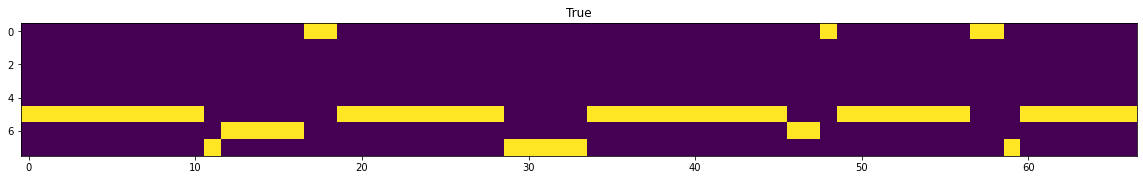

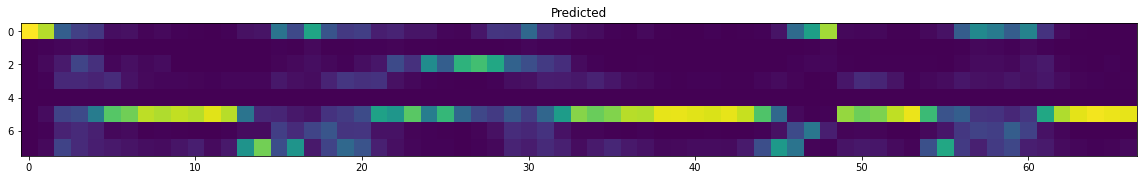

In [26]:
plt.figure(figsize=(20,4))
plt.title("True")
plt.imshow(test_y_main[15][0:67].T)
plt.figure(figsize=(20,4))
plt.title("Predicted")
plt.imshow(preRes[15][0:67].T)

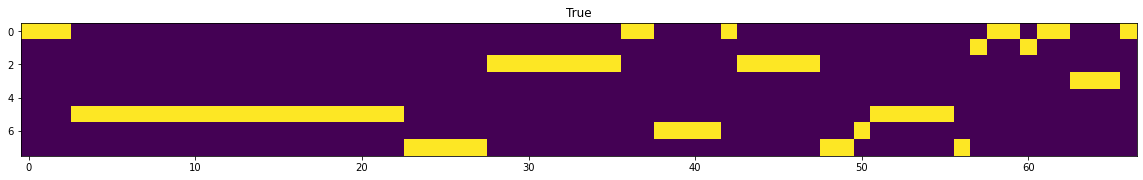

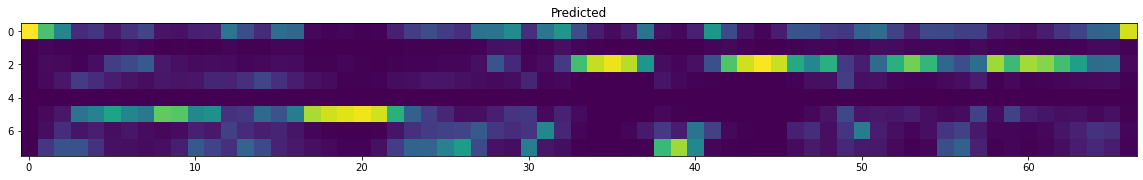

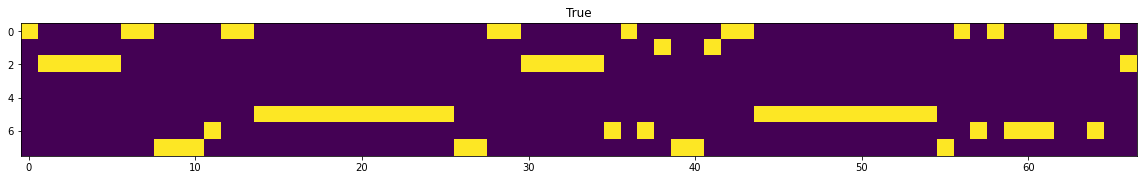

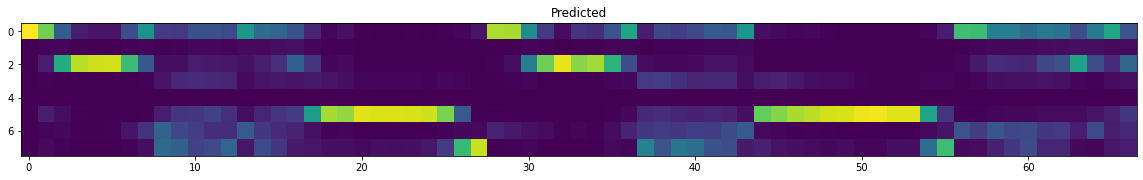

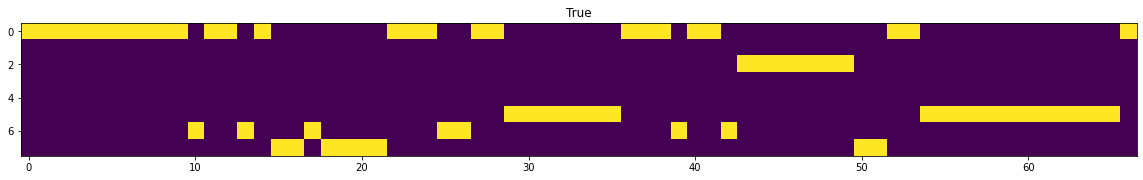

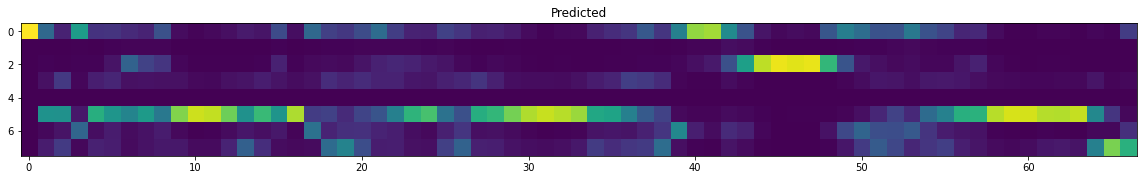

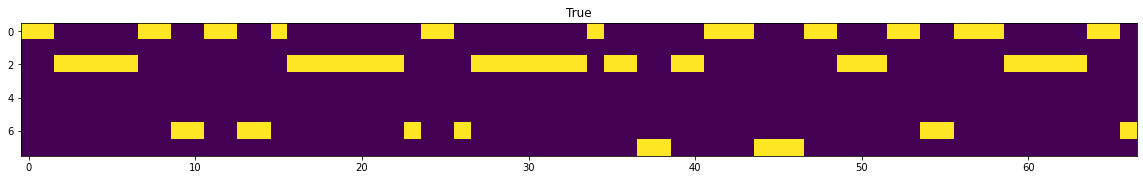

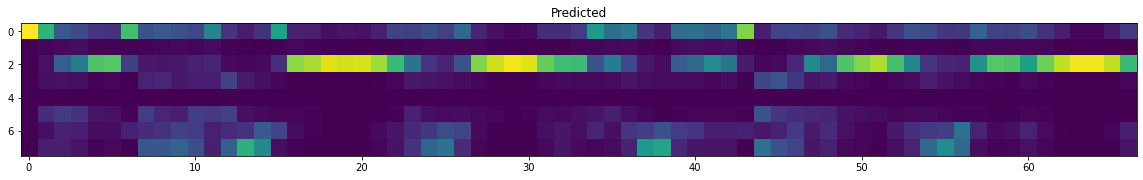

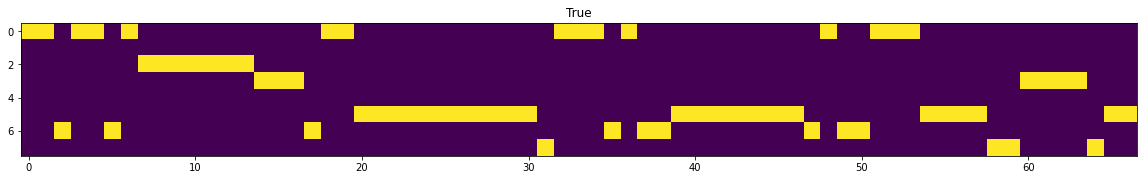

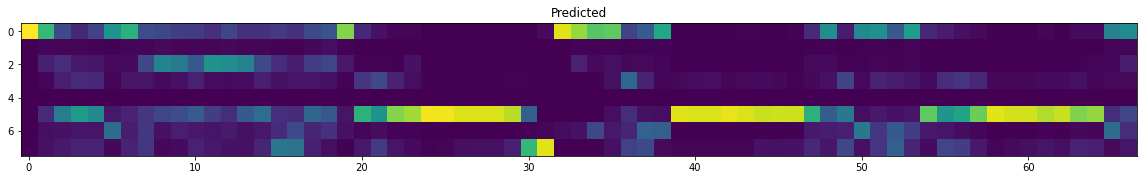

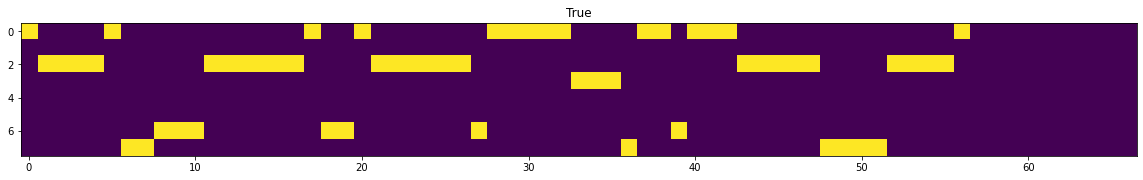

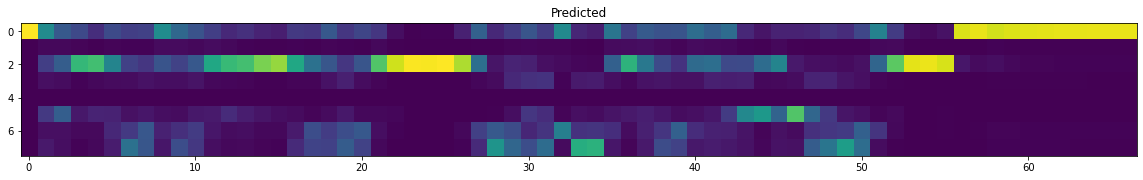

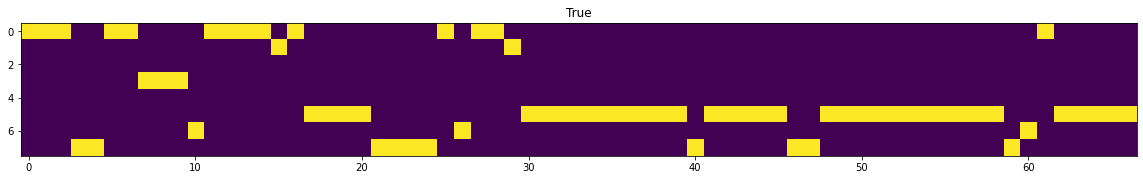

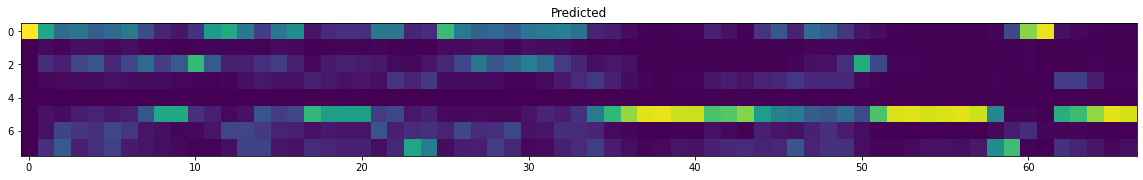

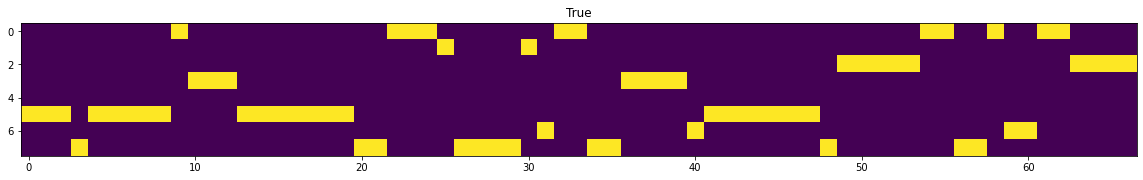

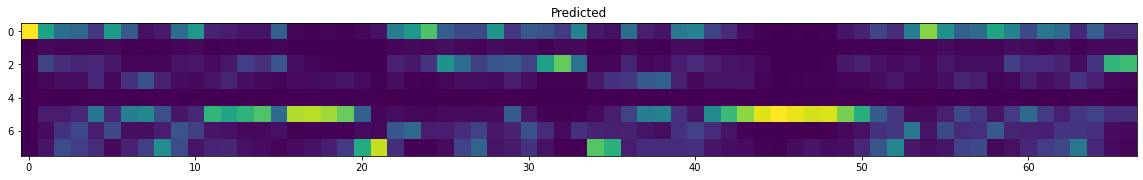

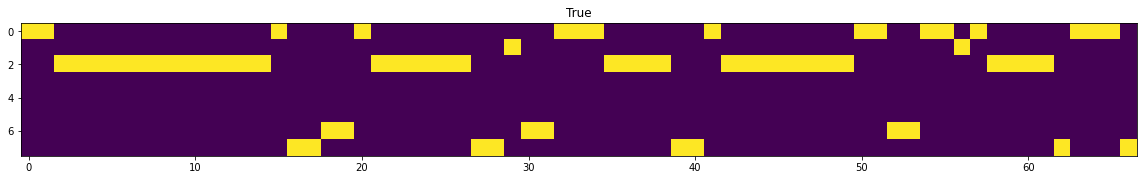

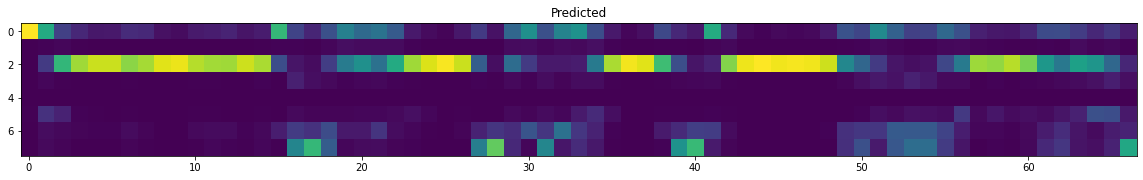

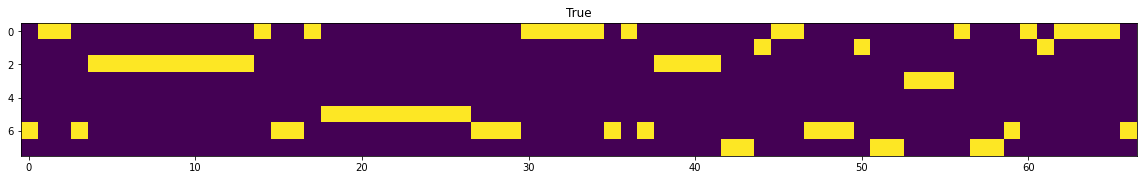

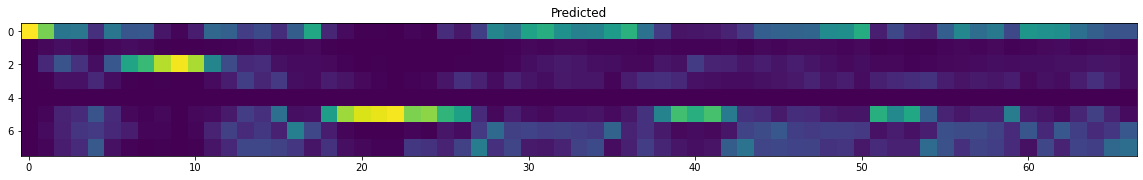

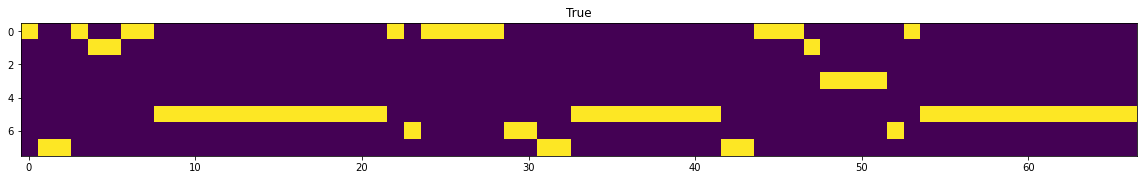

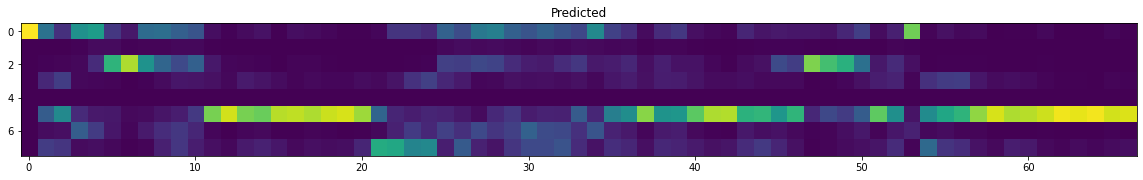

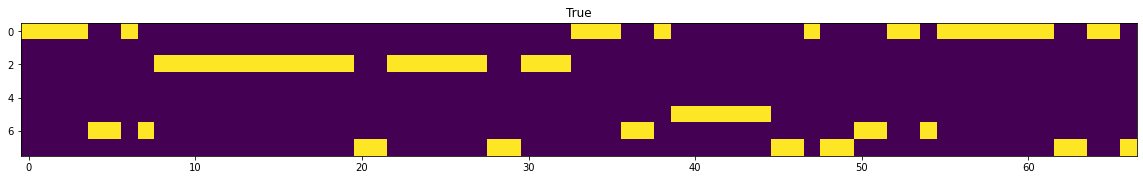

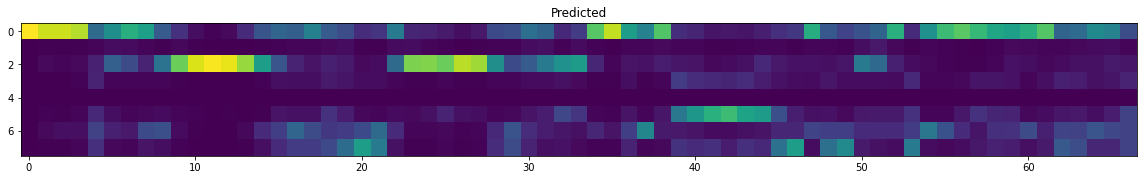

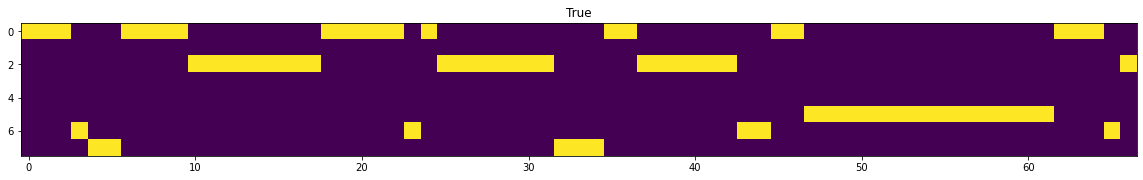

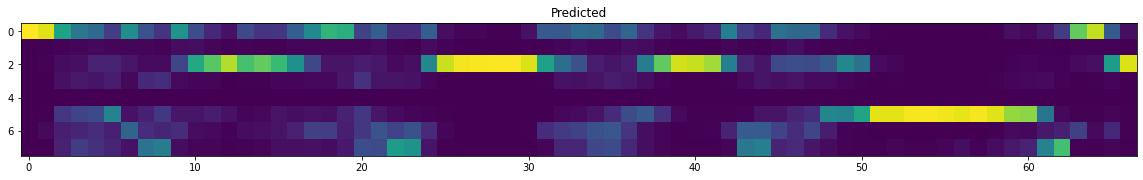

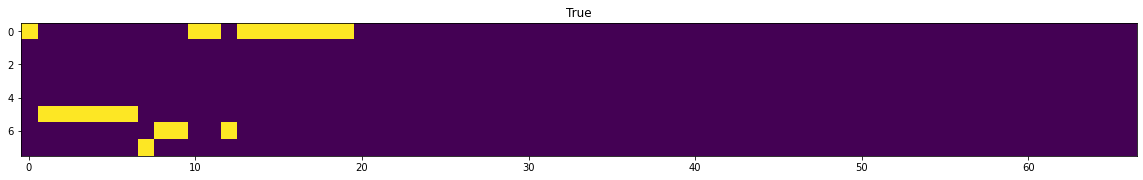

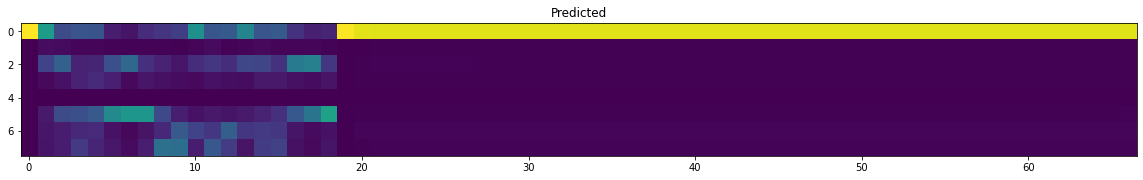

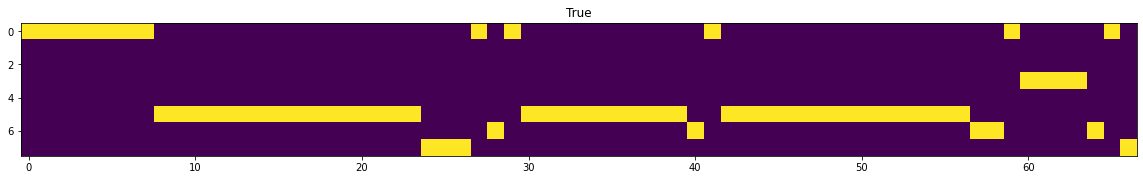

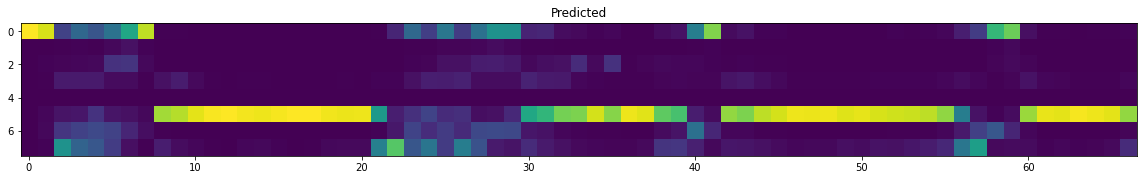

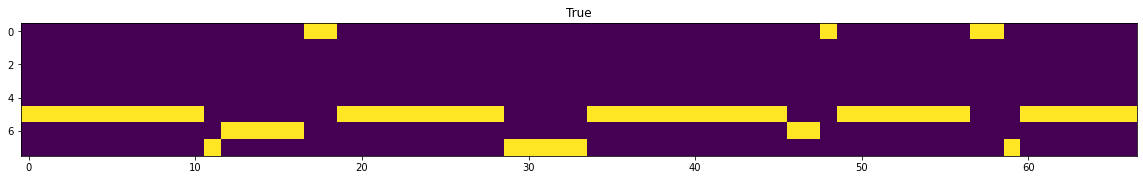

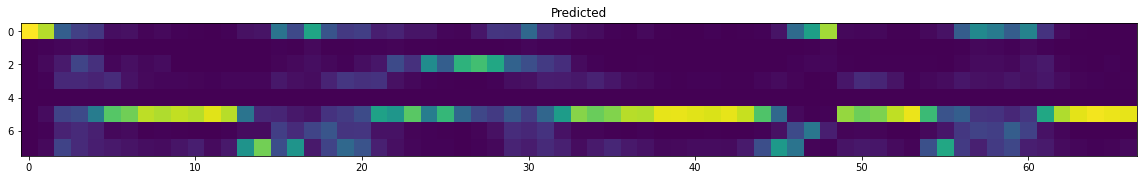

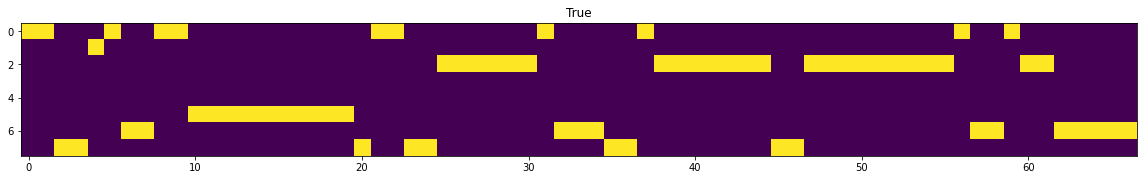

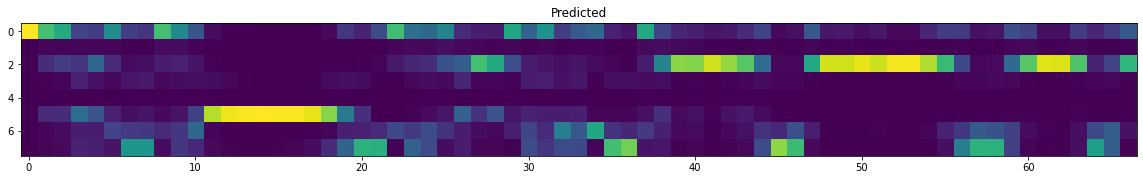

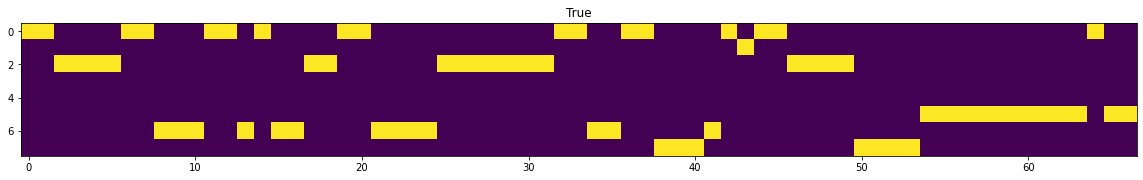

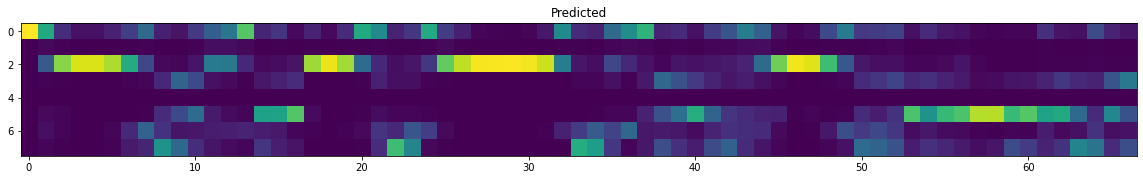

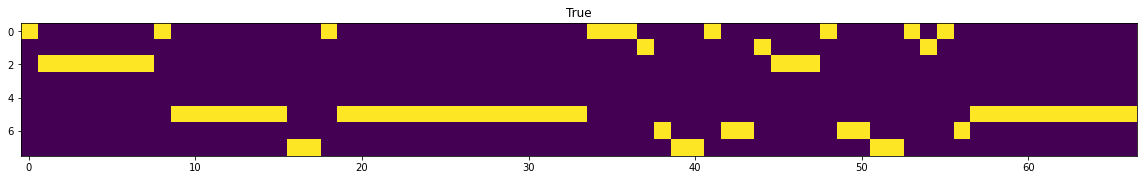

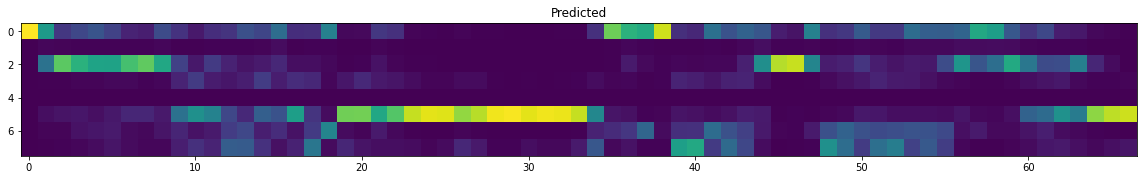

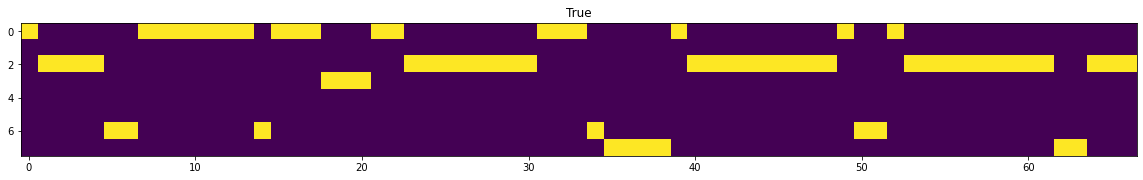

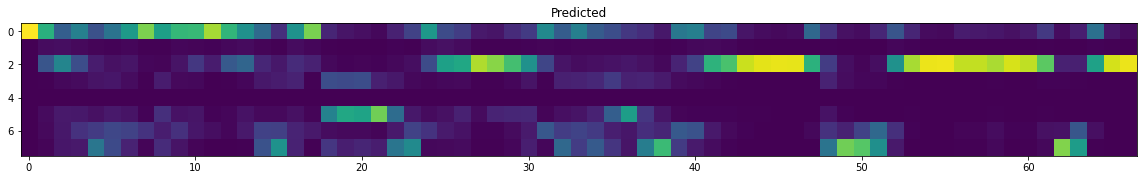

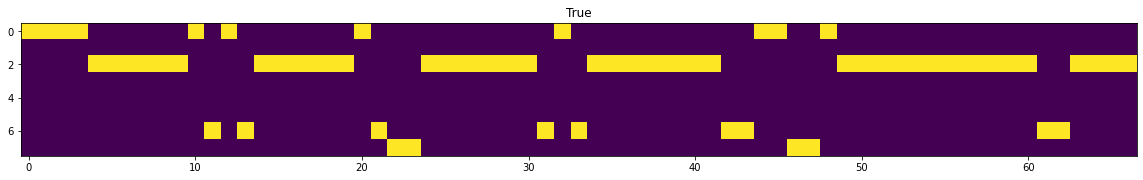

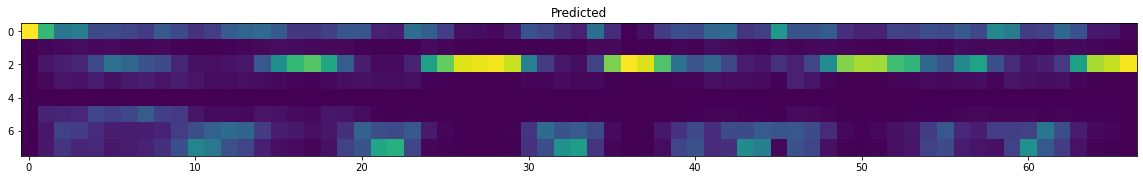

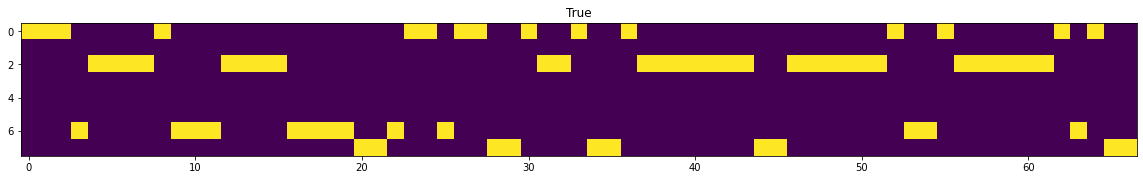

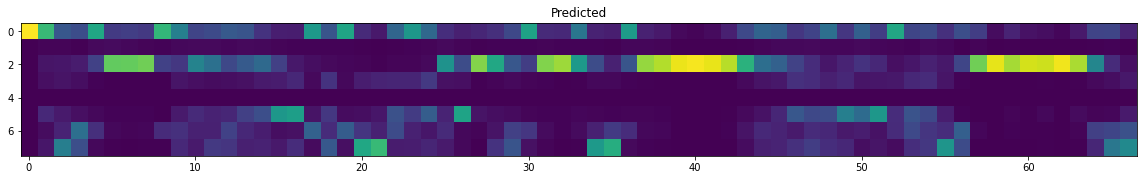

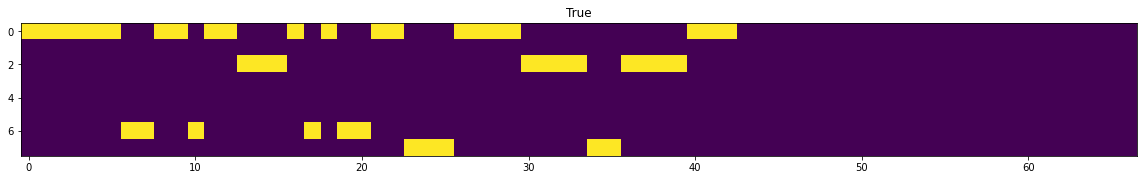

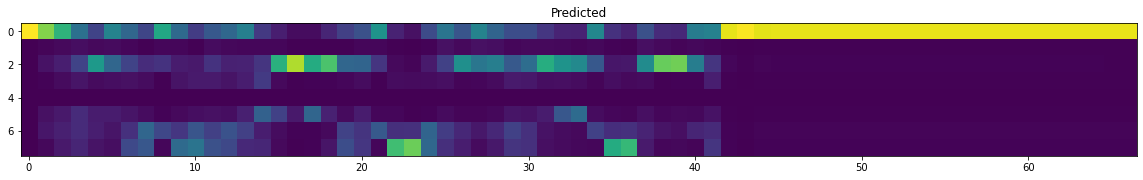

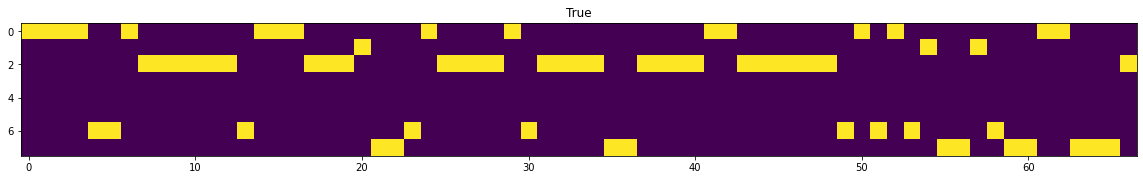

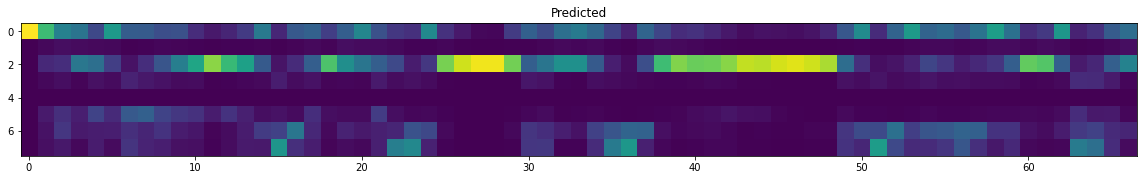

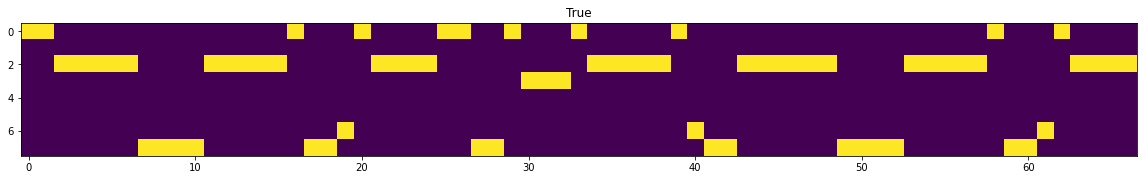

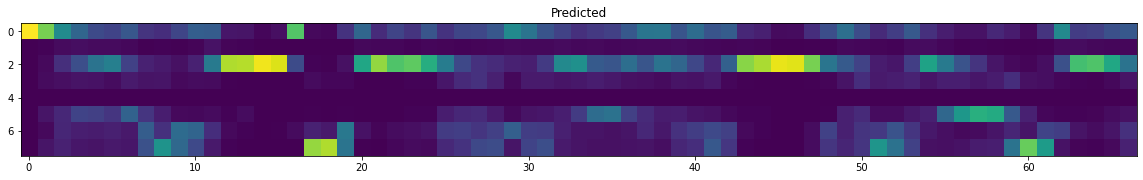

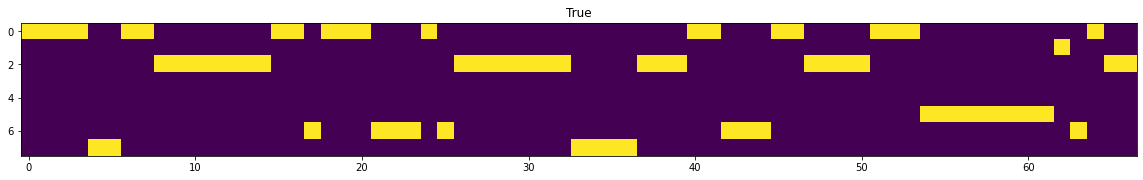

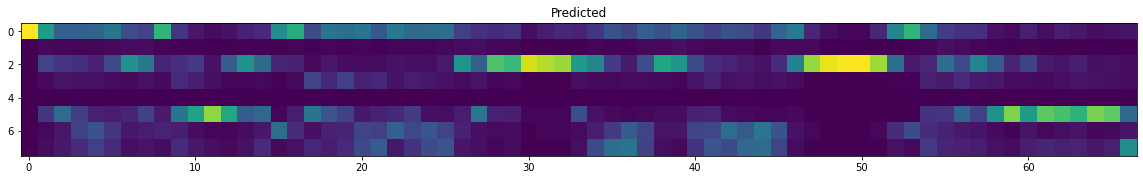

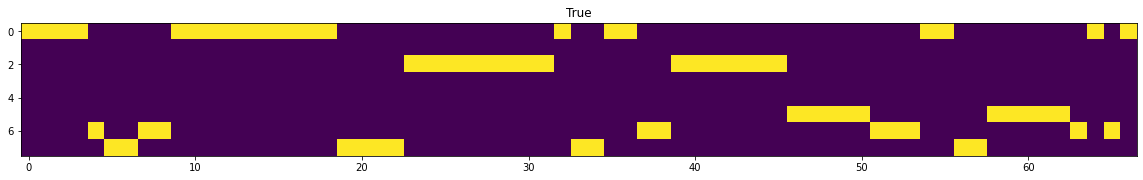

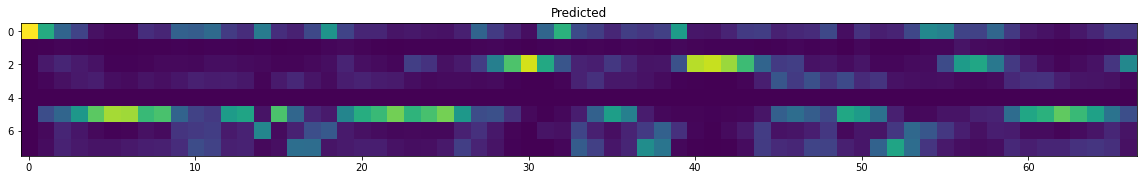

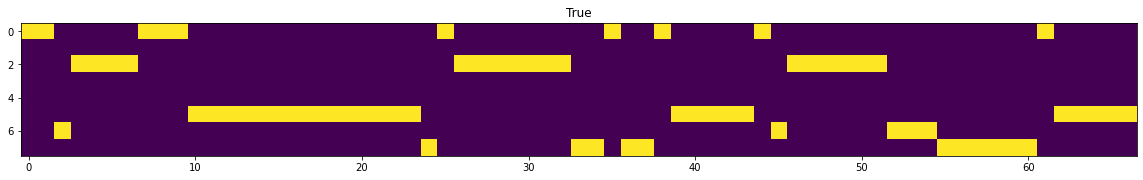

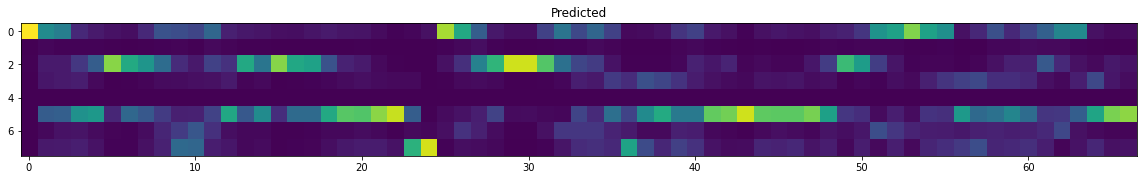

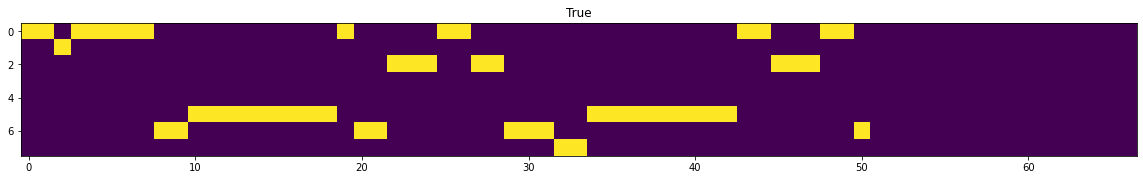

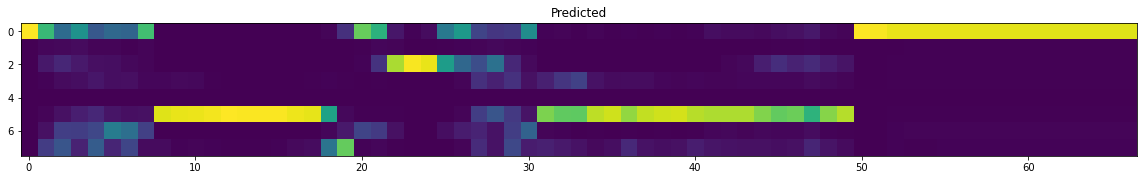

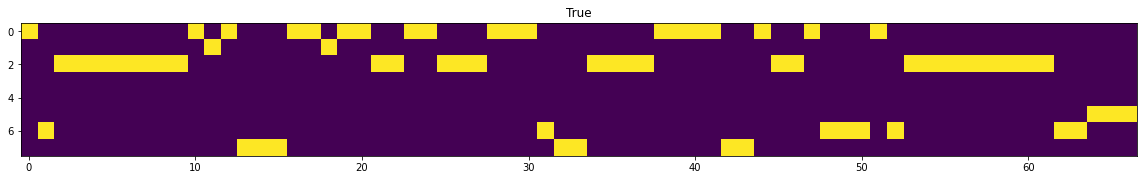

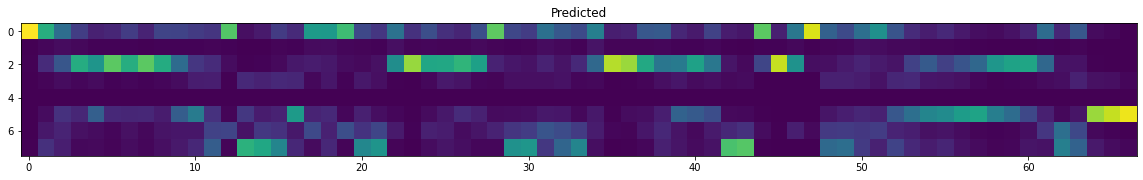

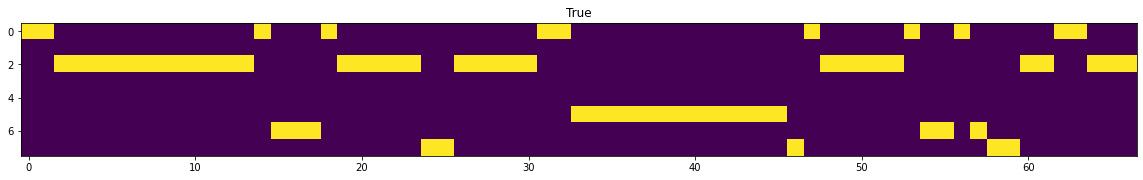

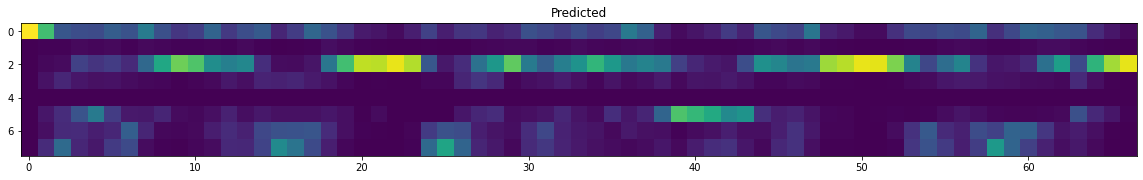

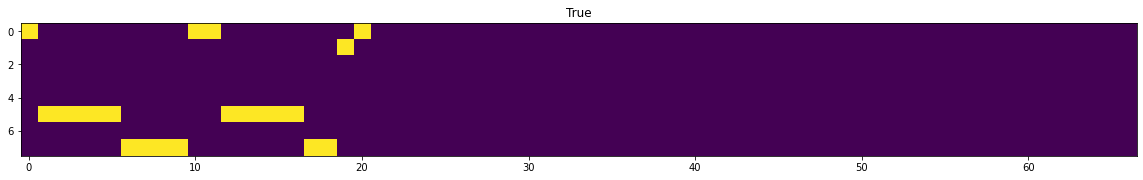

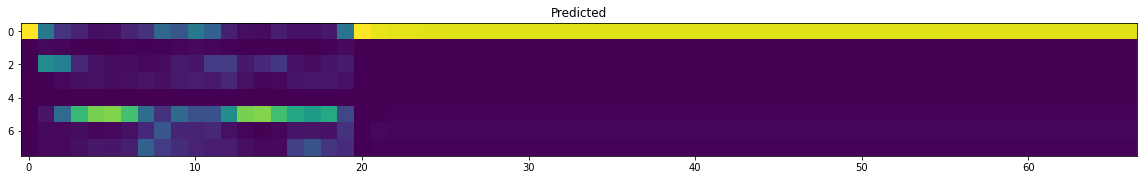

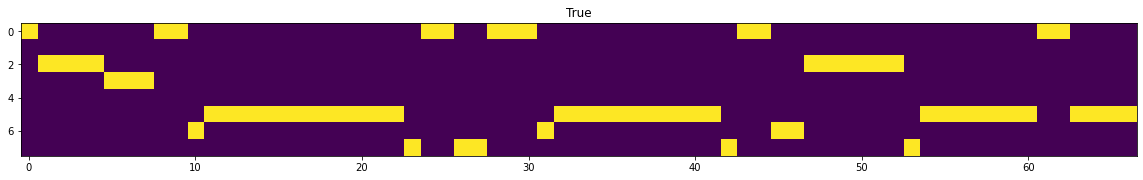

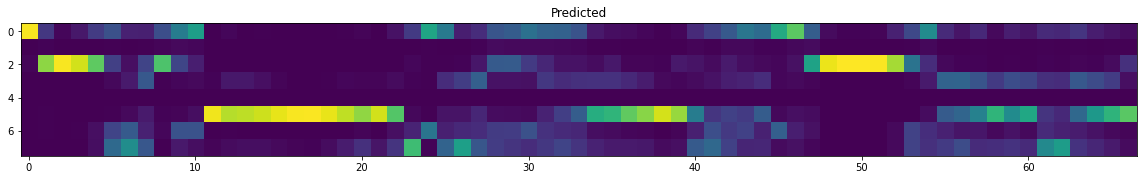

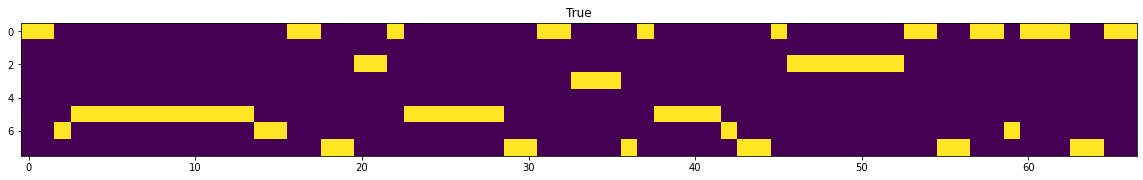

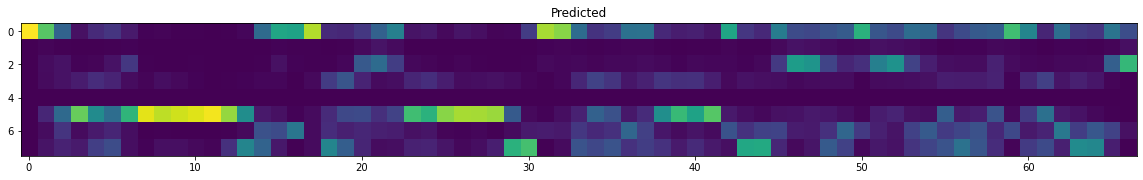

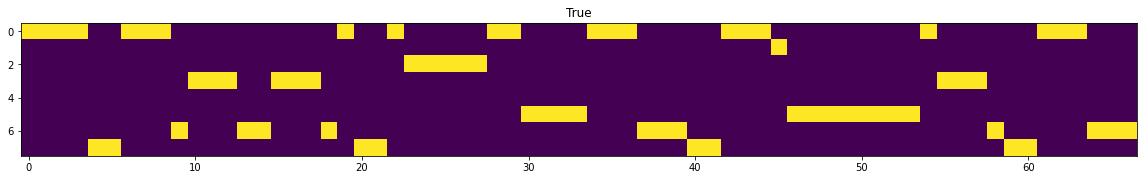

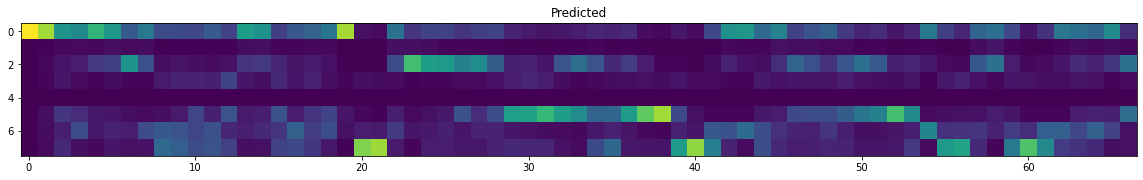

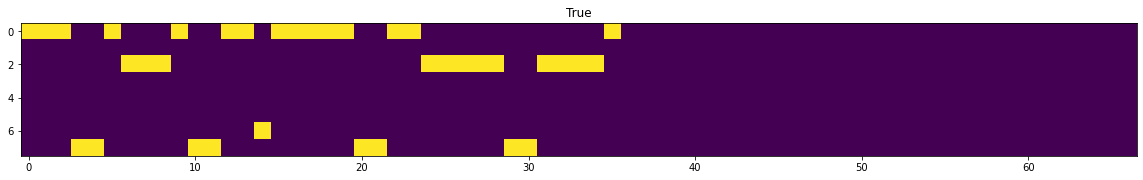

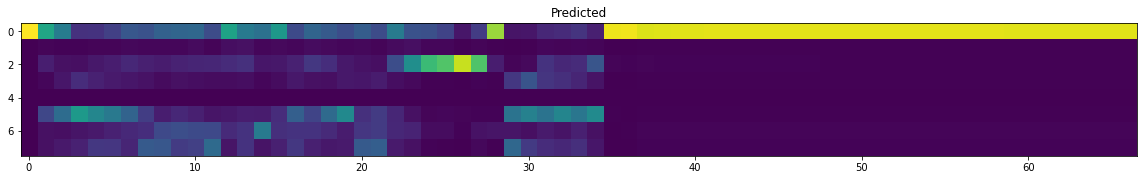

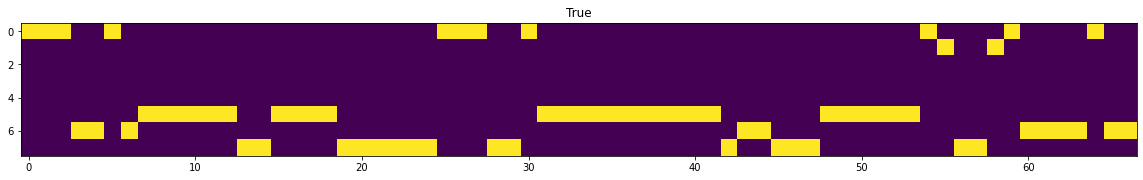

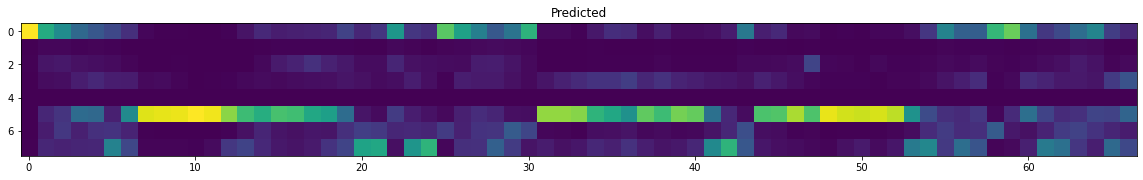

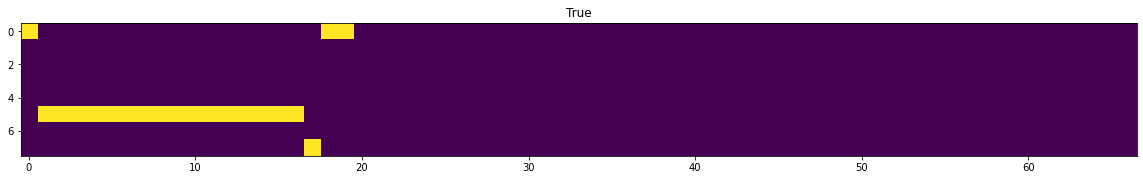

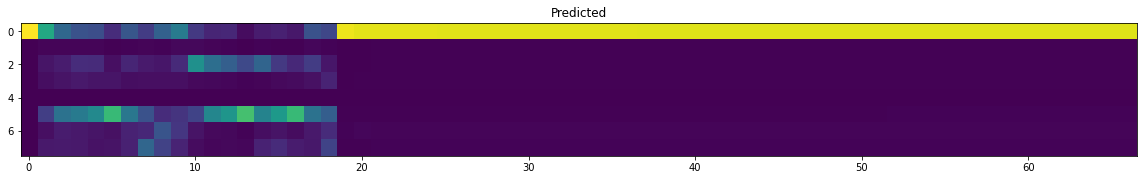

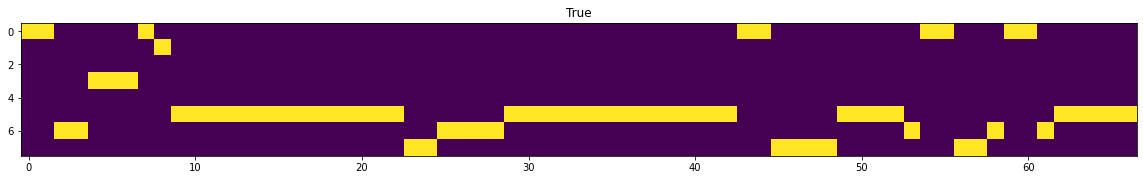

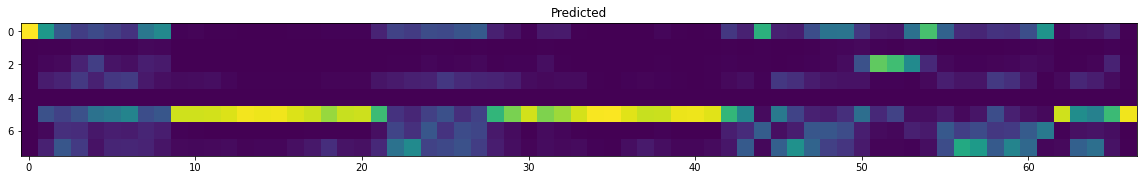

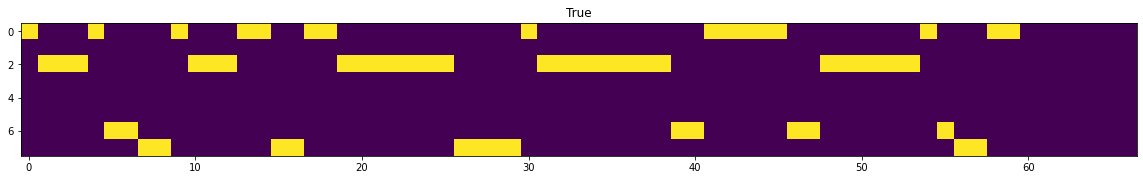

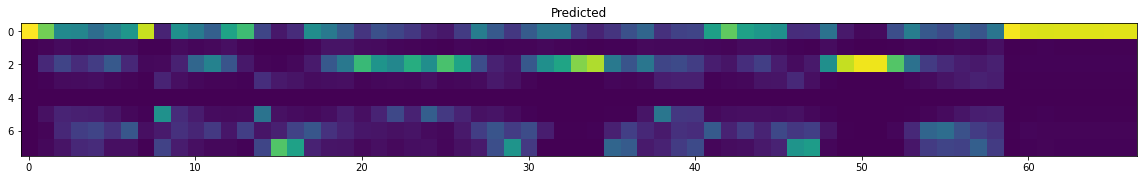

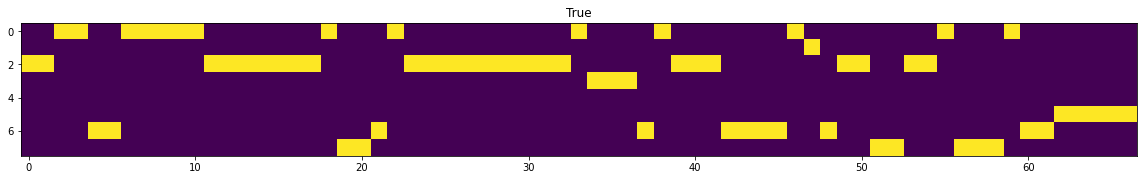

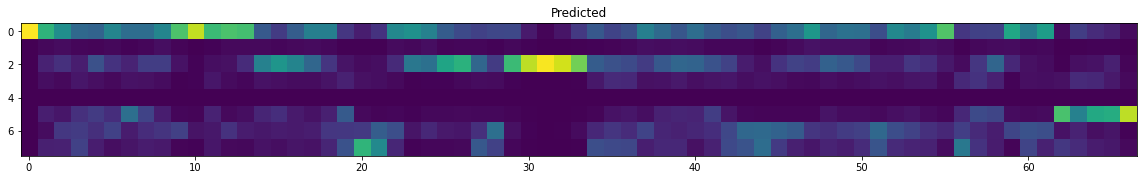

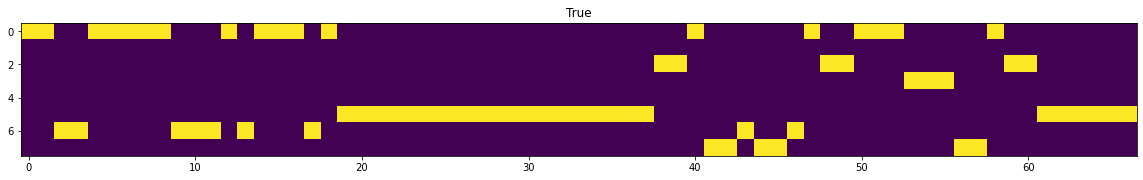

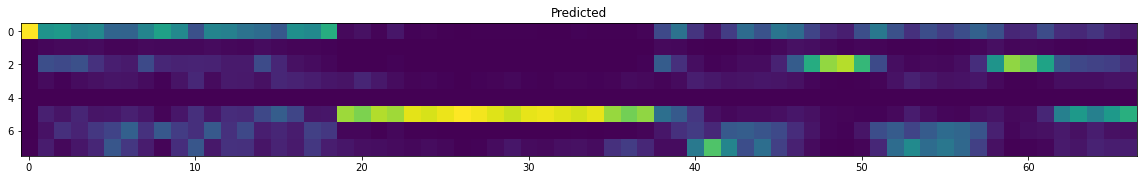

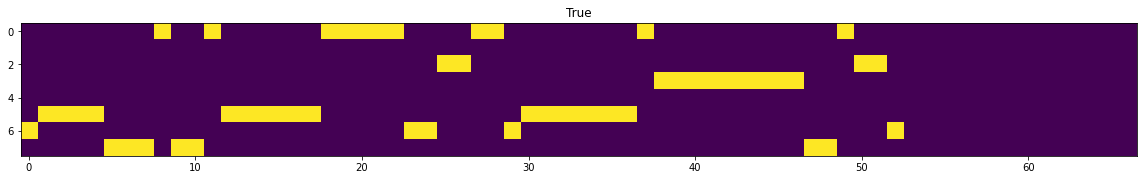

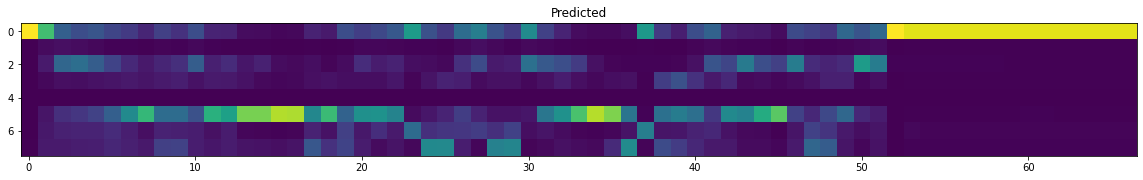

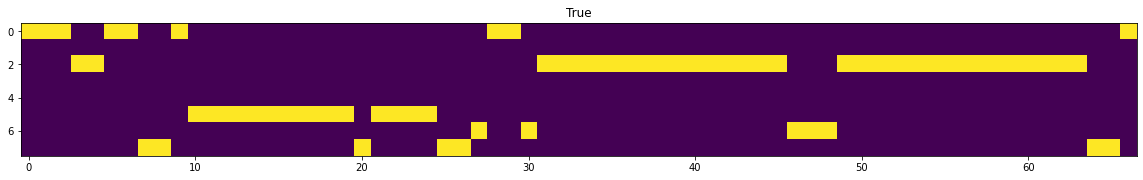

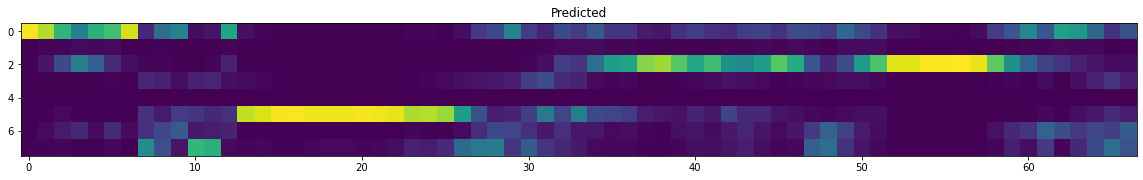

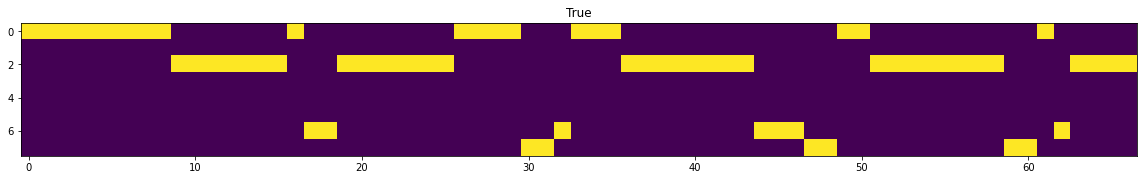

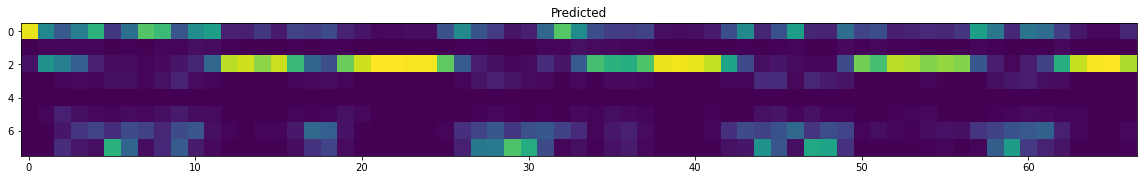

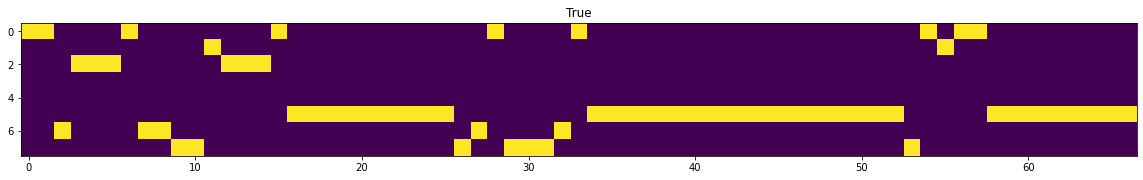

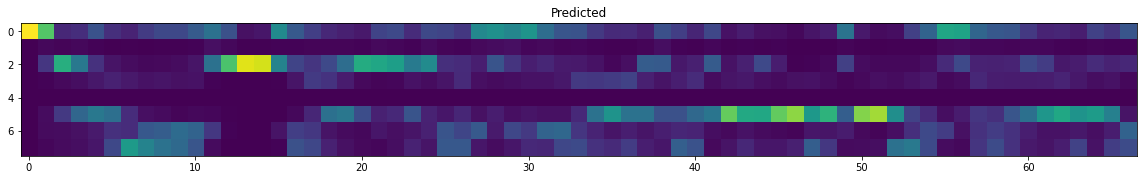

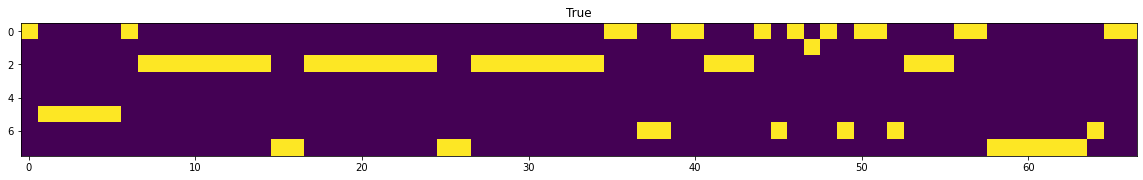

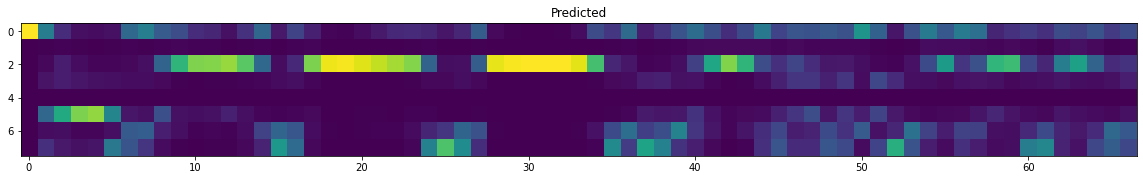

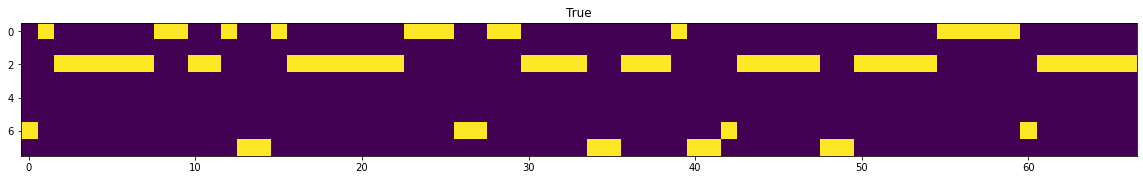

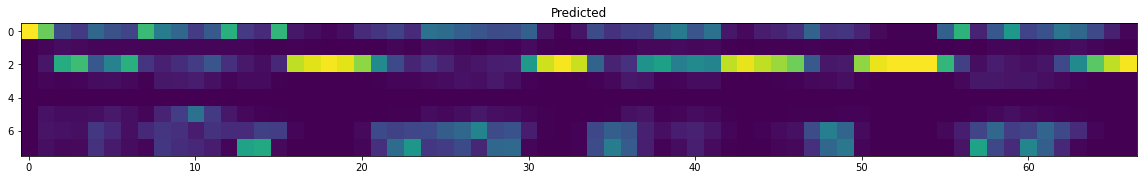

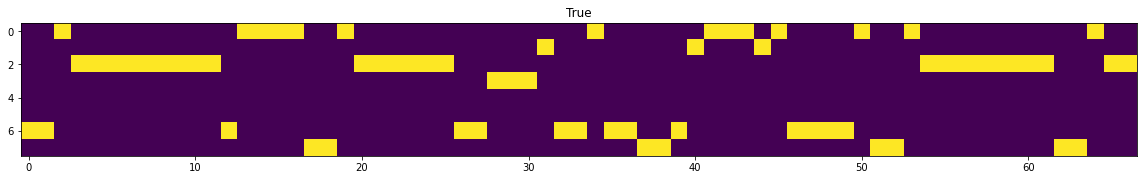

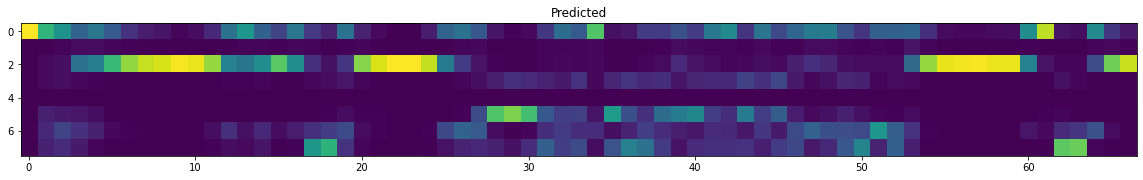

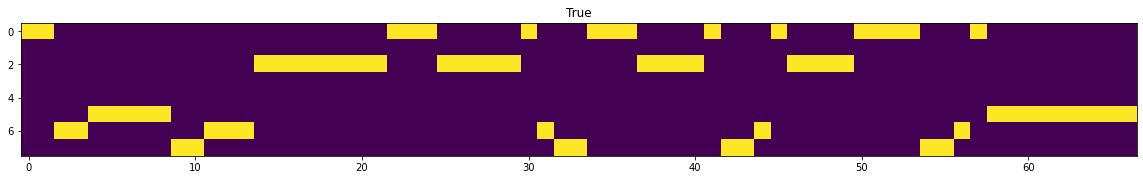

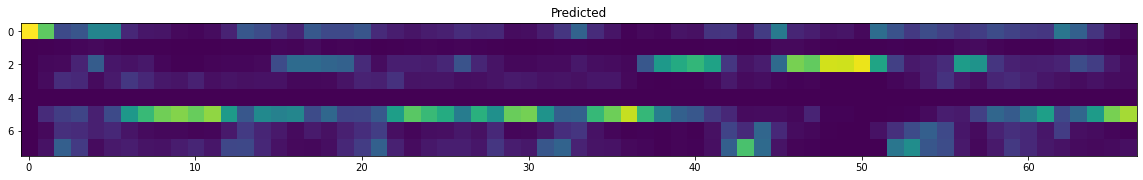

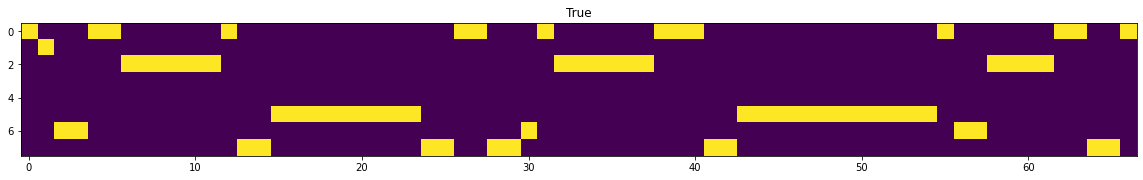

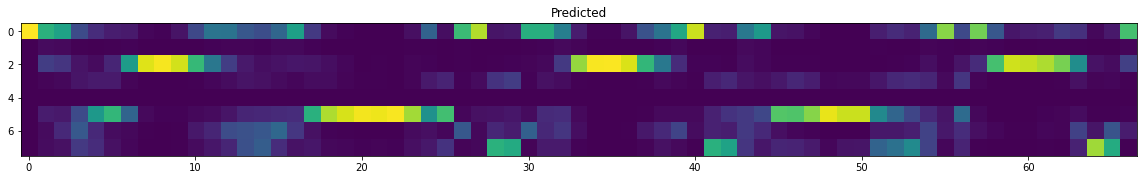

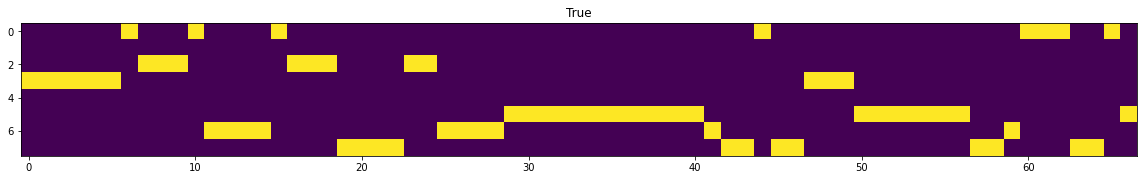

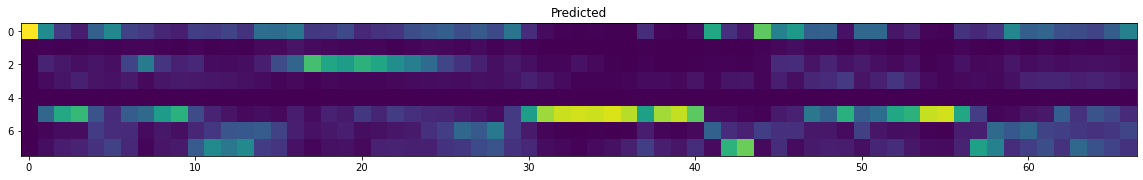

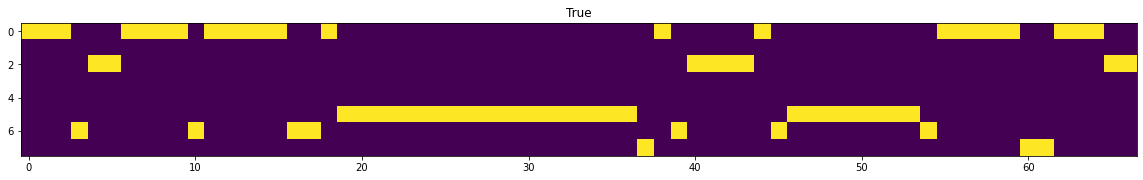

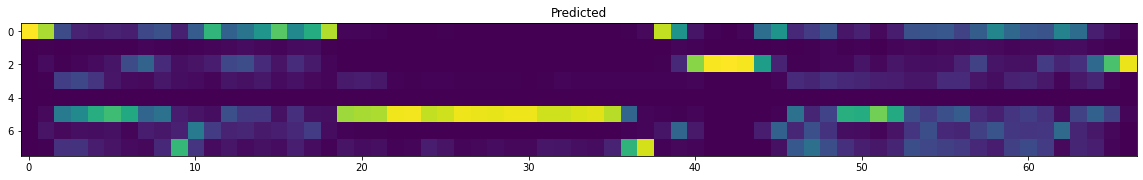

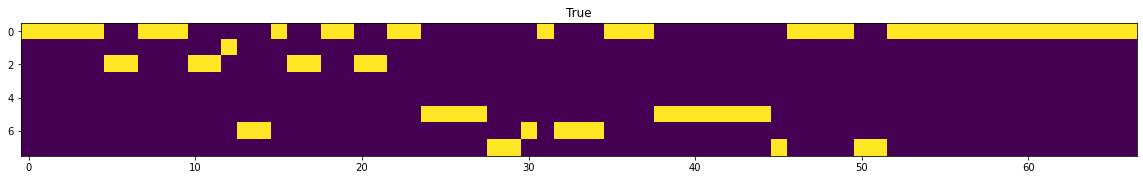

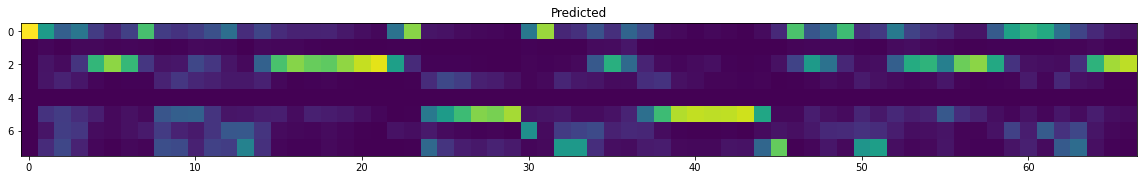

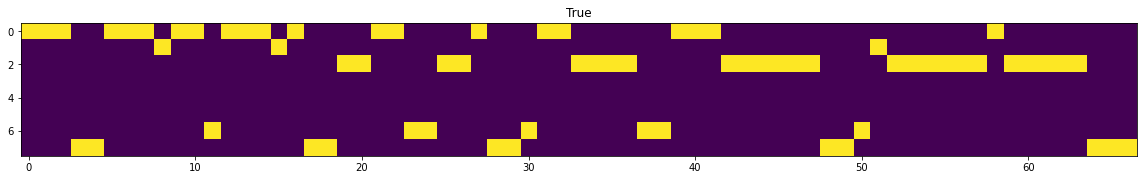

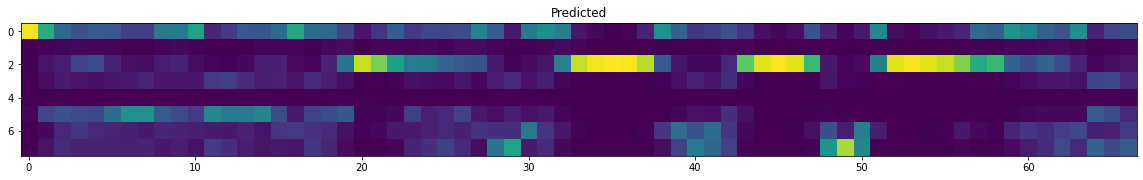

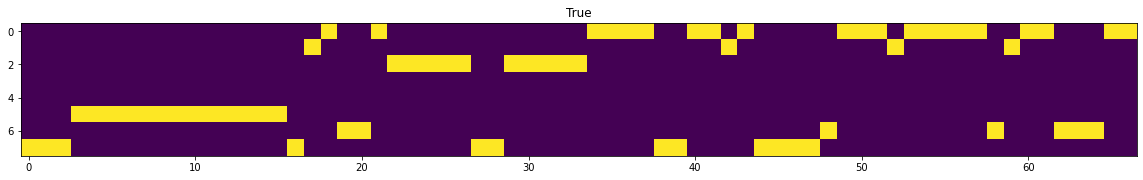

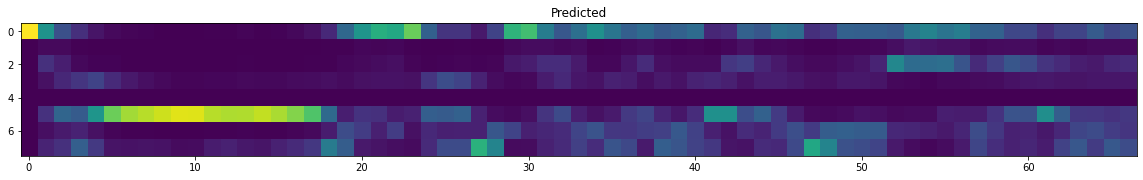

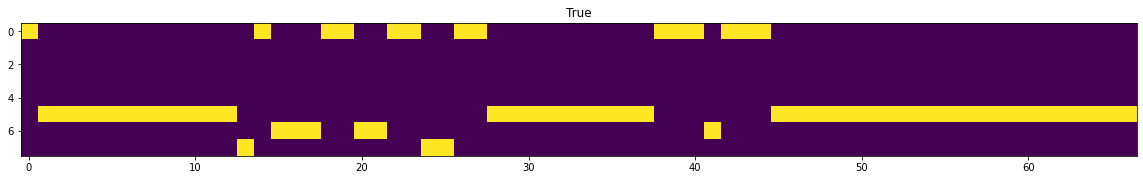

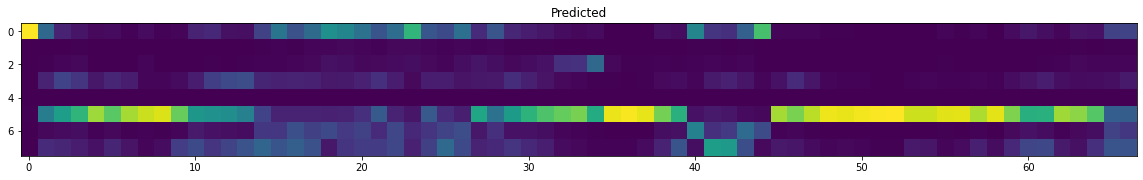

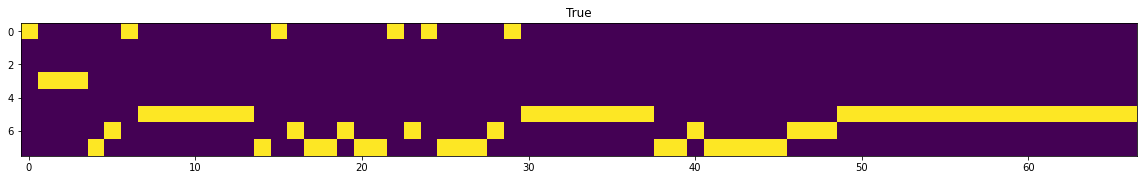

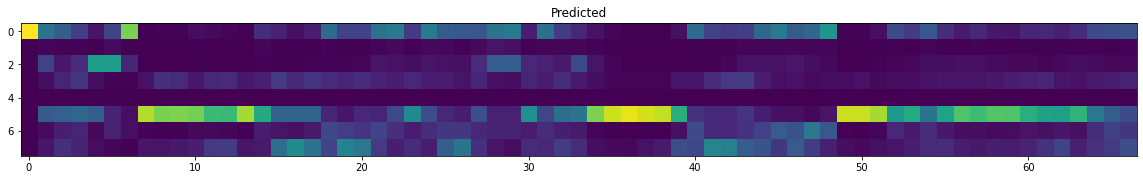

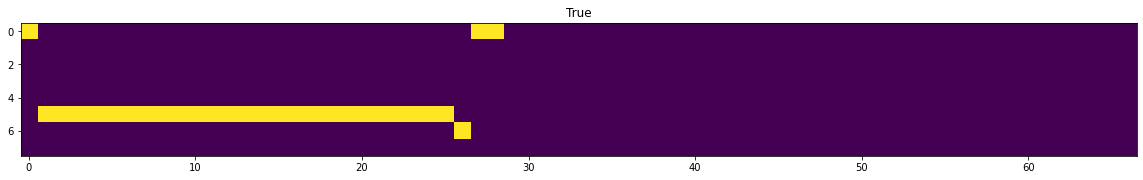

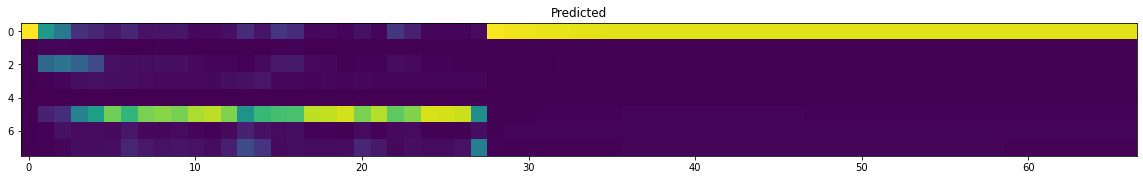

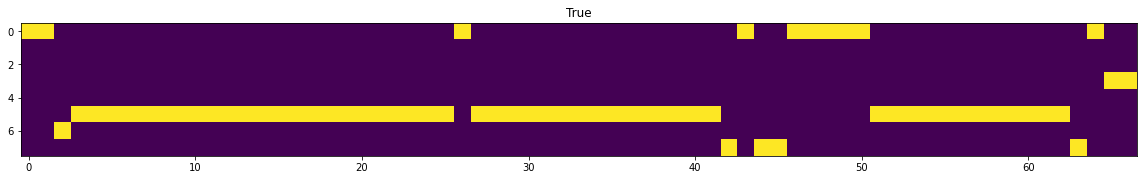

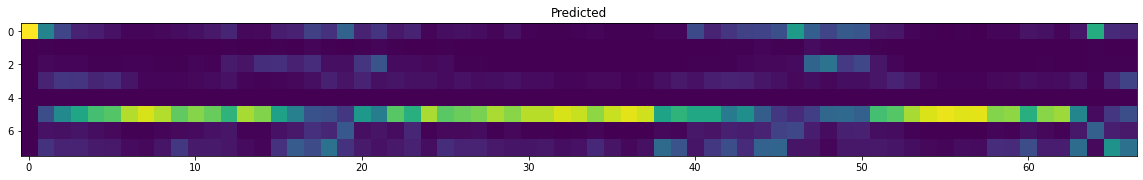

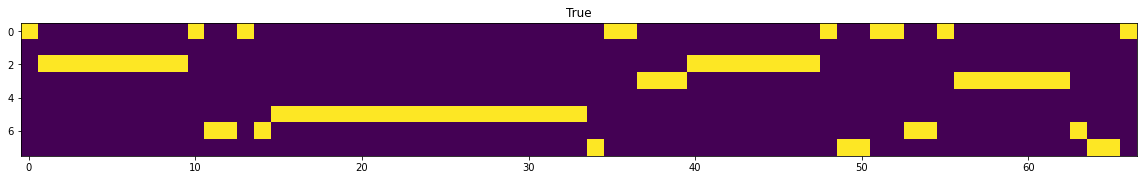

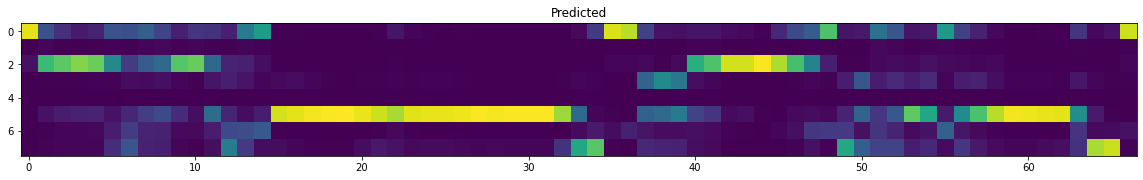

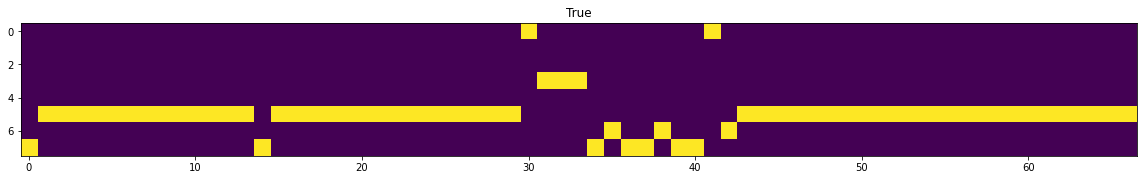

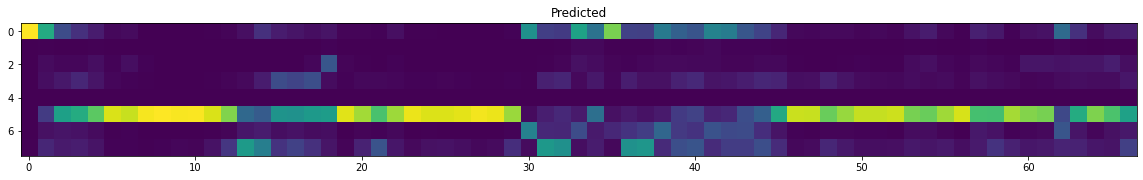

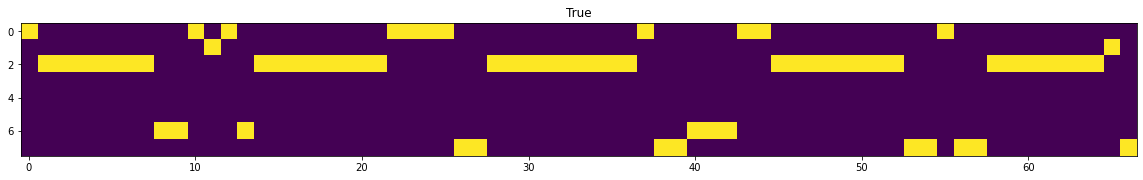

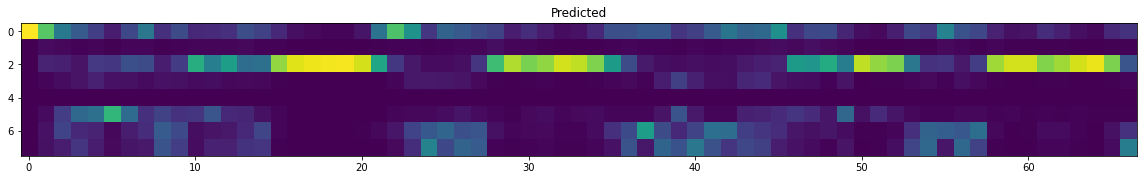

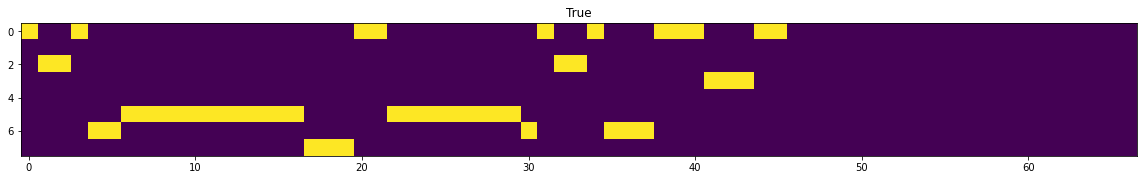

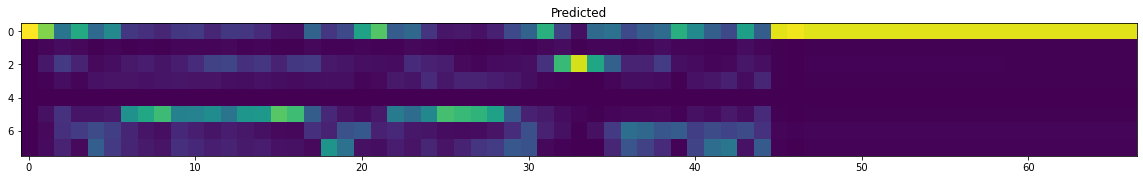

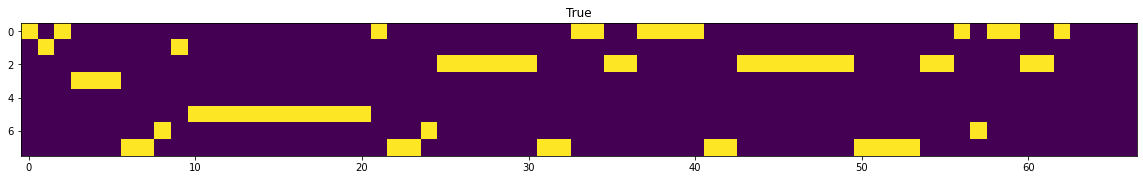

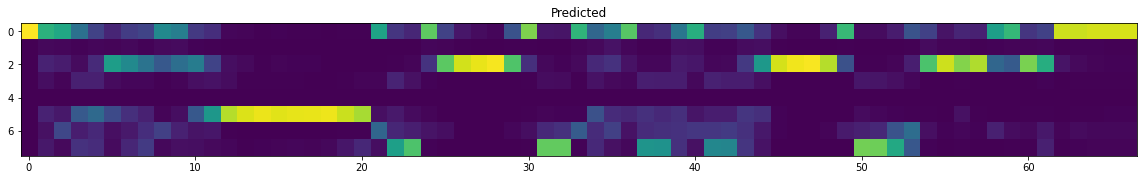

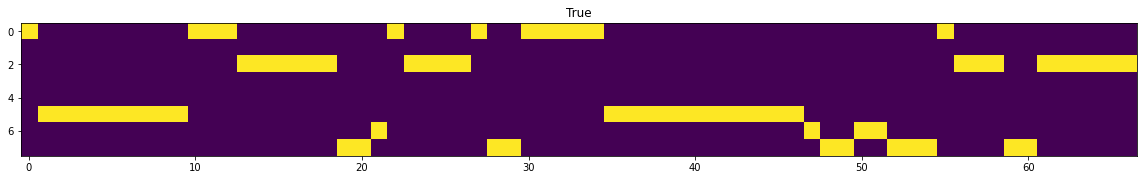

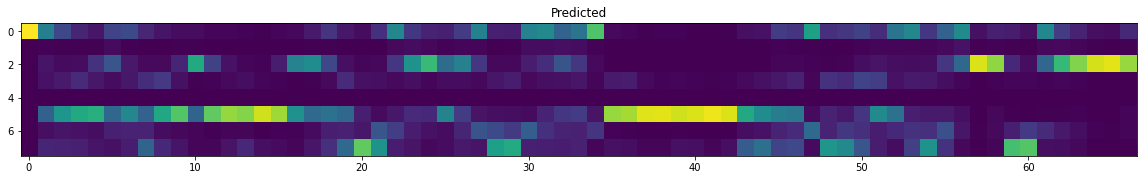

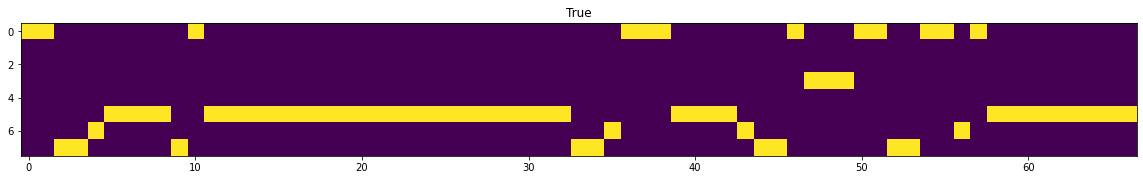

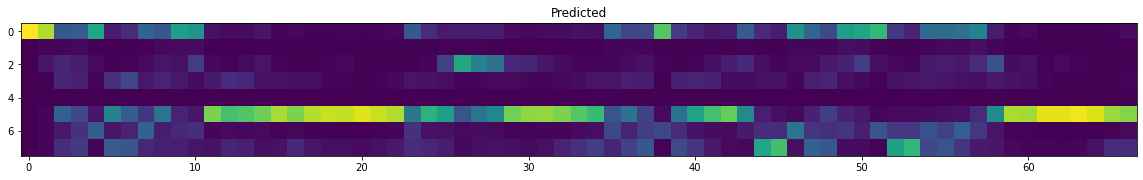

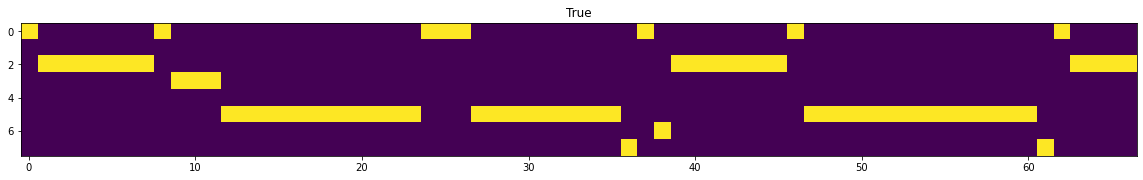

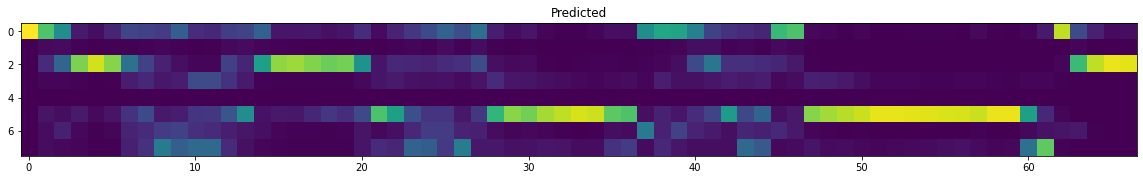

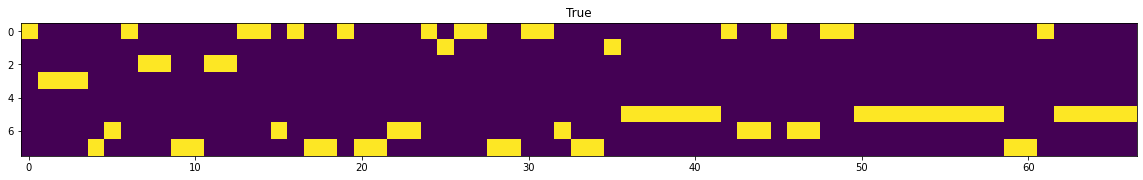

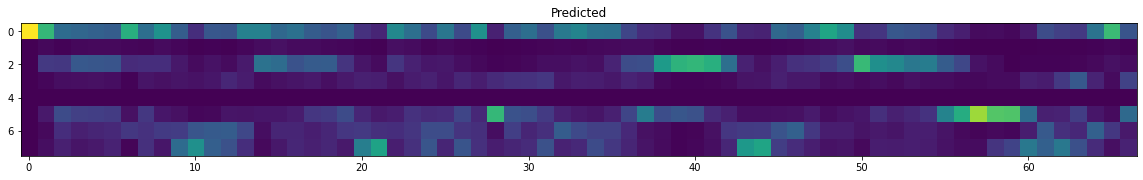

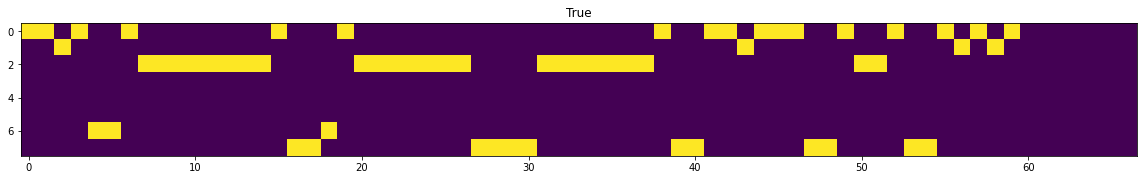

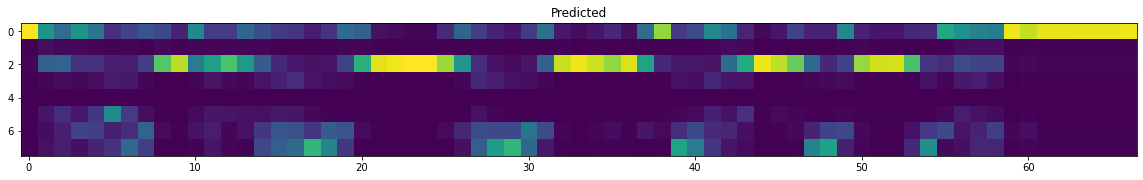

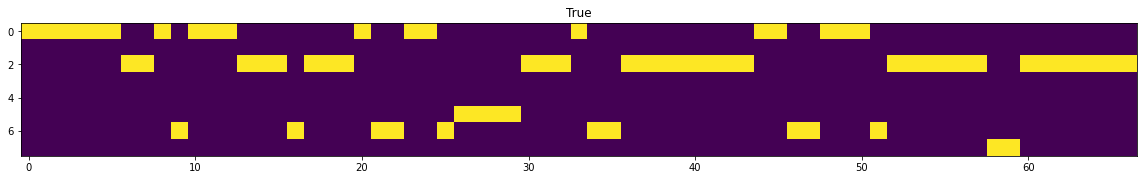

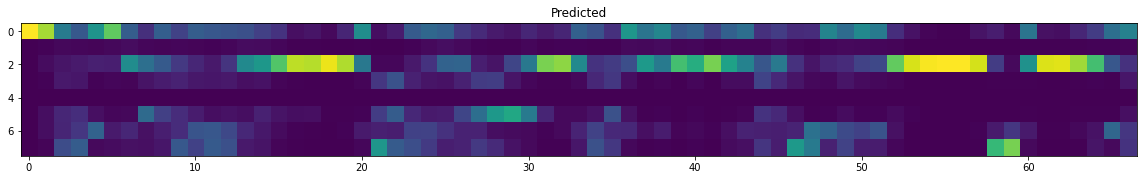

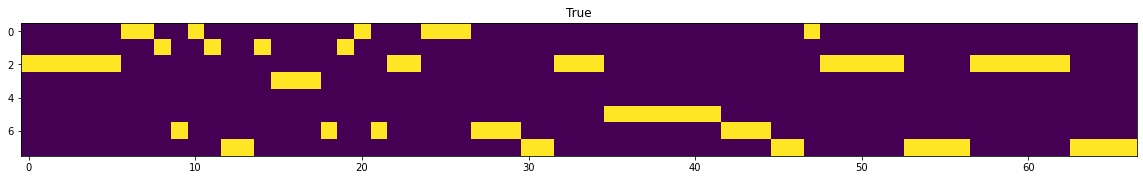

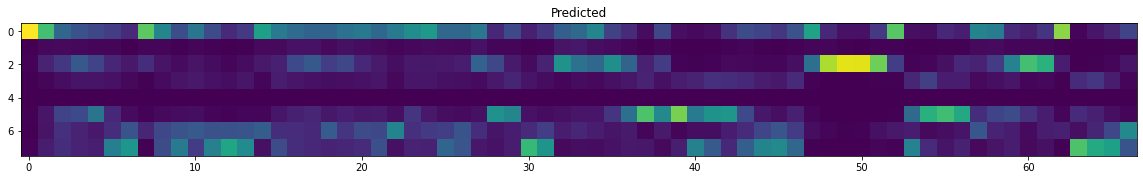

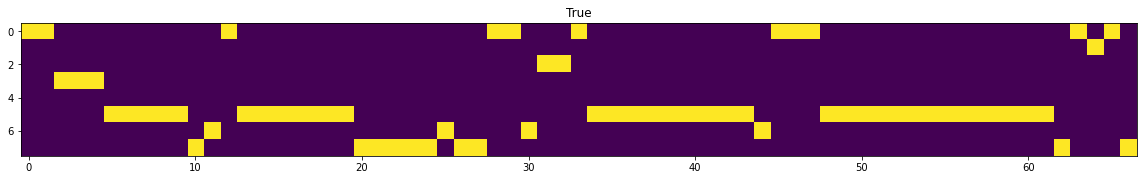

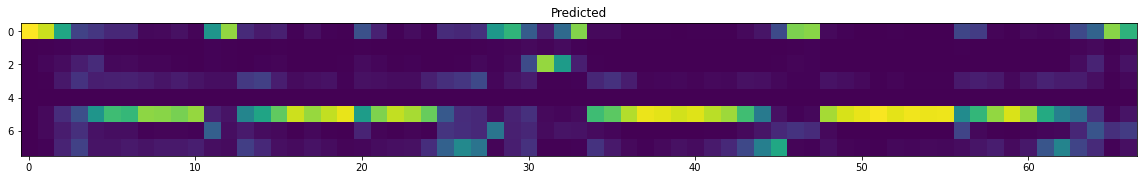

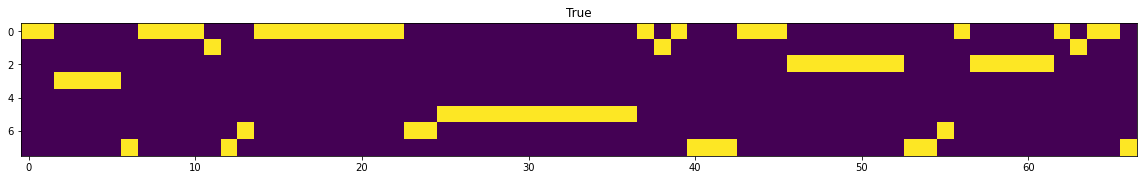

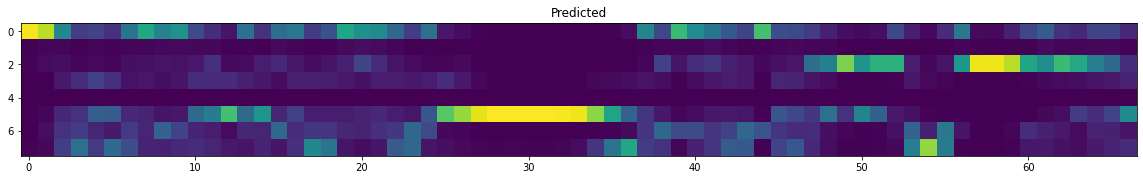

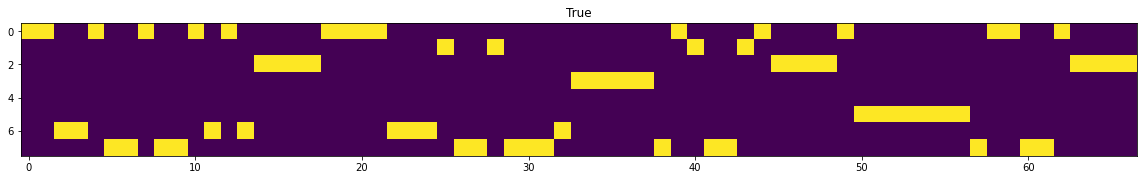

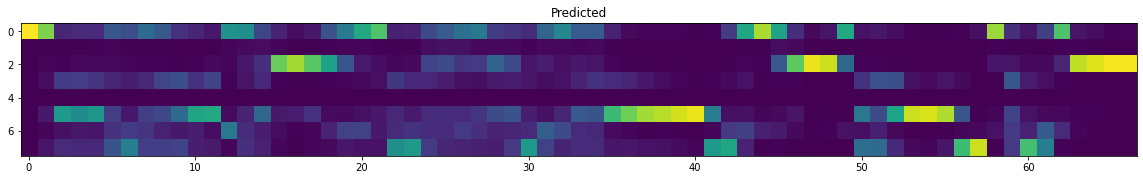

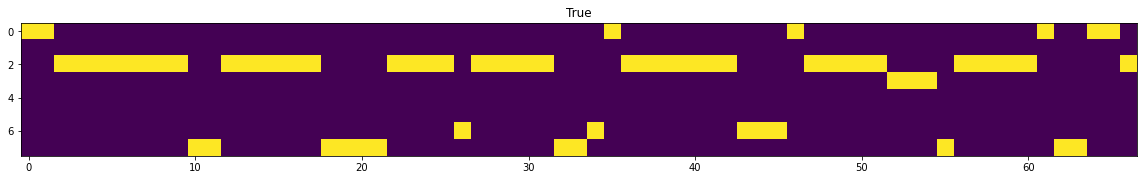

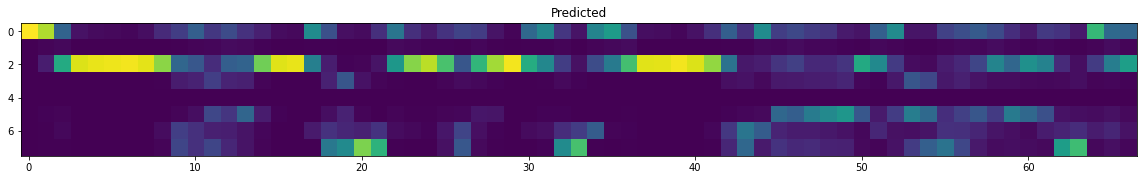

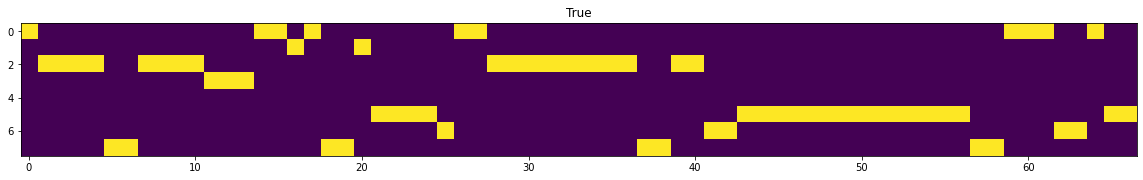

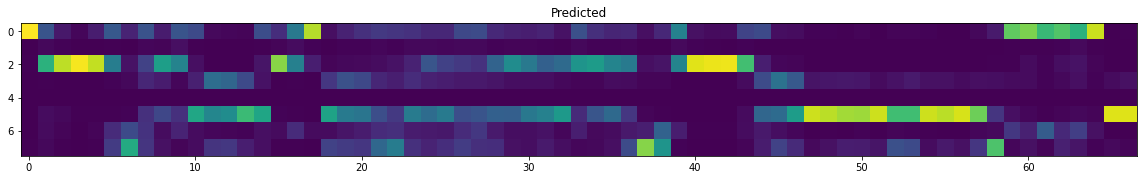

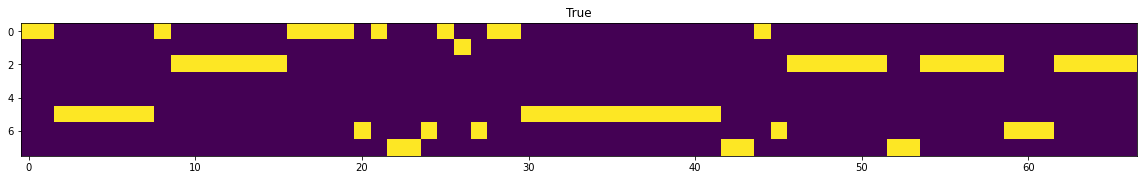

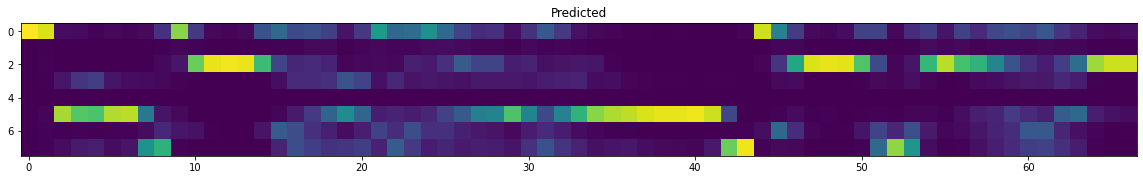

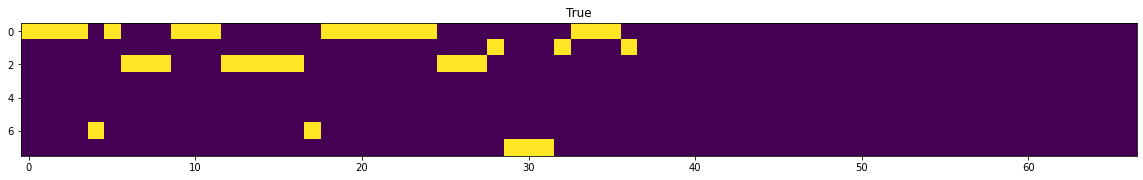

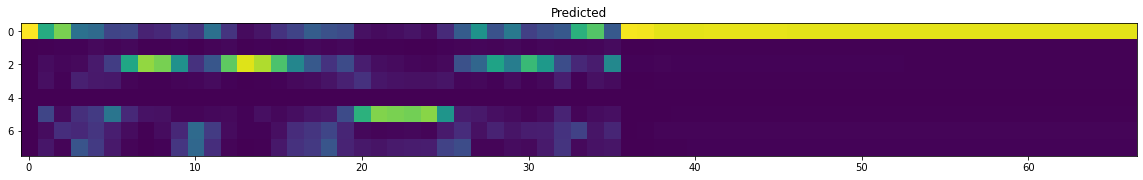

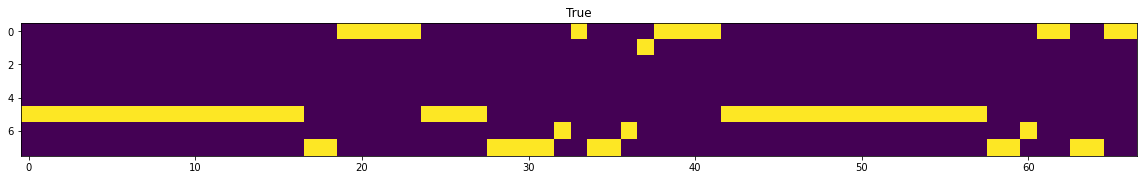

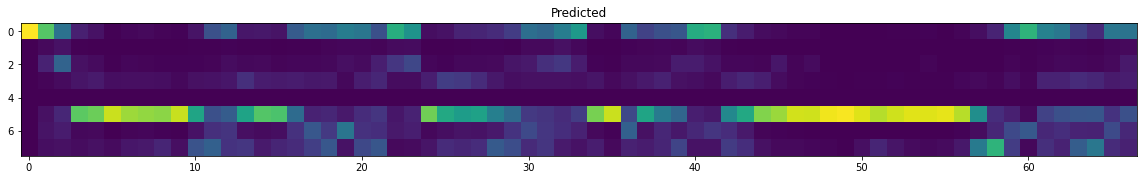

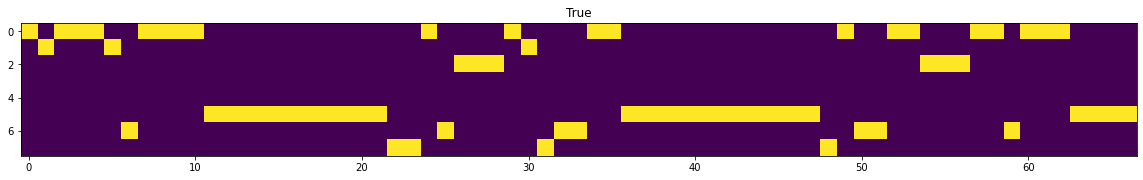

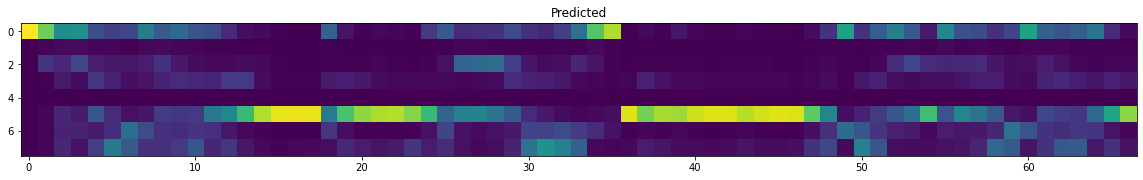

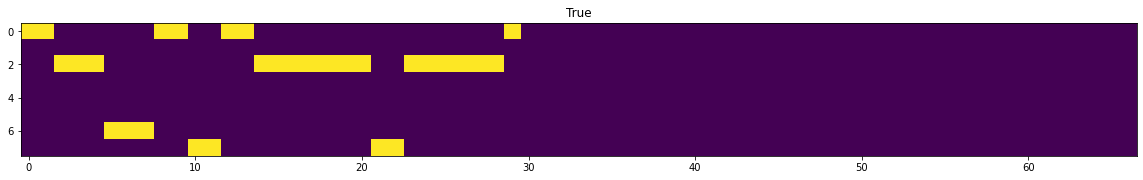

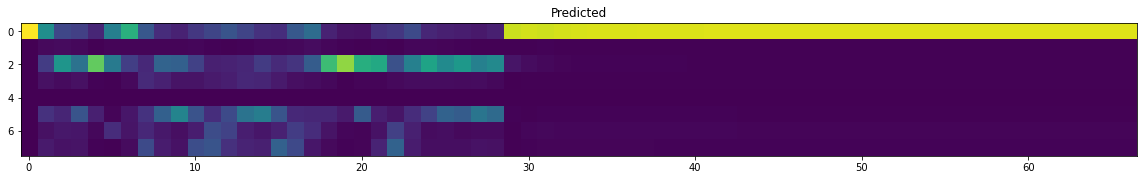

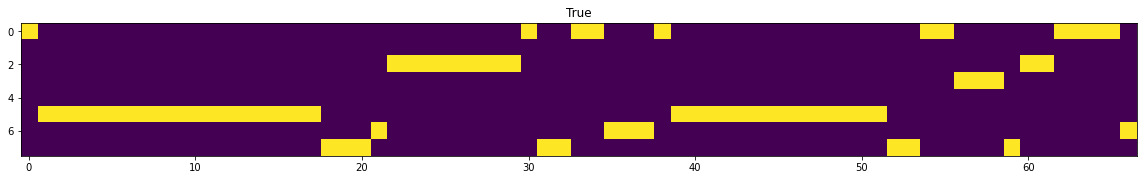

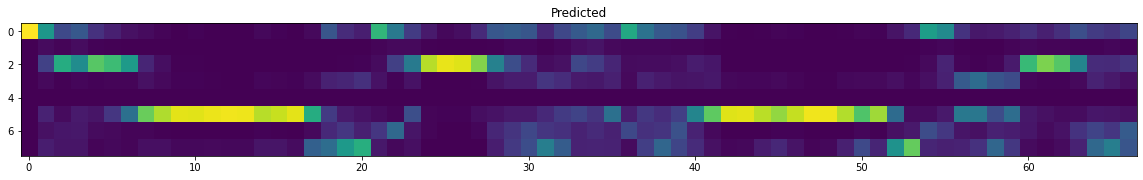

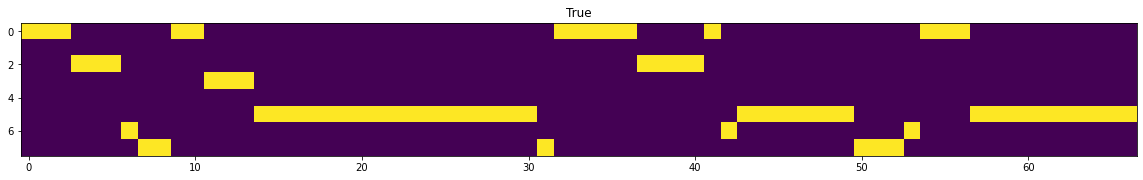

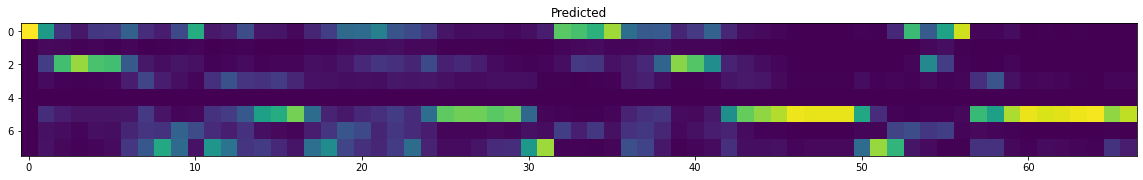

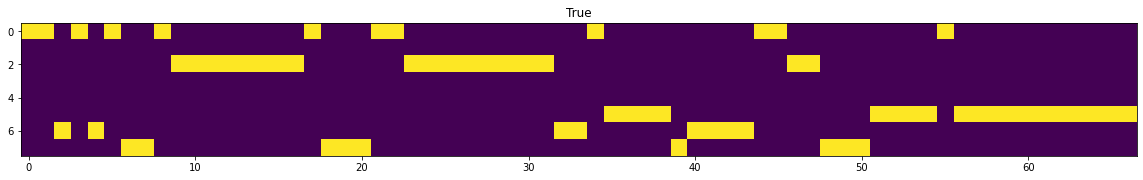

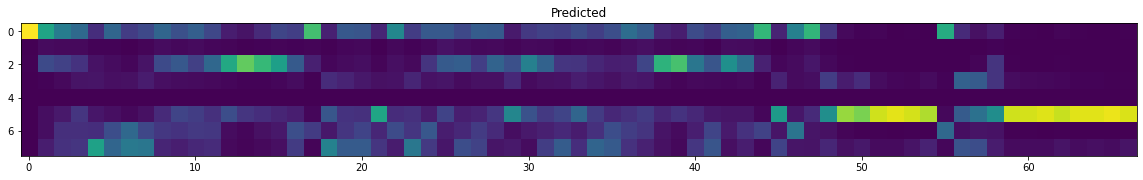

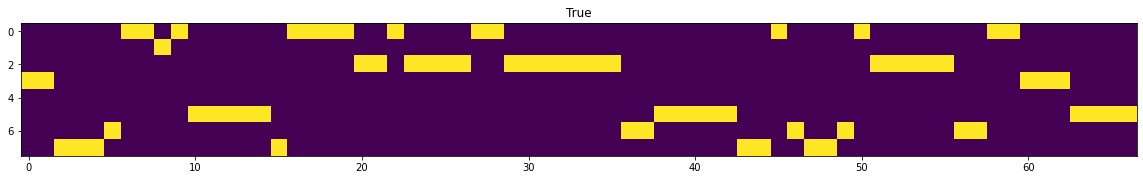

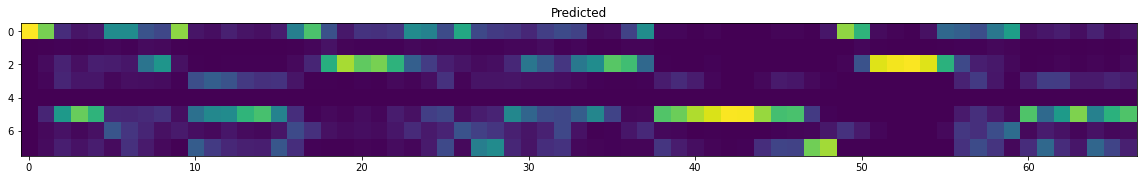

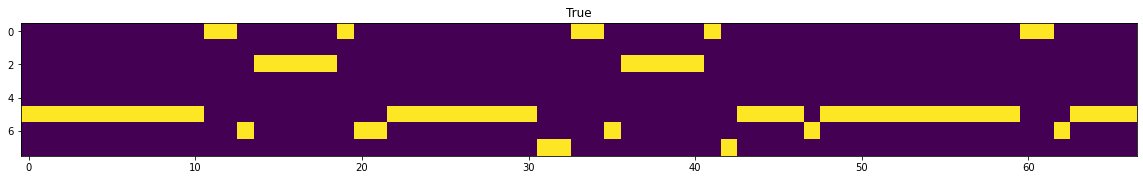

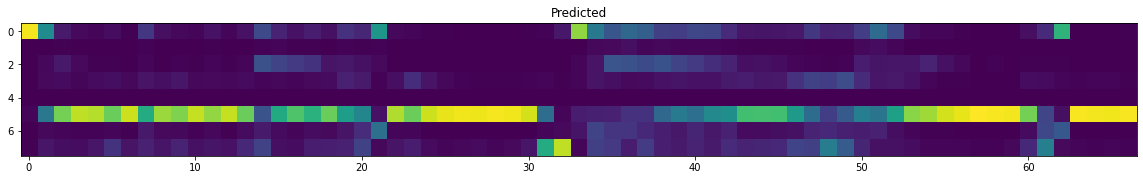

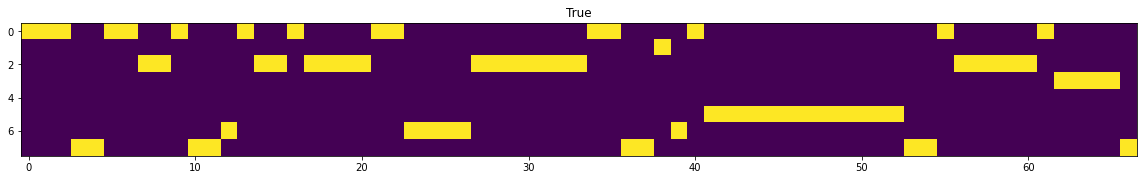

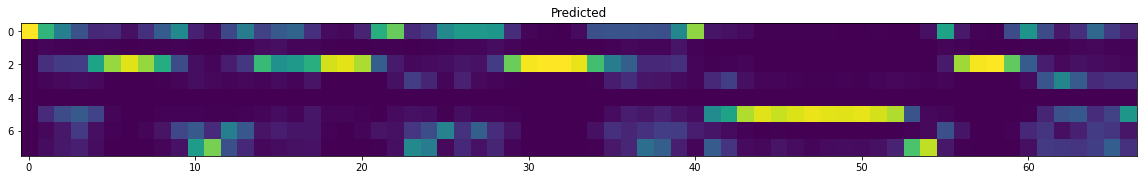

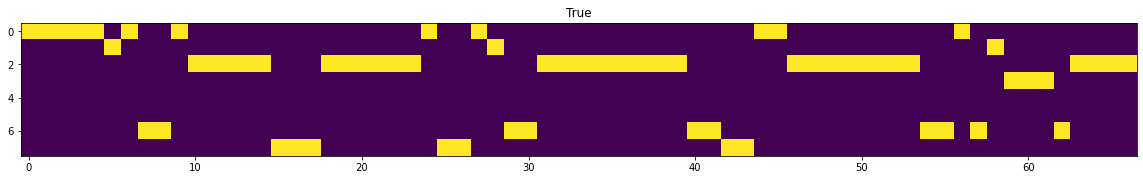

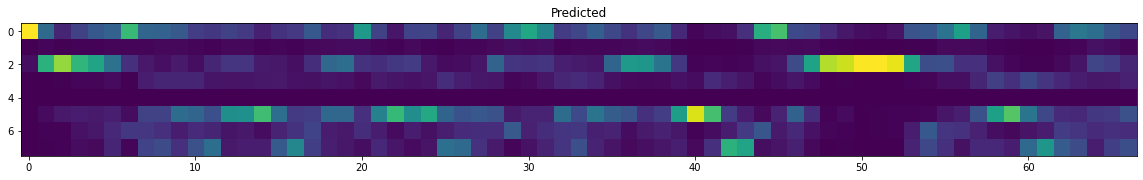

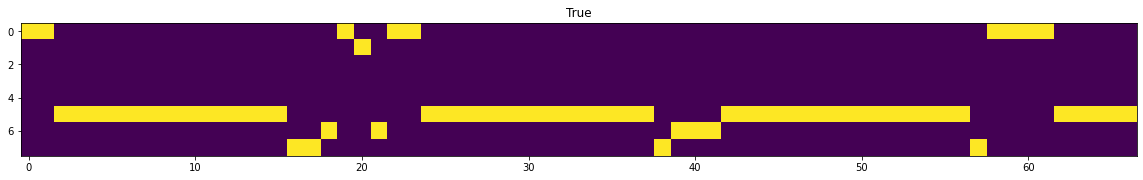

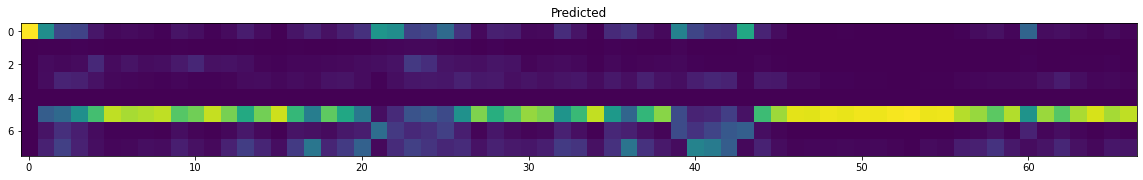

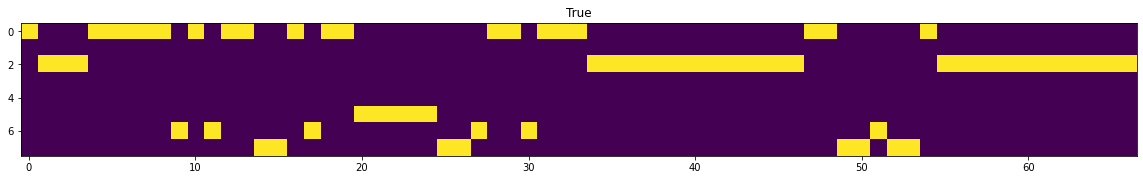

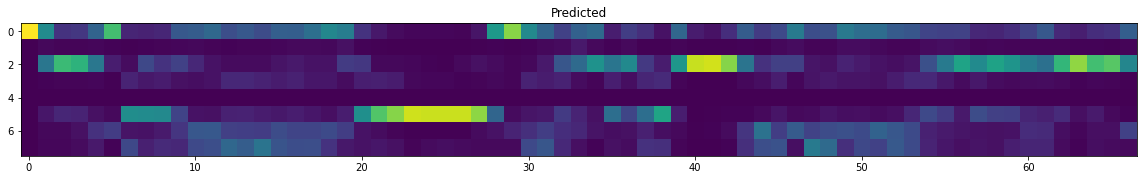

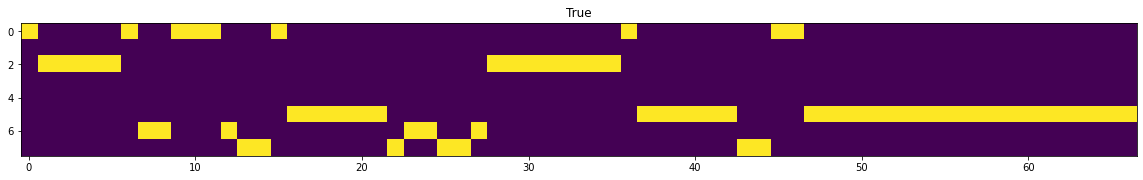

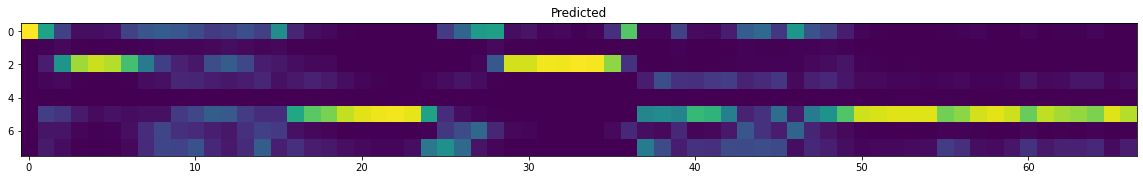

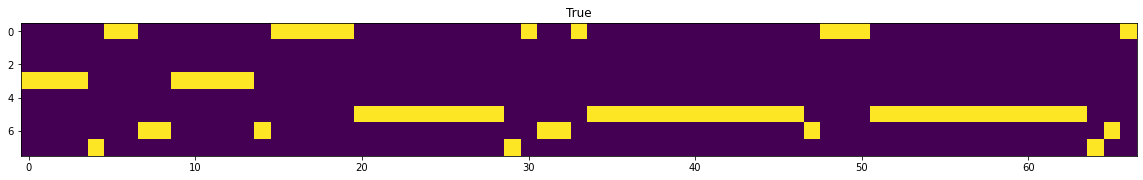

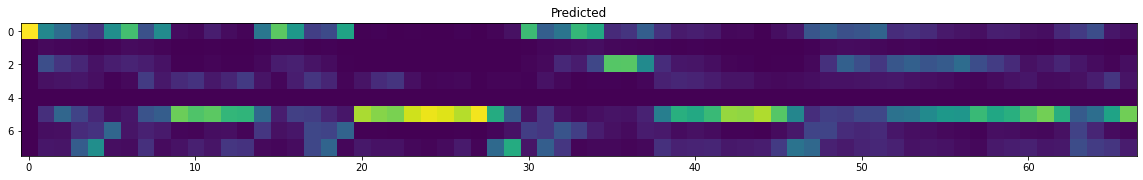

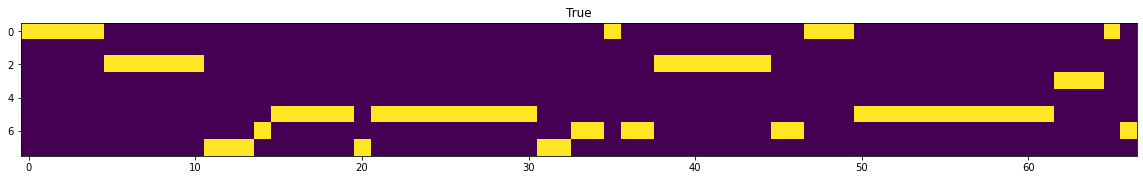

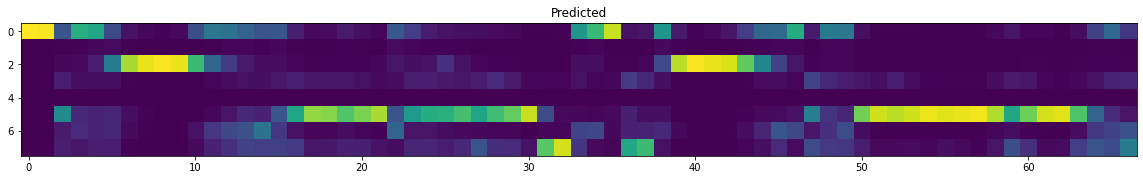

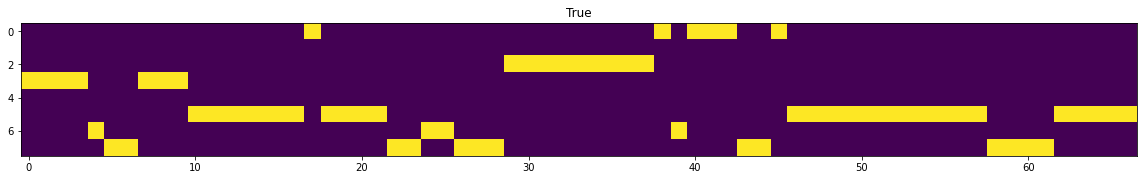

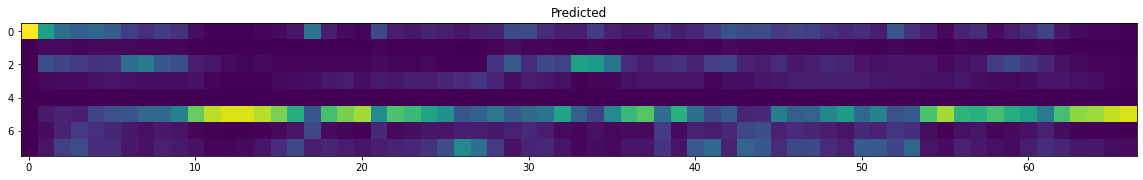

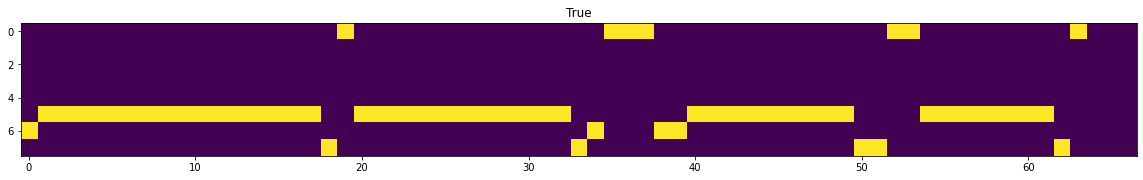

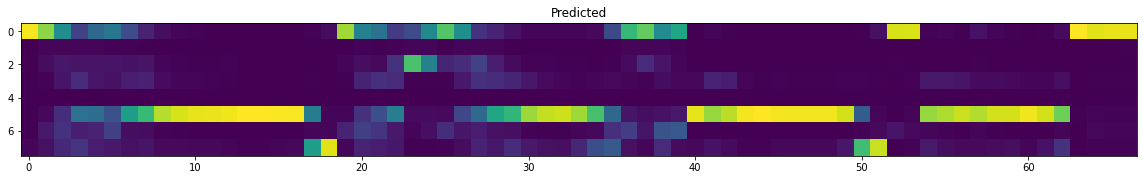

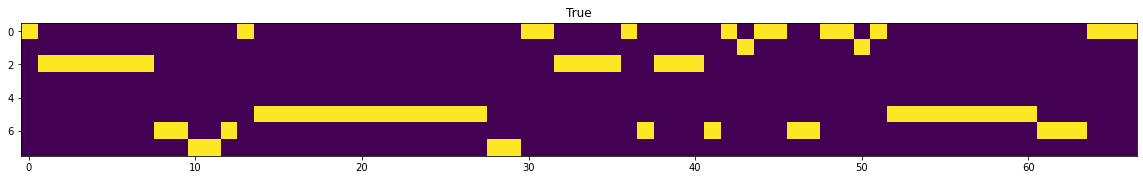

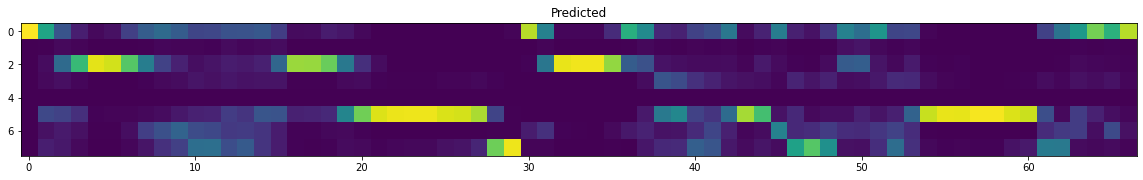

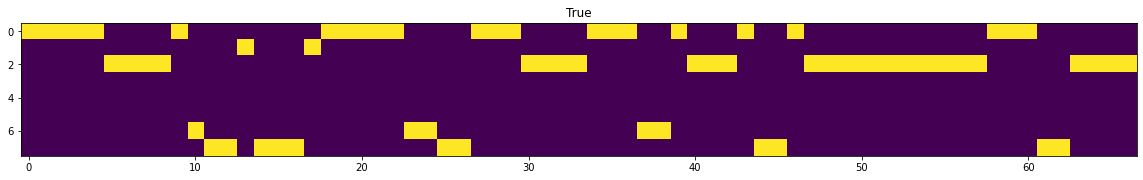

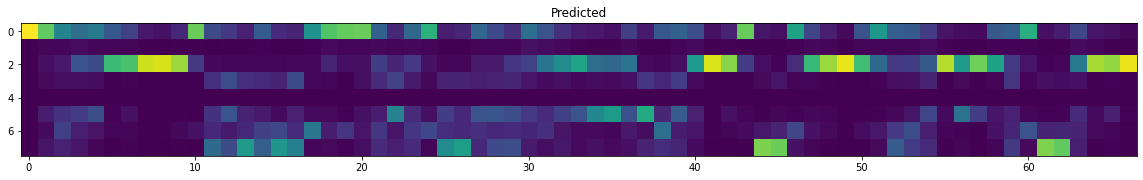

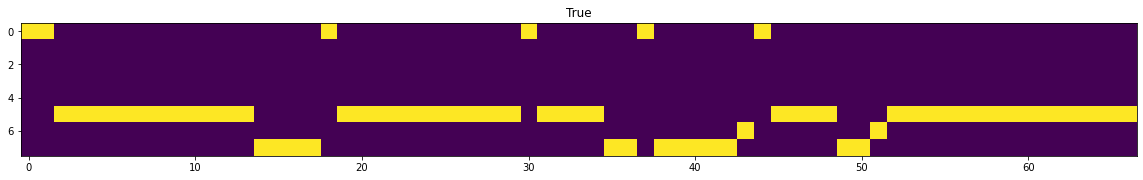

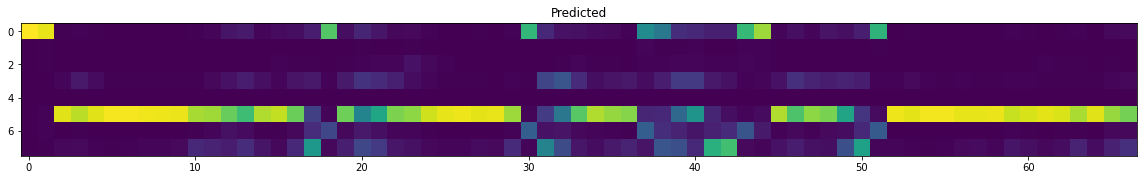

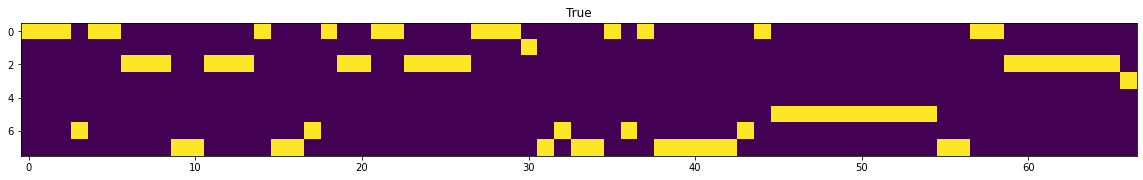

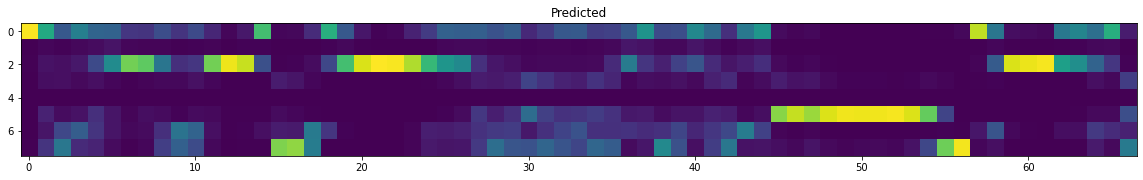

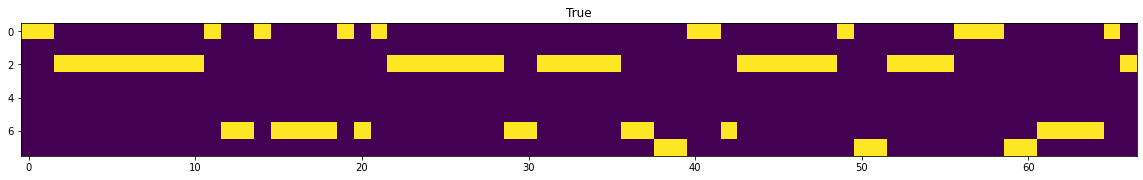

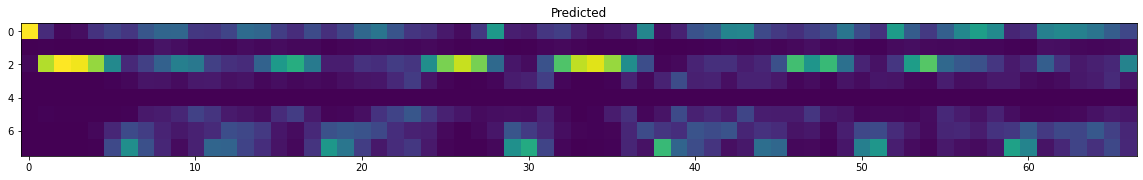

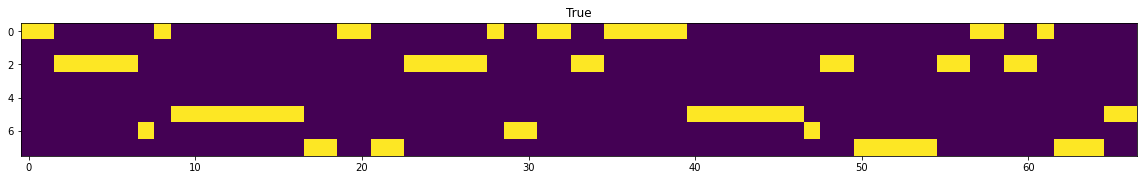

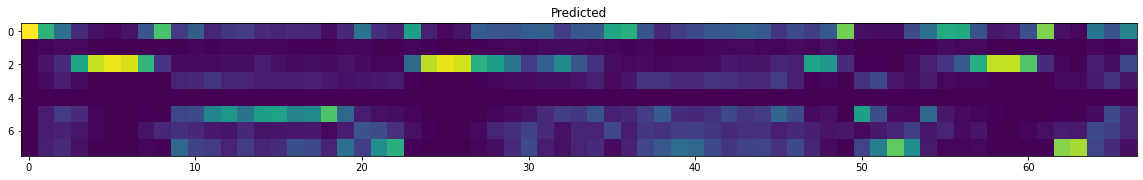

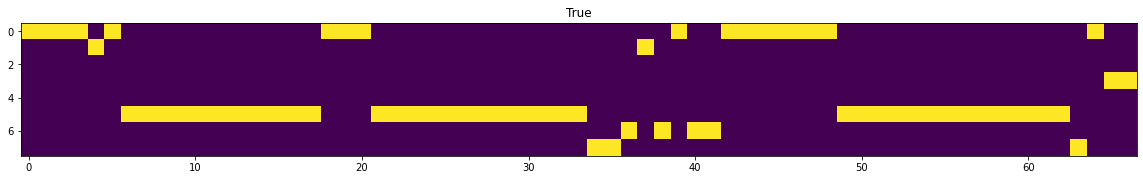

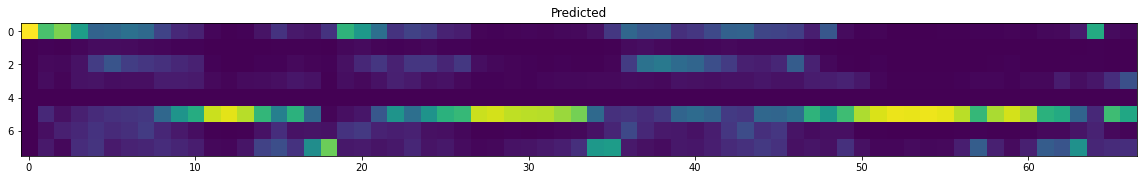

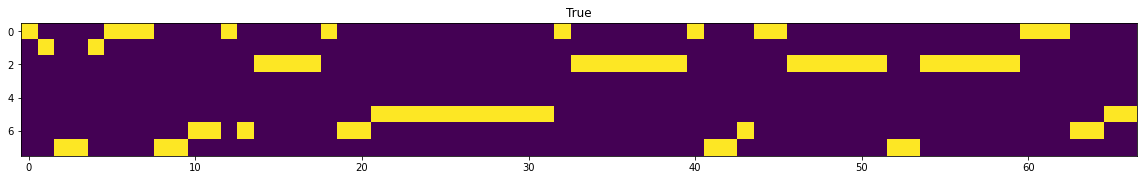

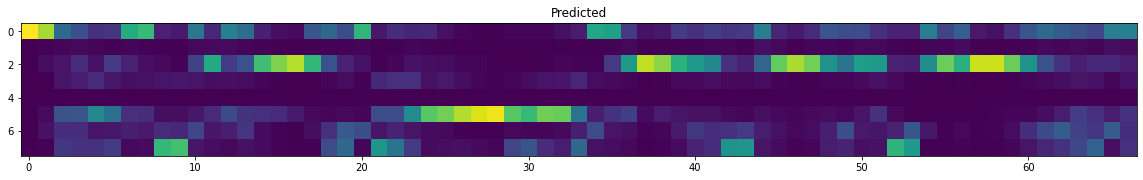

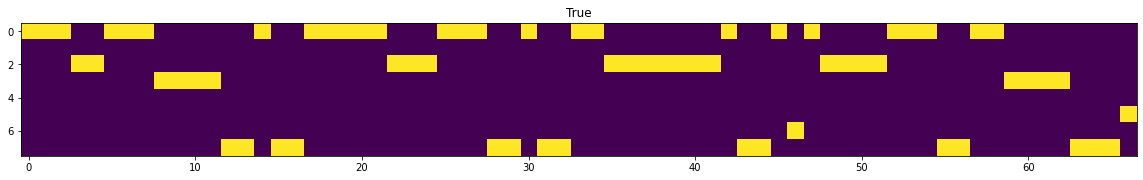

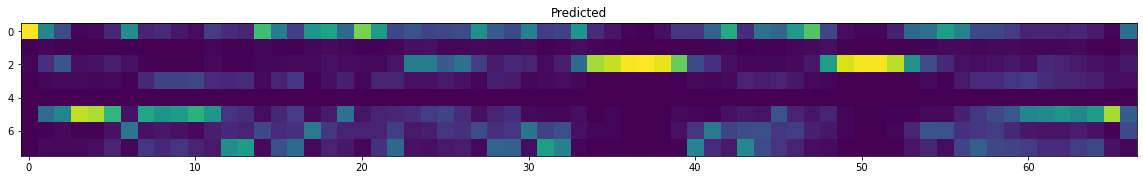

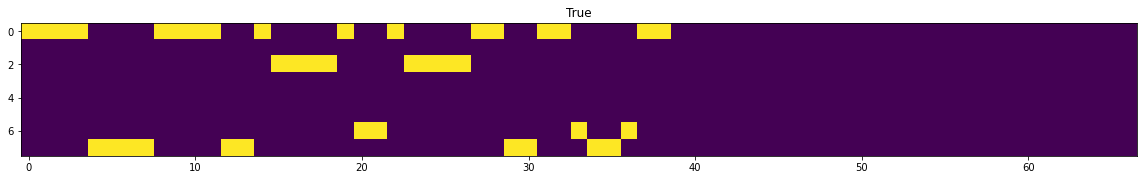

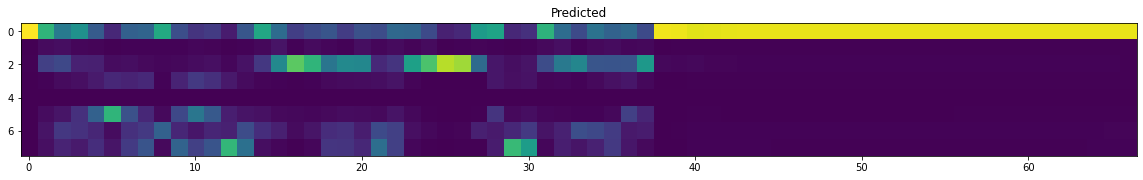

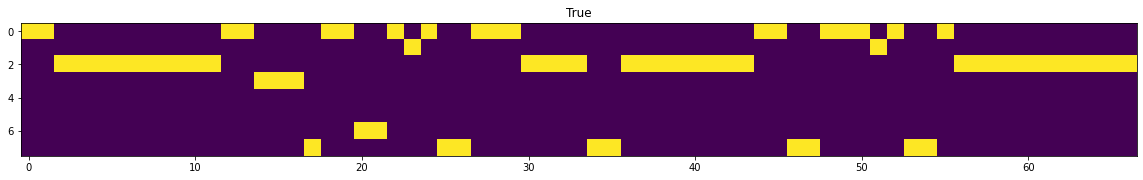

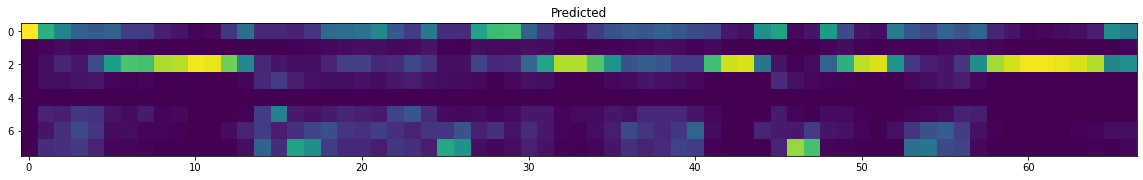

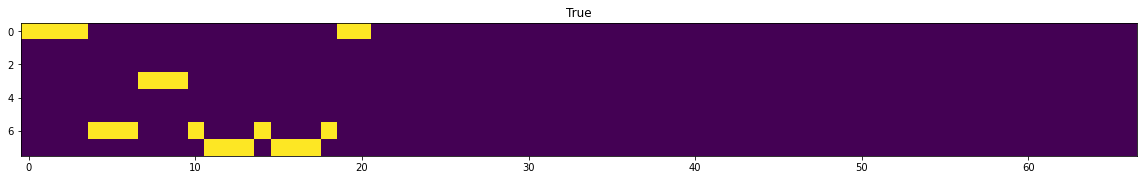

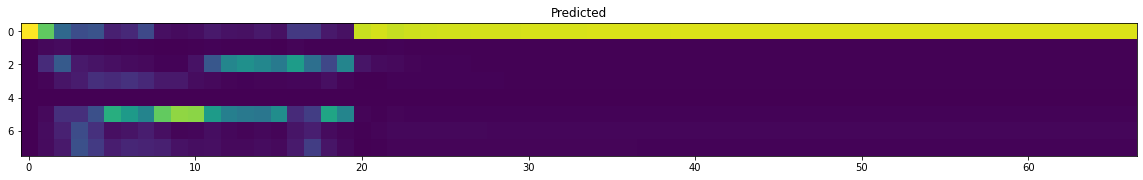

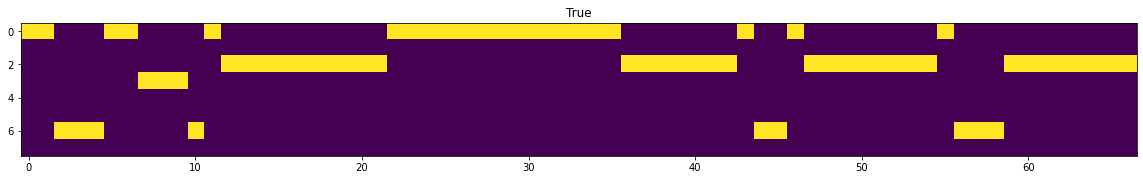

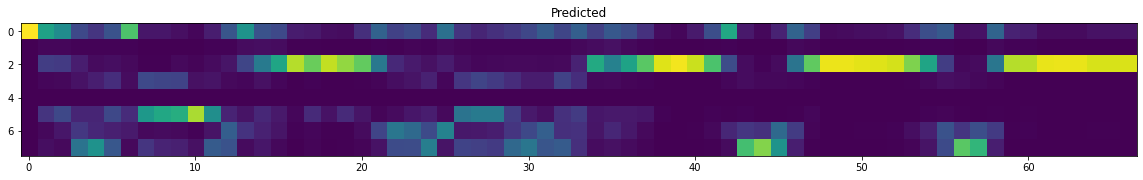

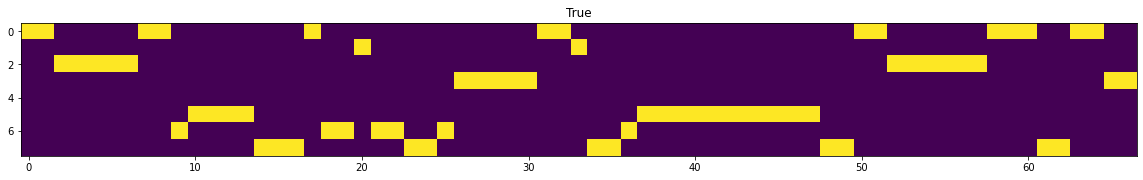

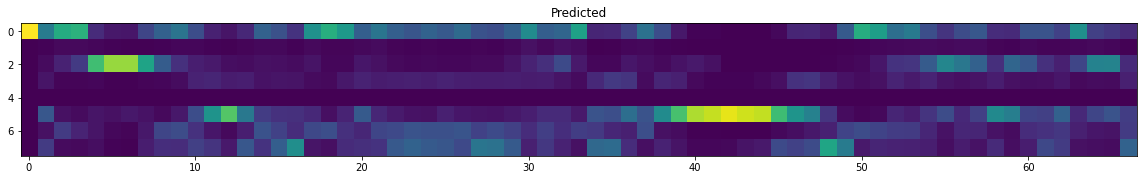

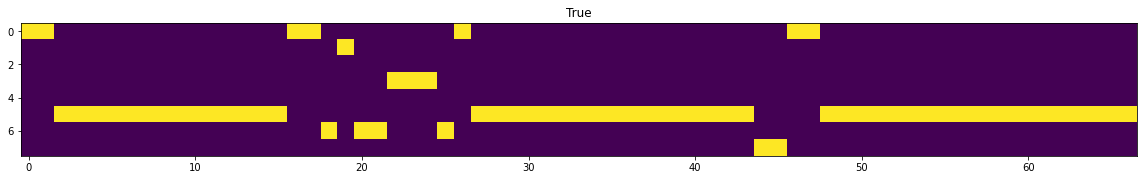

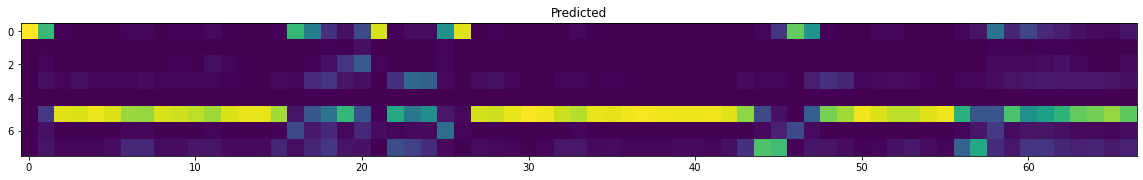

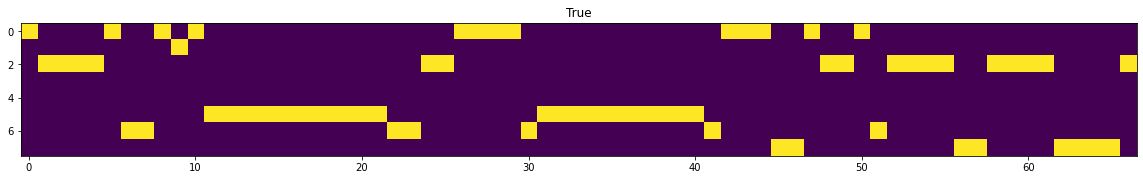

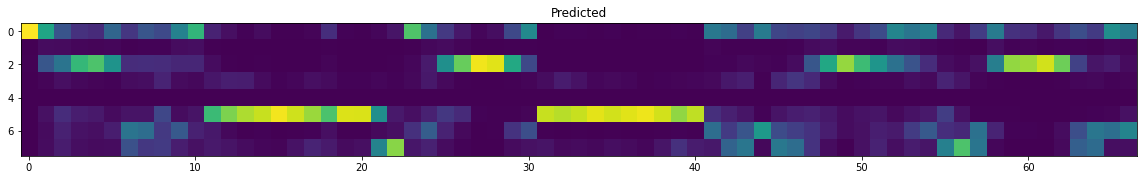

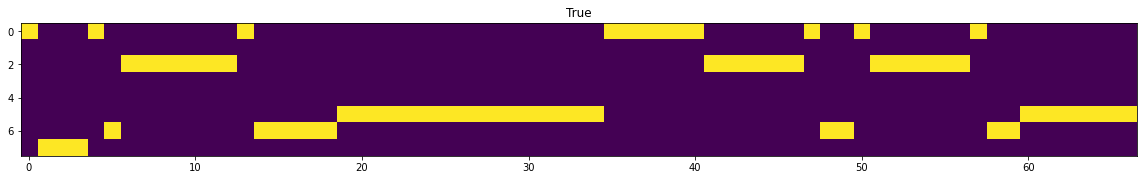

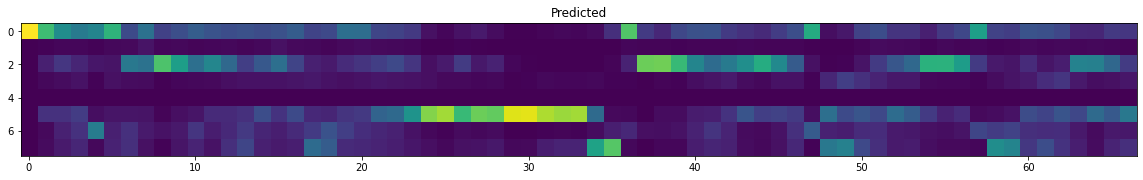

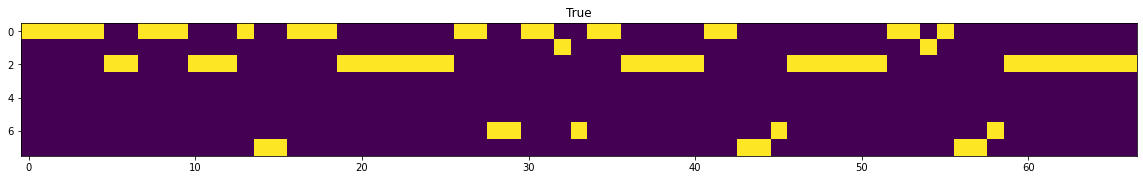

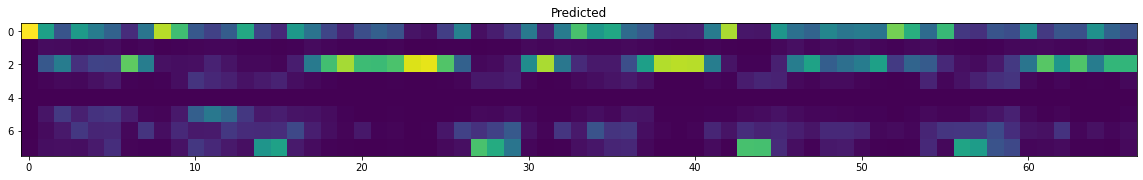

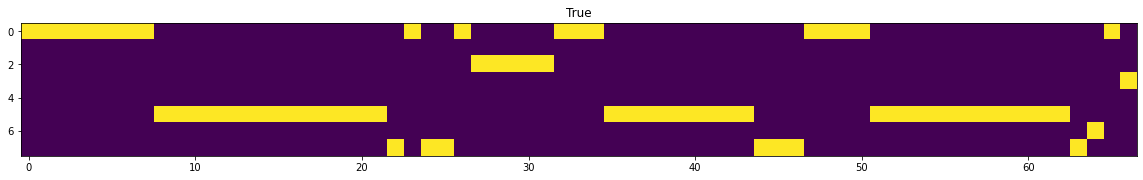

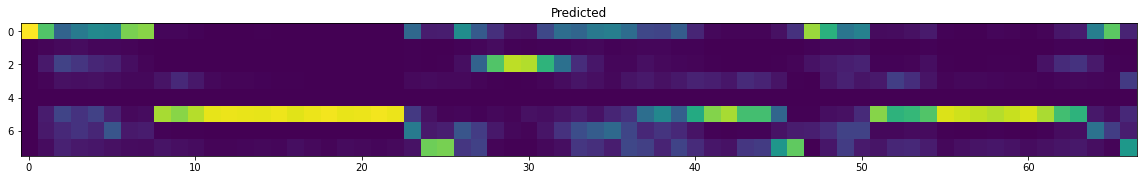

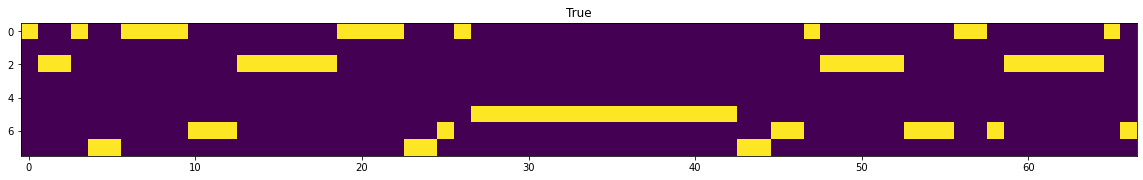

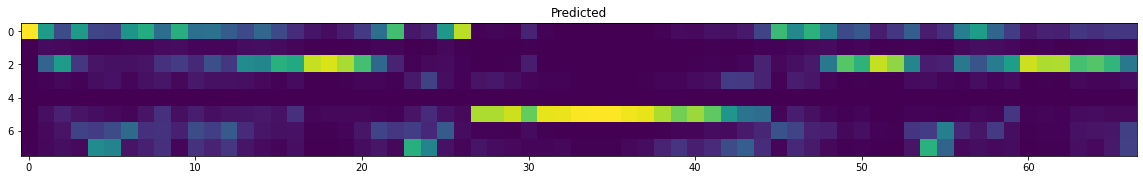

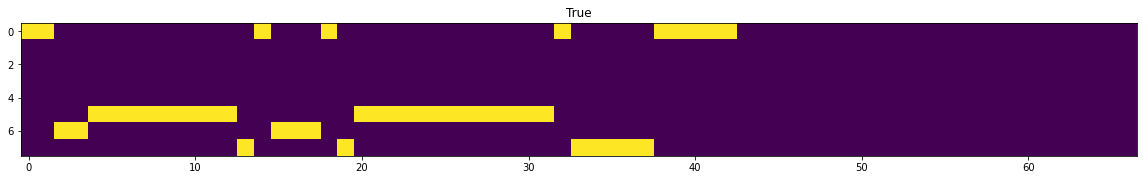

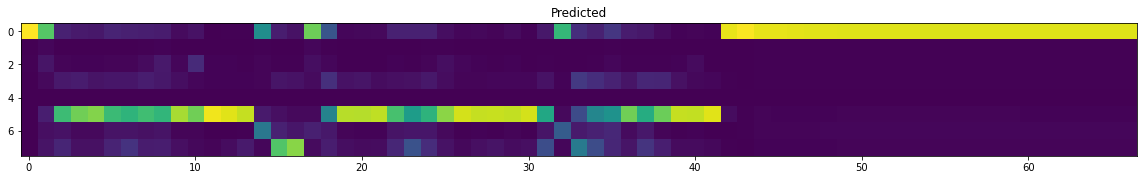

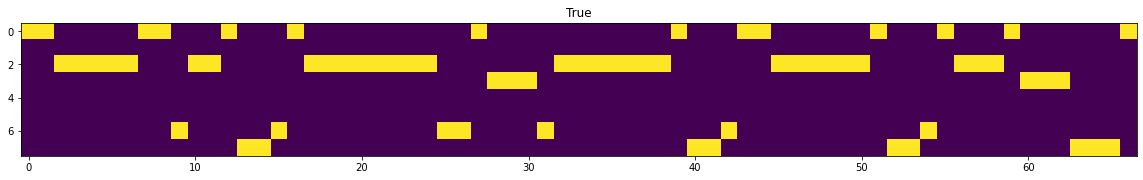

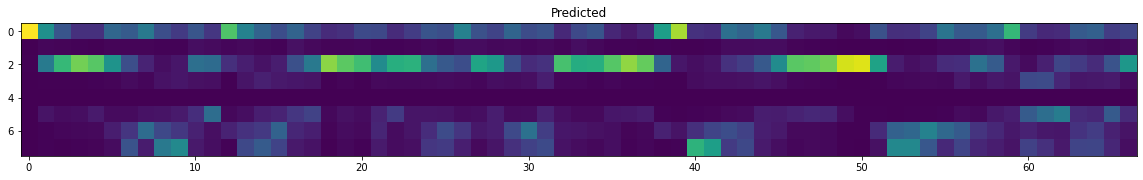

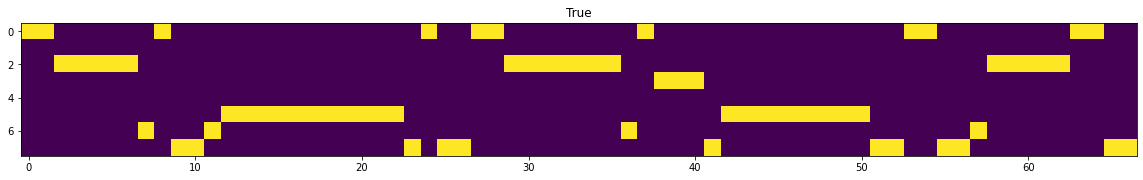

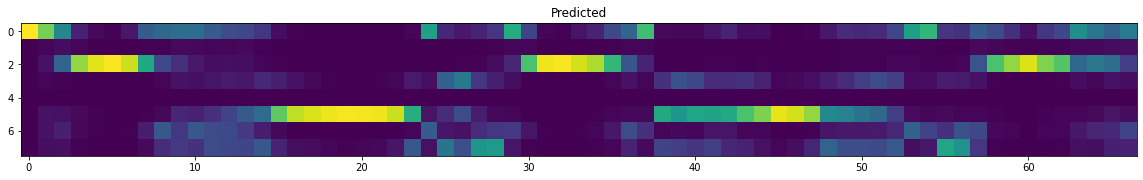

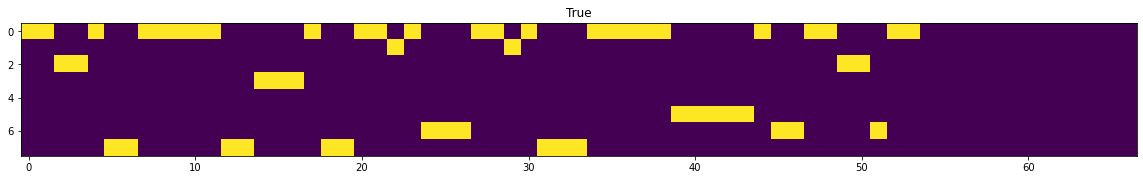

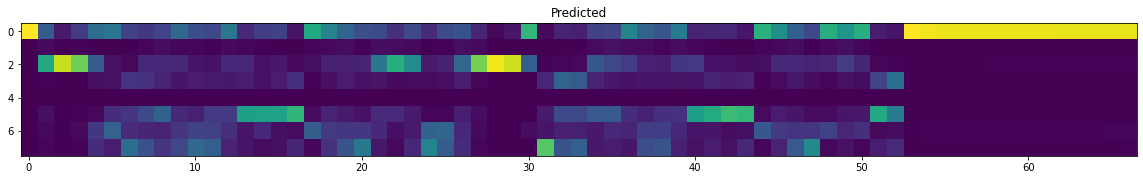

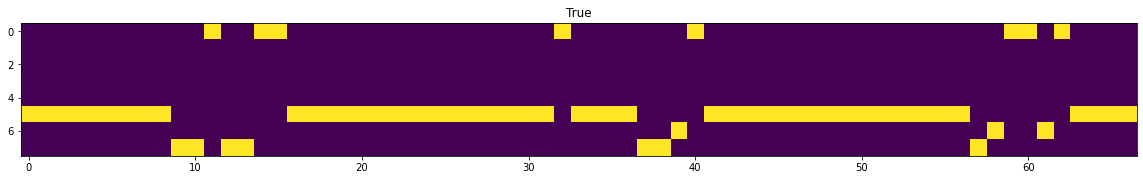

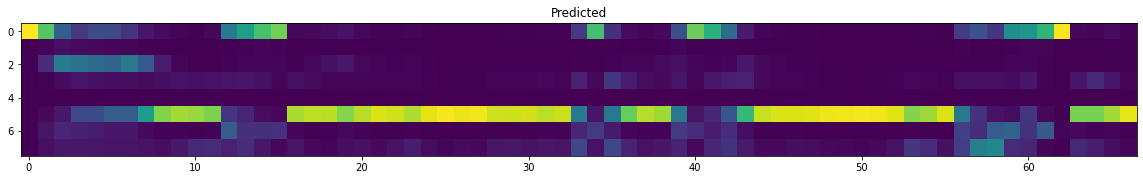

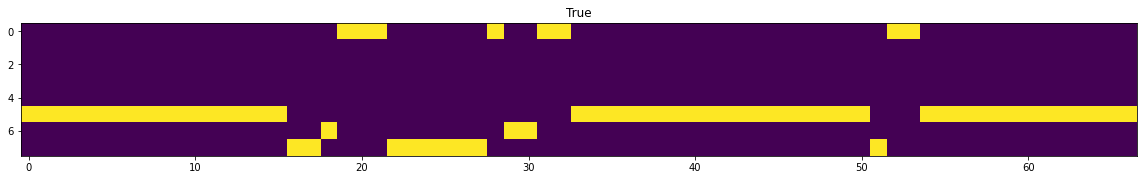

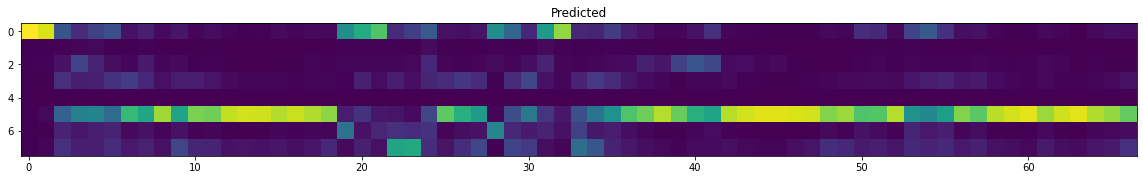

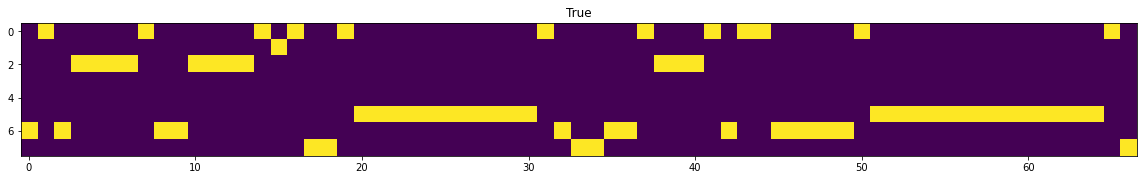

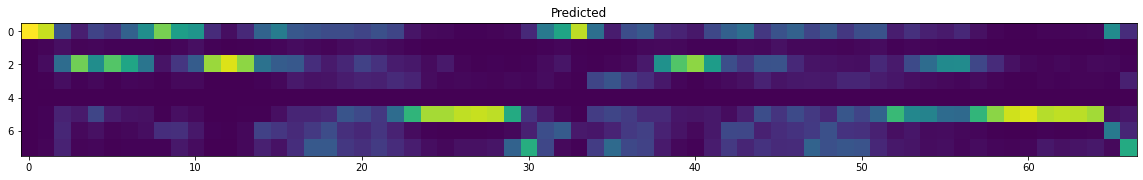

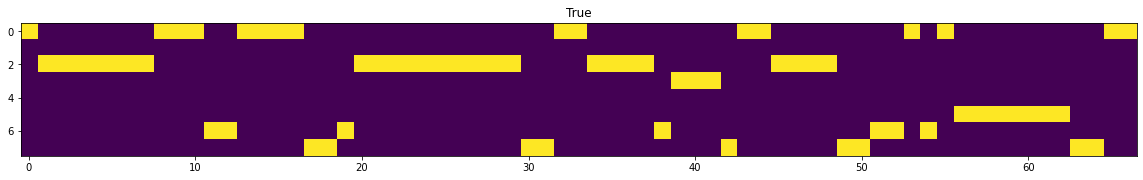

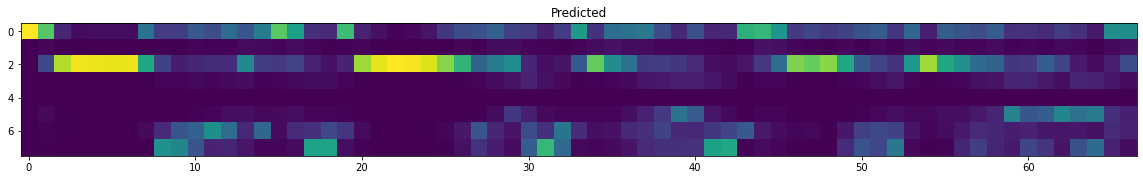

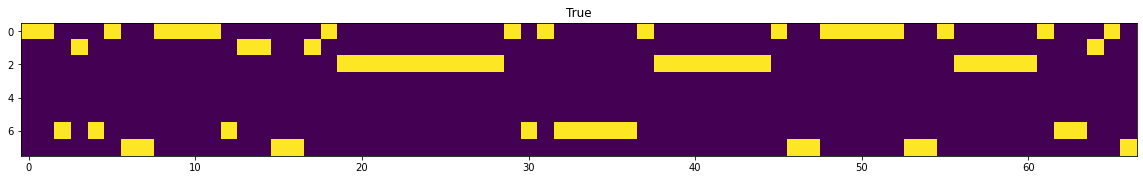

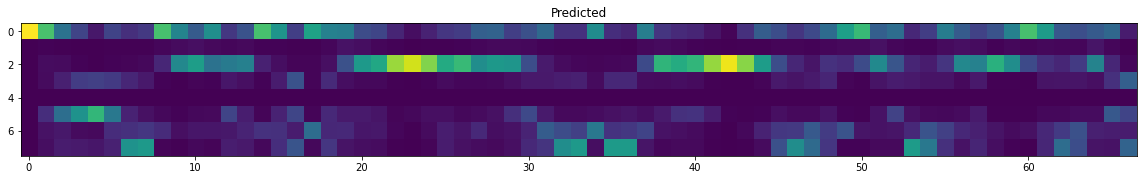

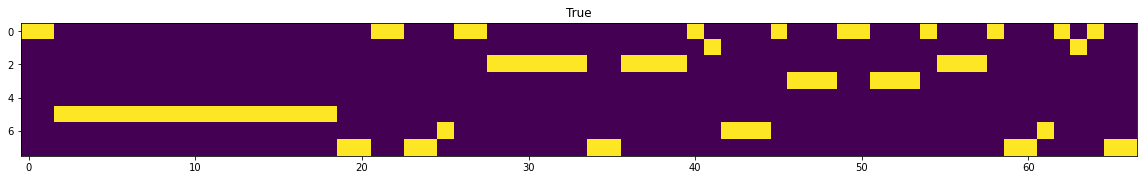

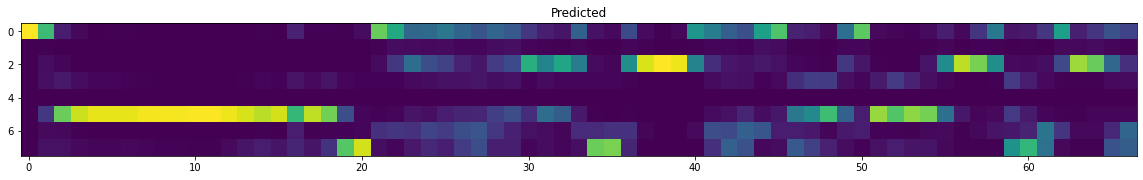

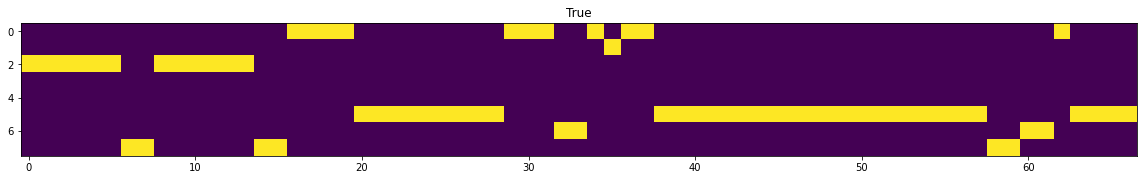

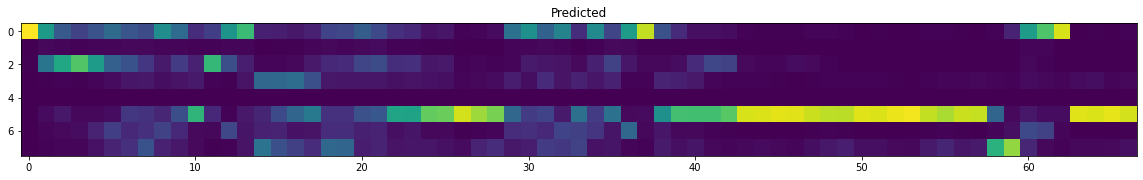

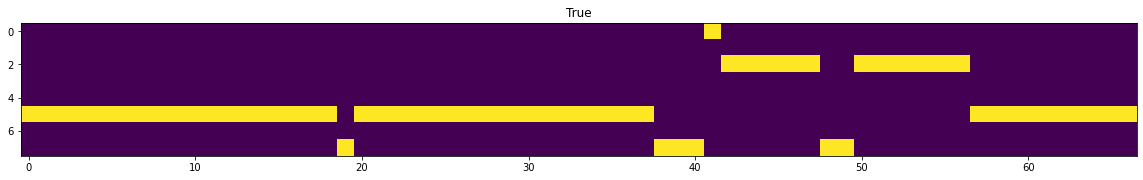

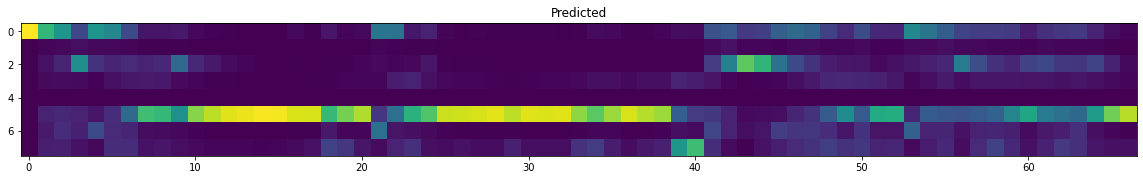

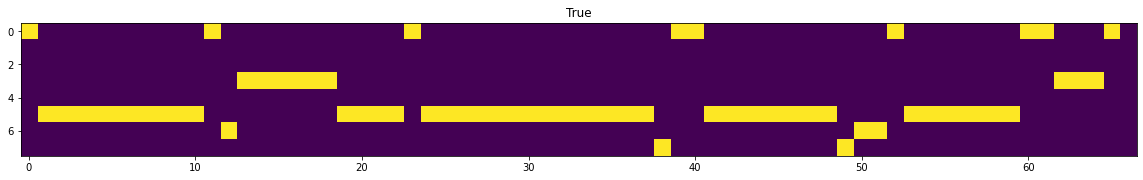

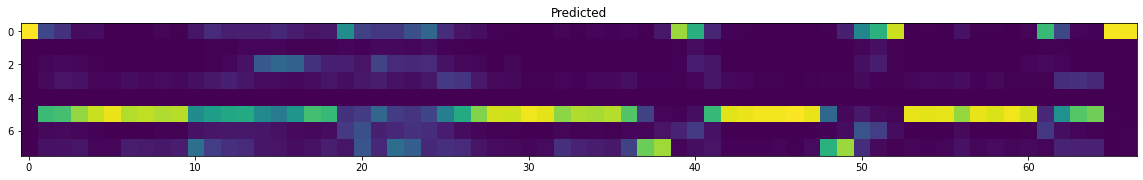

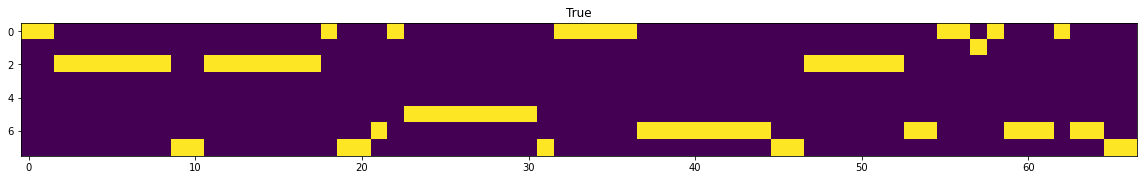

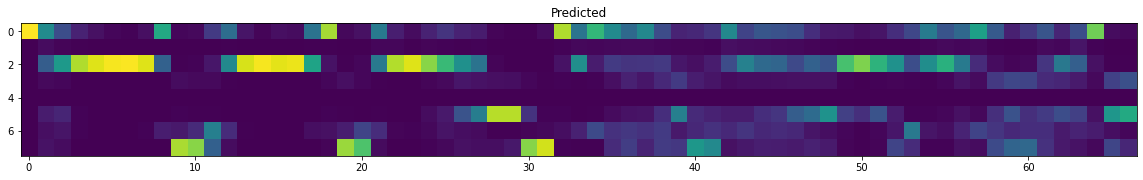

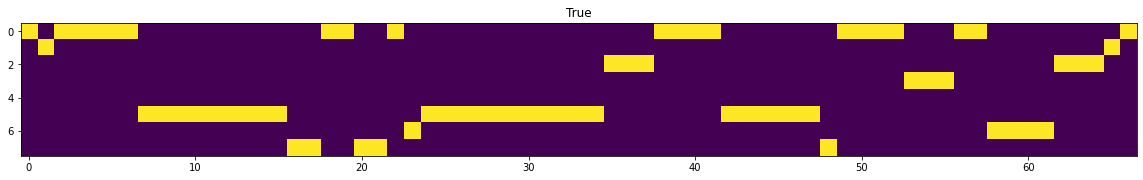

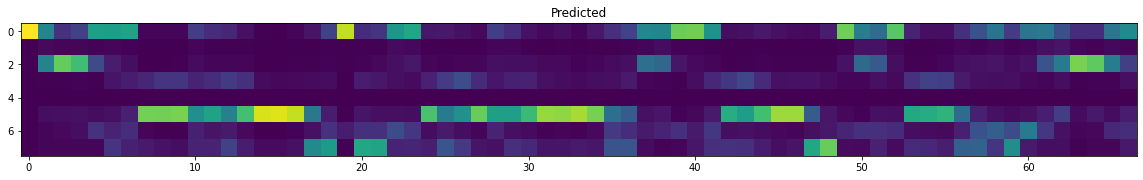

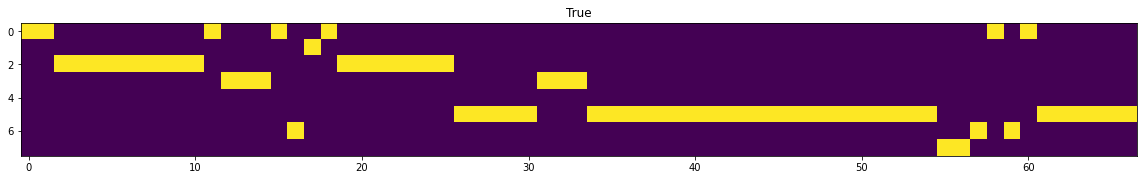

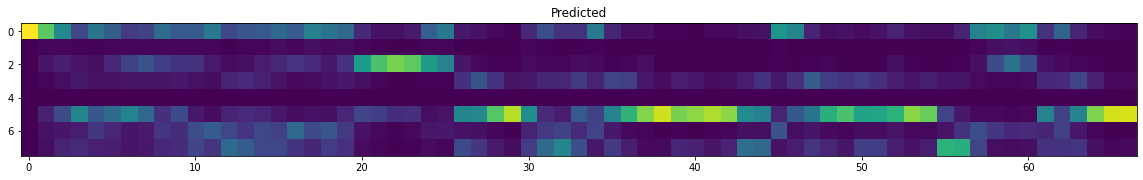

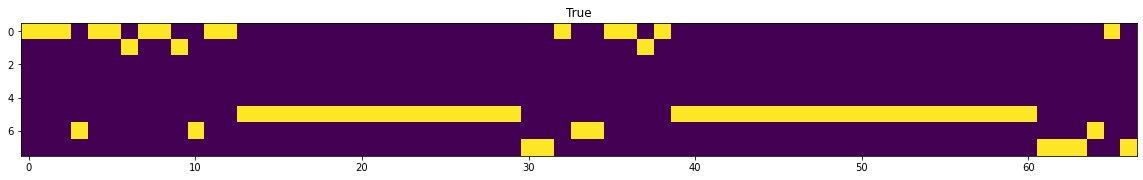

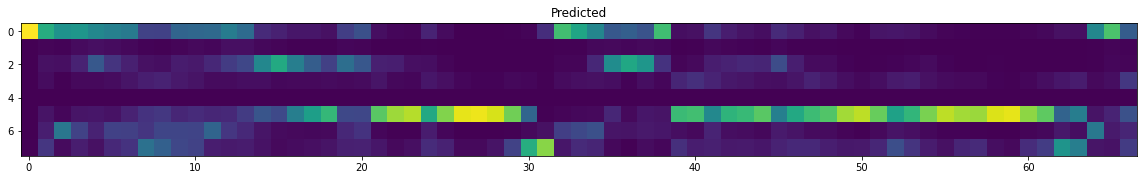

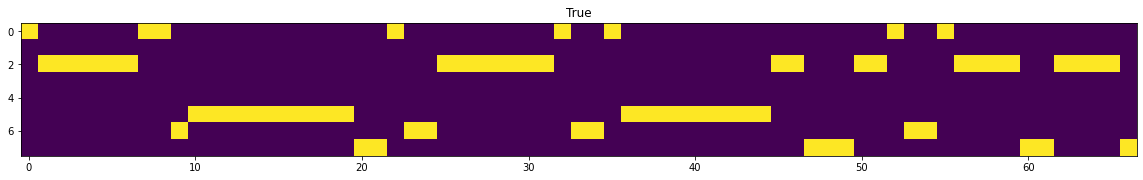

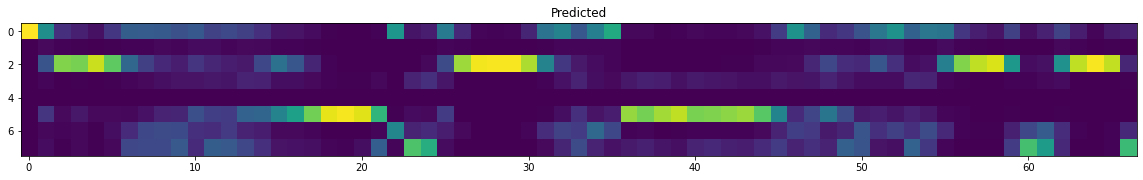

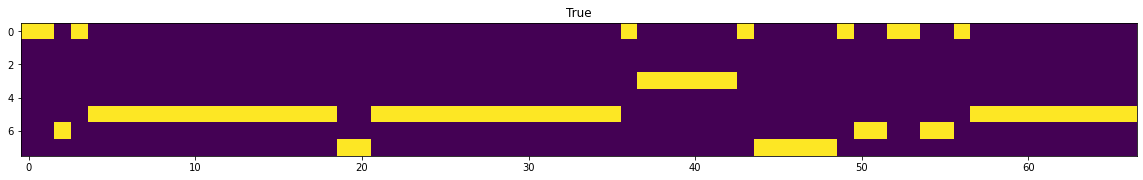

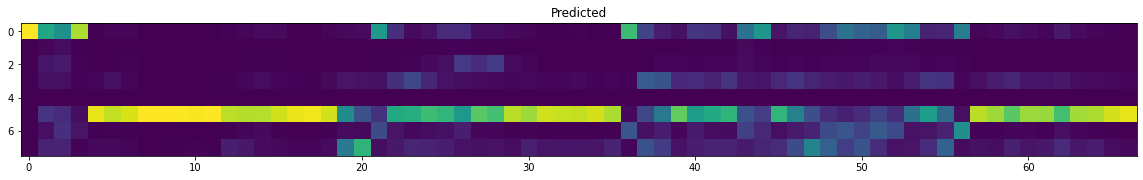

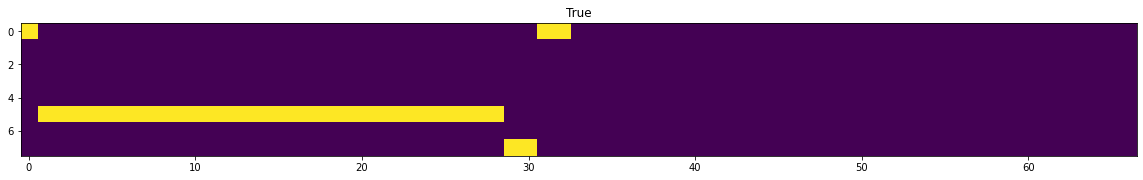

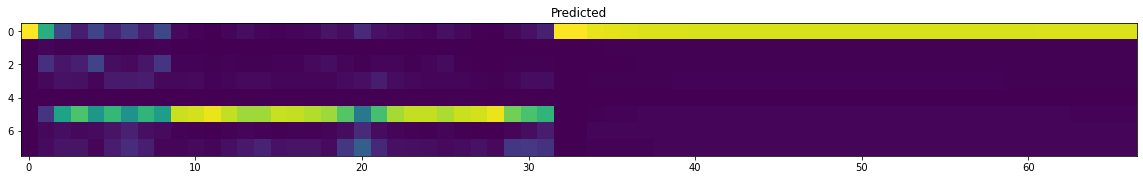

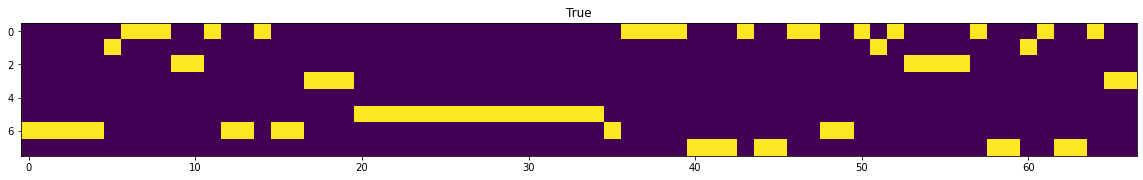

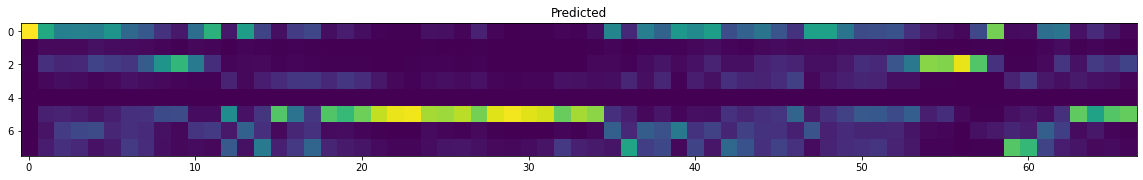

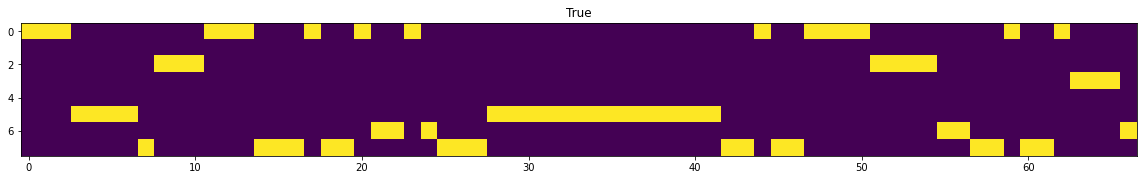

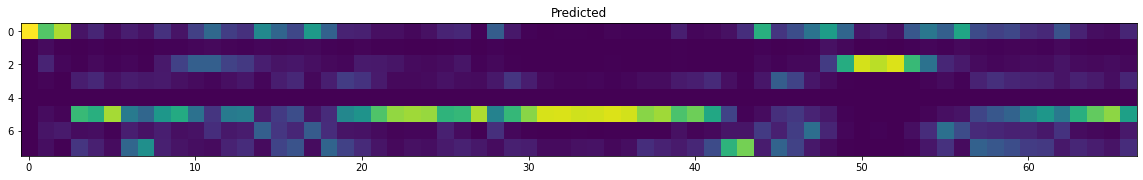

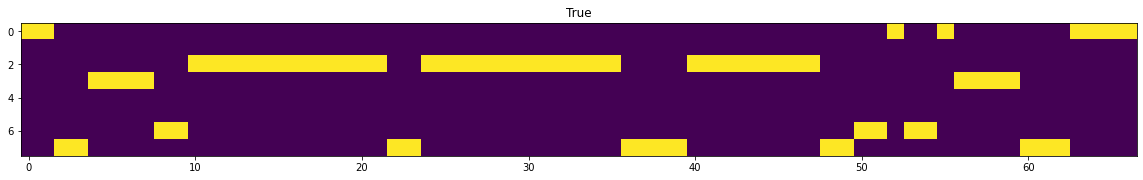

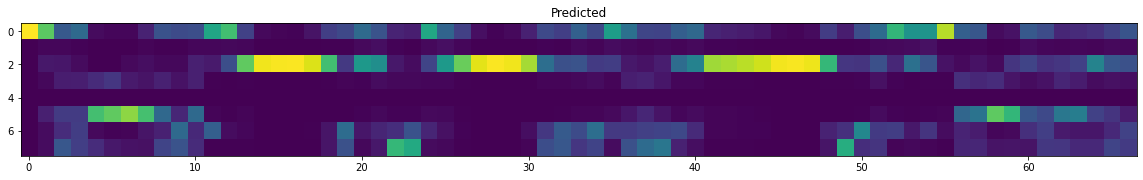

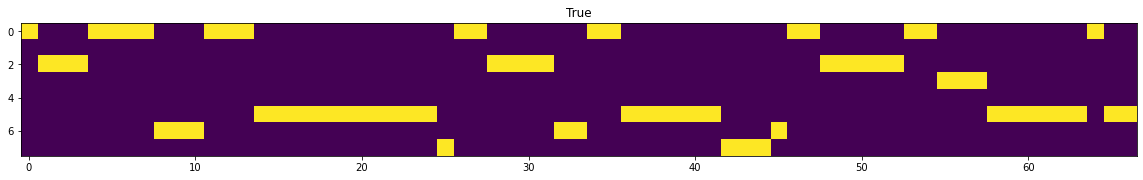

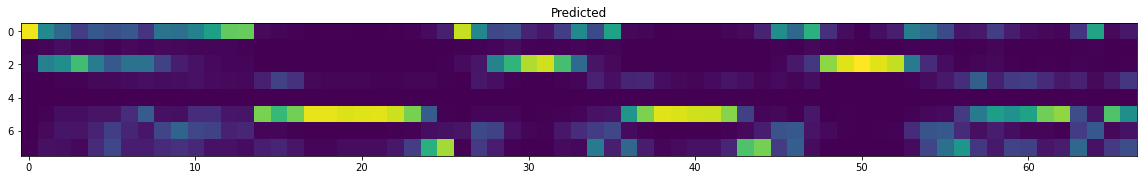

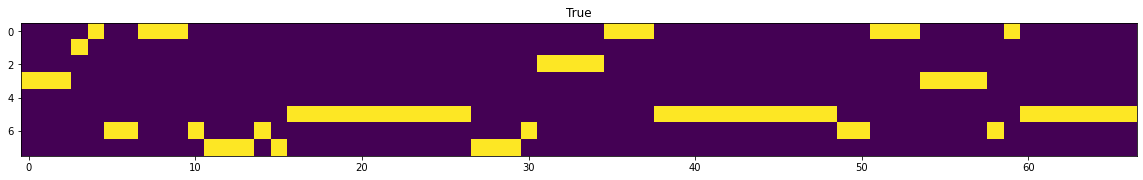

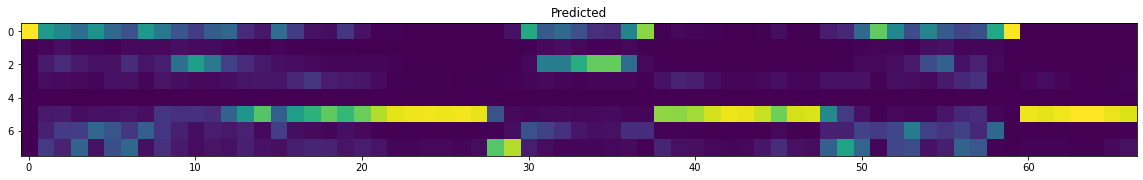

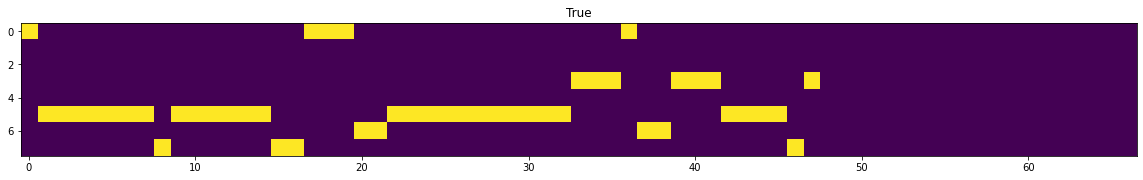

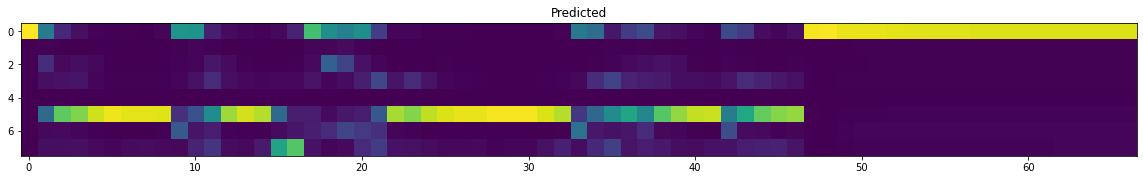

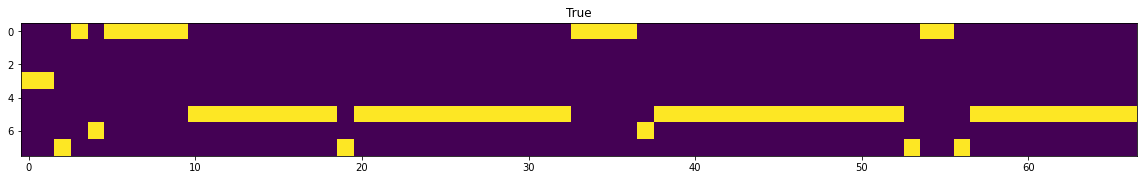

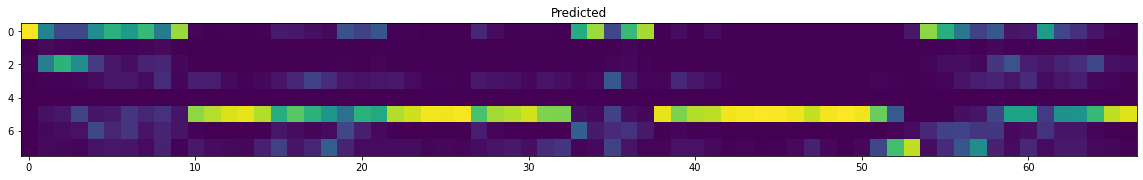

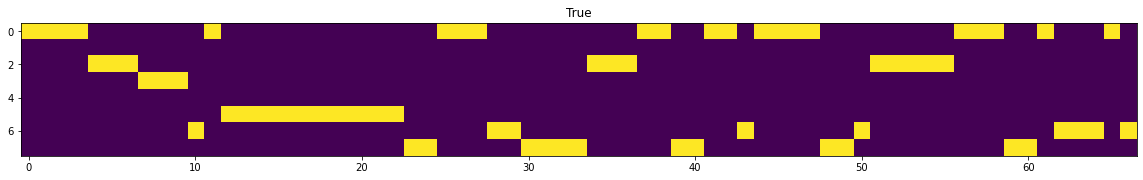

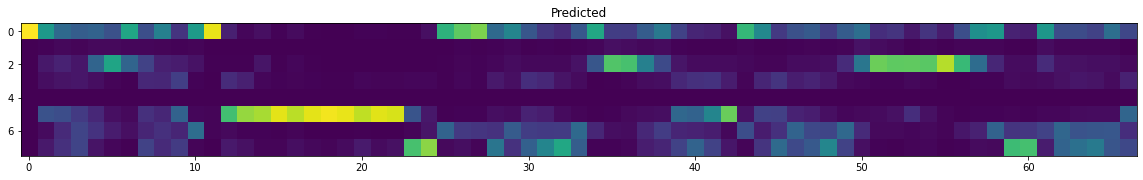

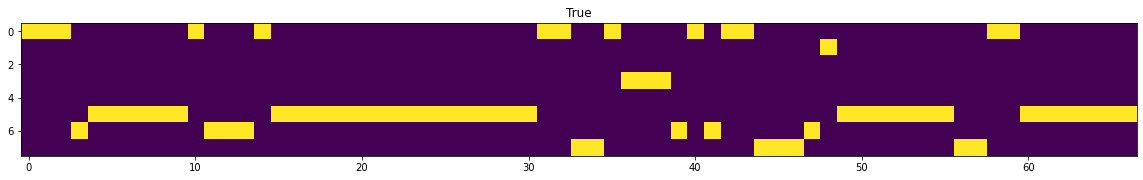

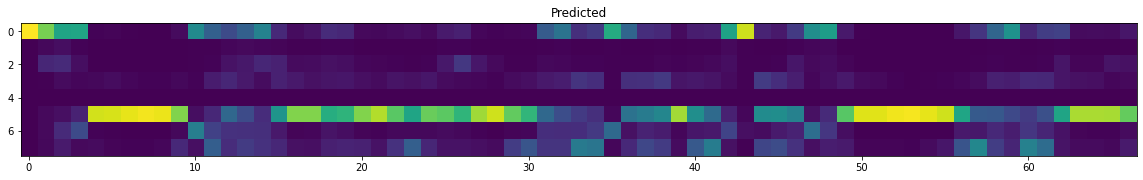

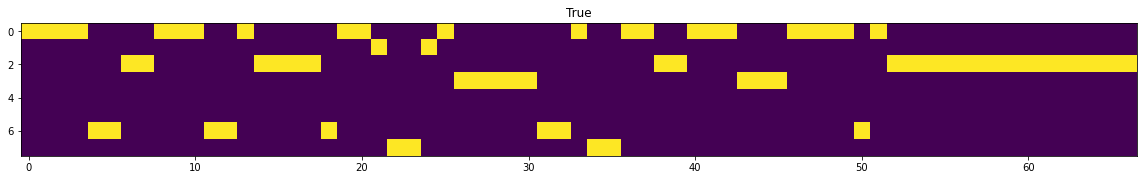

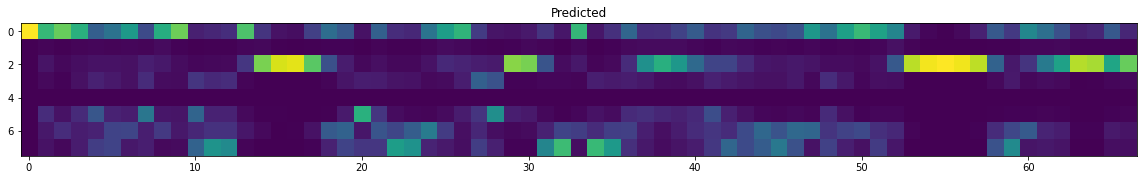

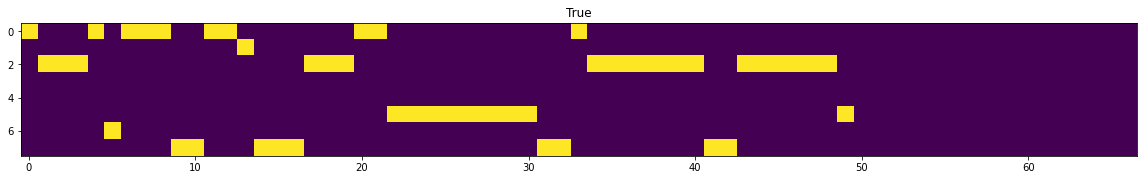

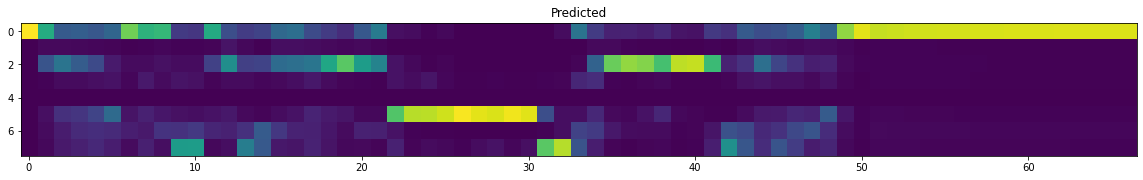

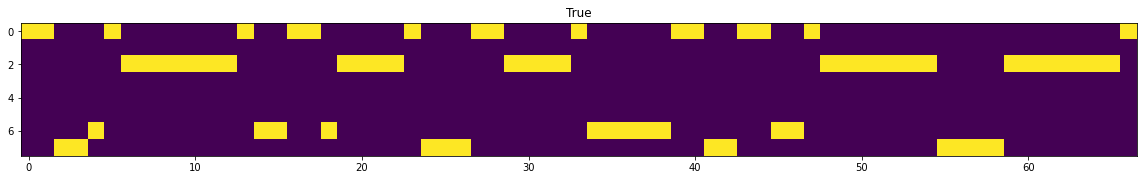

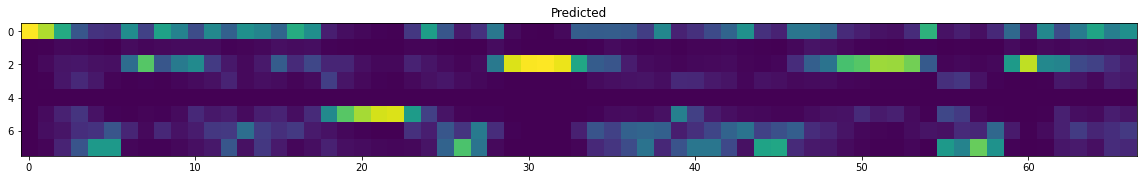

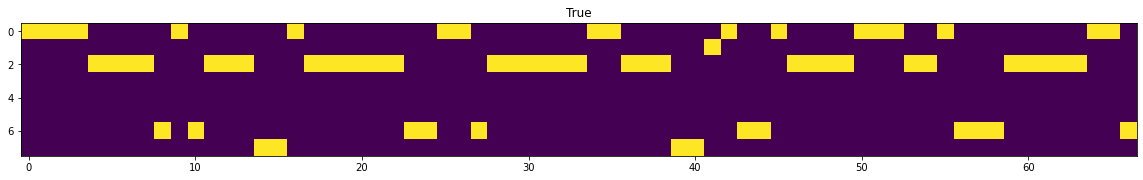

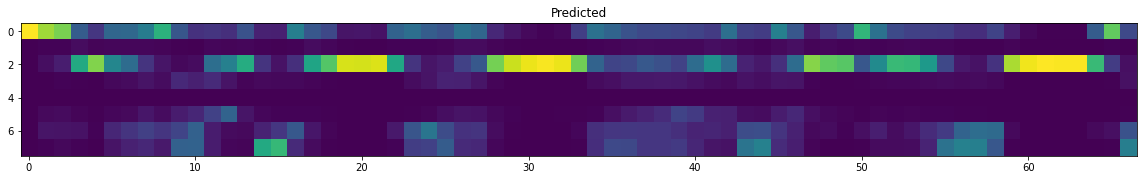

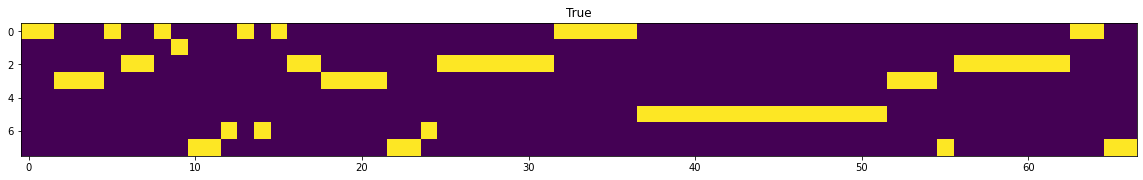

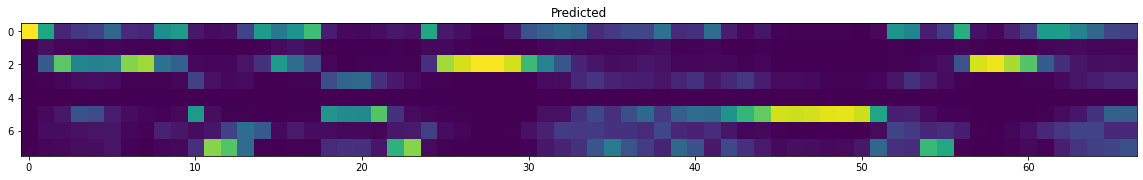

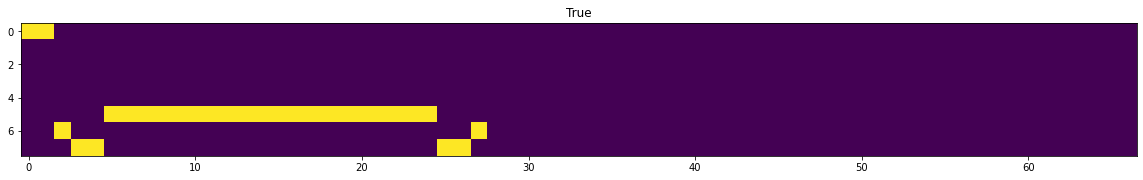

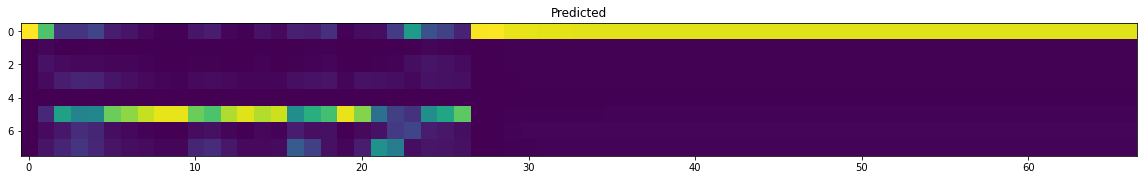

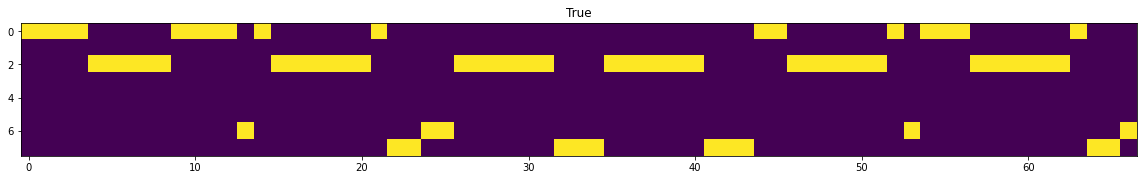

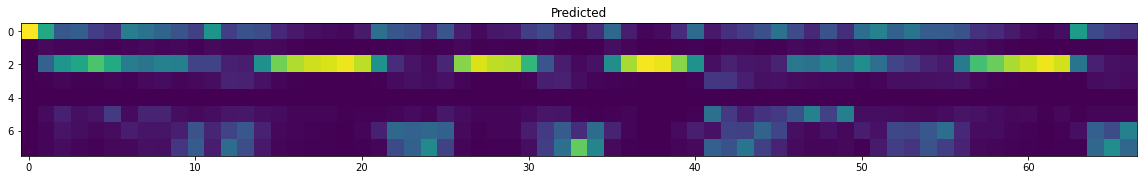

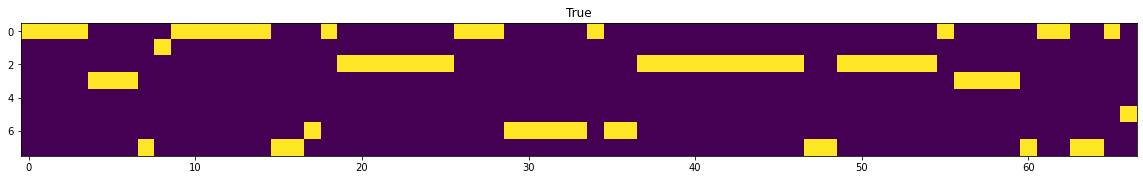

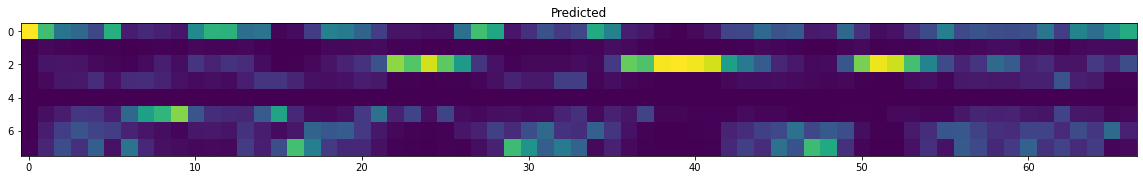

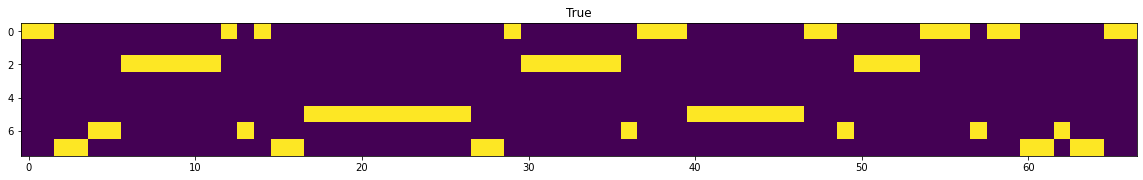

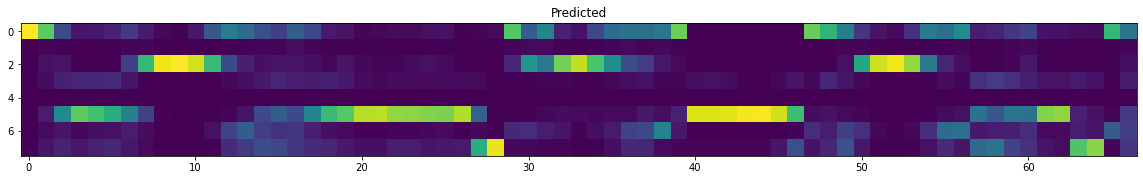

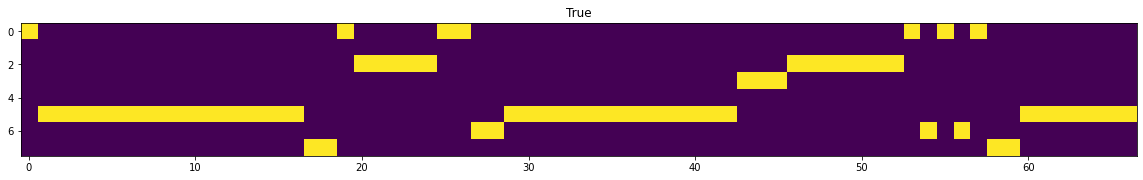

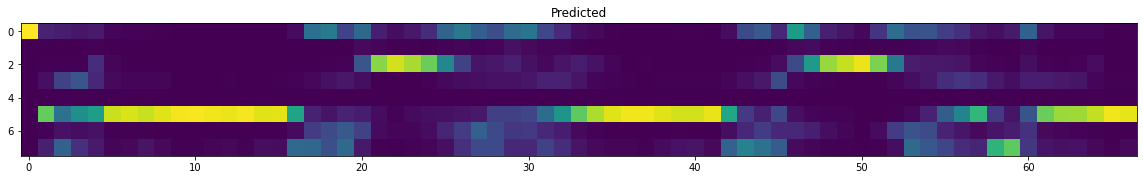

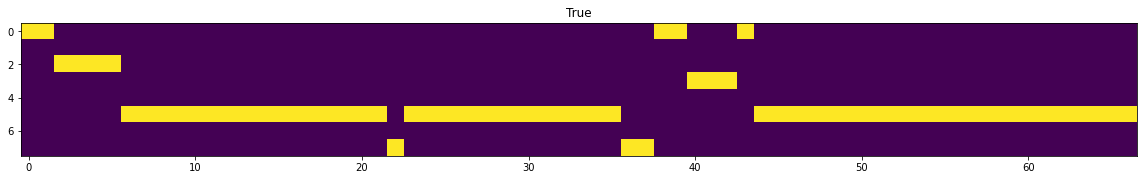

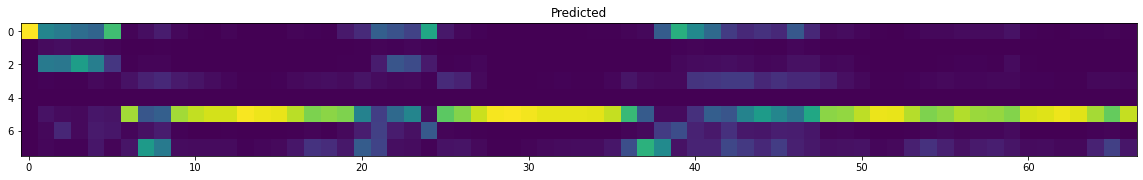

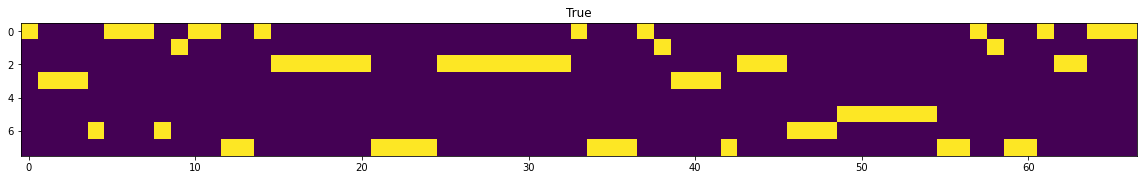

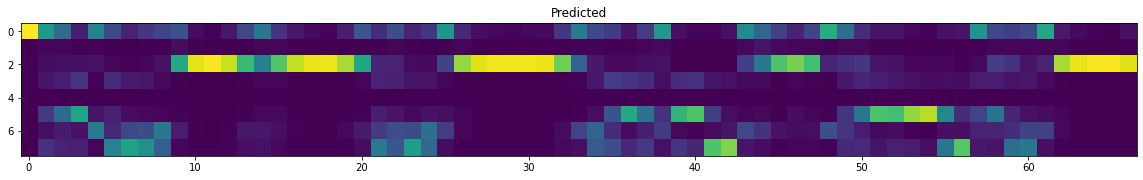

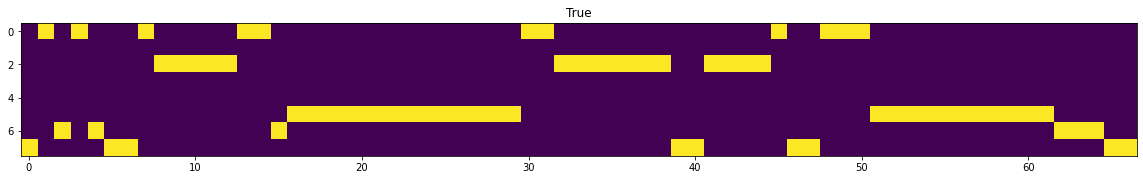

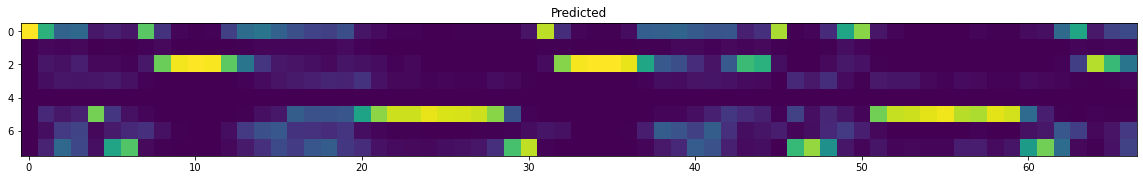

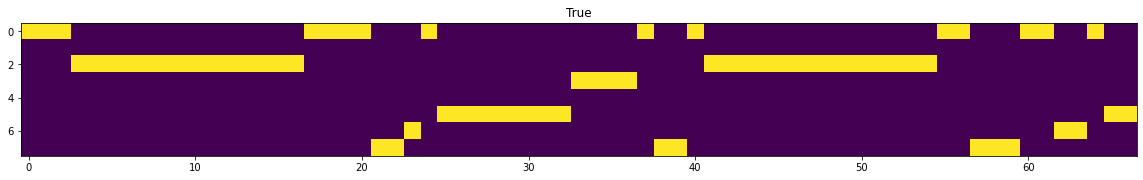

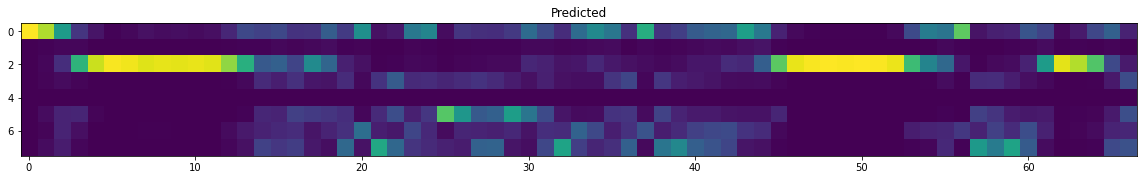

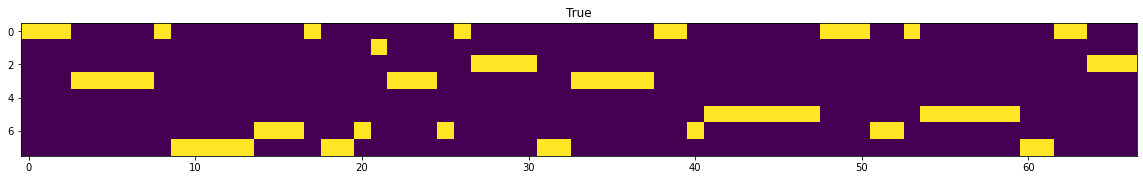

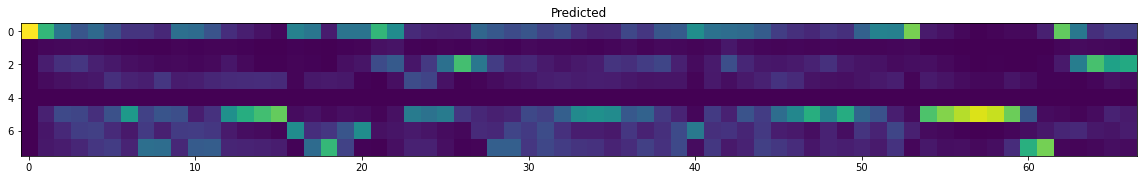

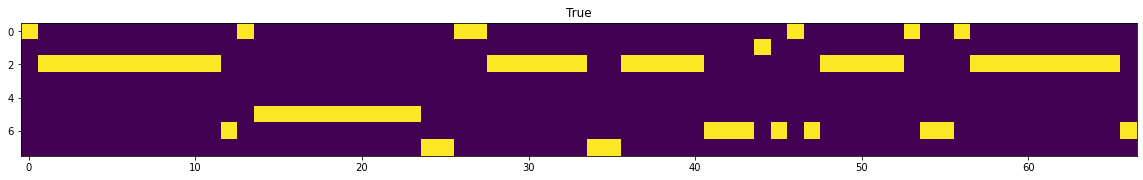

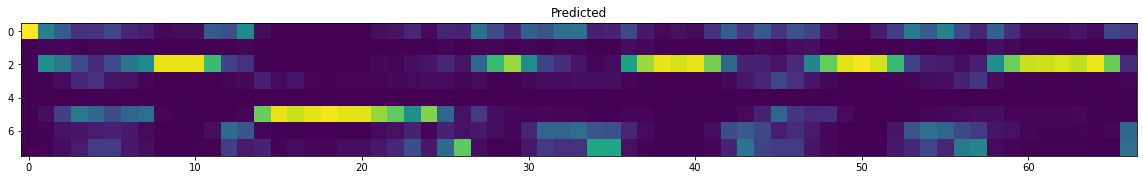

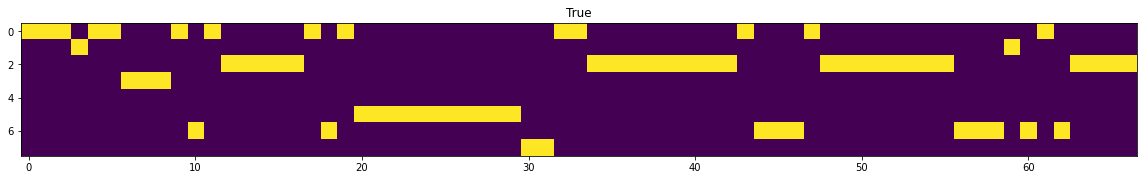

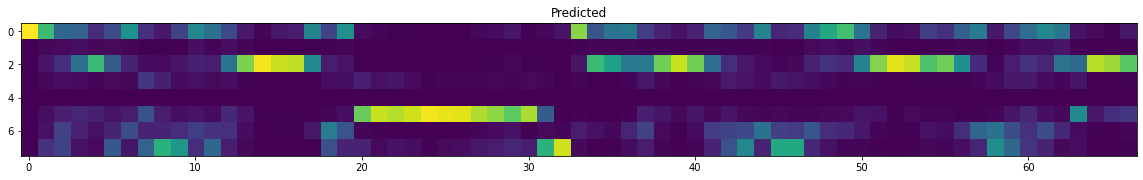

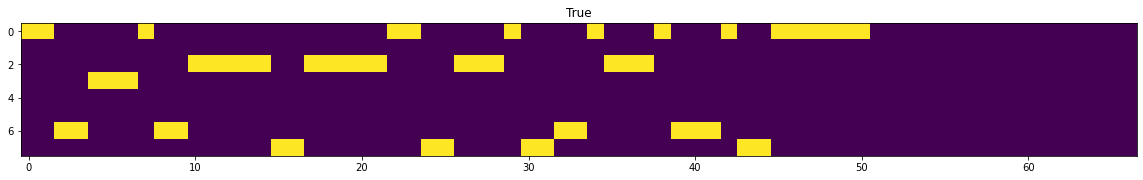

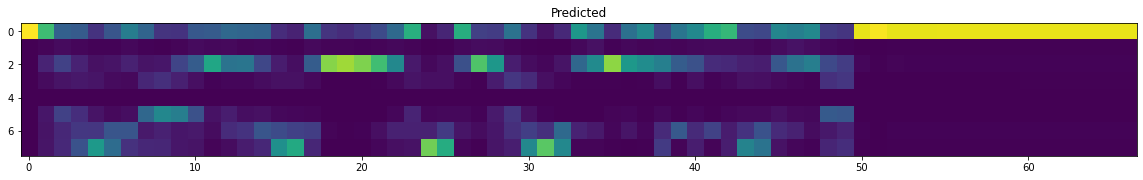

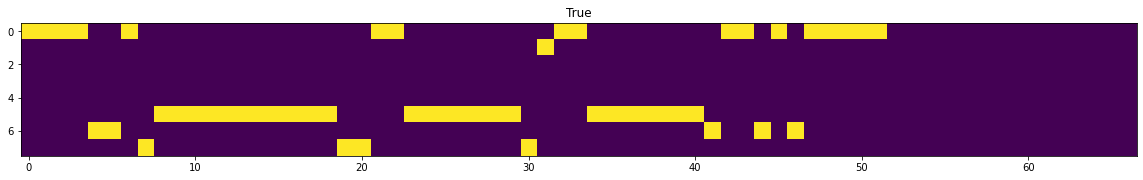

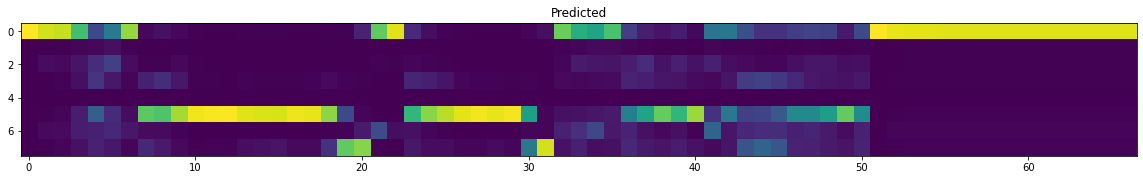

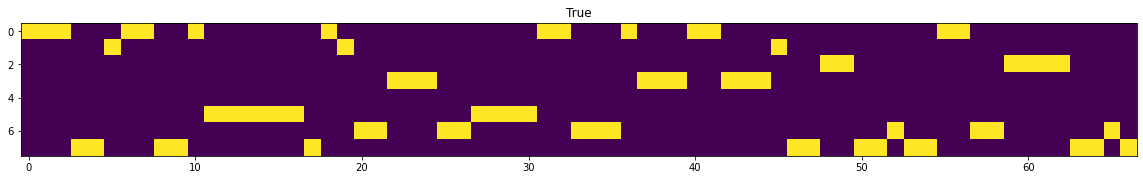

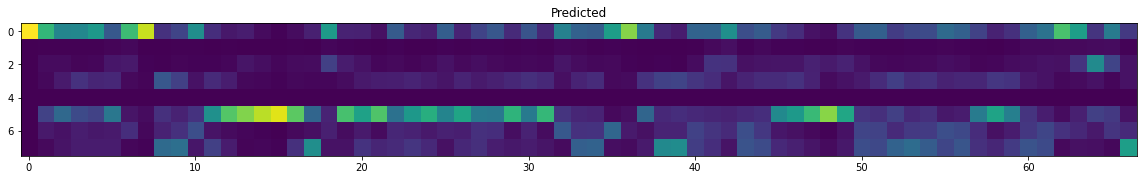

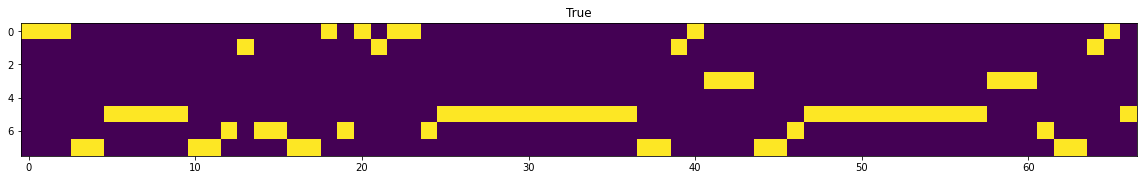

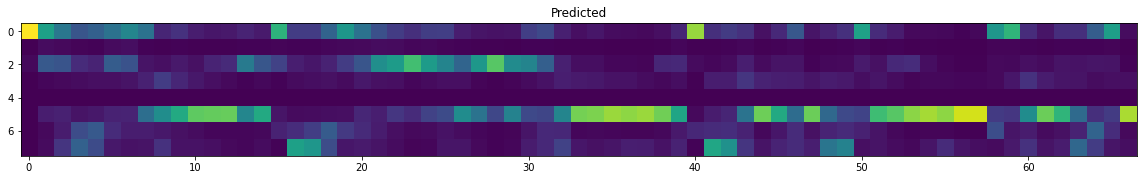

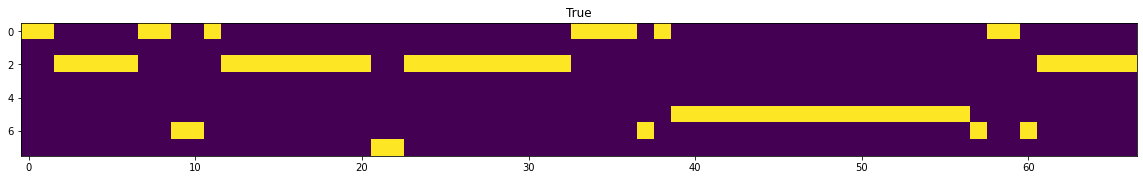

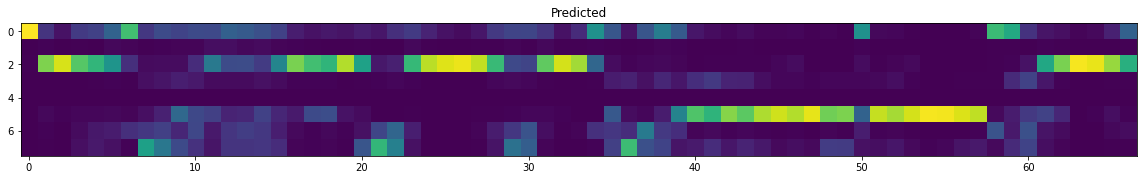

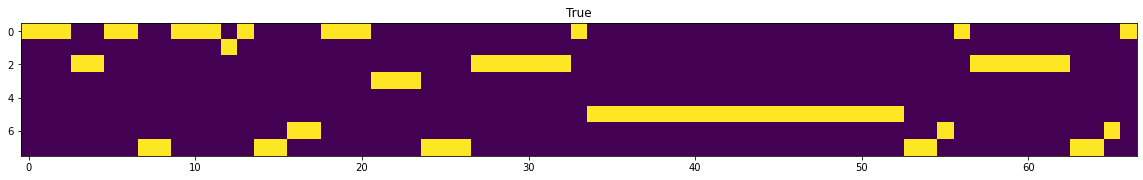

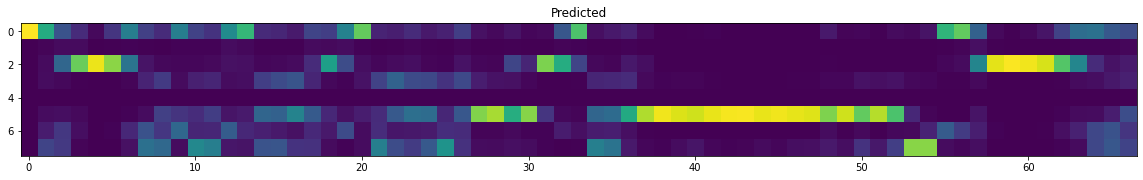

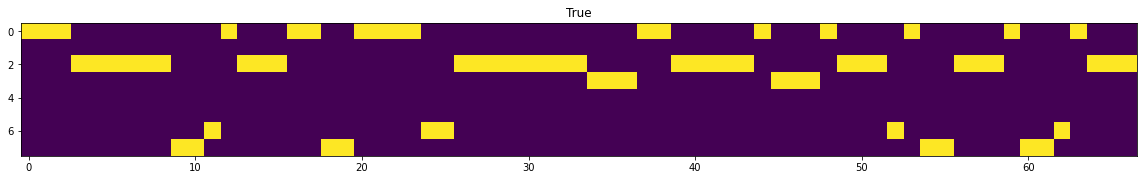

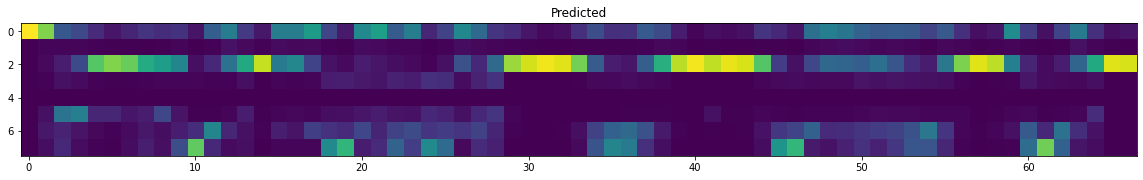

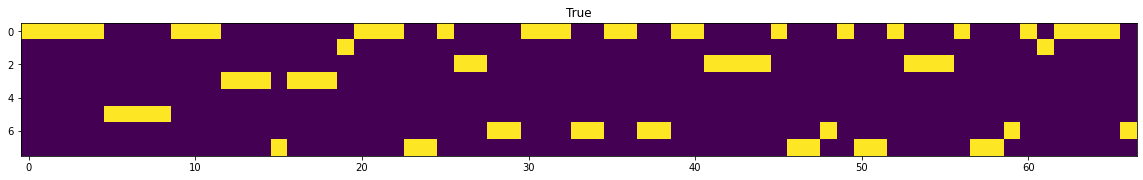

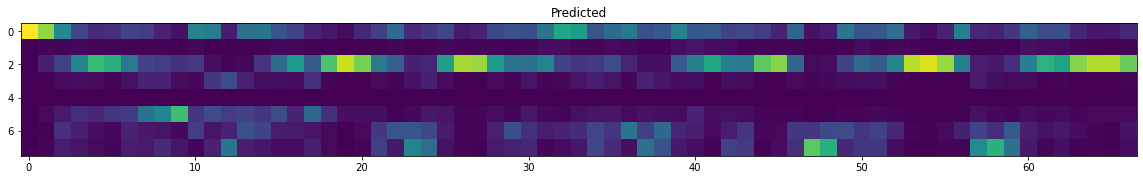

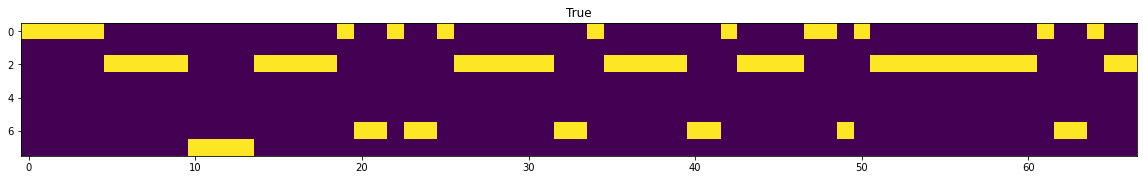

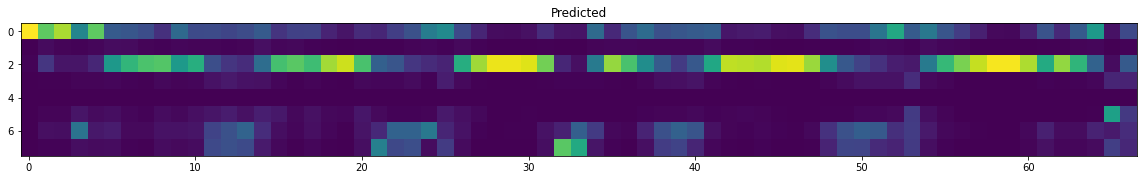

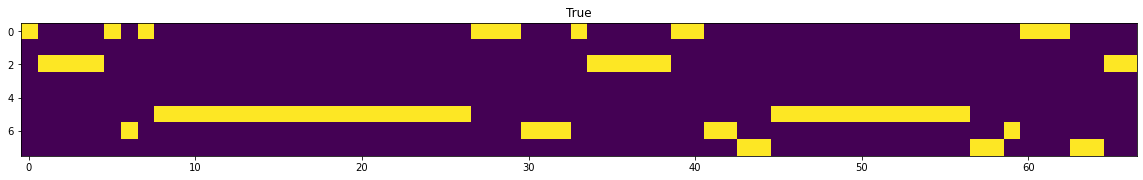

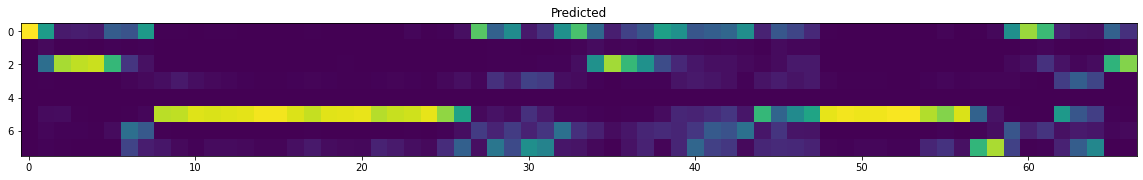

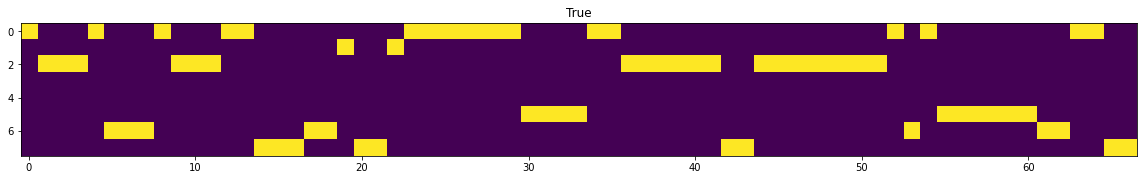

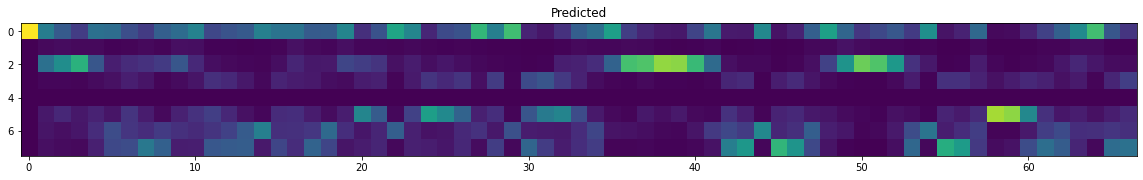

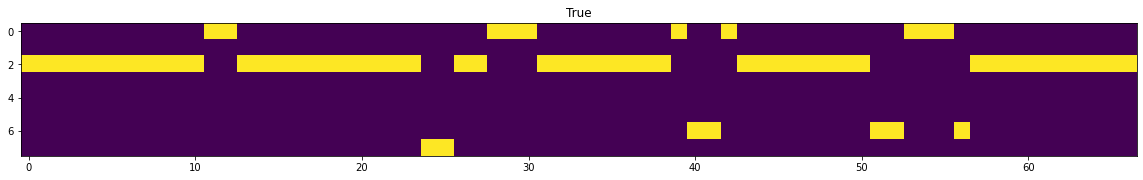

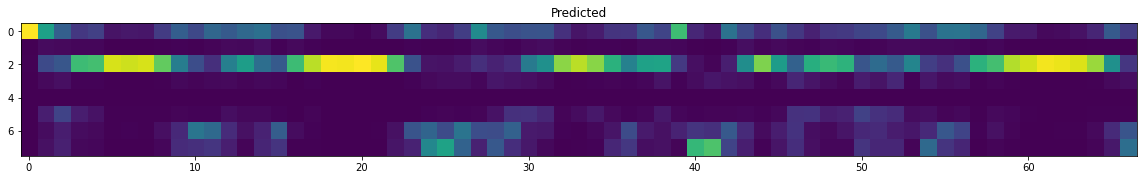

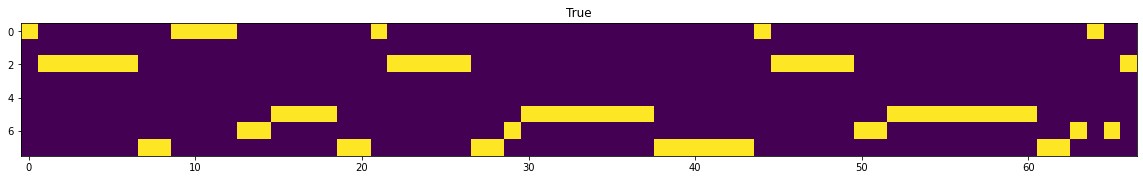

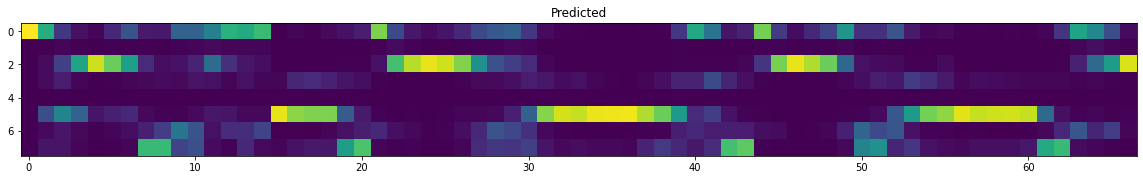

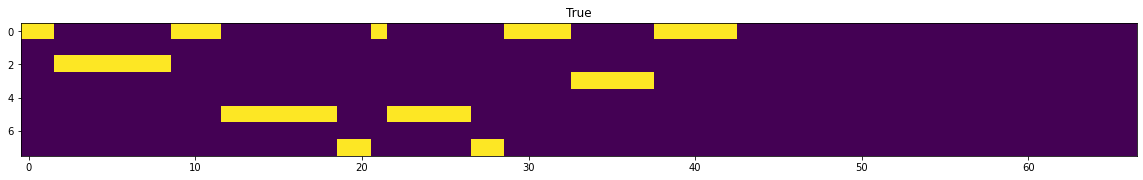

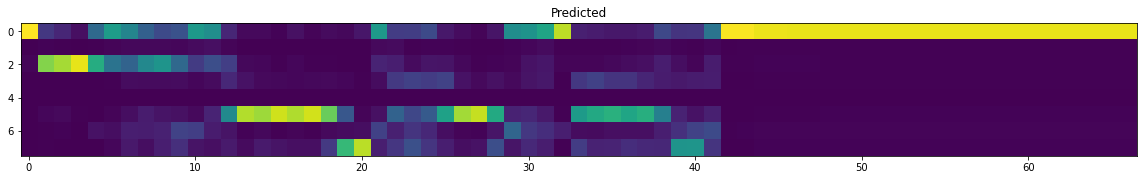

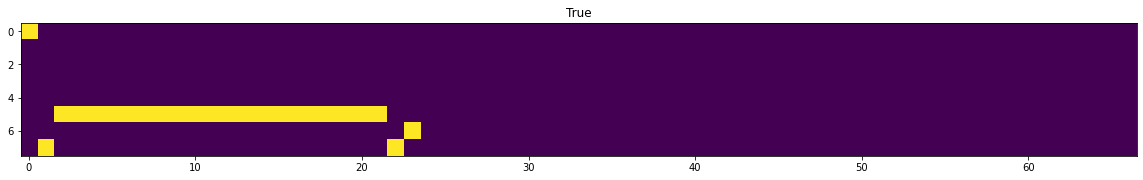

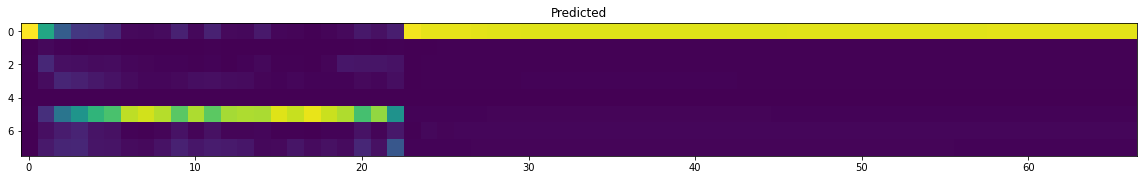

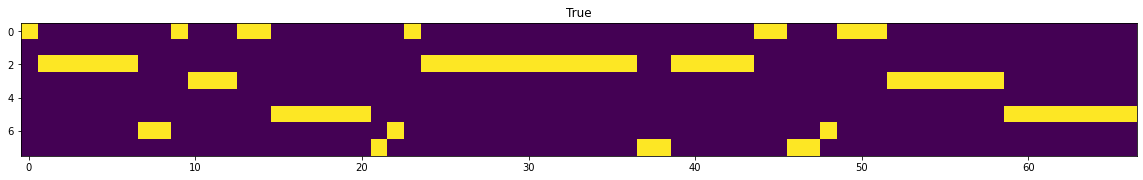

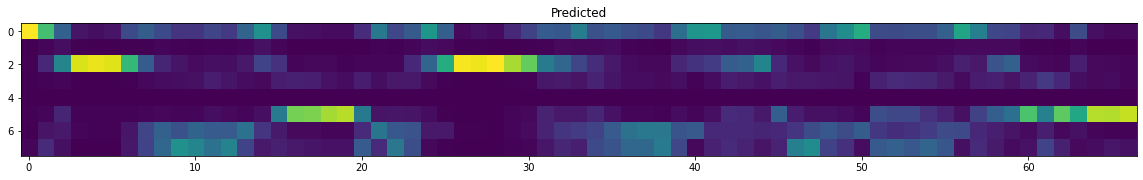

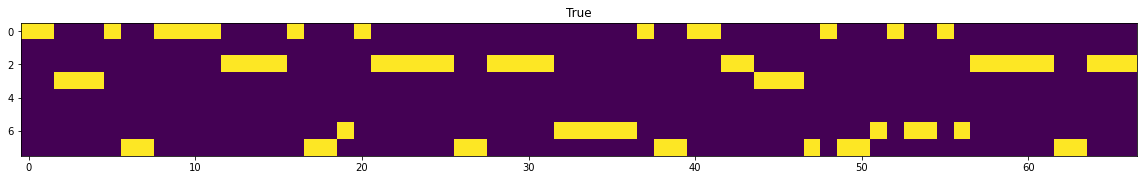

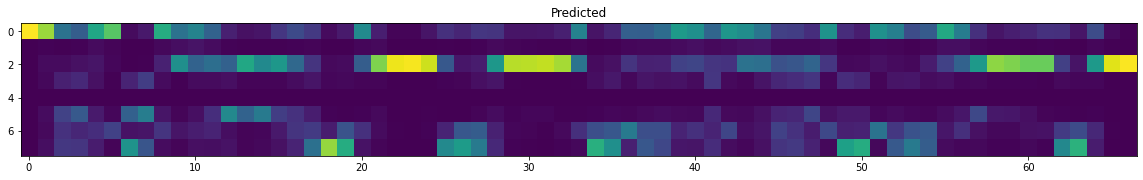

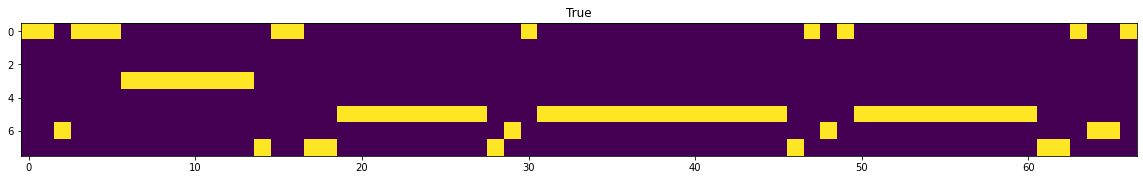

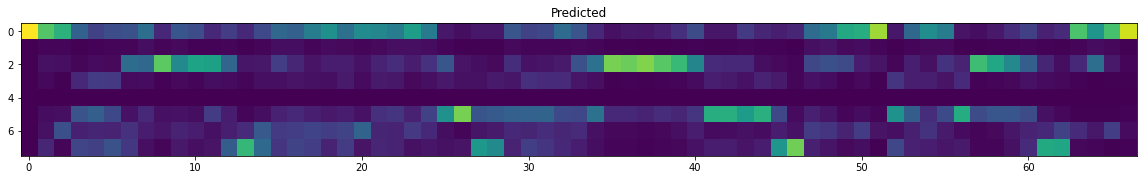

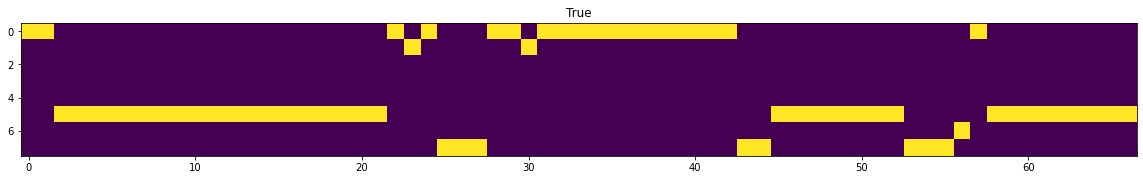

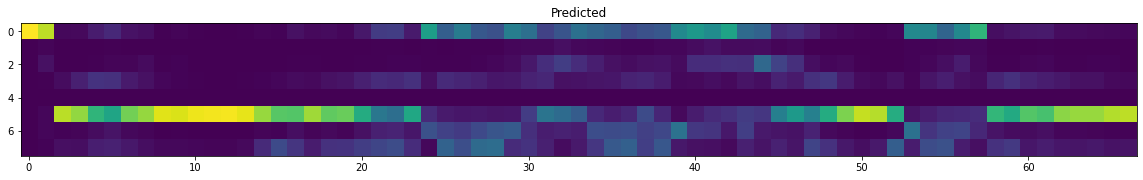

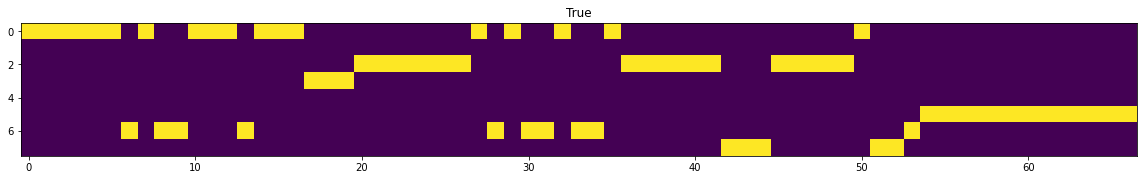

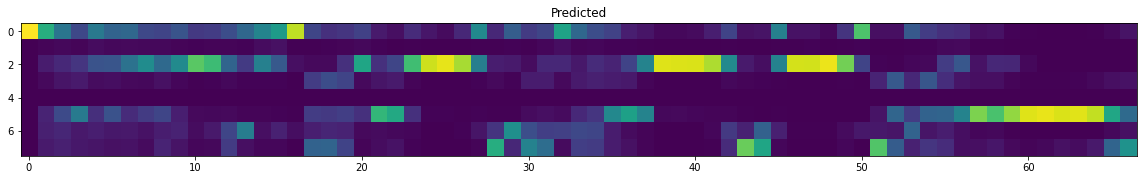

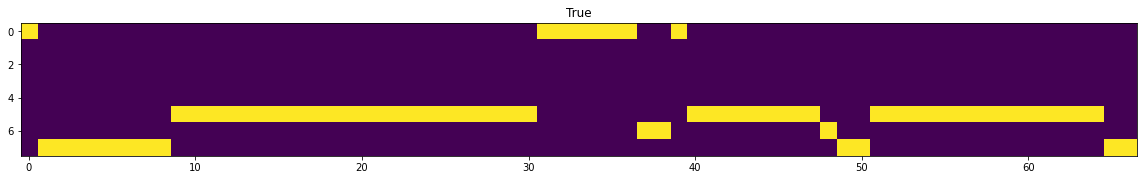

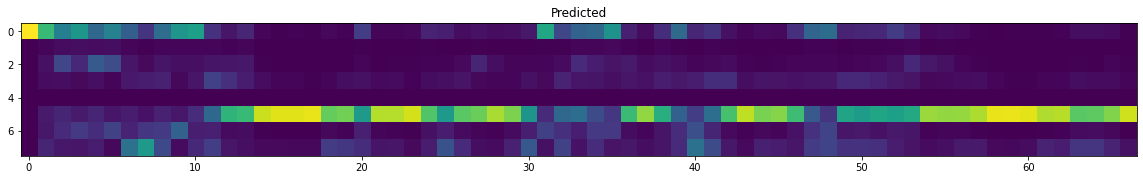

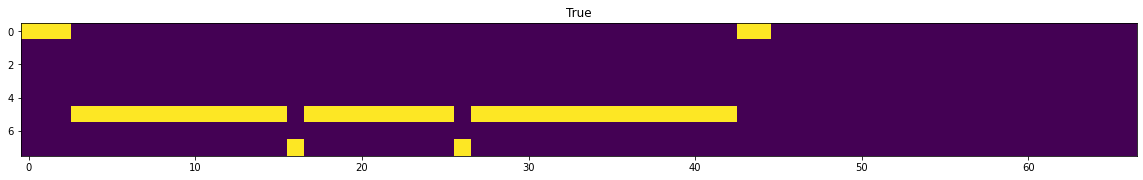

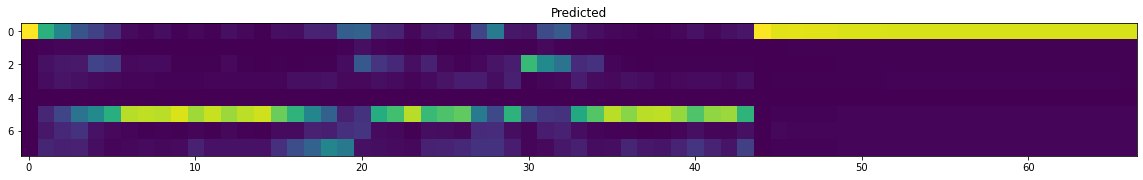

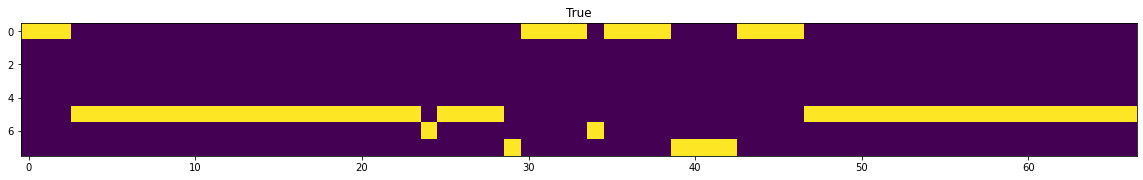

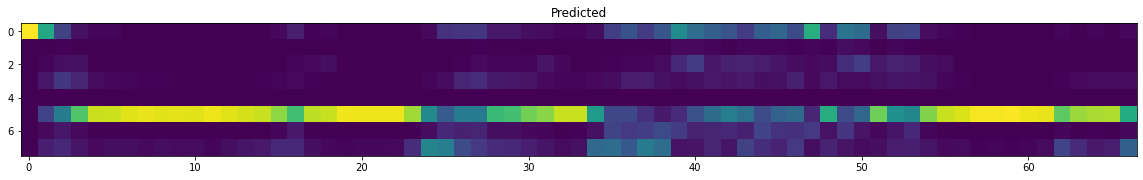

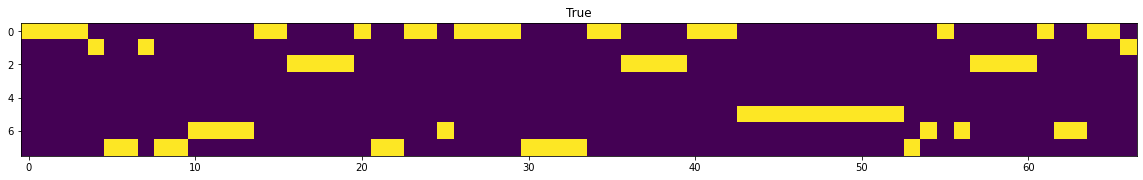

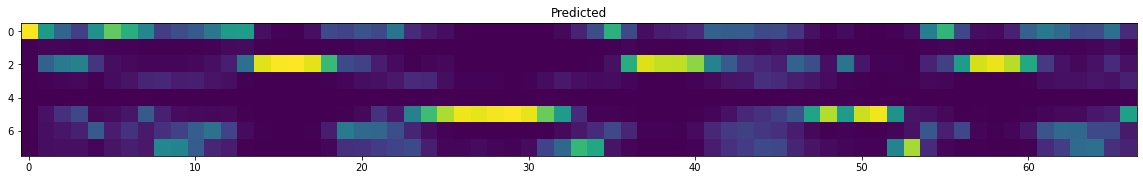

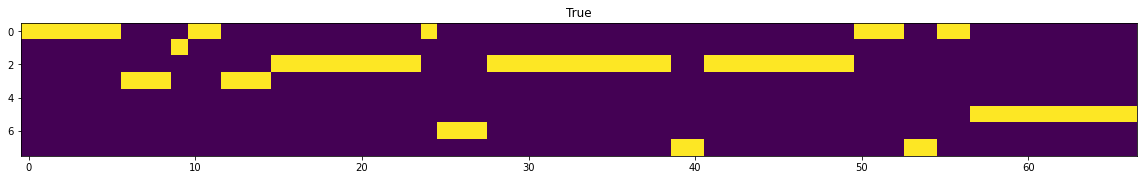

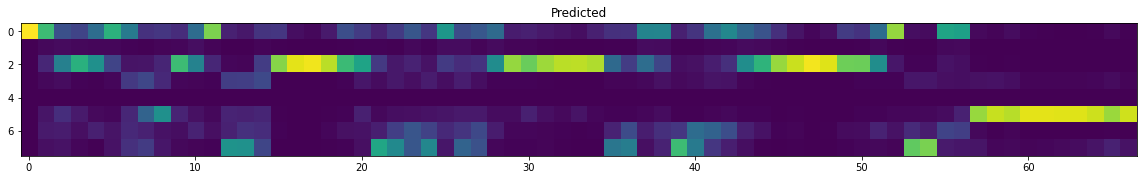

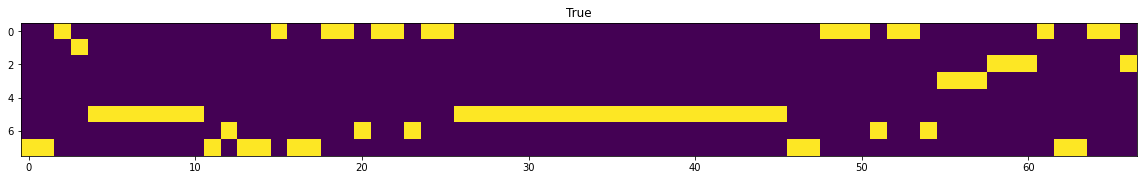

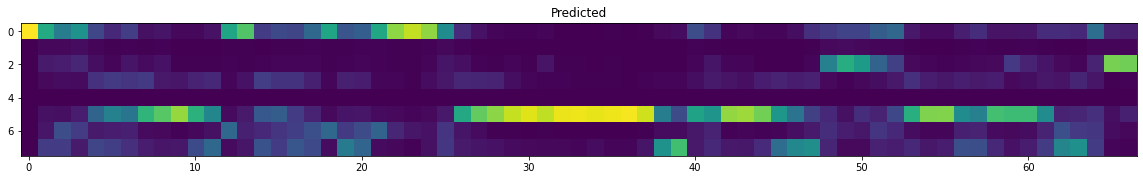

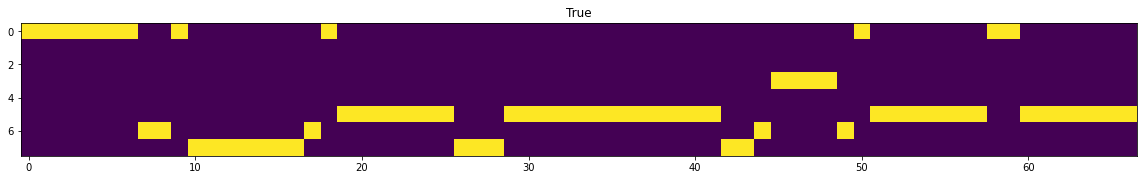

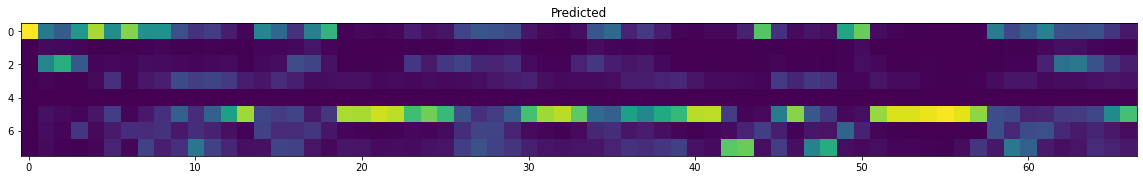

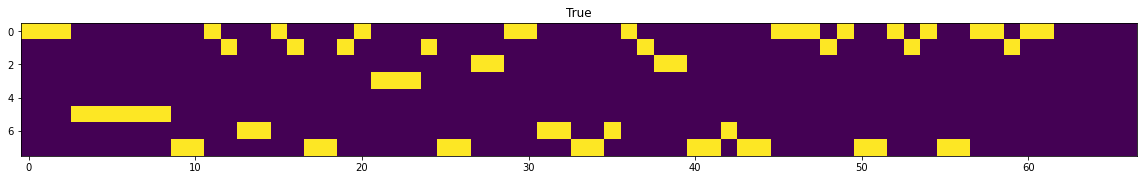

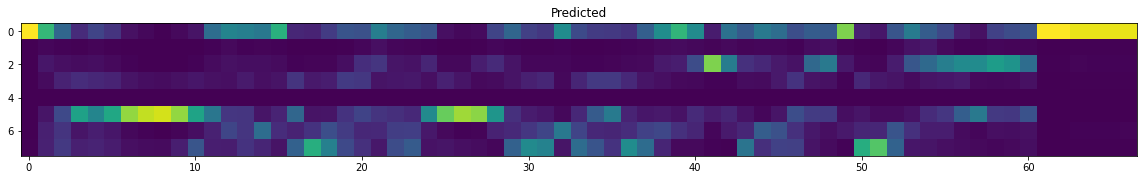

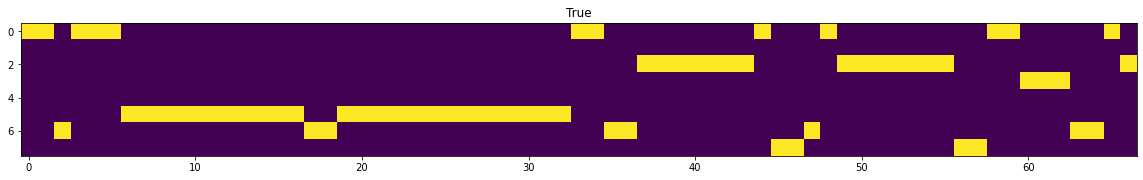

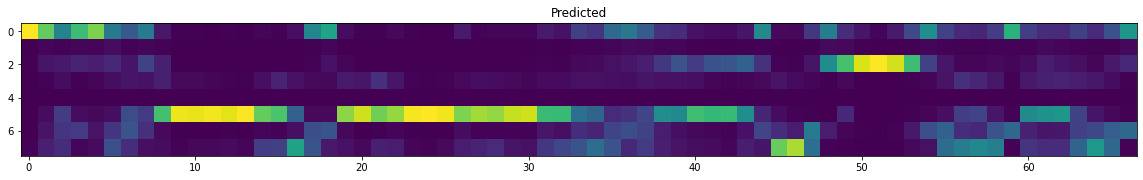

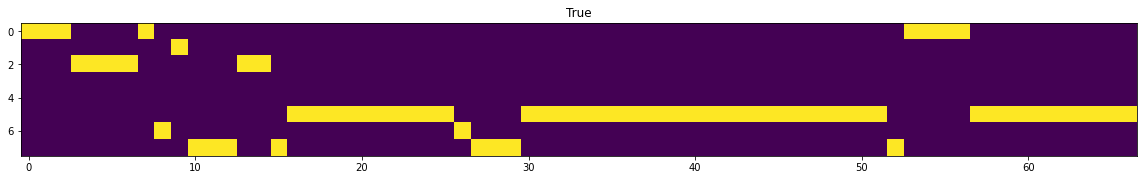

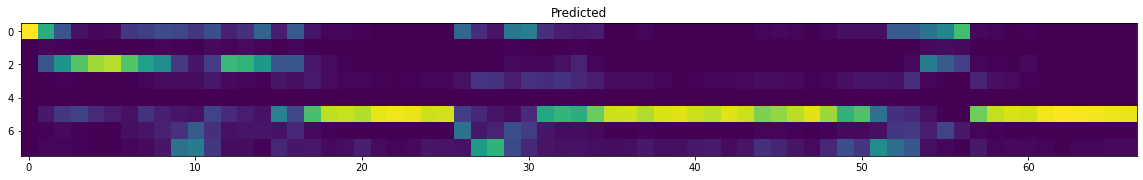

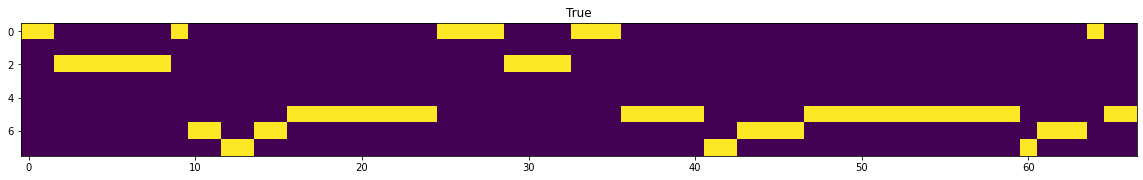

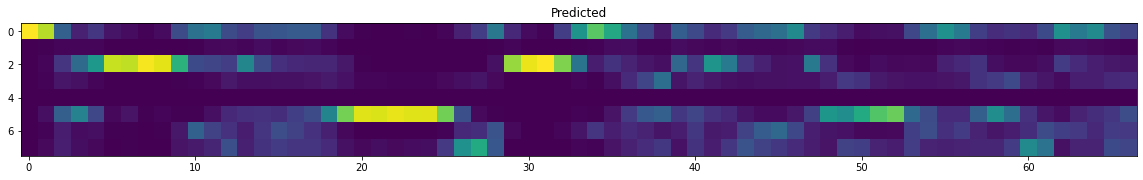

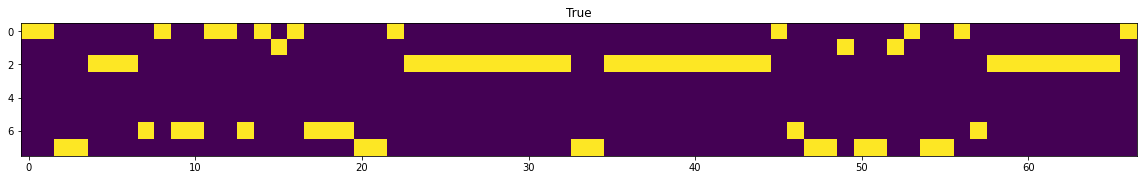

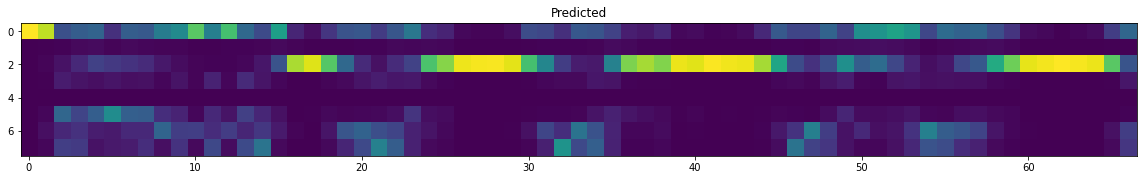

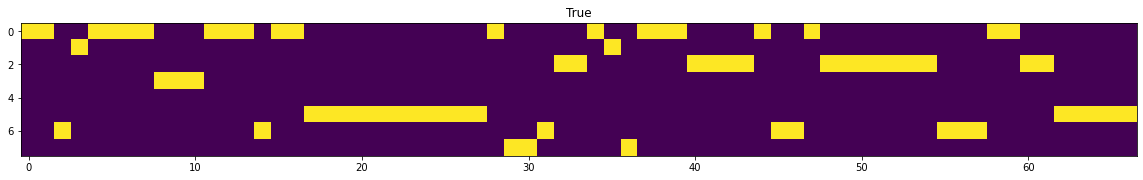

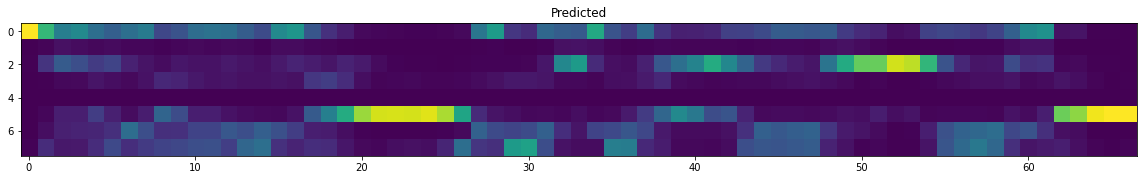

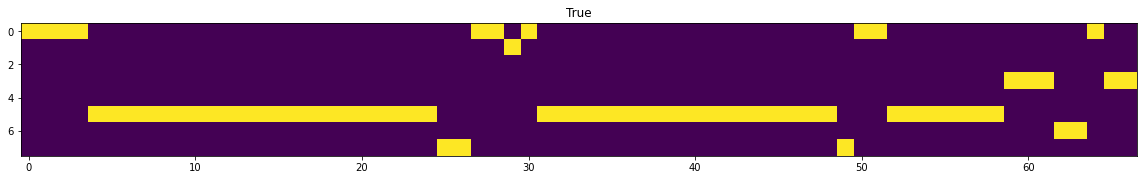

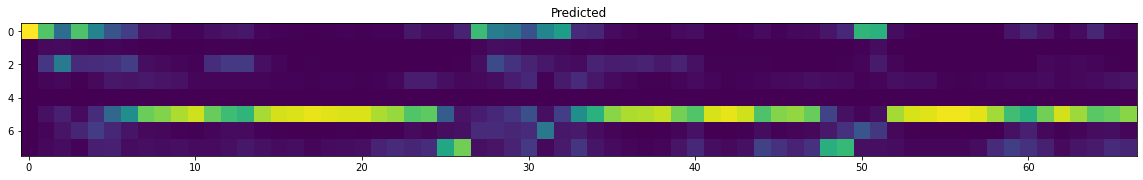

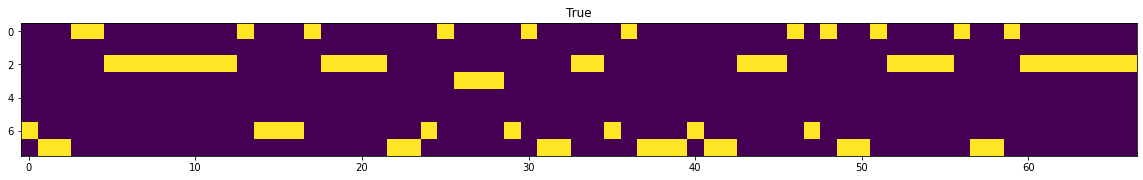

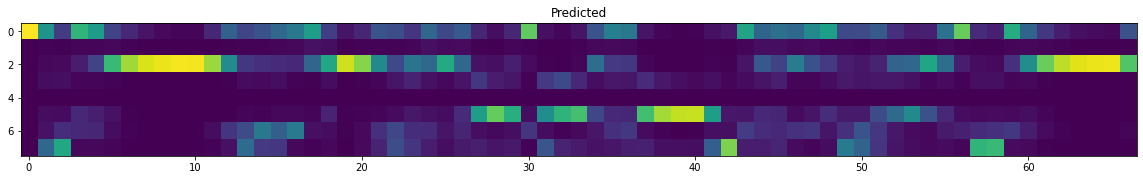

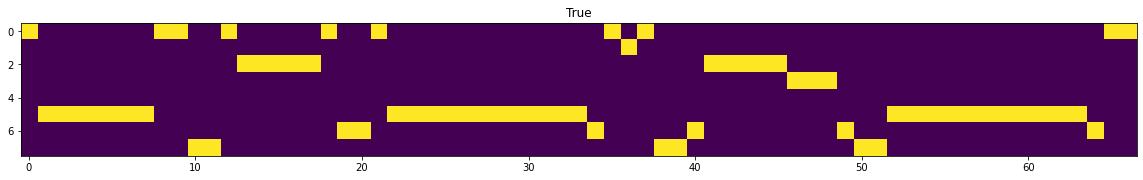

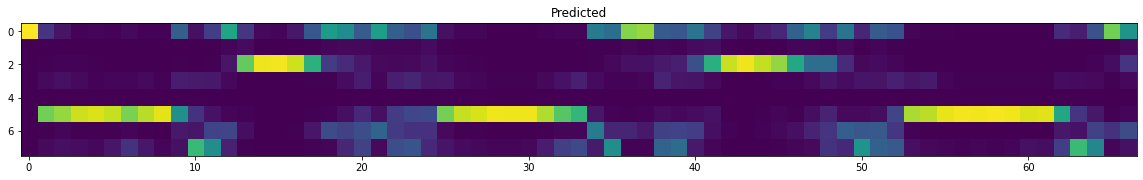

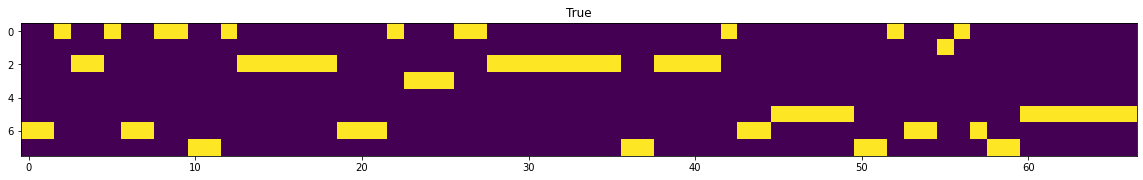

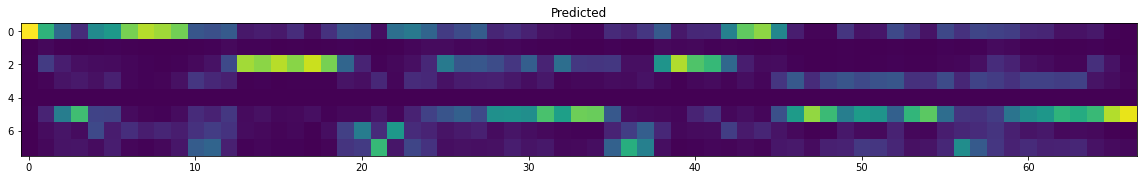

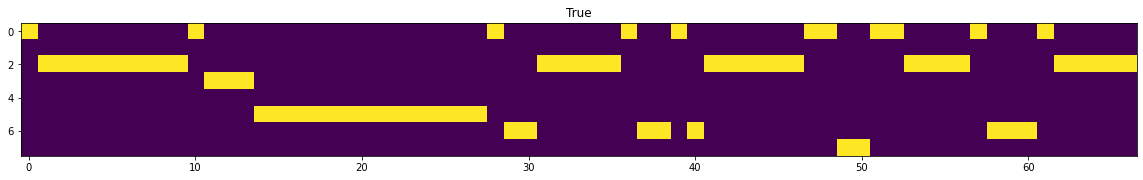

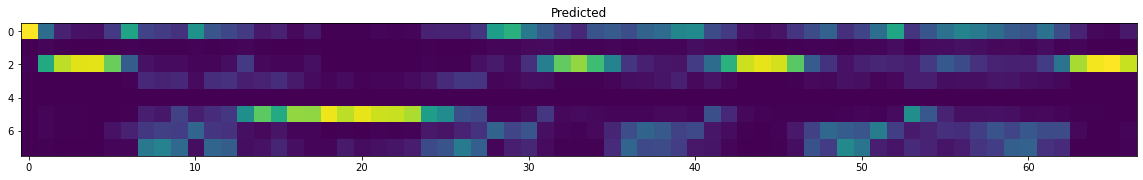

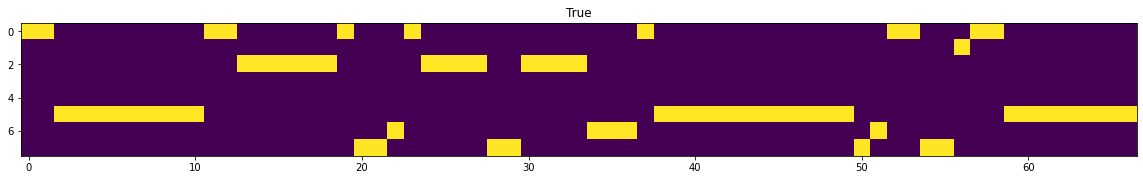

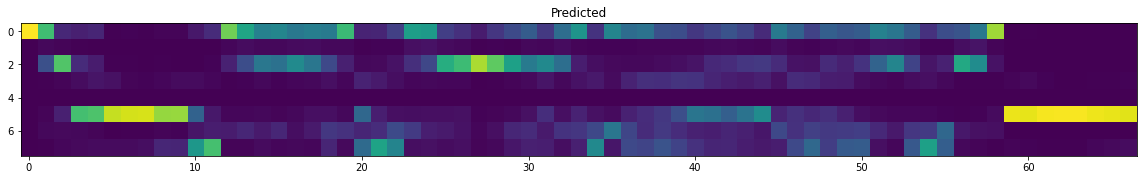

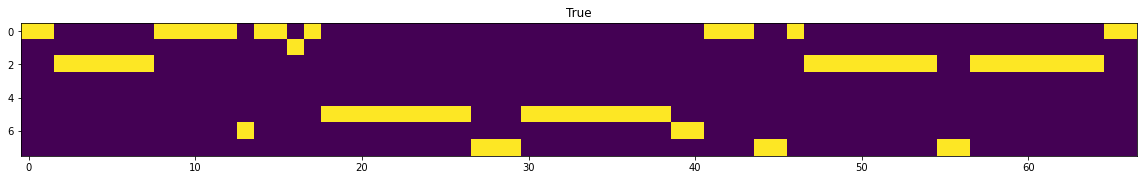

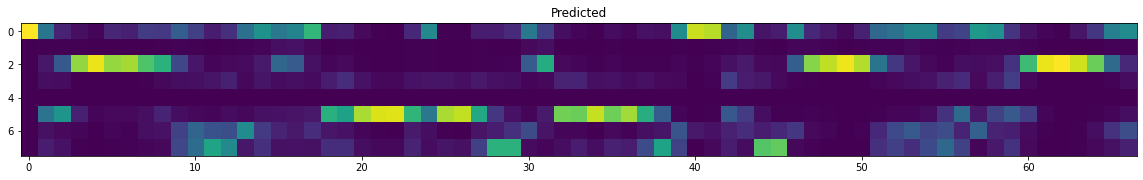

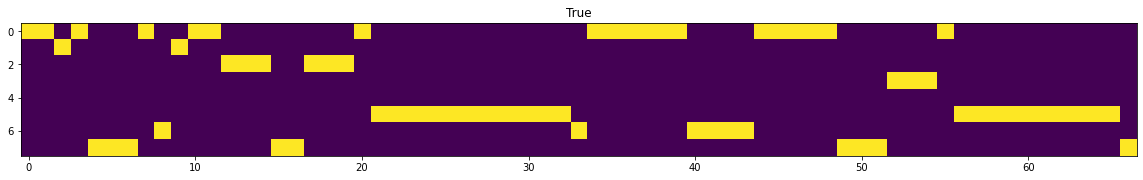

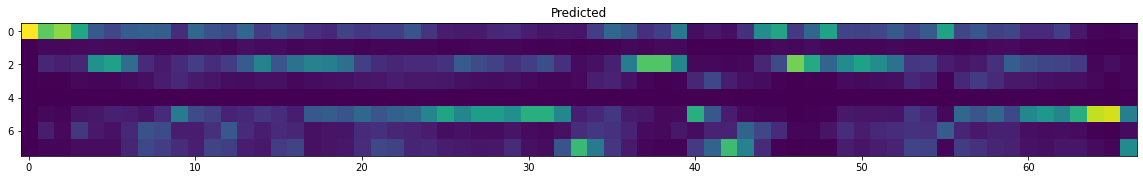

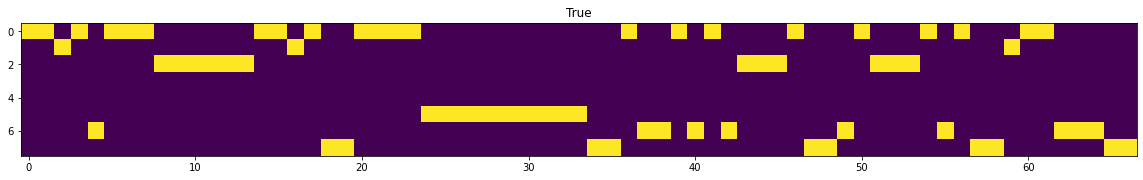

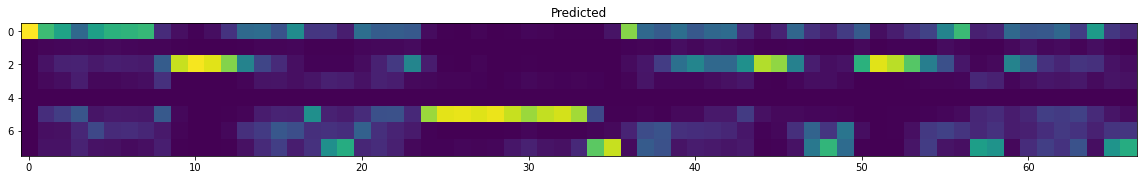

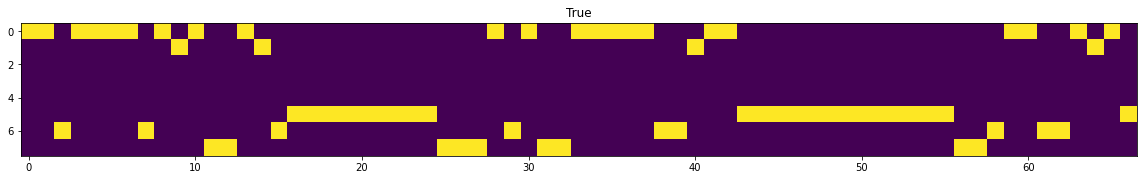

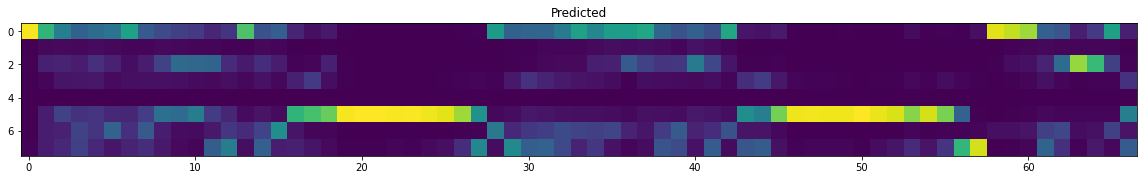

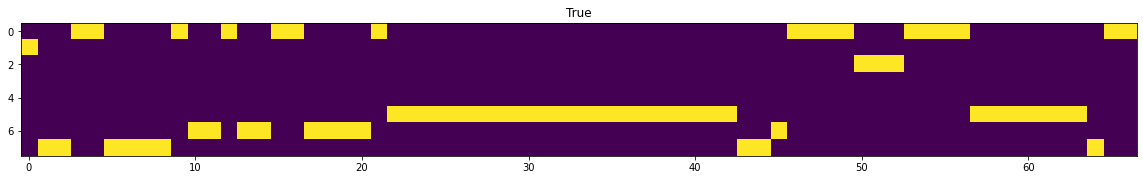

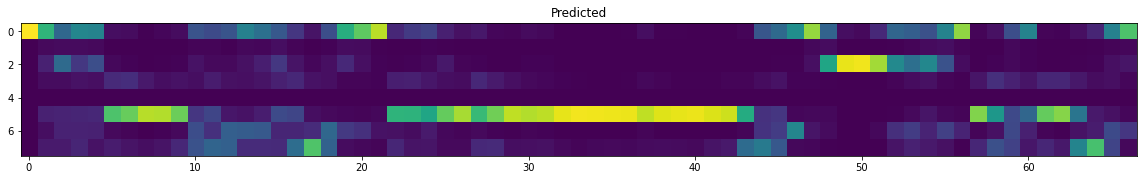

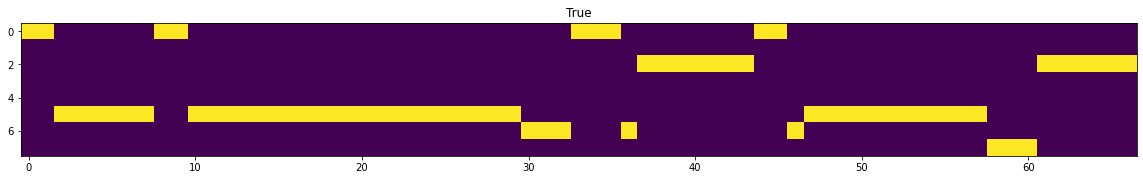

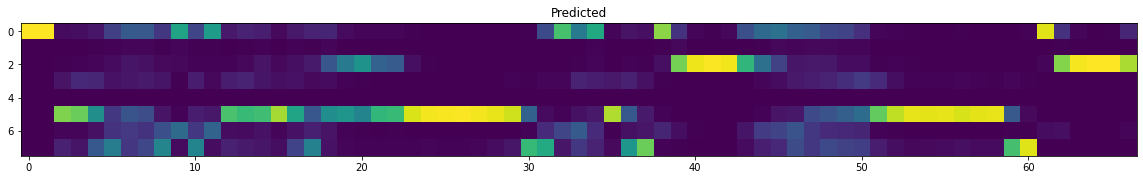

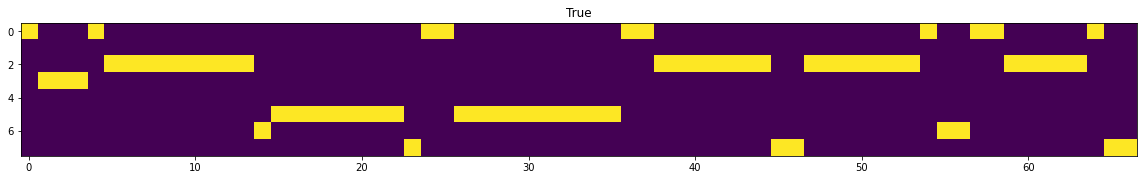

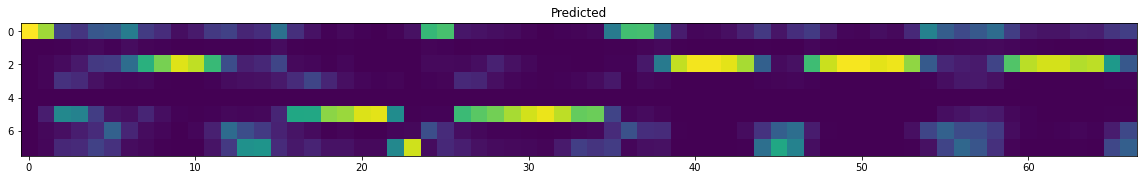

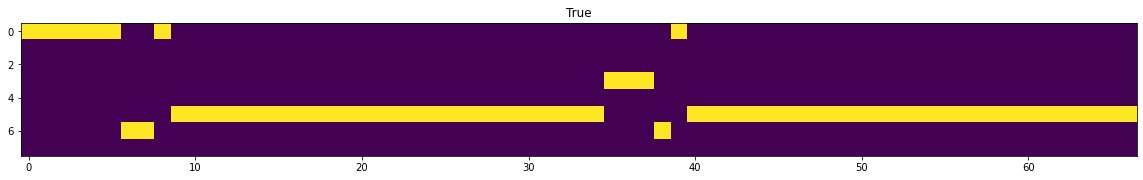

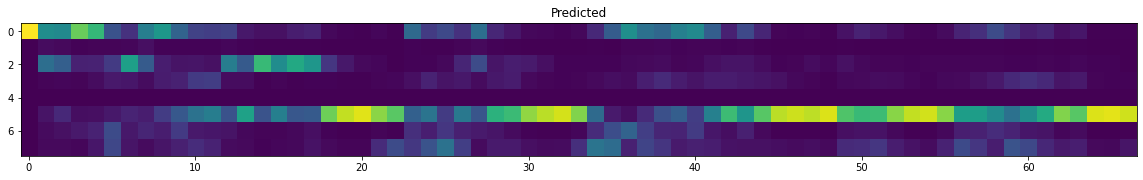

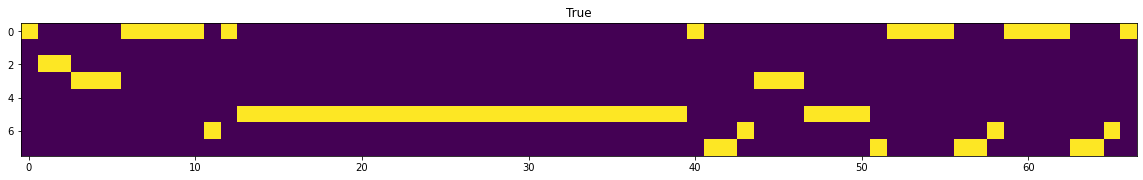

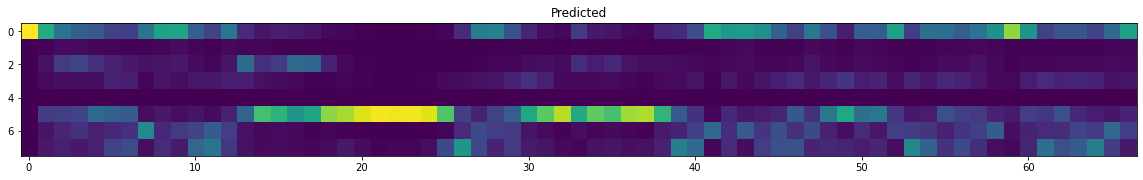

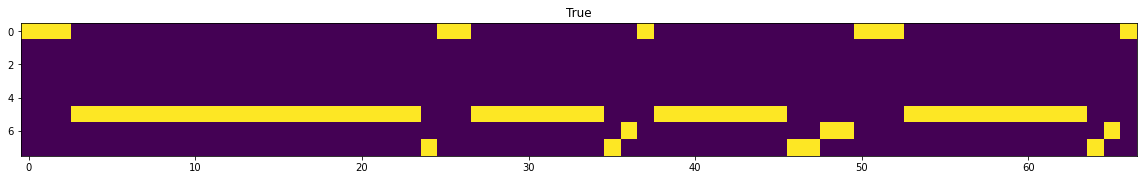

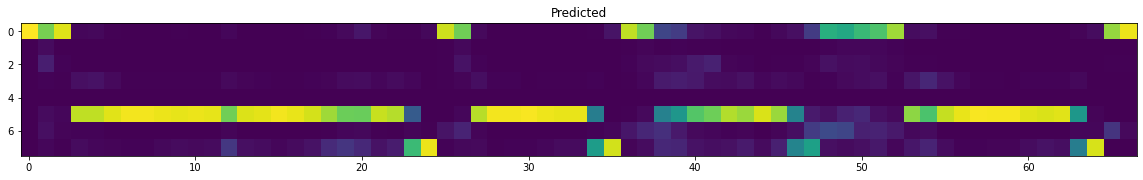

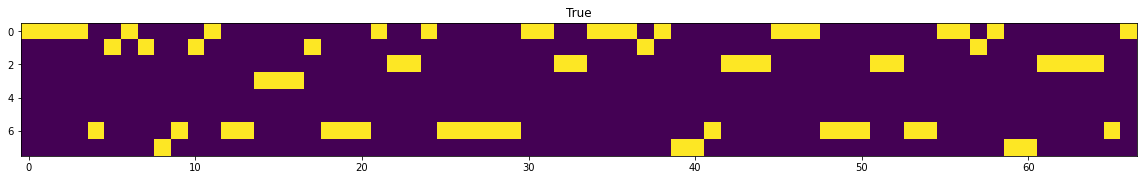

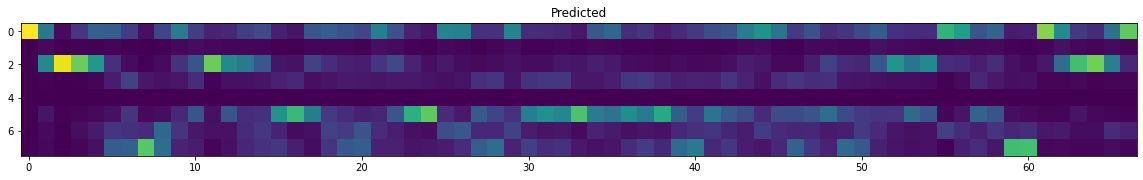

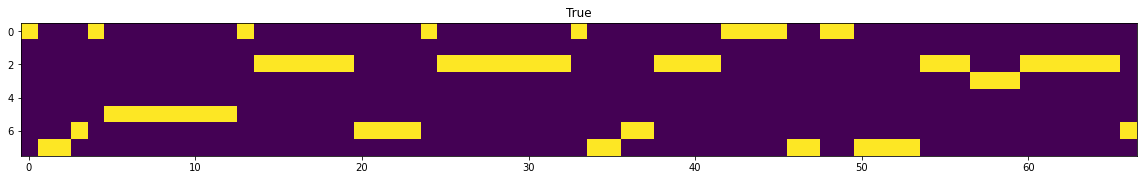

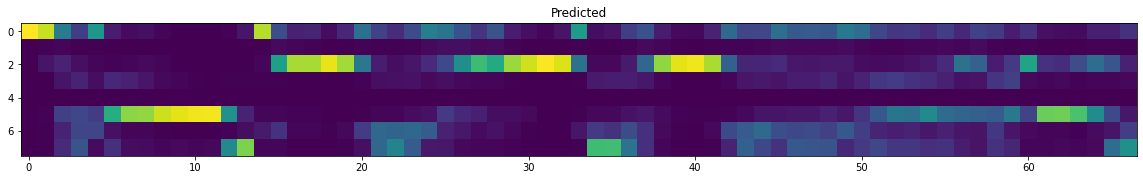

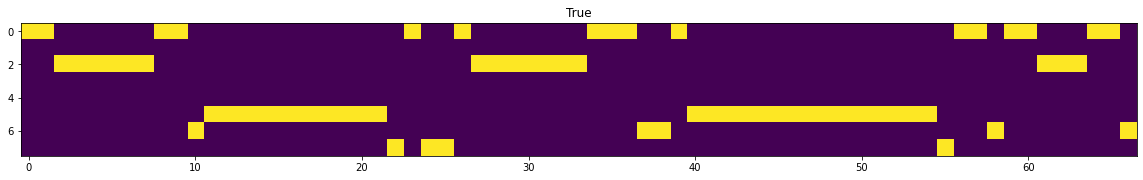

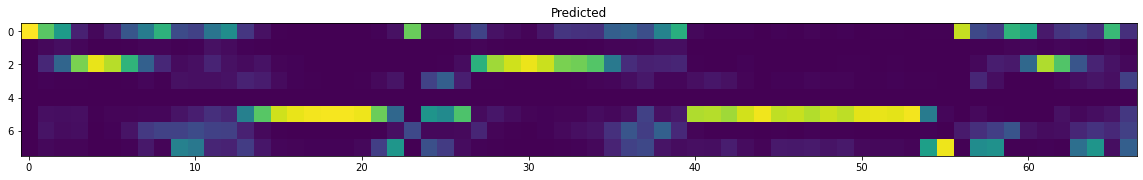

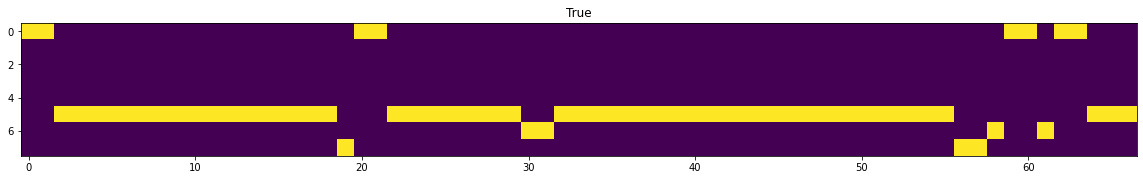

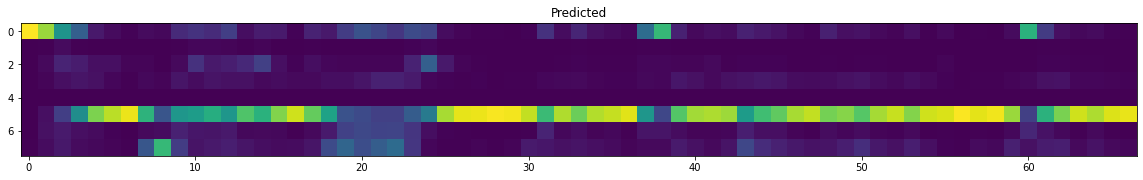

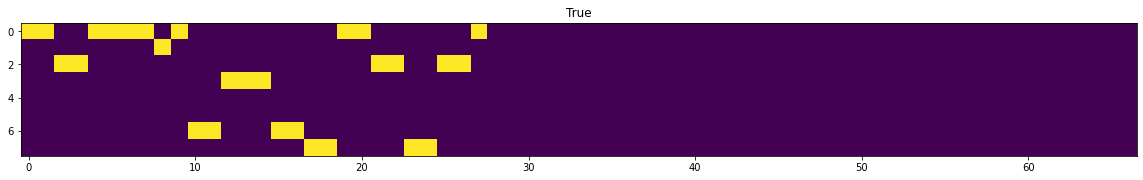

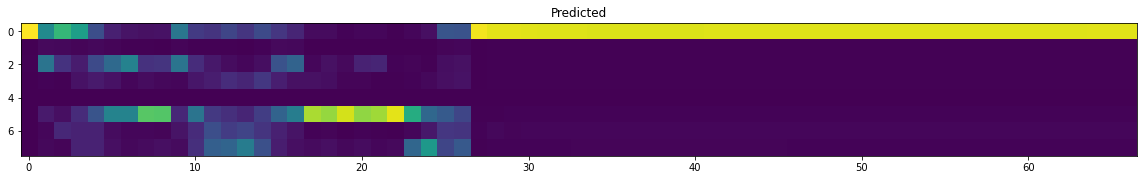

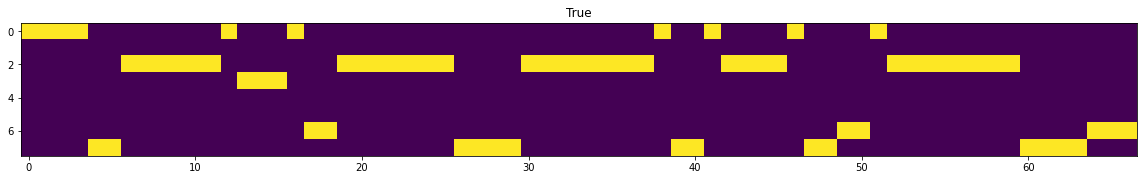

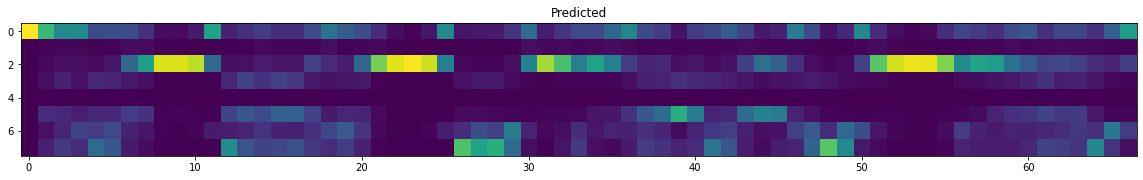

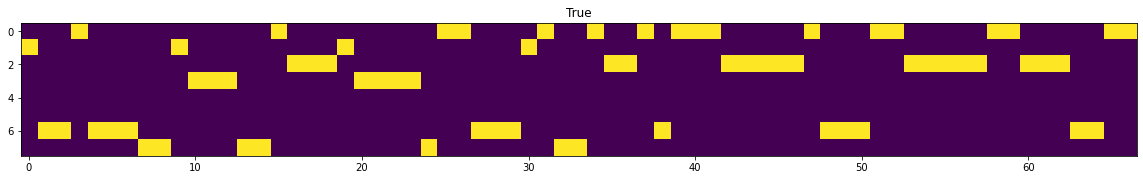

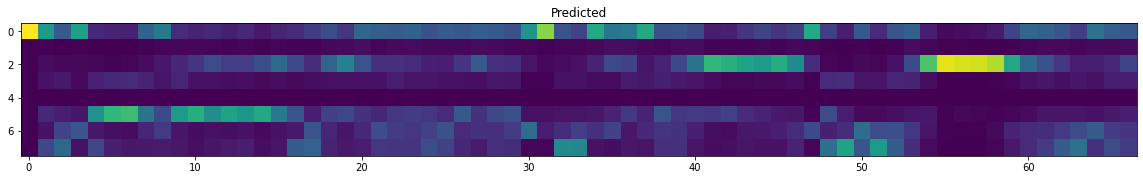

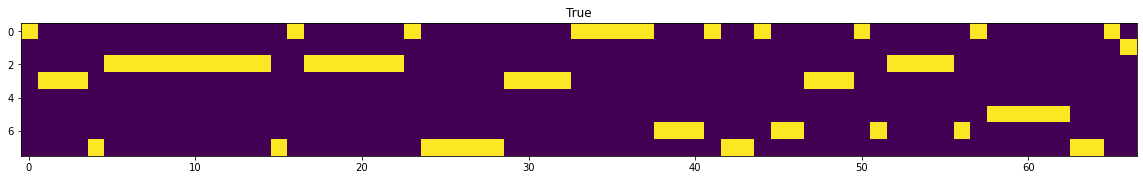

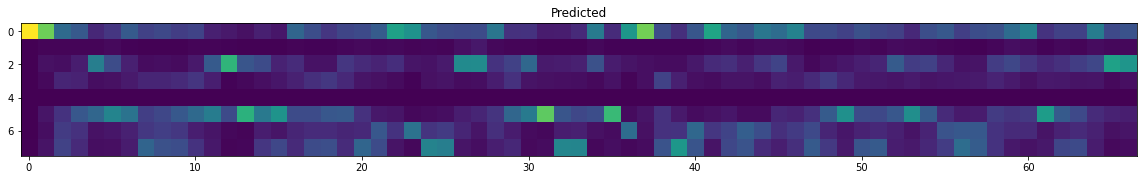

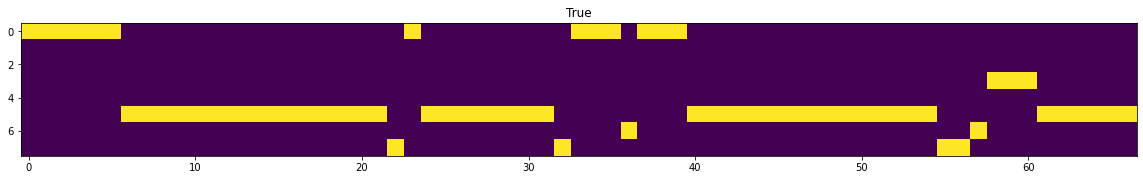

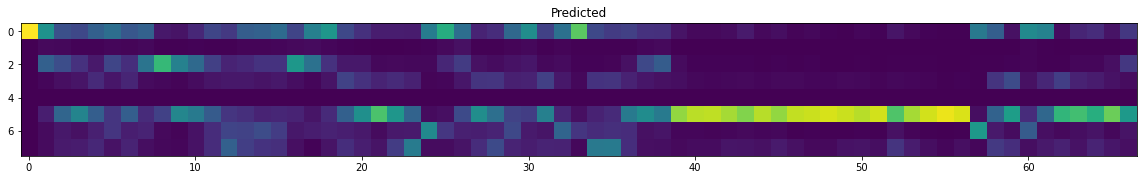

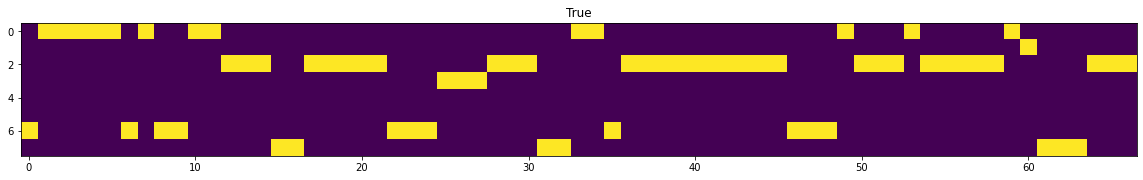

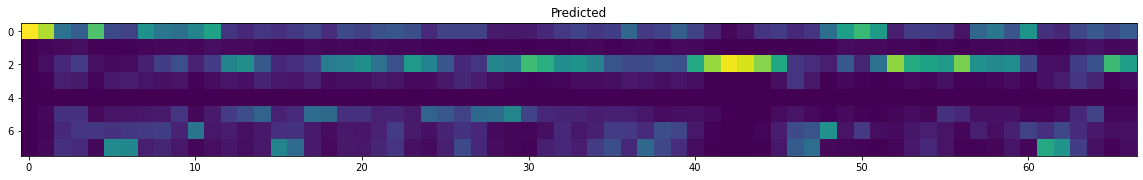

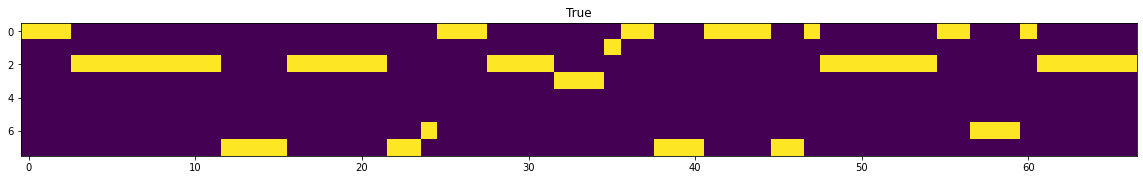

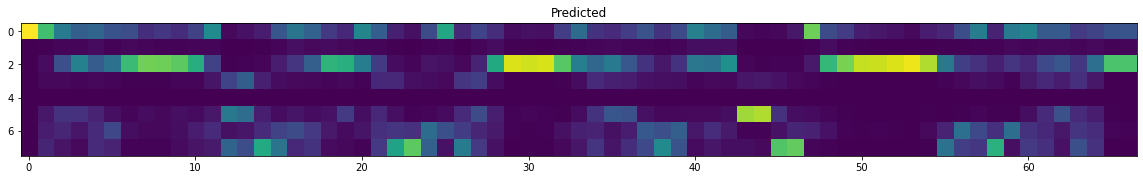

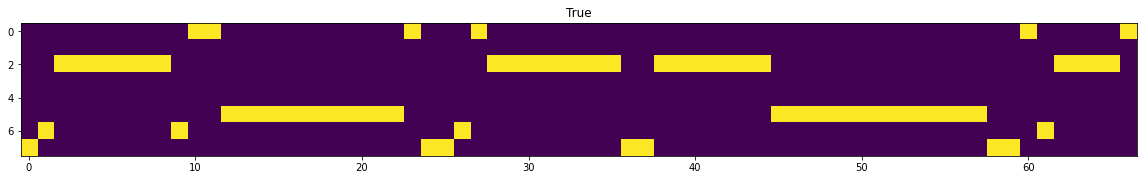

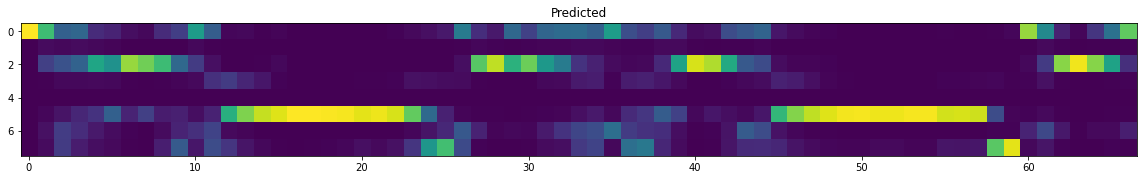

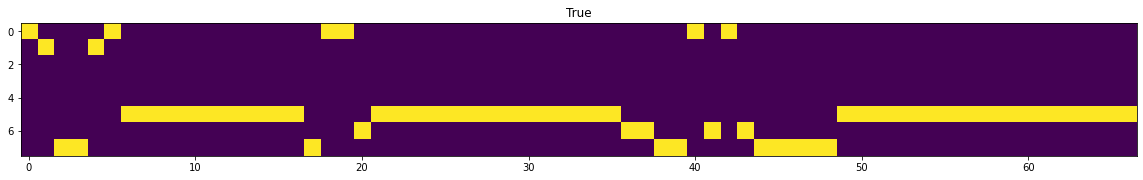

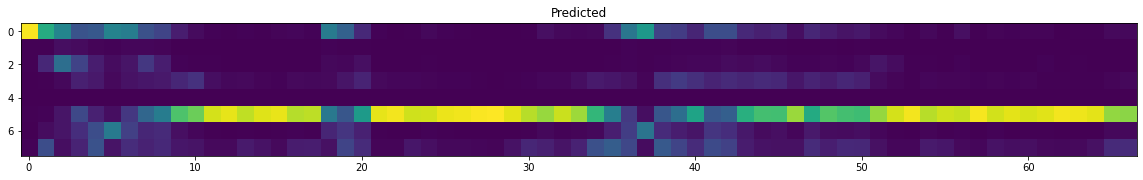

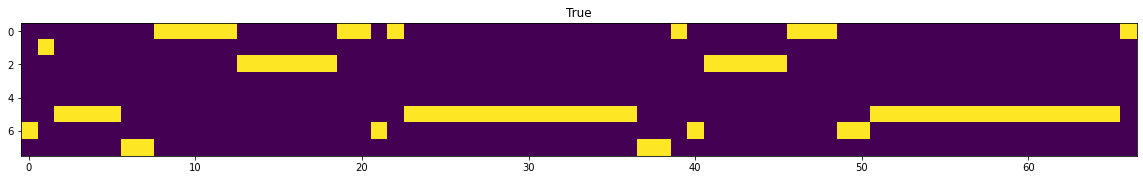

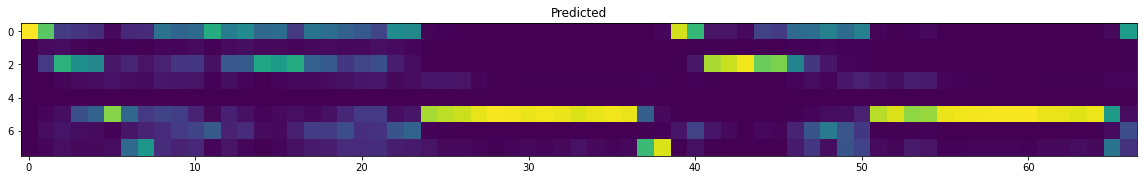

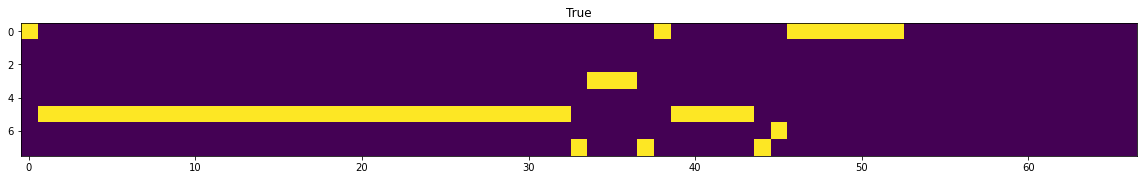

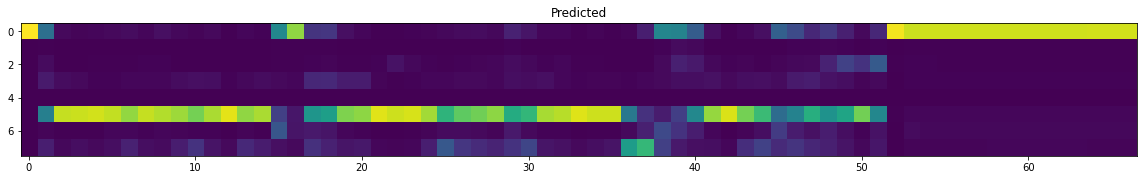

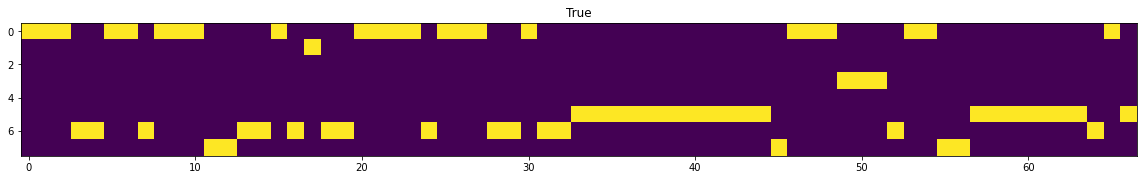

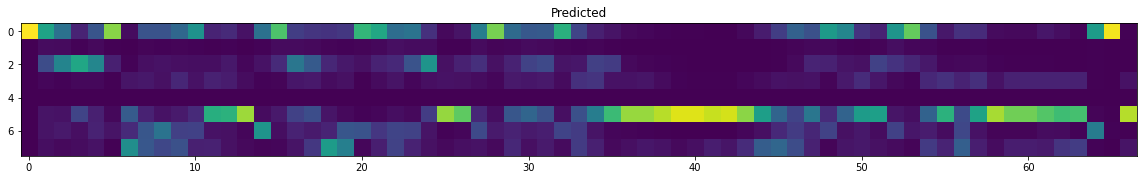

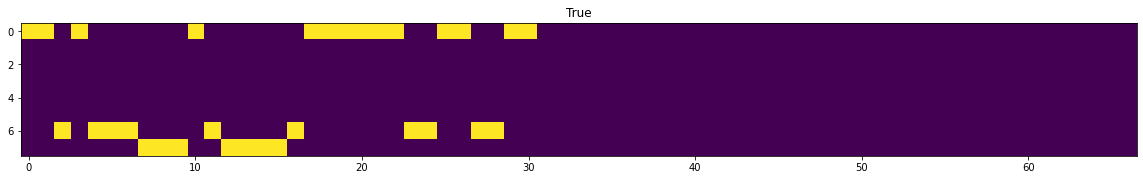

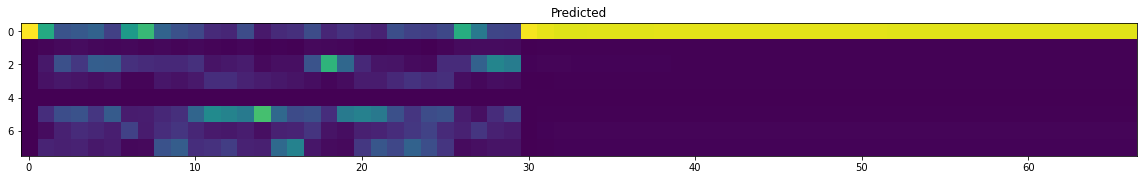

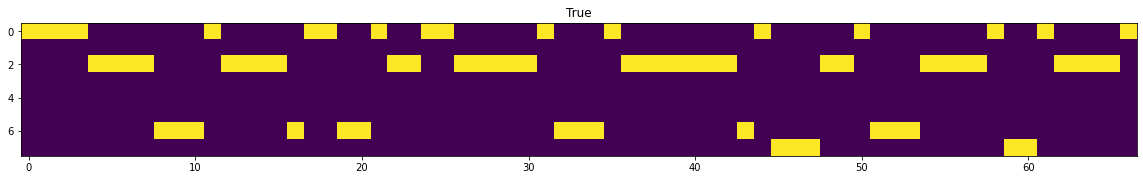

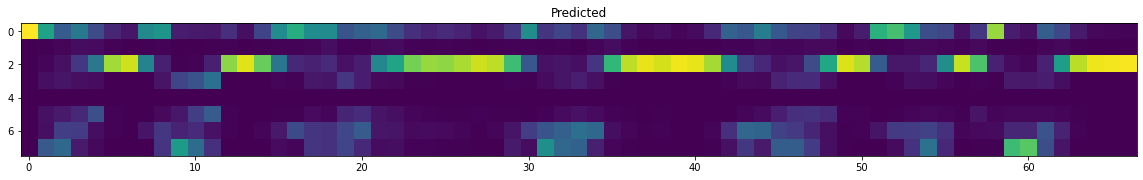

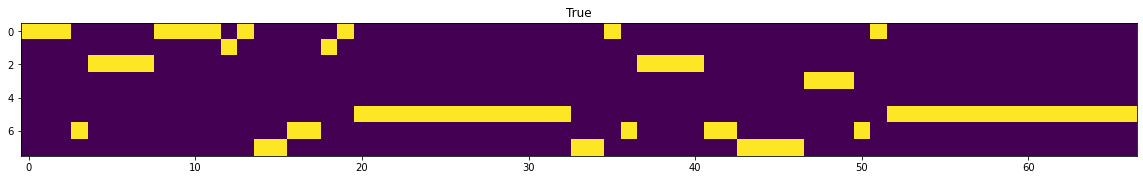

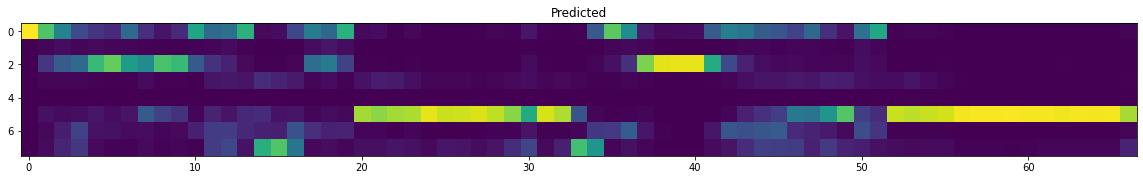

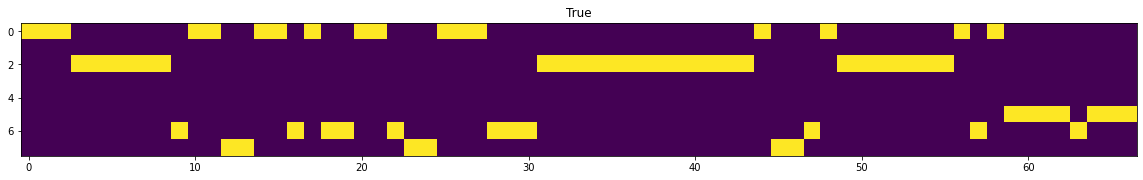

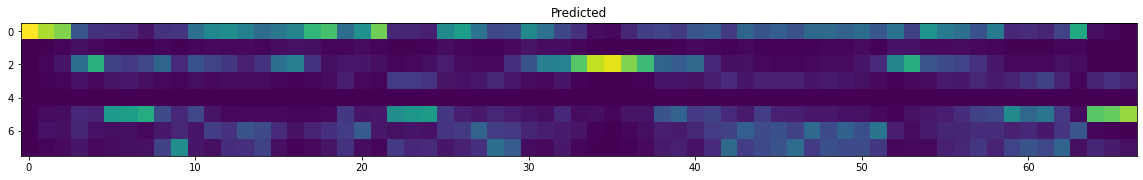

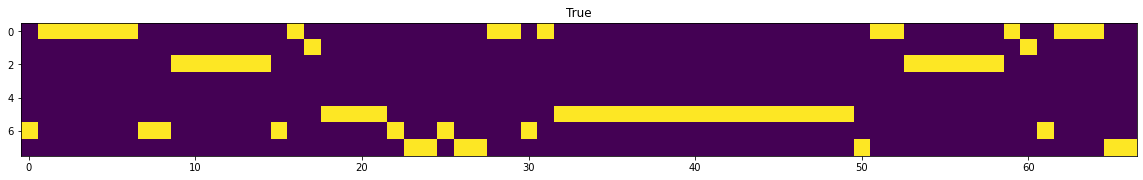

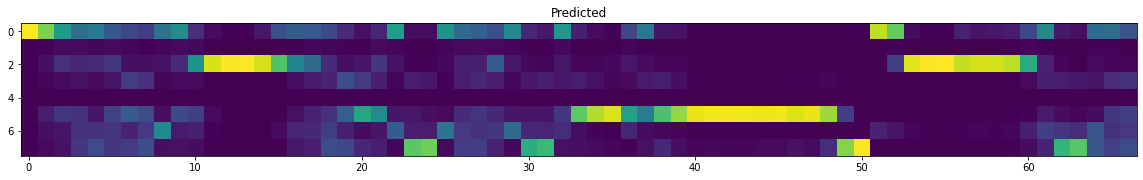

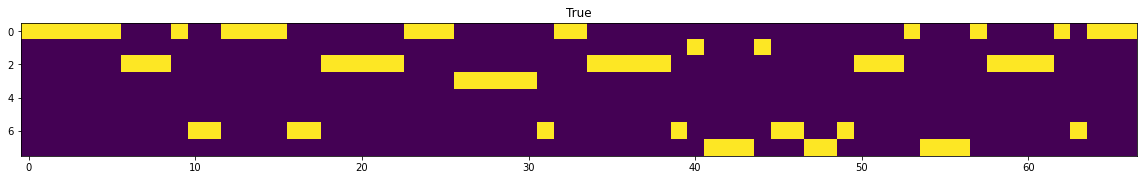

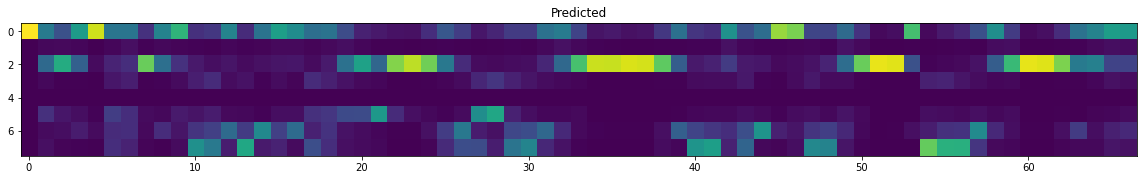

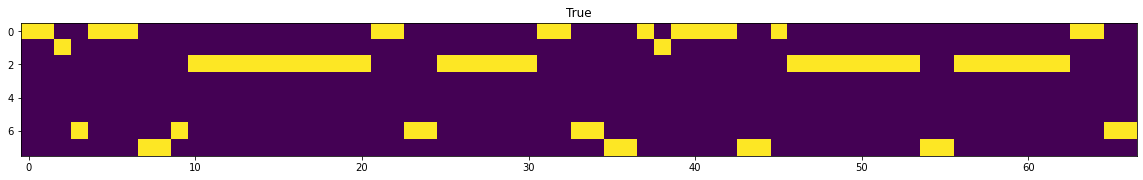

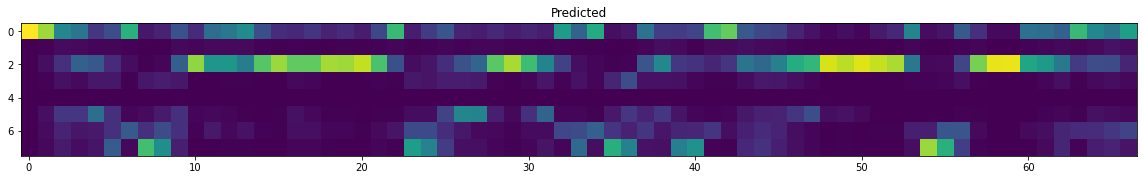

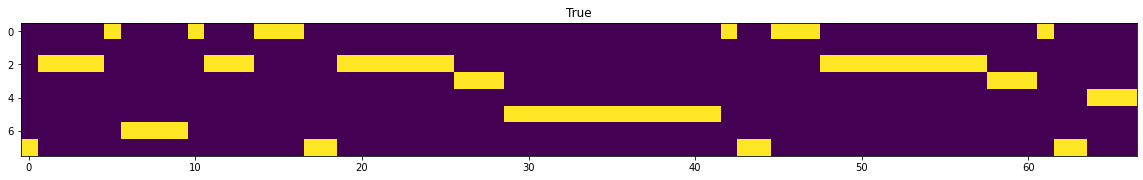

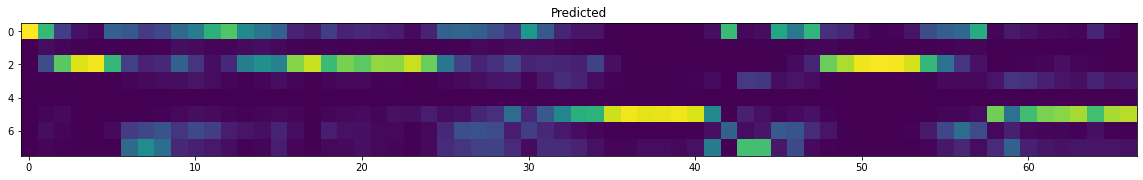

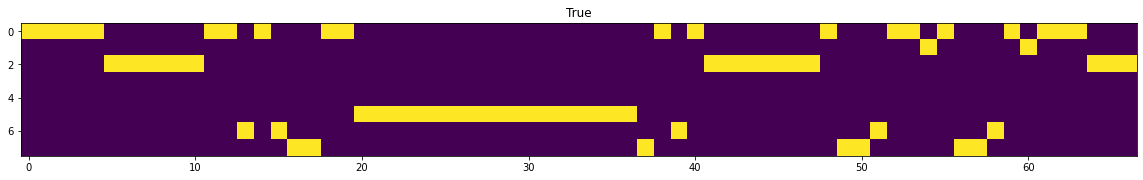

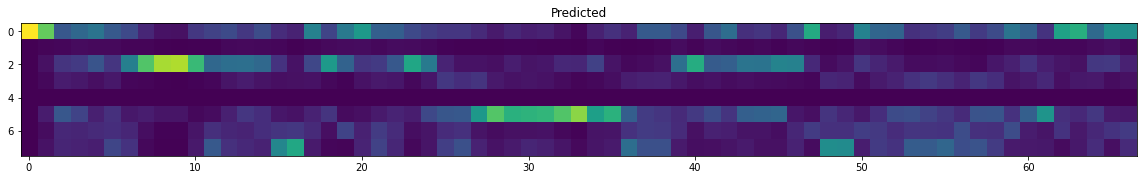

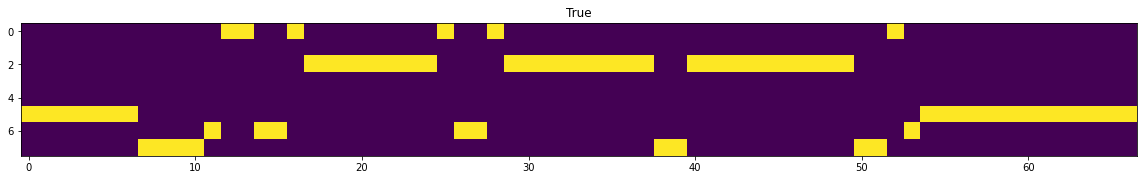

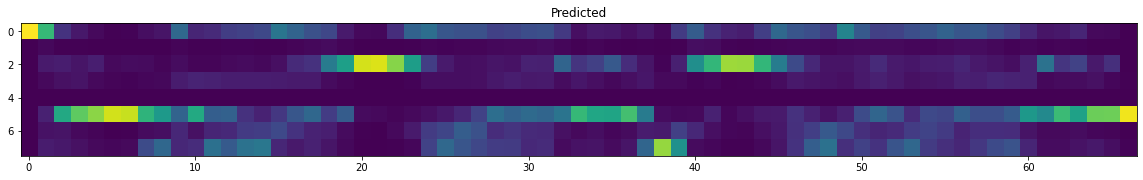

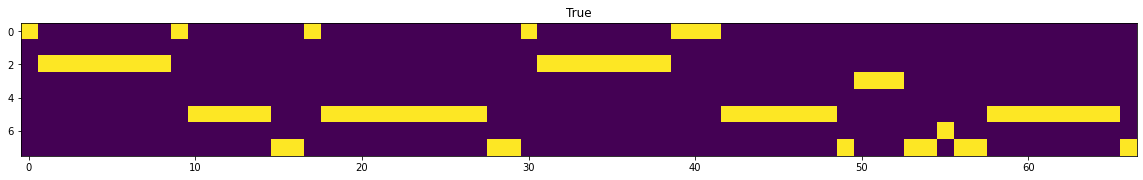

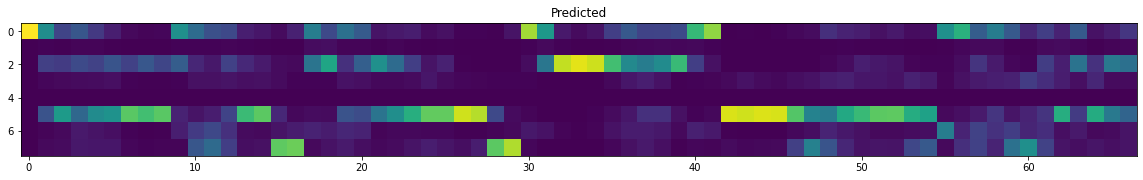

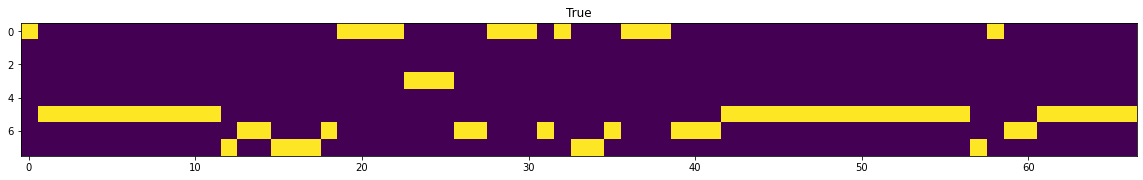

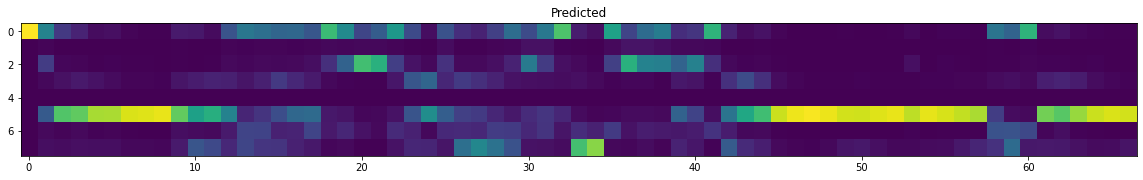

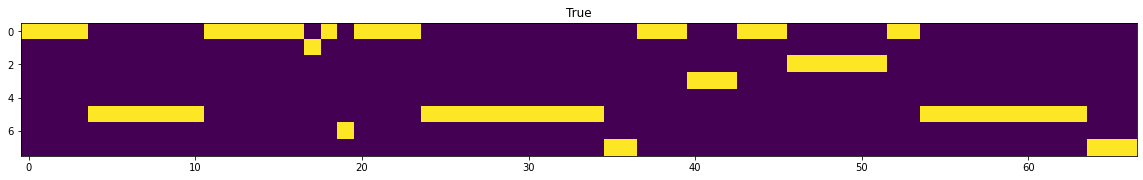

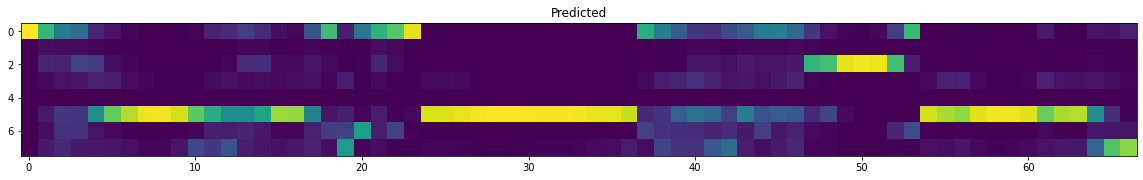

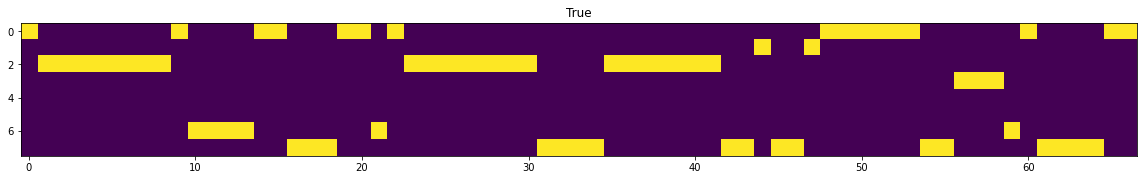

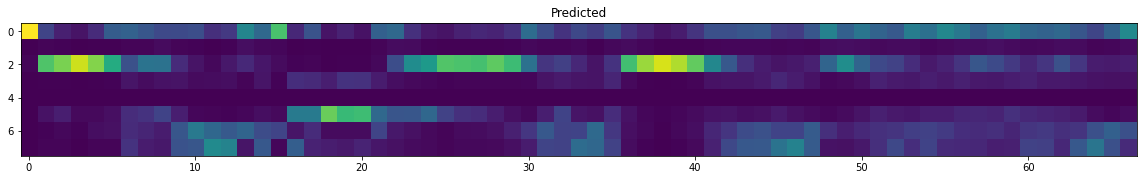

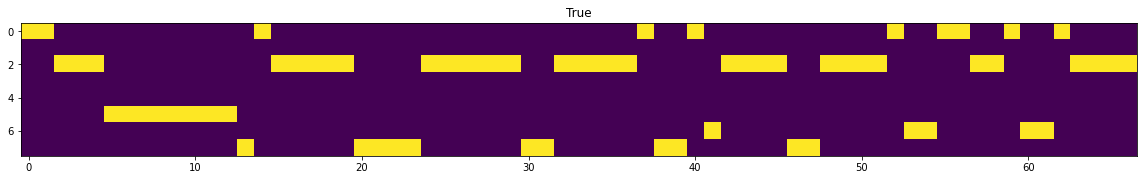

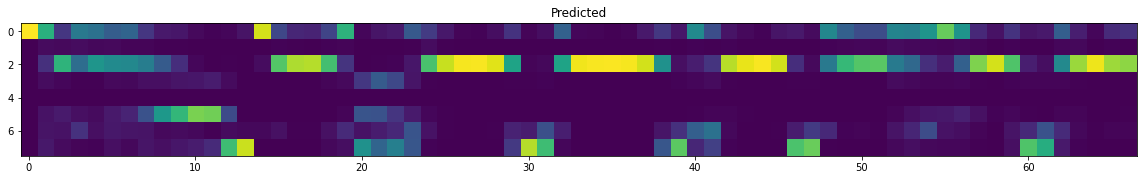

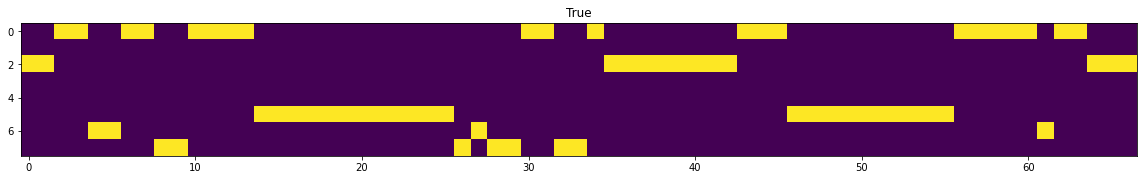

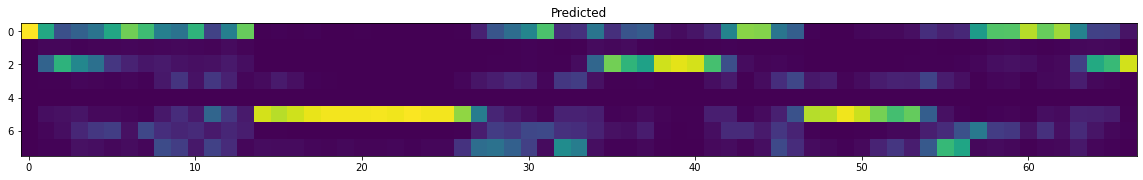

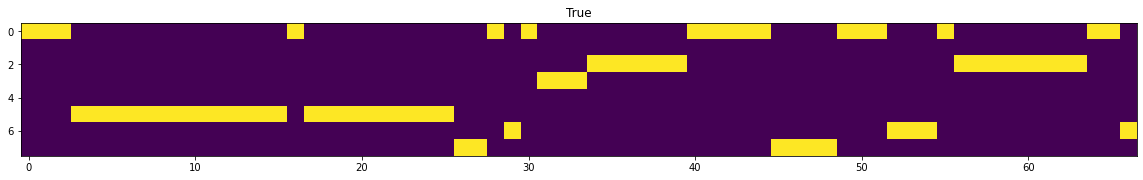

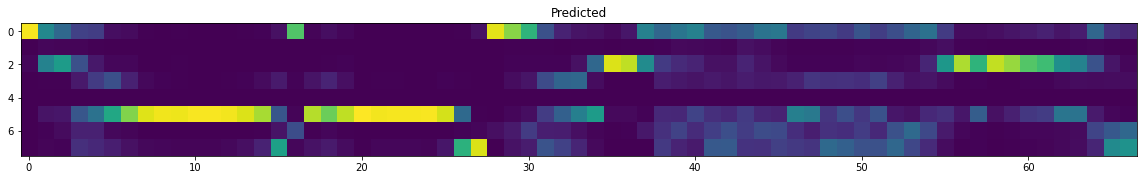

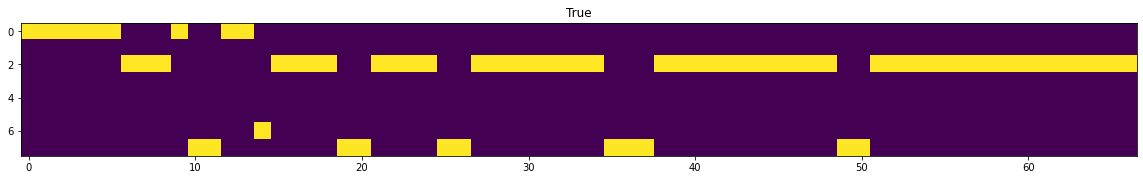

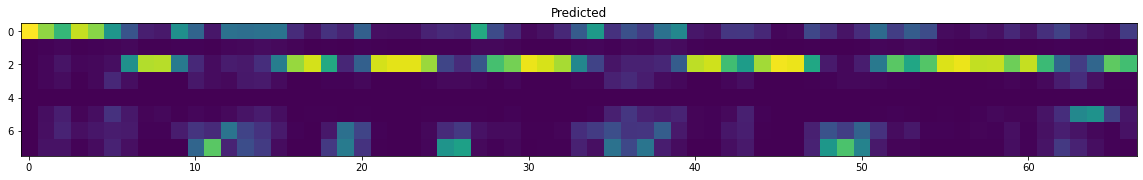

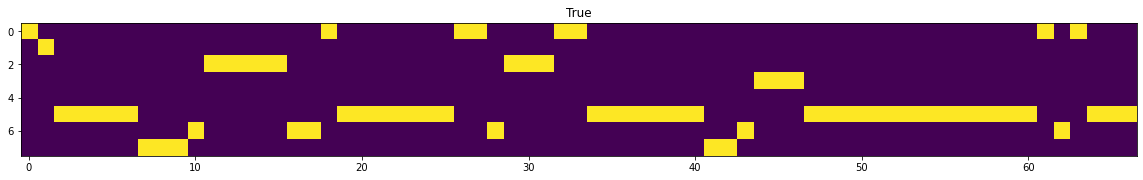

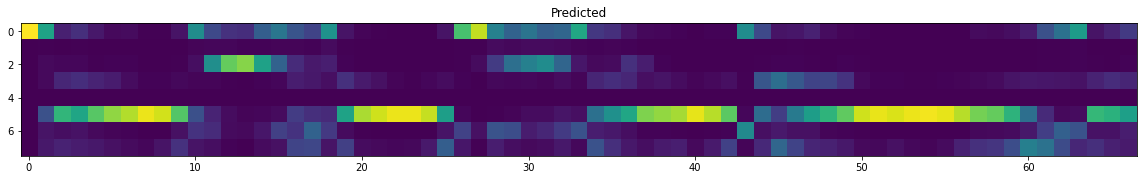

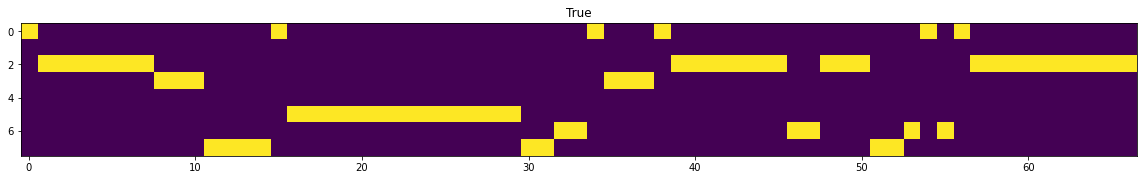

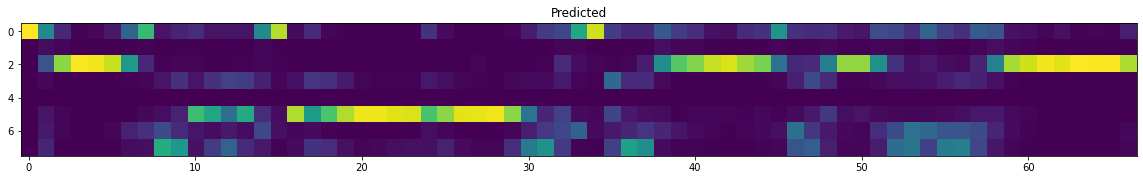

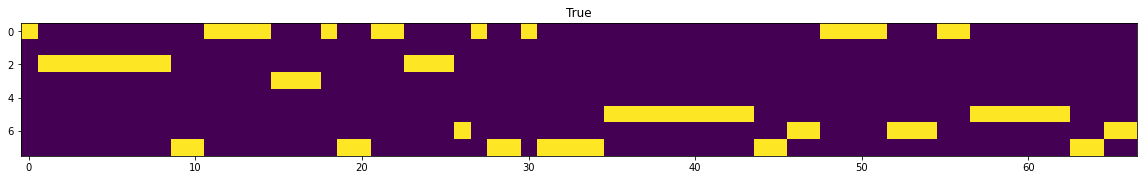

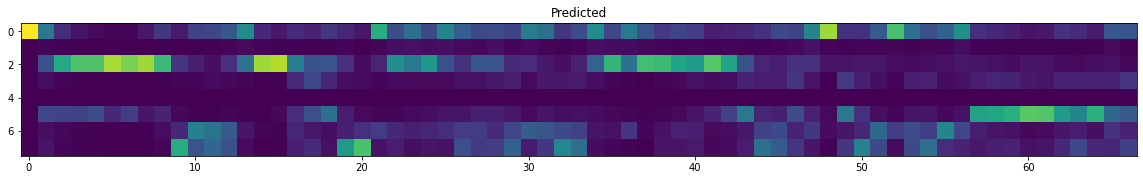

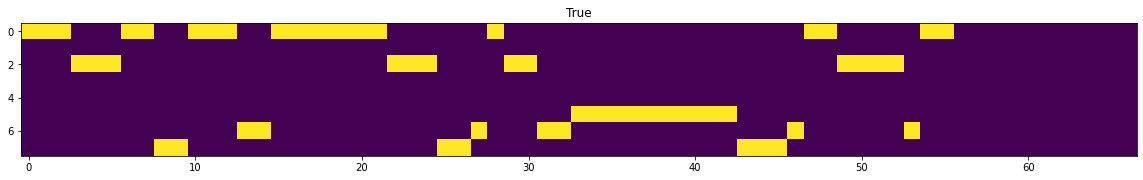

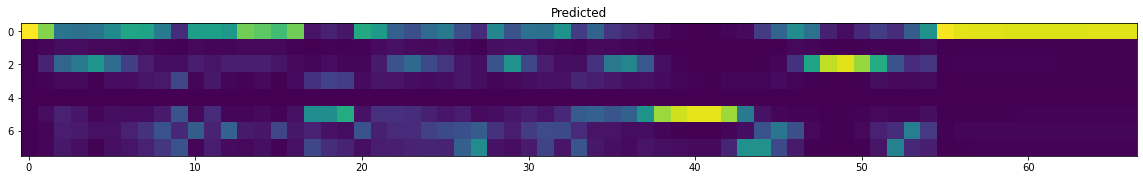

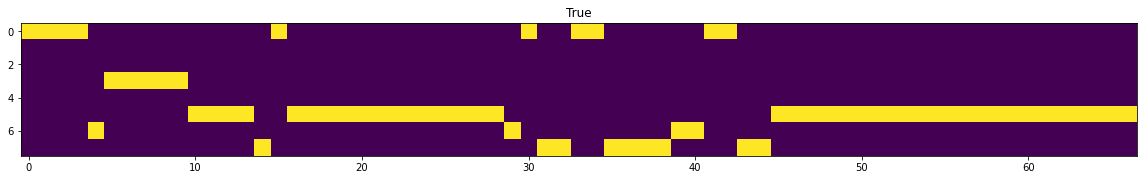

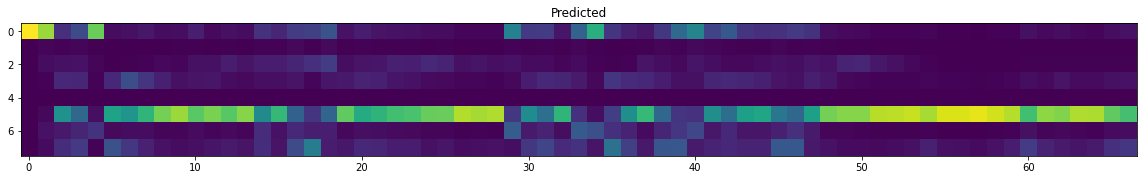

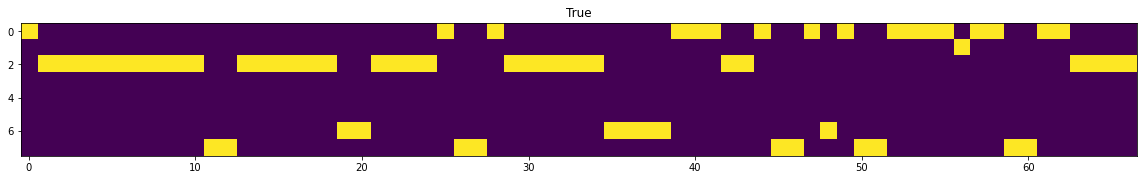

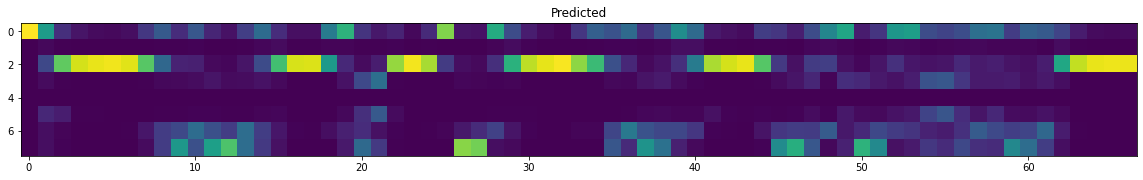

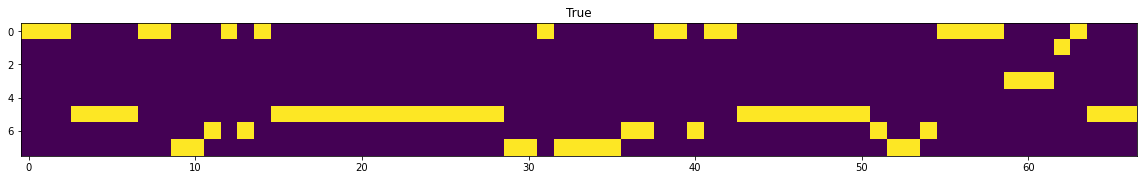

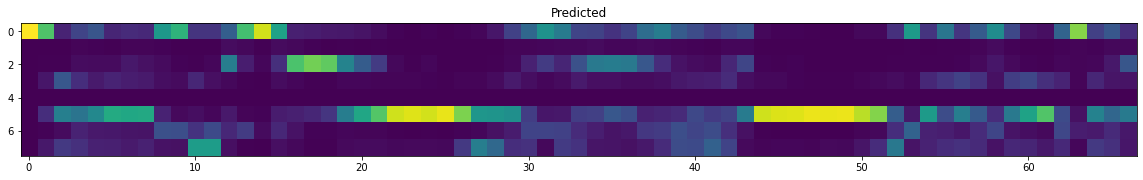

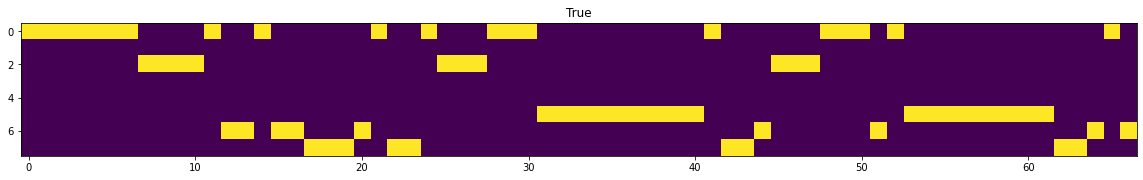

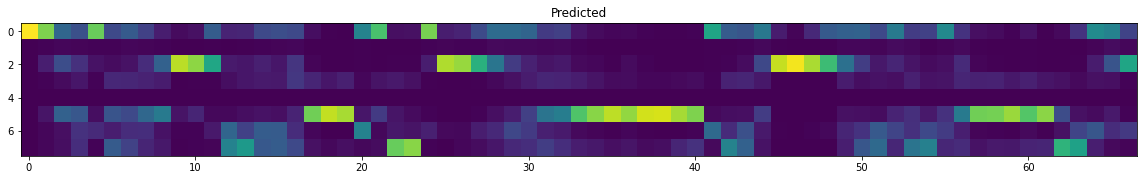

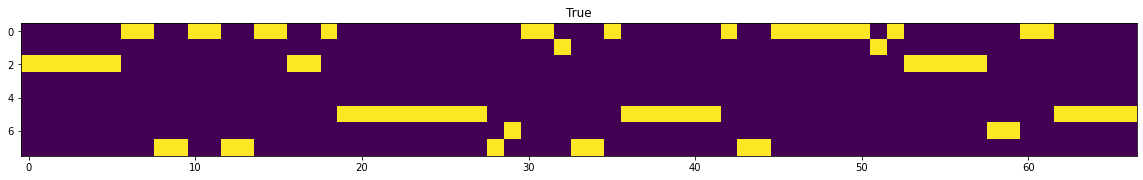

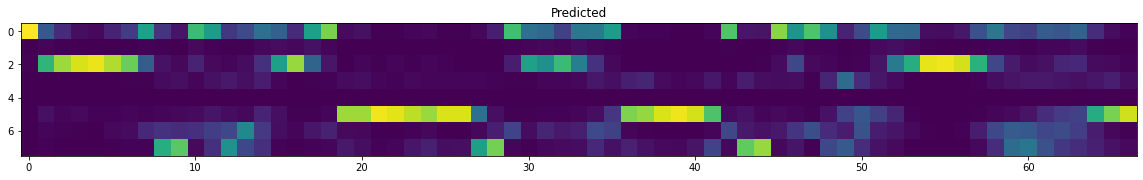

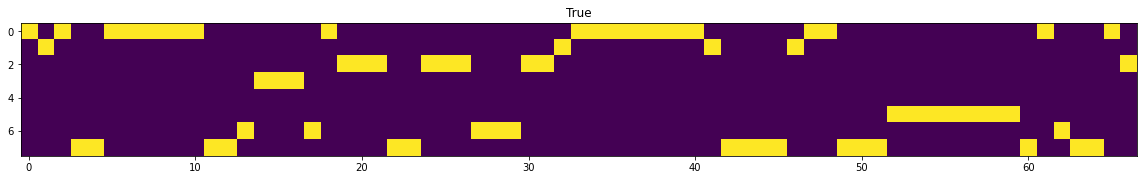

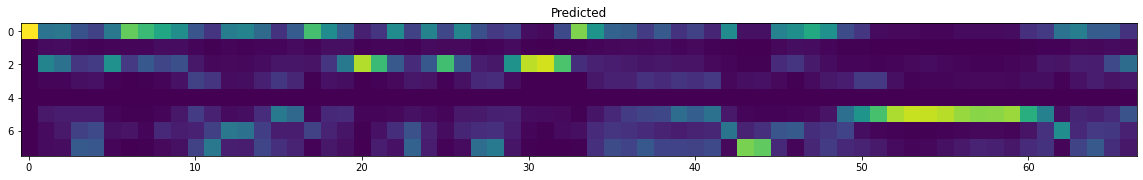

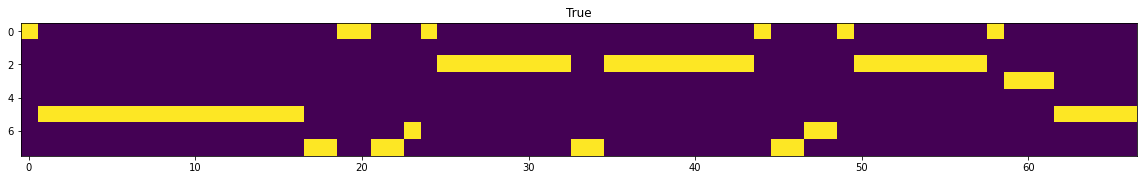

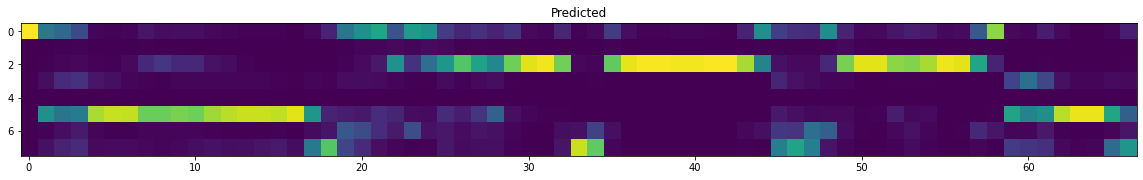

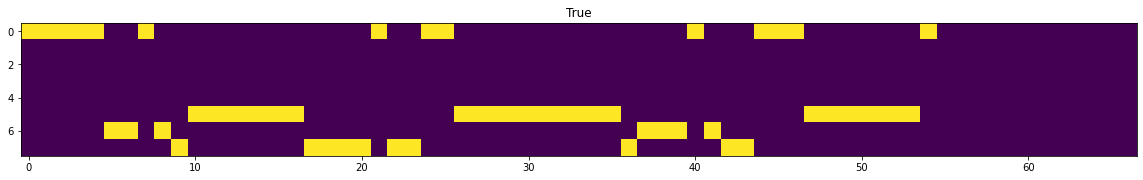

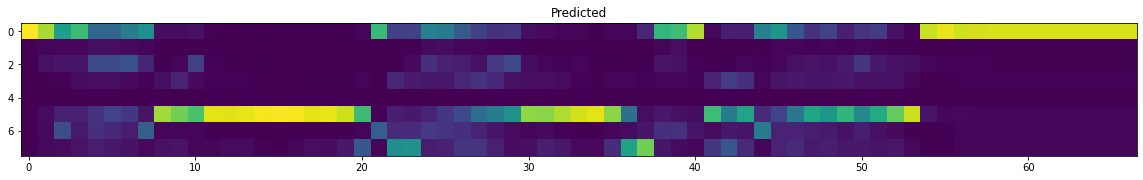

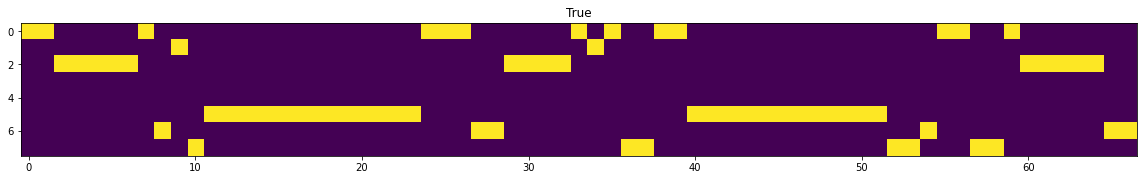

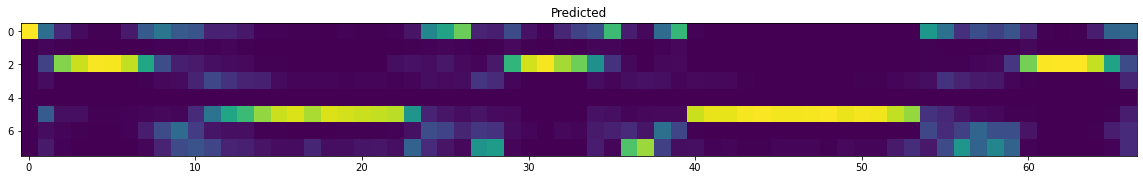

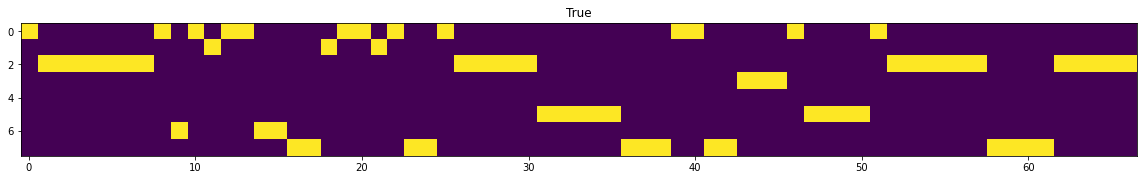

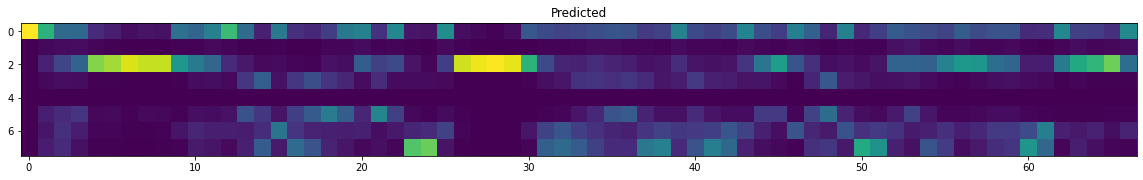

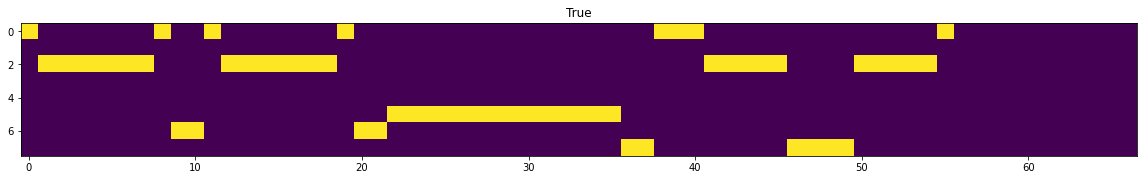

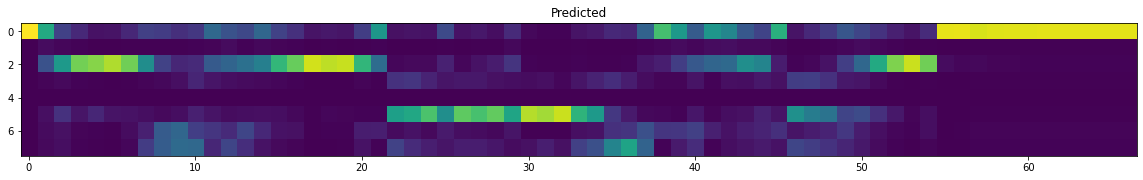

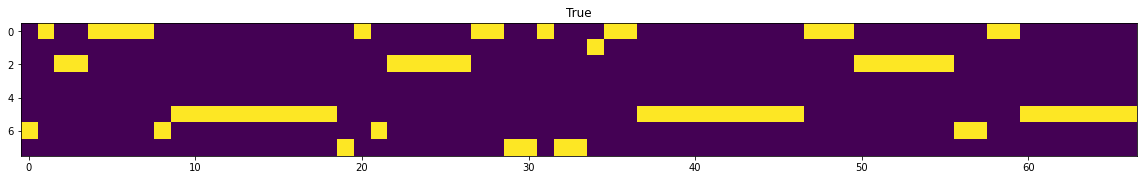

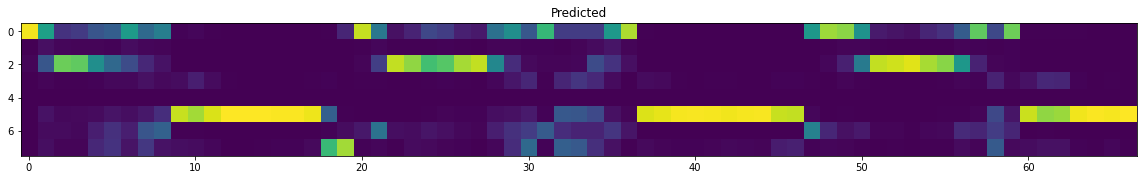

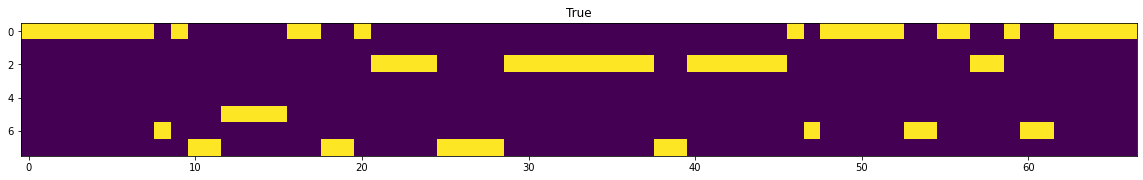

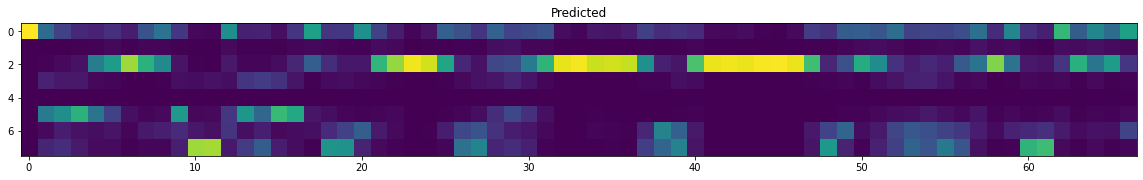

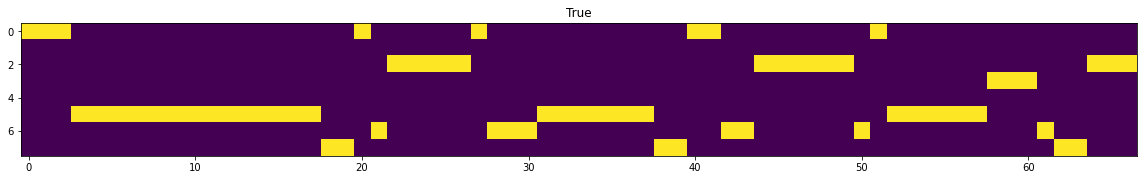

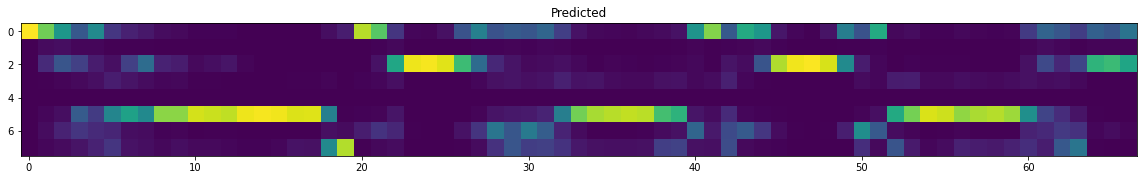

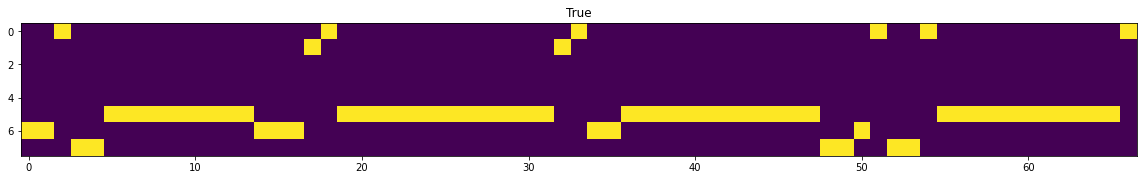

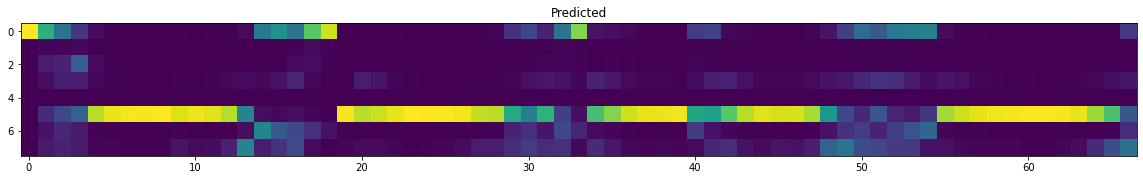

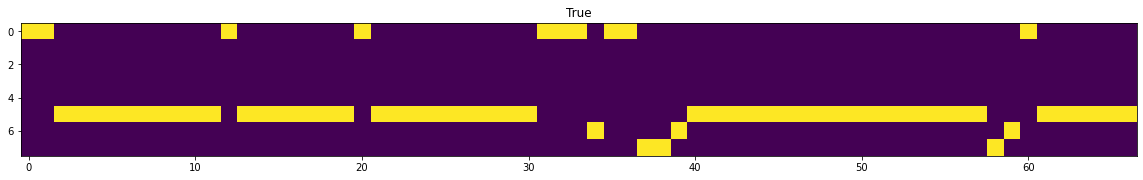

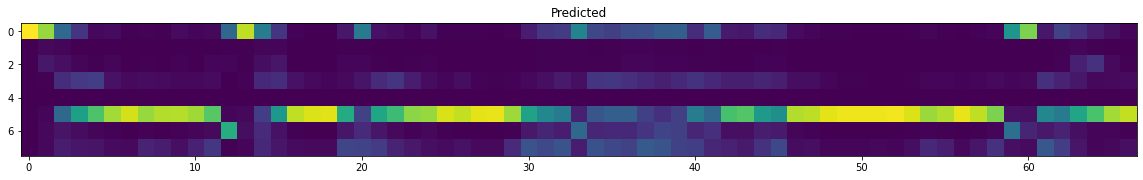

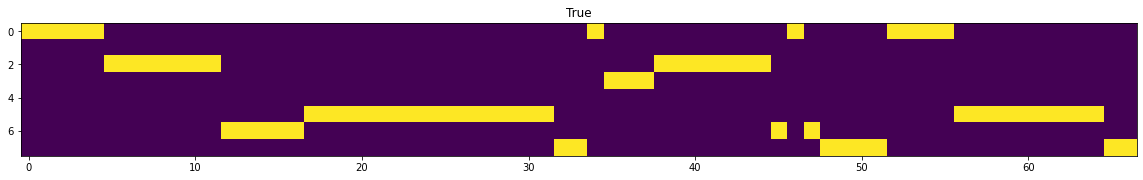

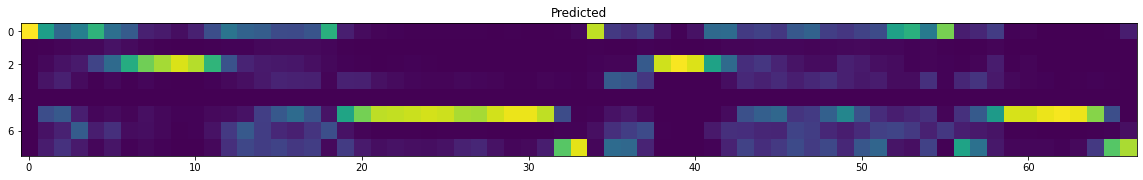

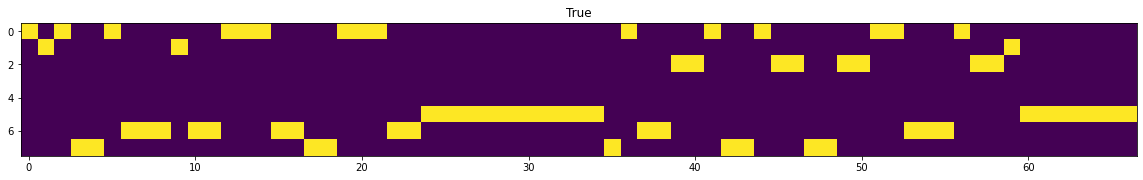

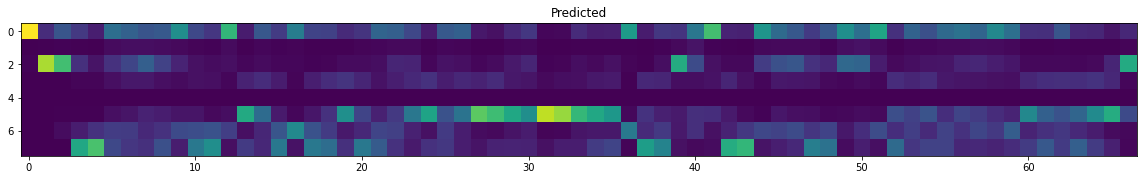

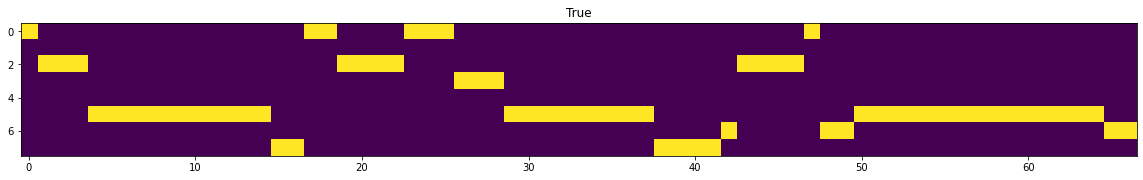

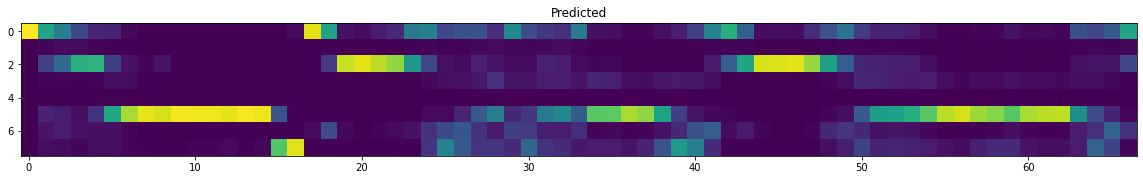

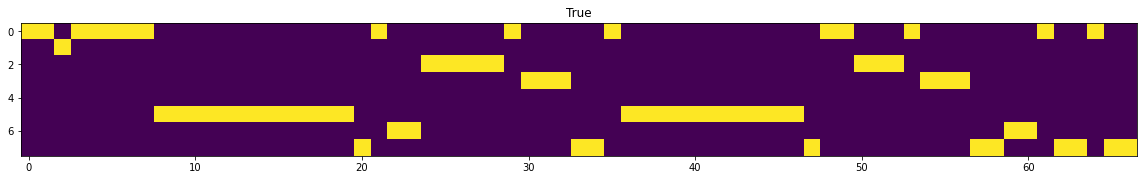

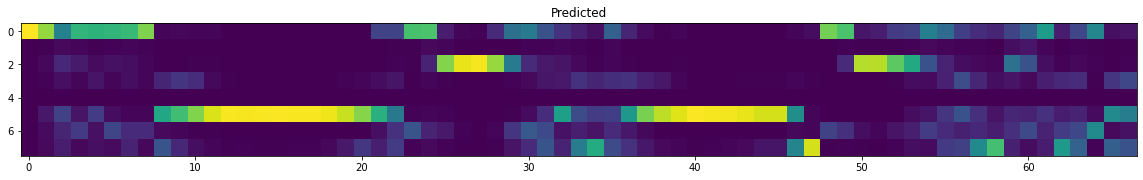

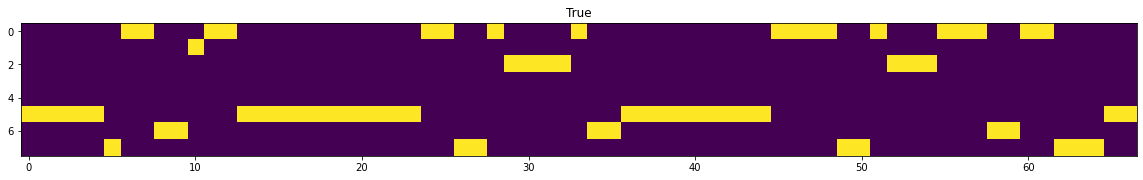

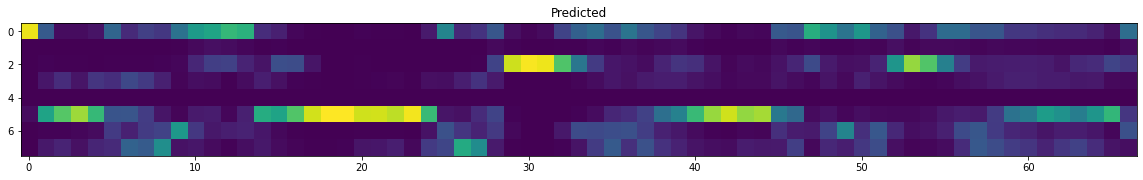

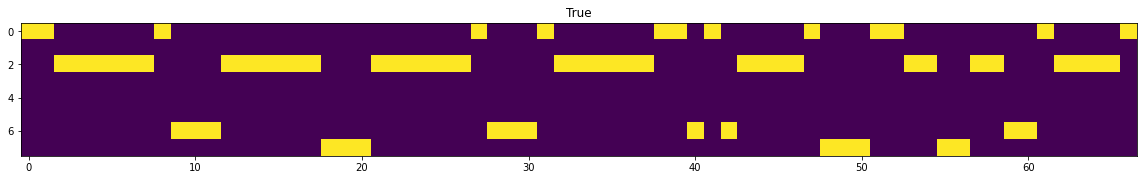

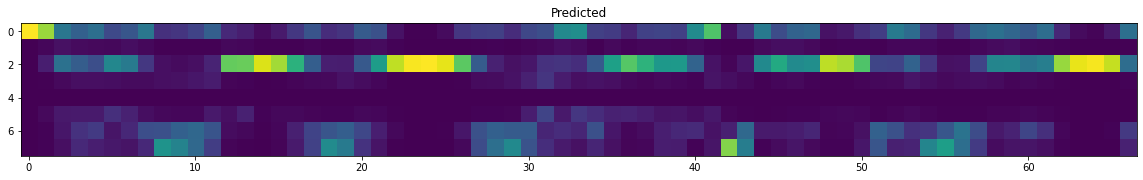

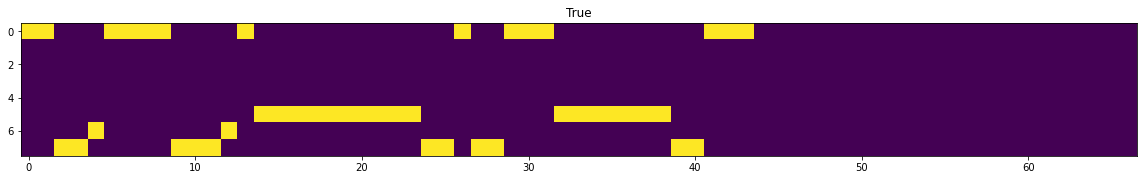

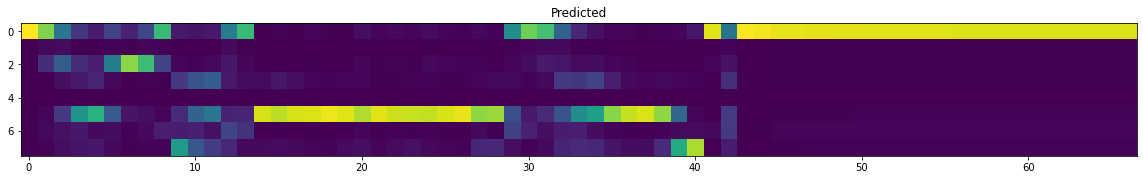

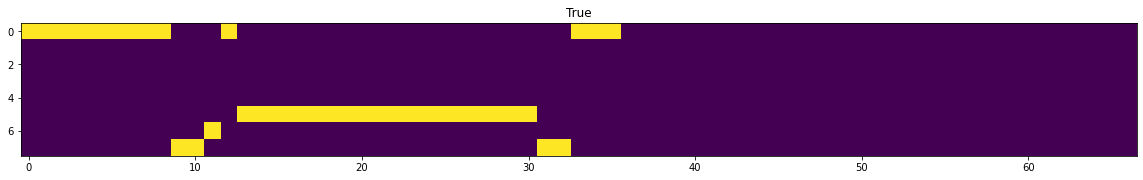

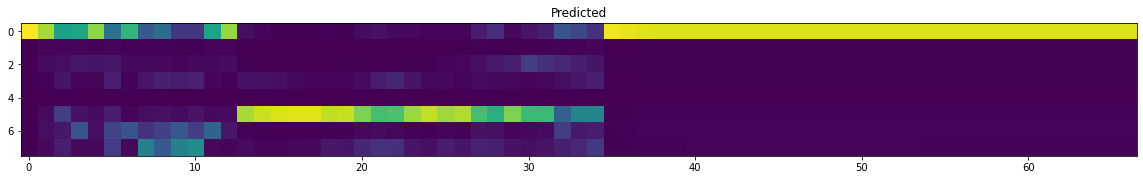

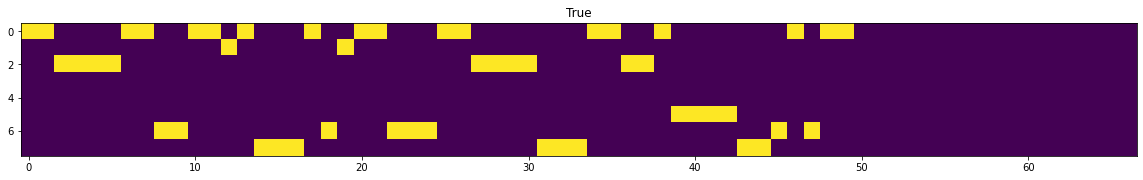

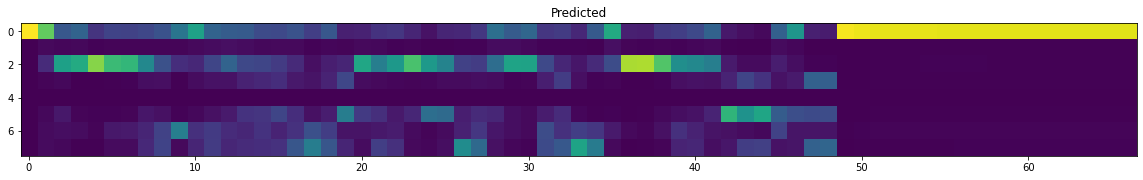

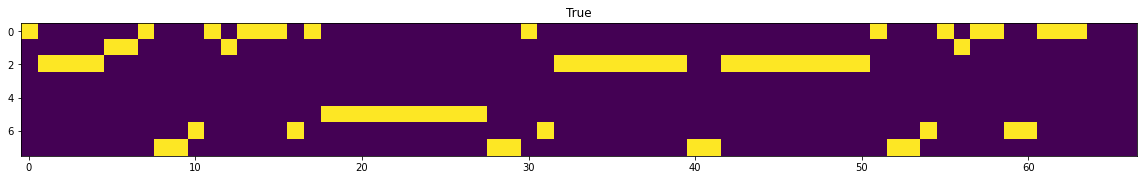

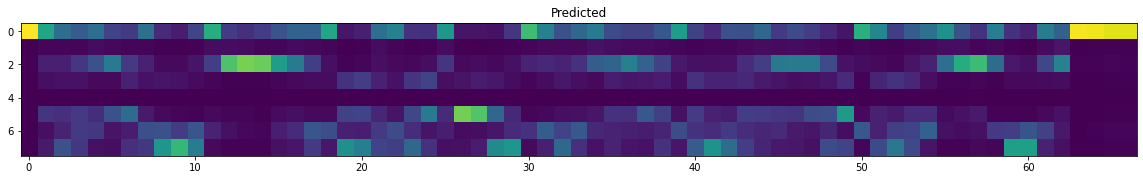

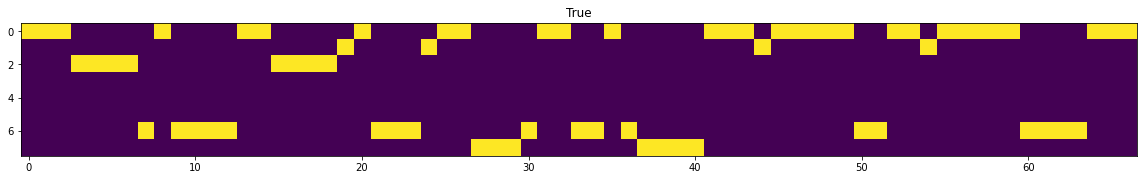

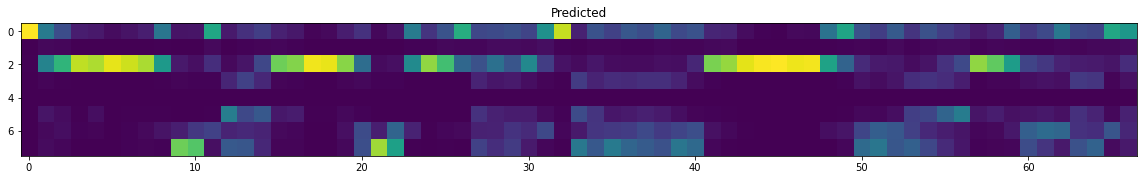

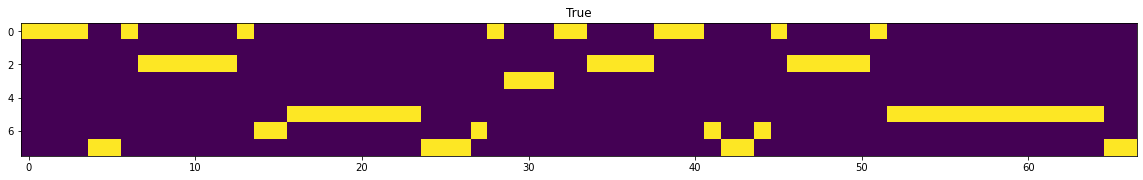

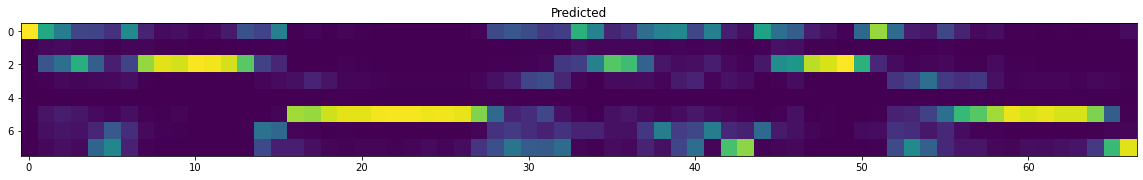

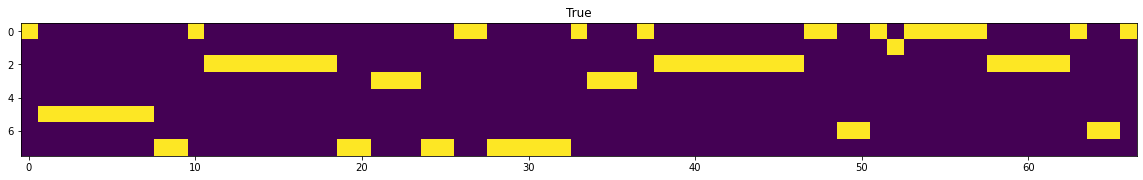

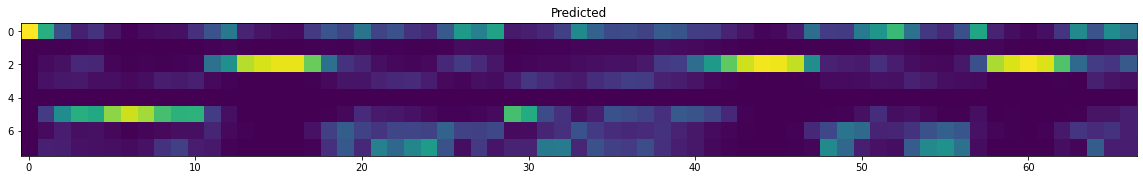

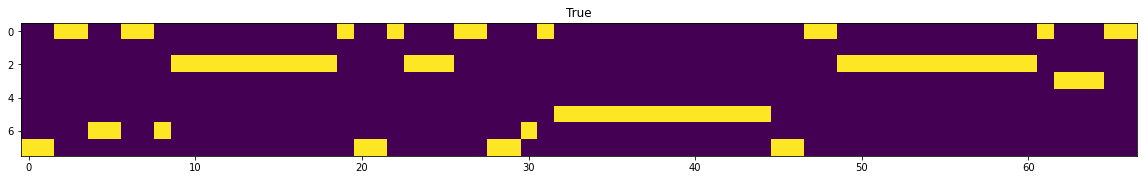

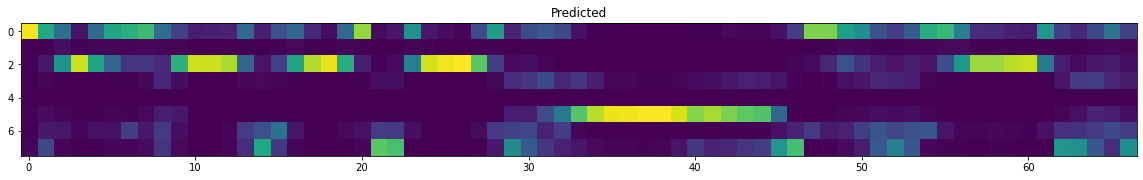

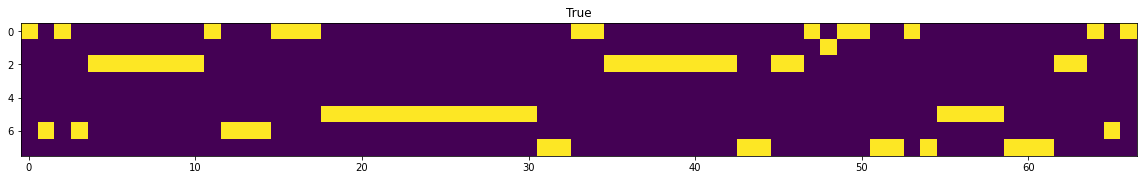

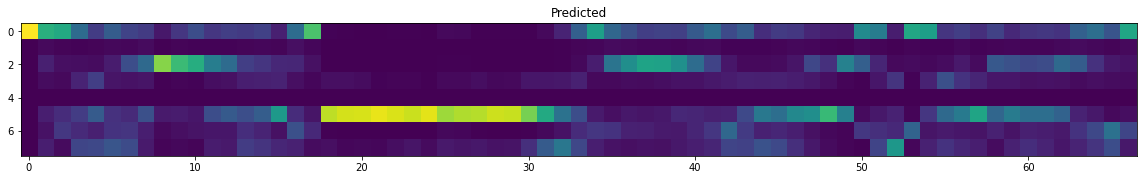

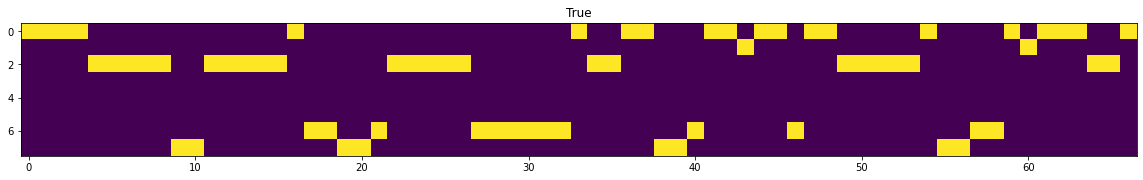

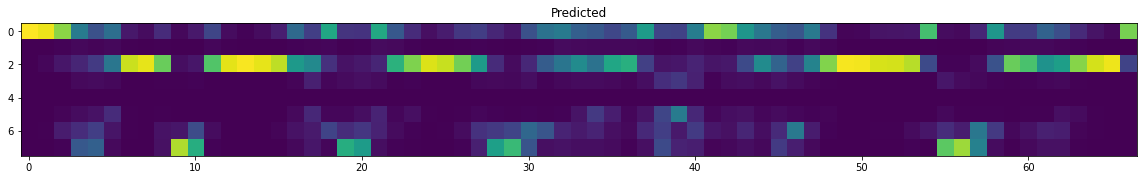

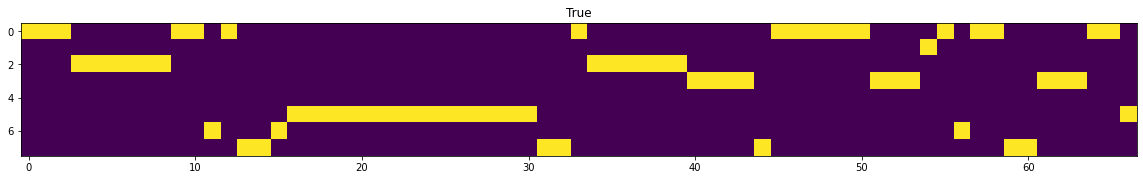

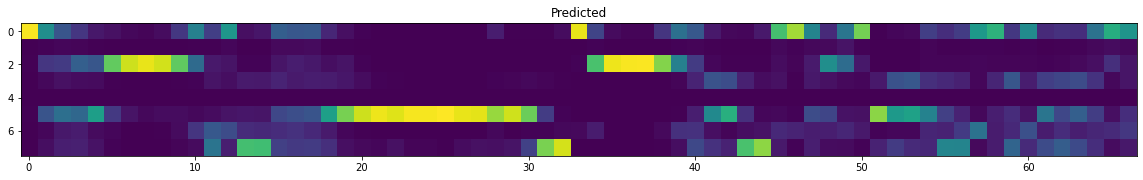

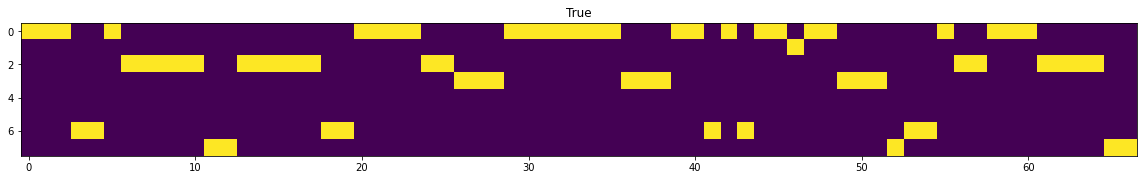

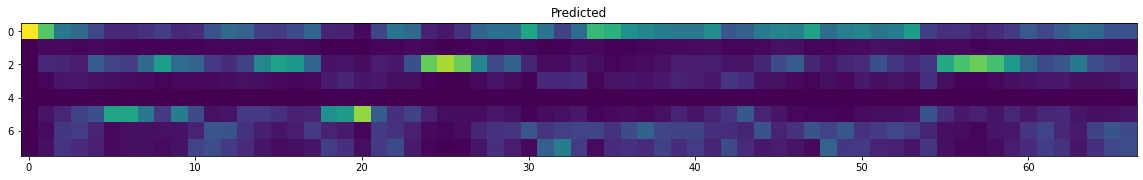

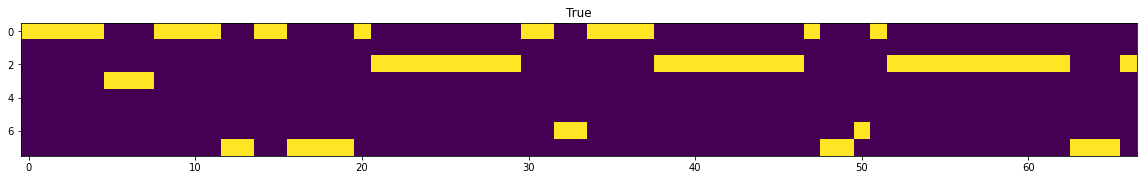

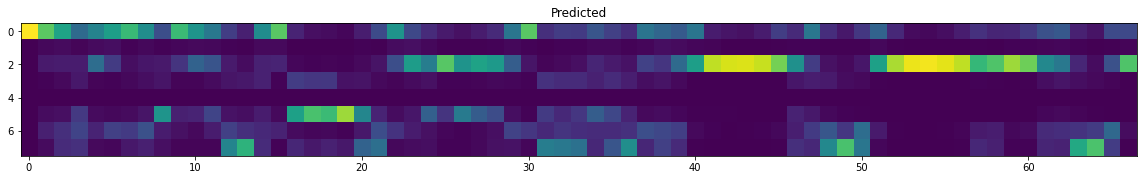

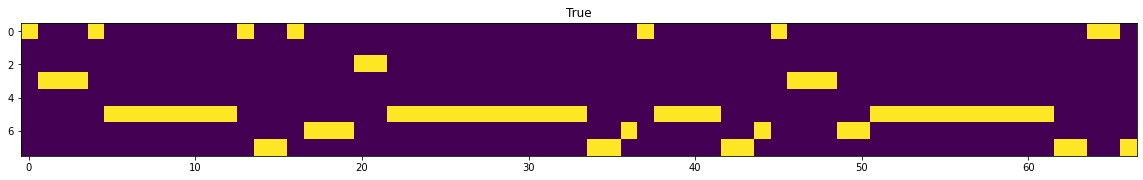

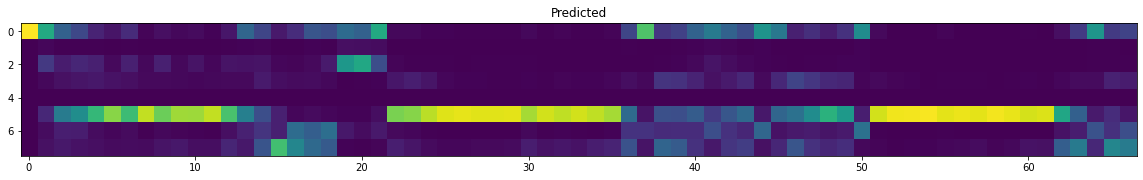

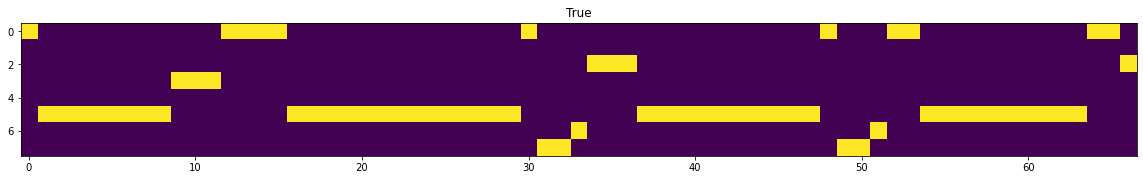

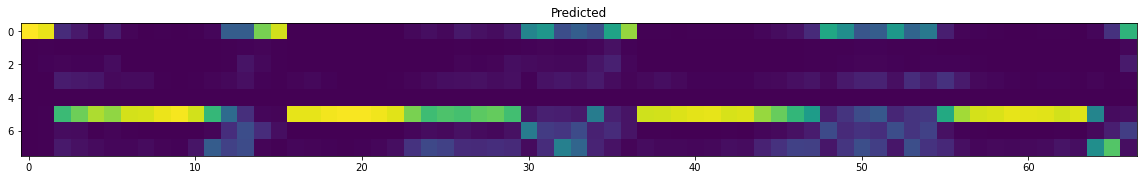

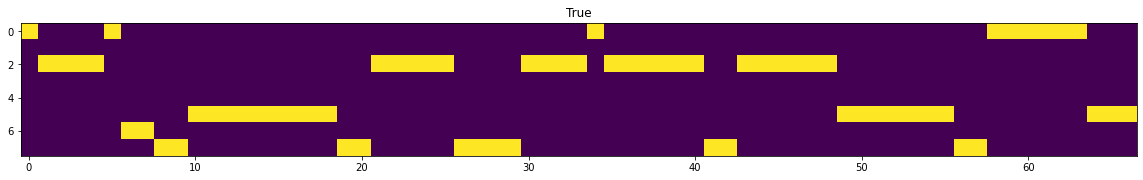

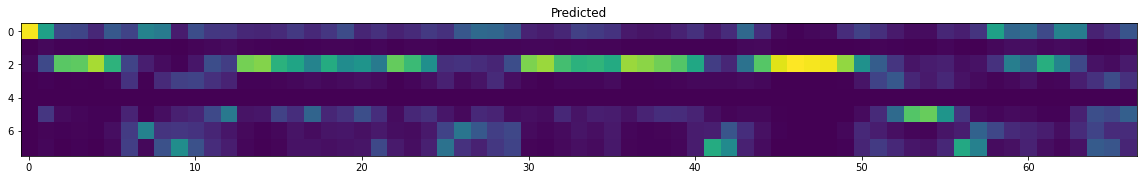

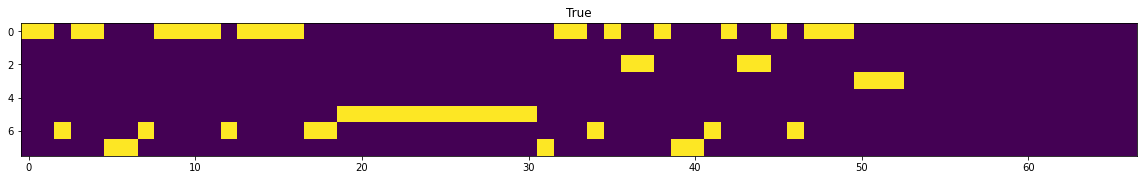

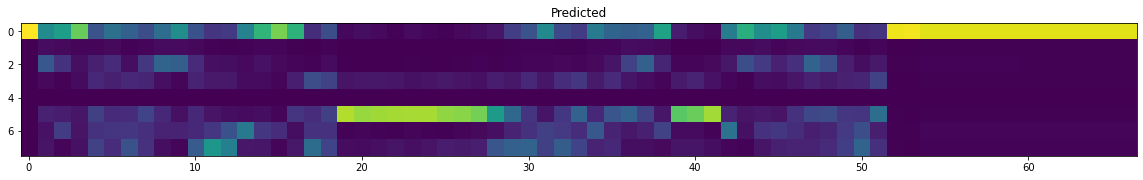

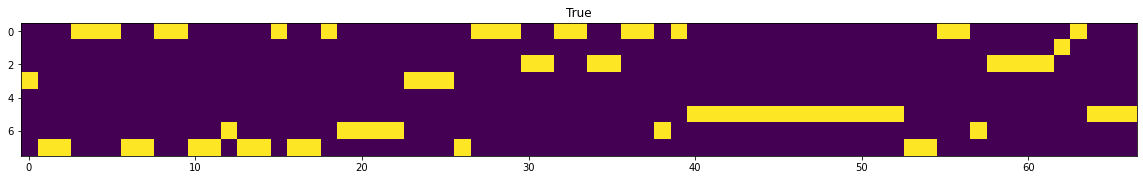

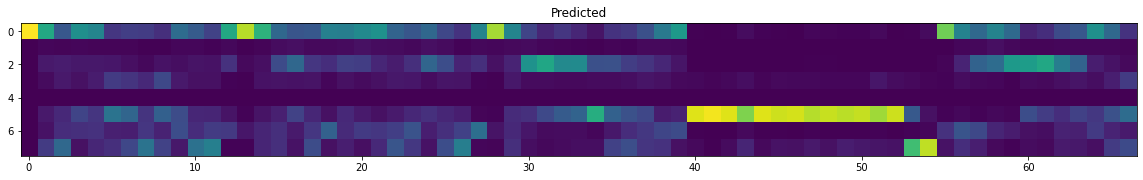

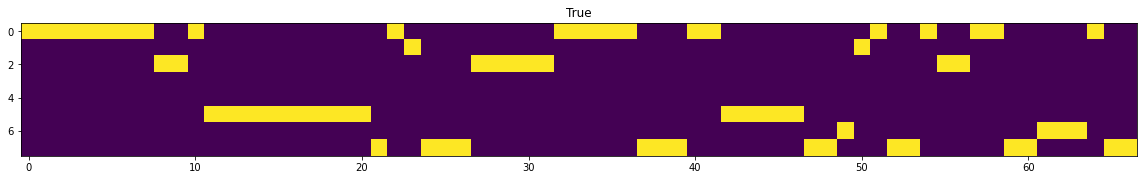

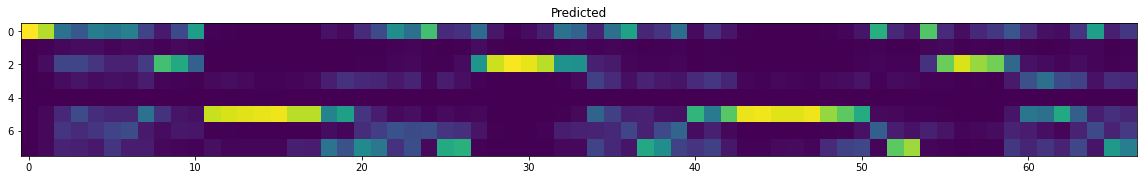

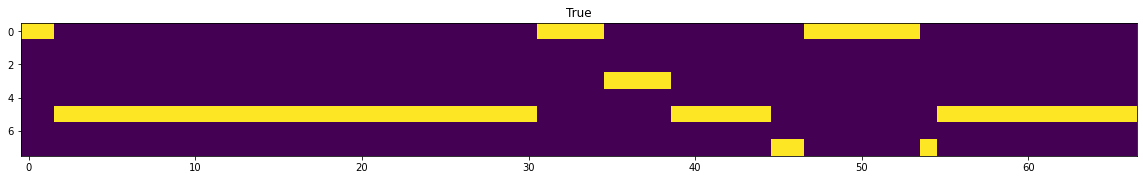

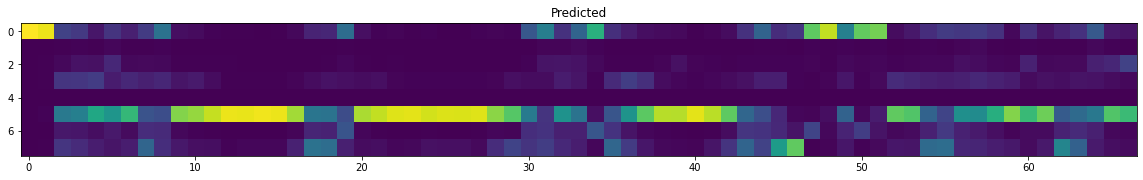

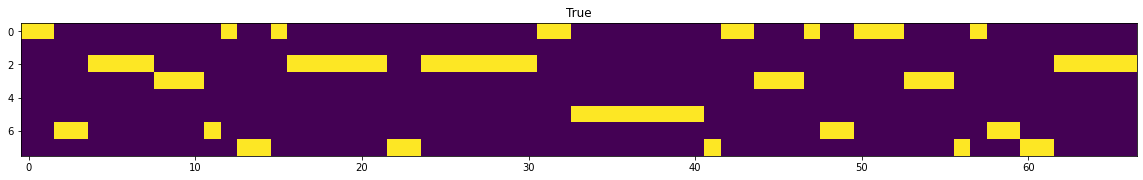

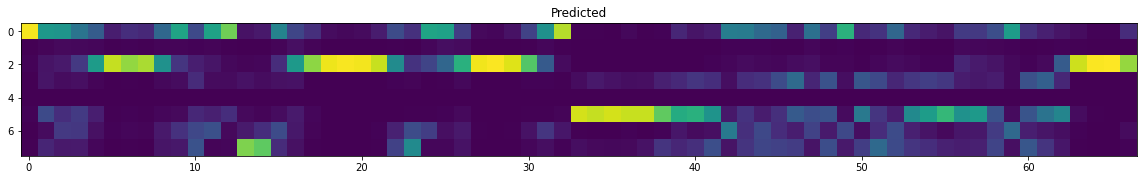

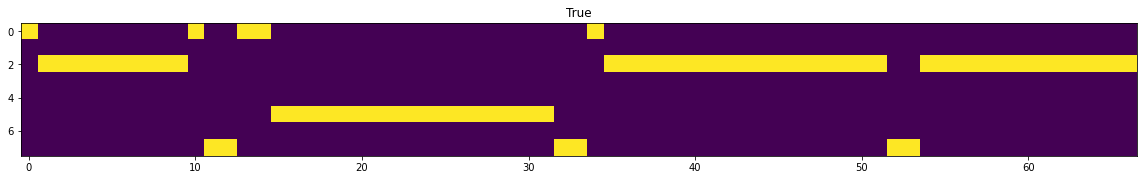

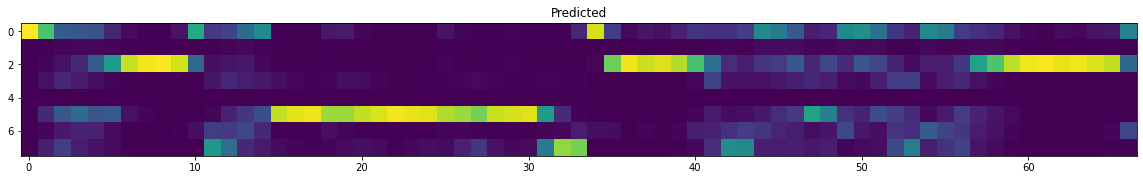

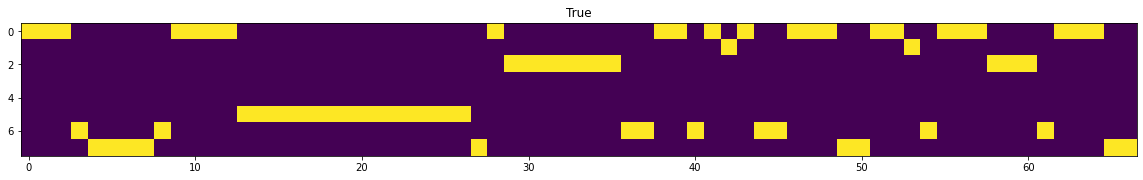

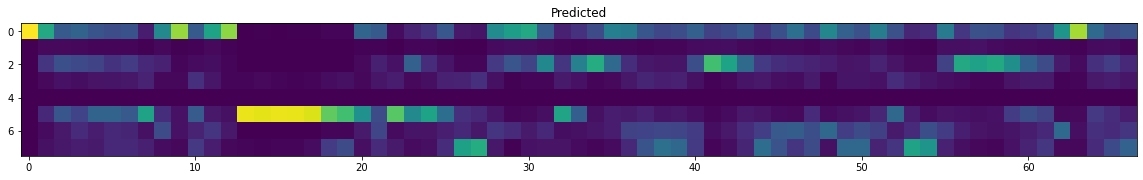

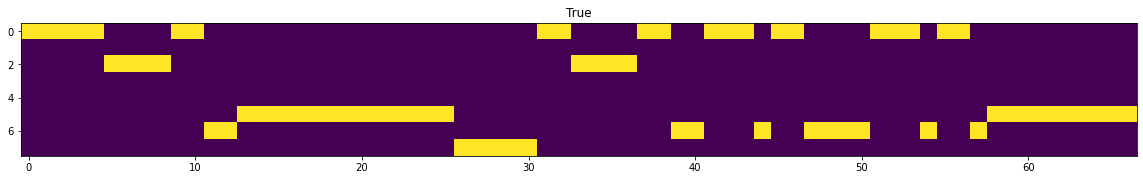

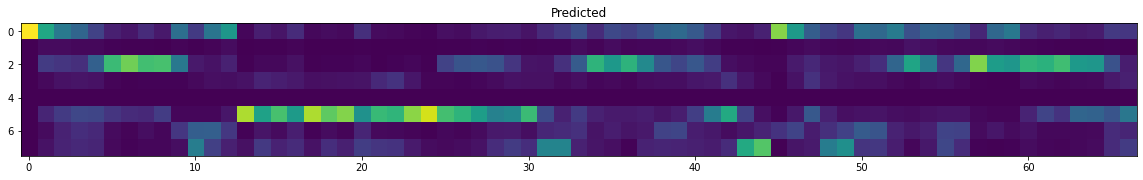

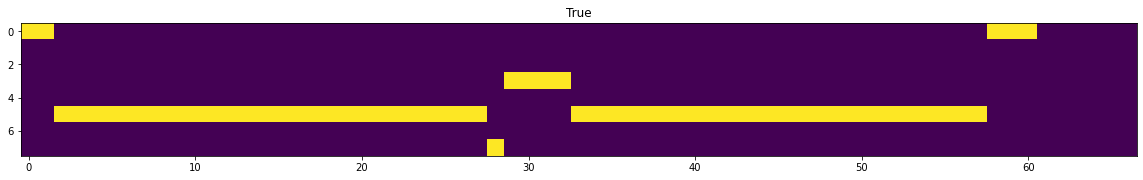

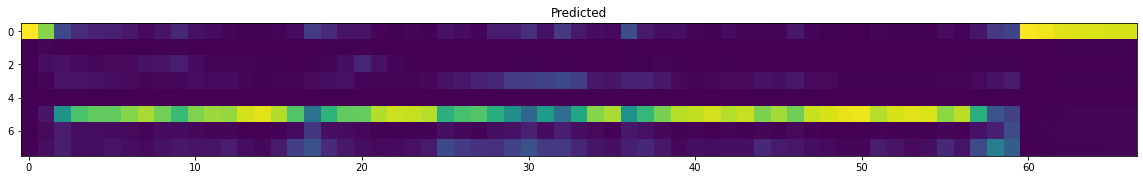

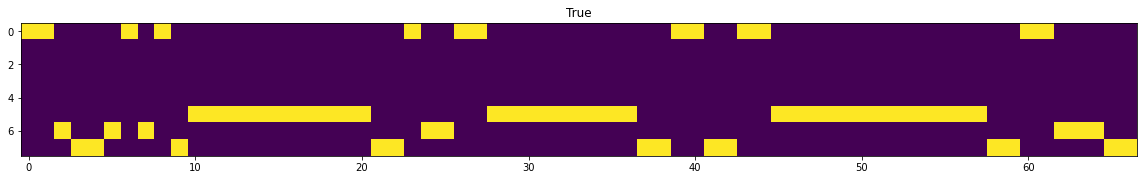

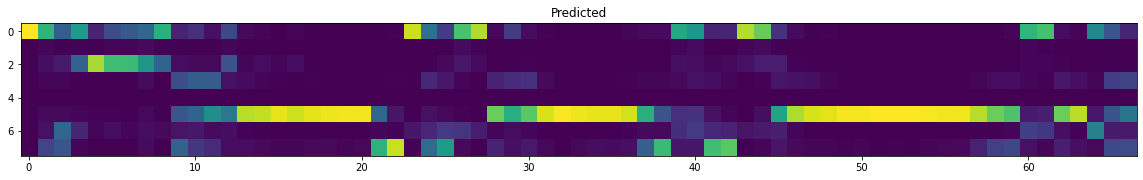

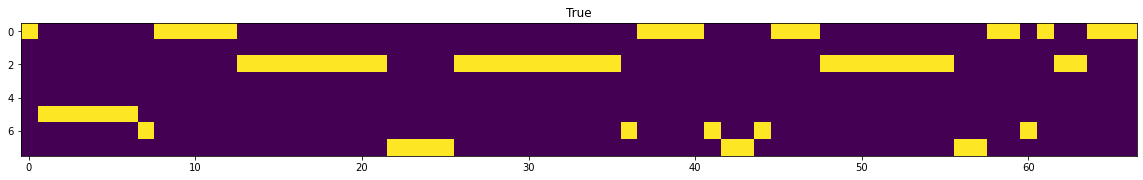

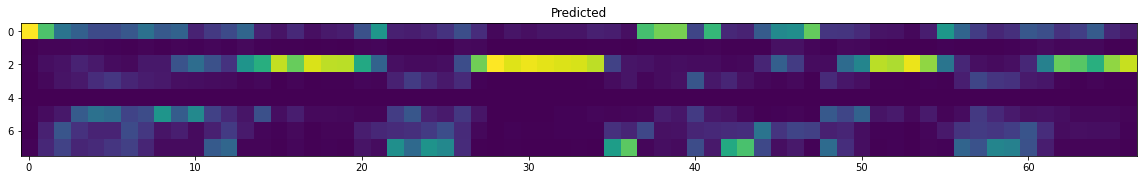

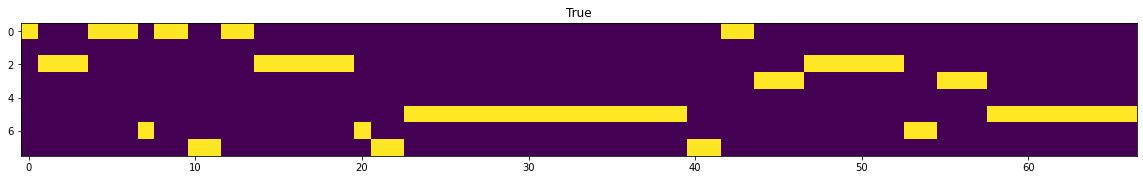

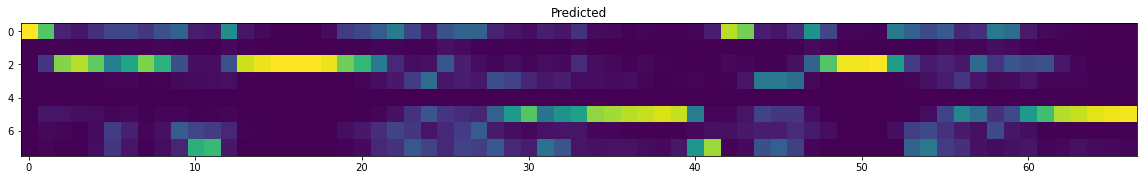

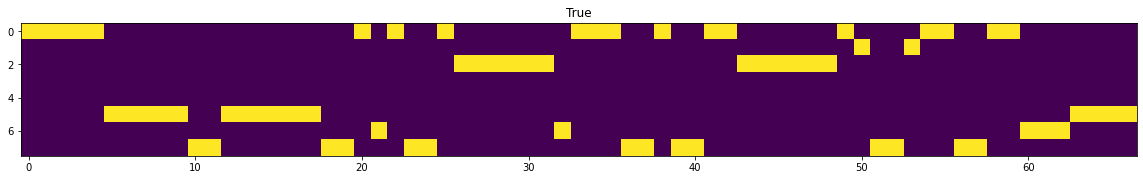

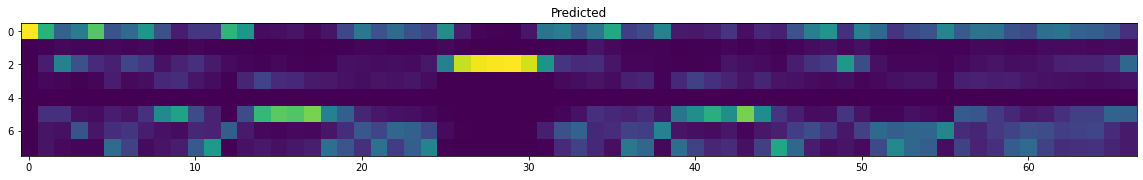

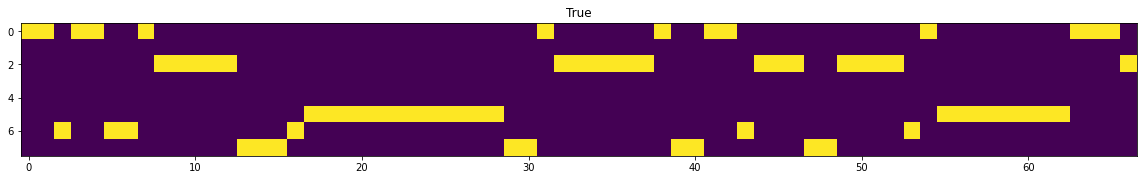

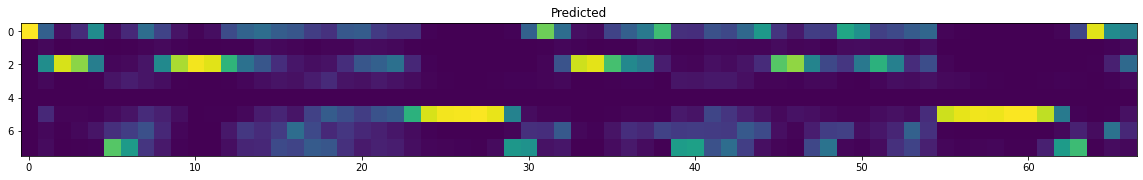

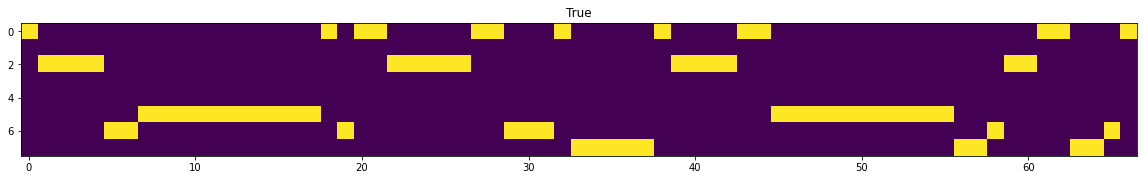

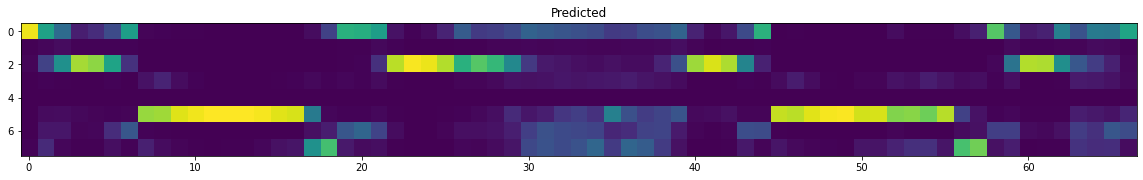

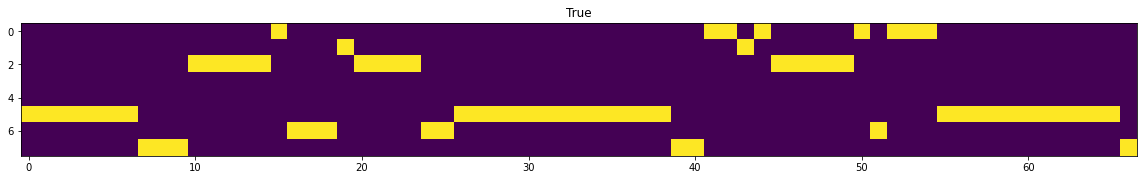

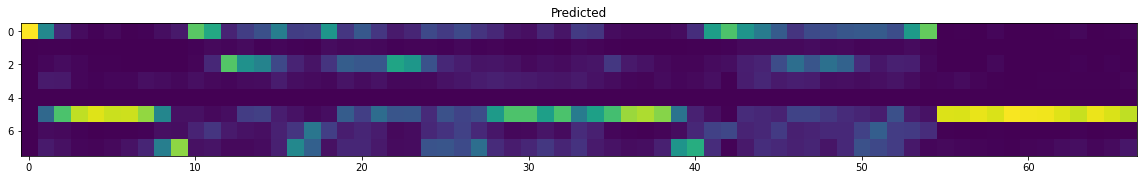

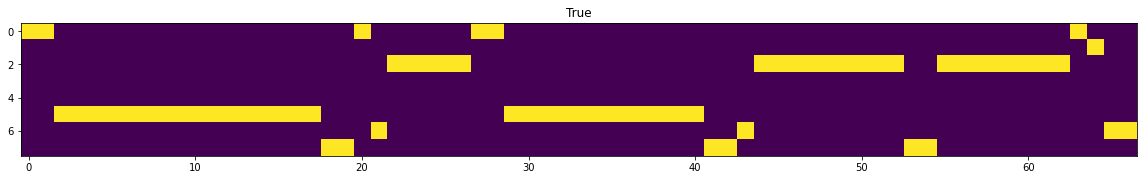

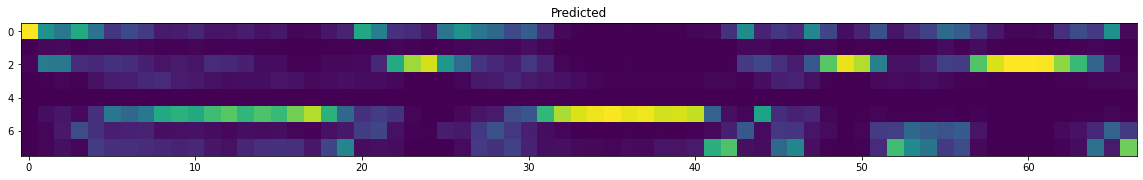

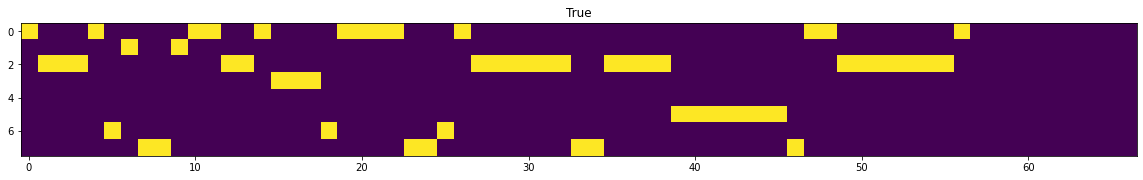

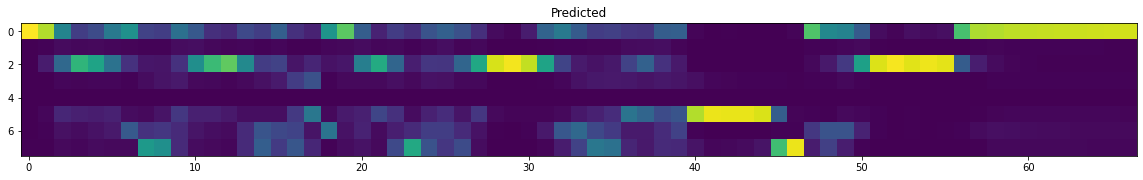

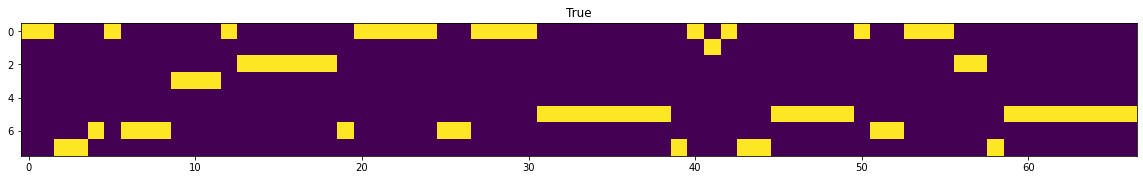

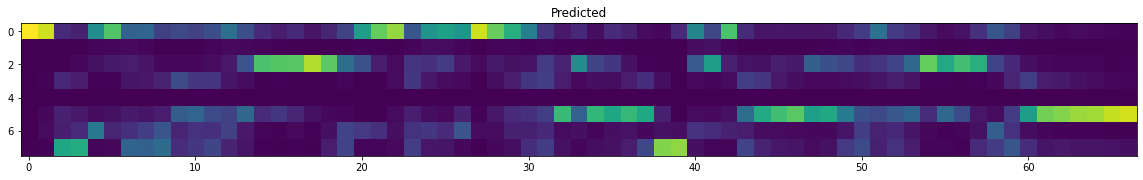

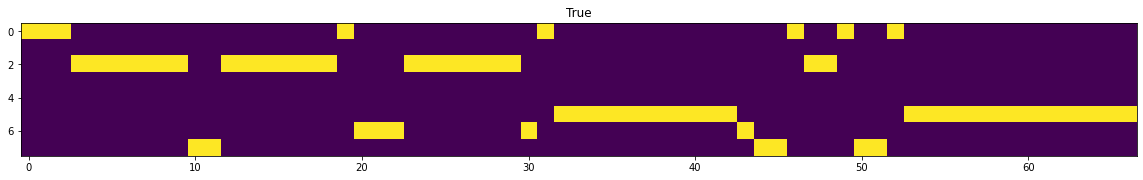

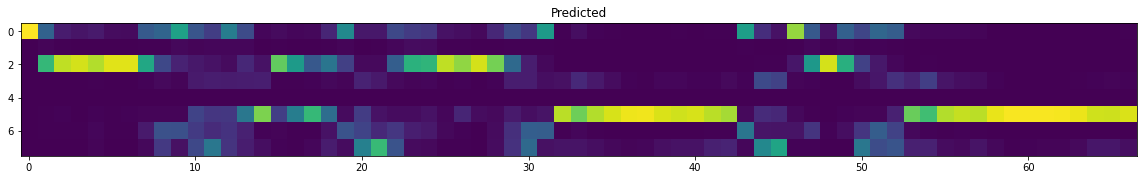

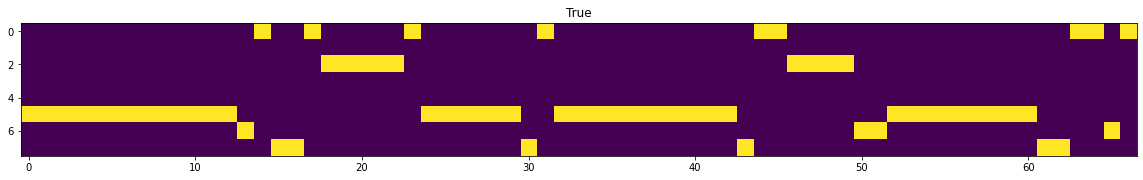

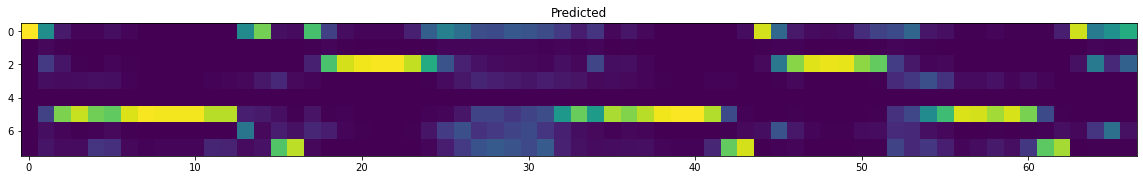

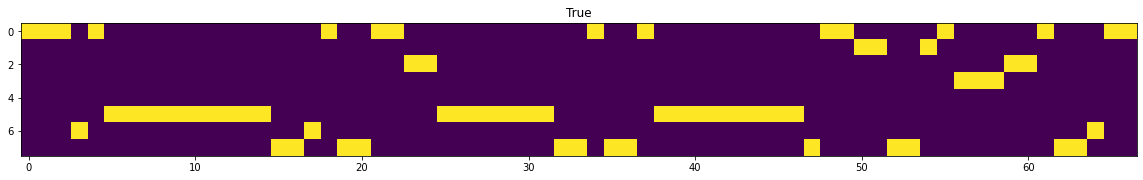

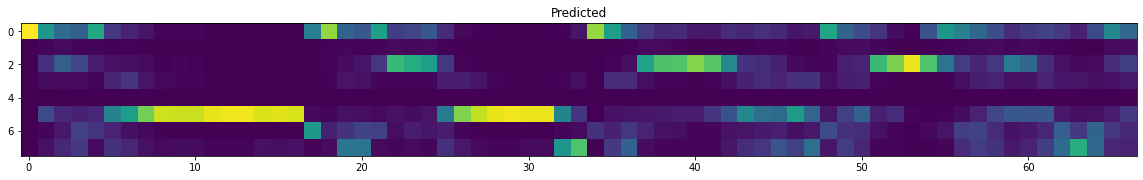

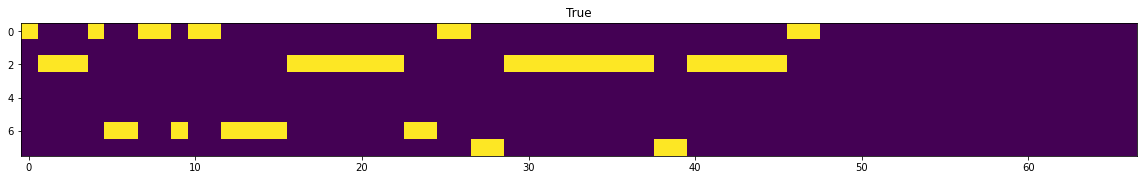

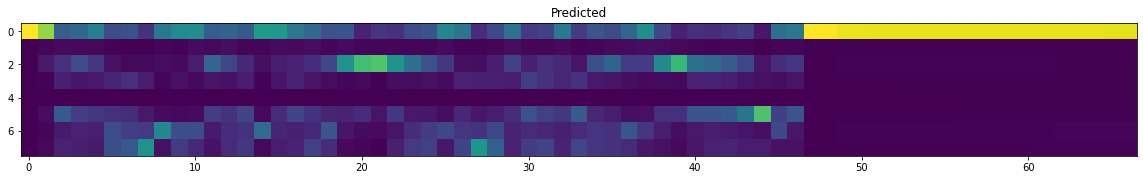

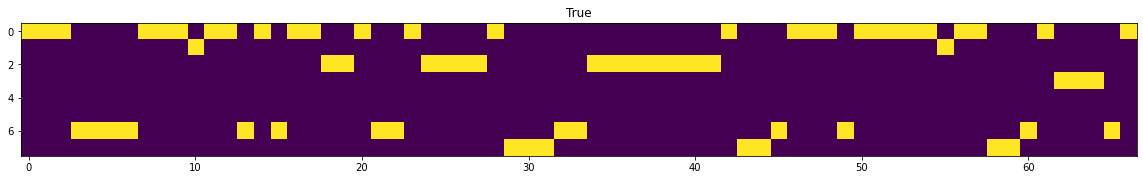

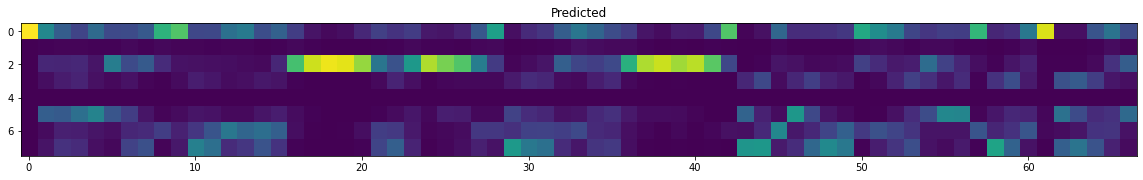

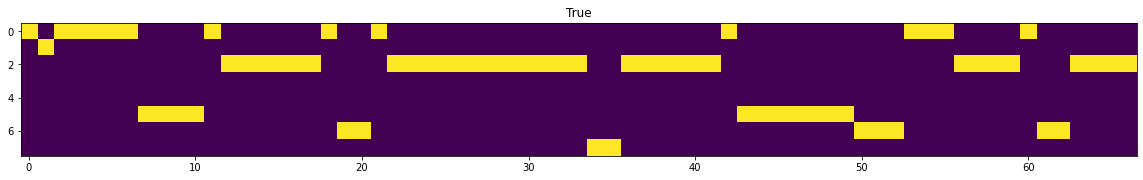

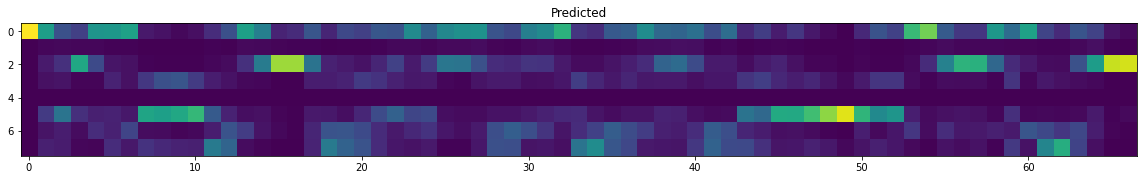

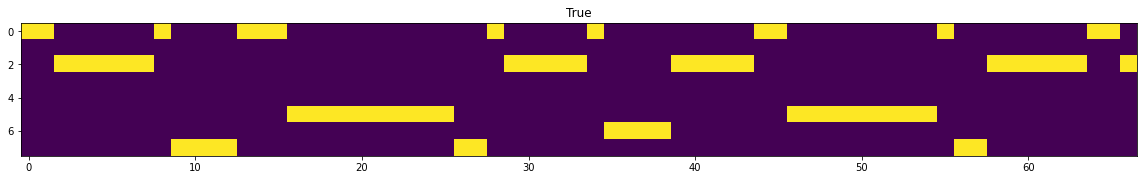

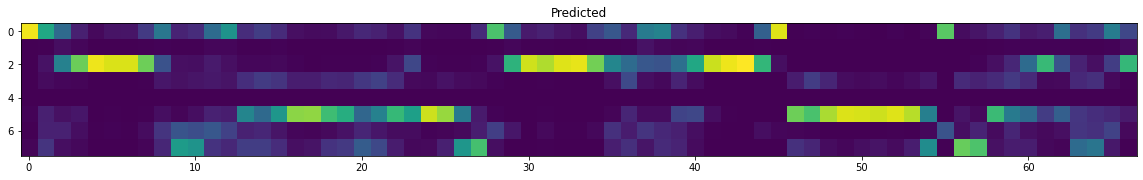

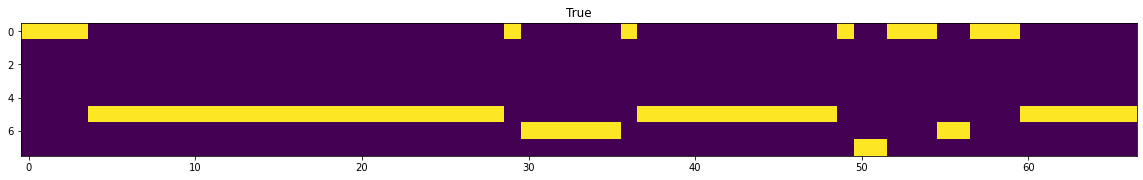

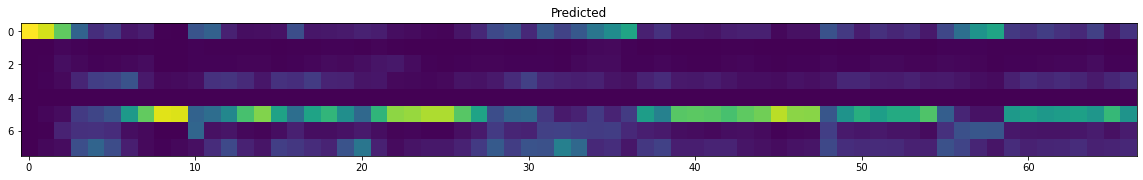

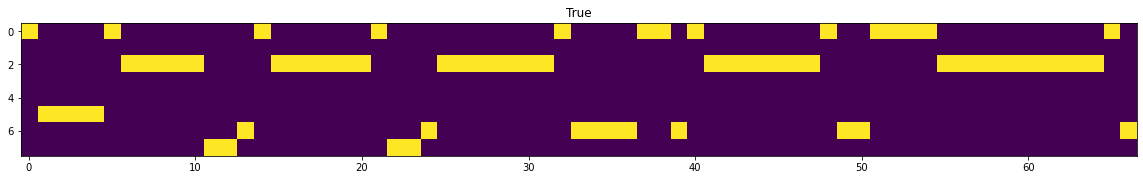

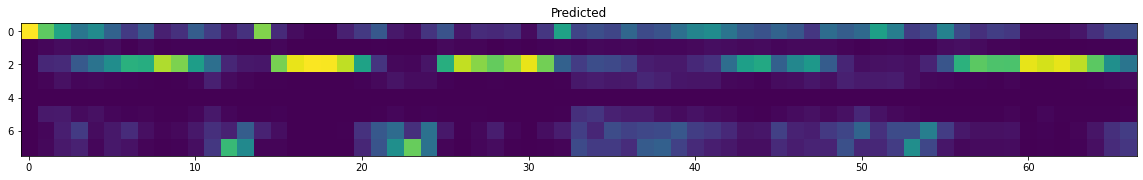

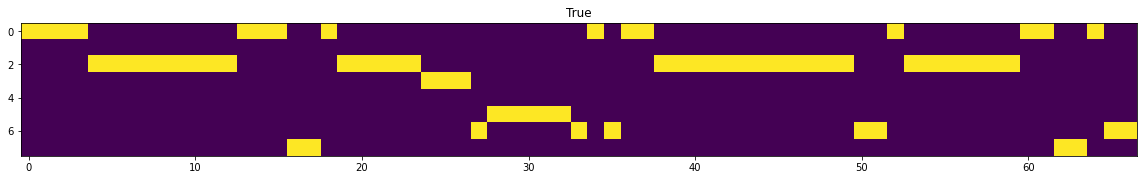

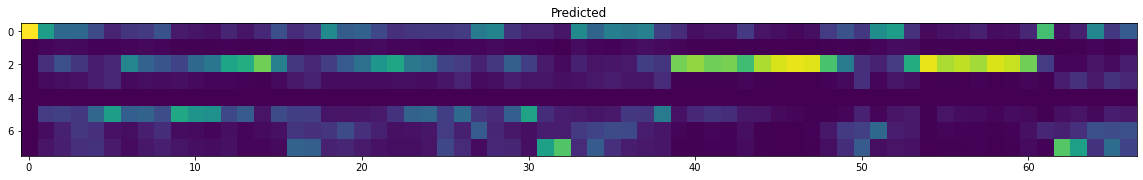

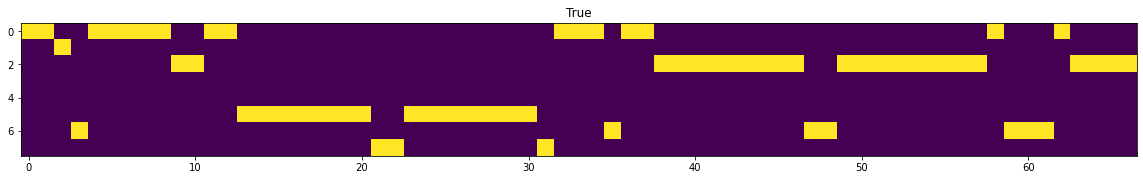

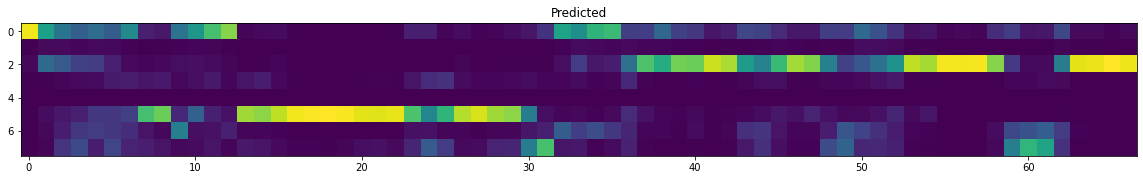

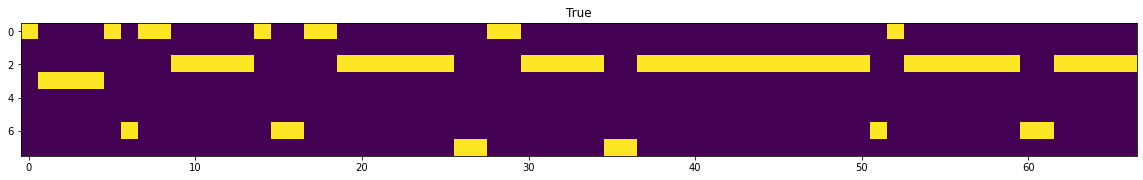

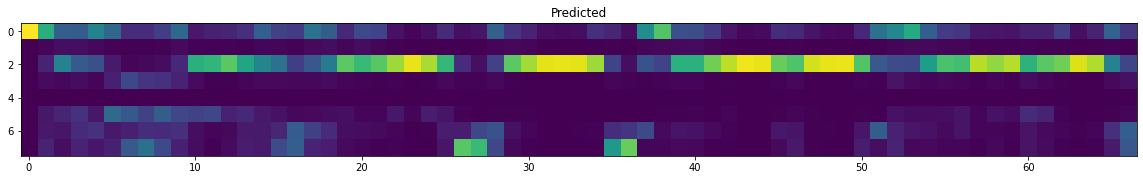

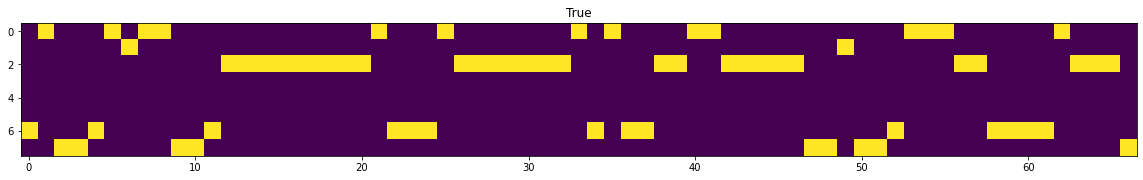

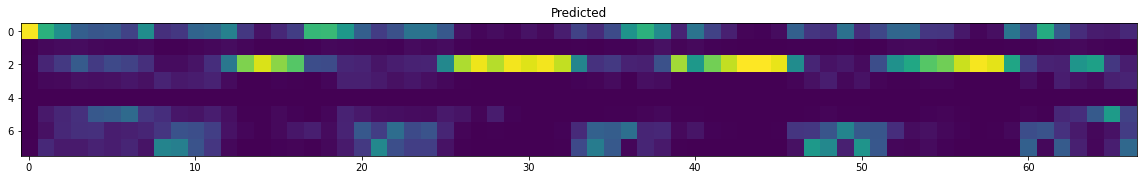

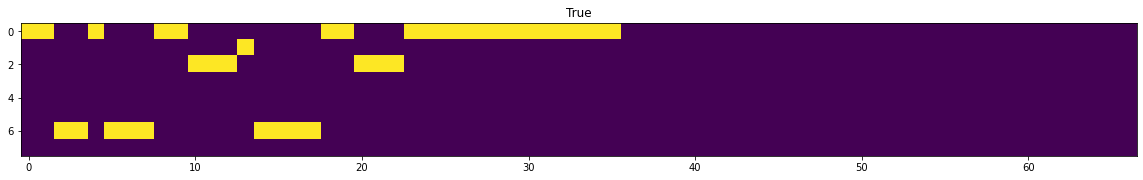

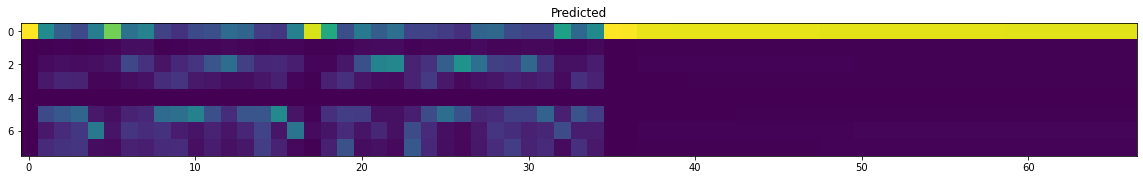

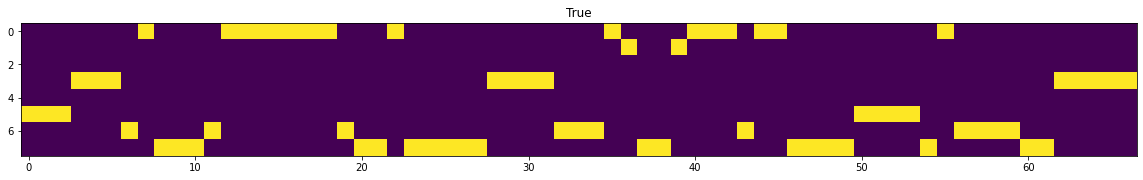

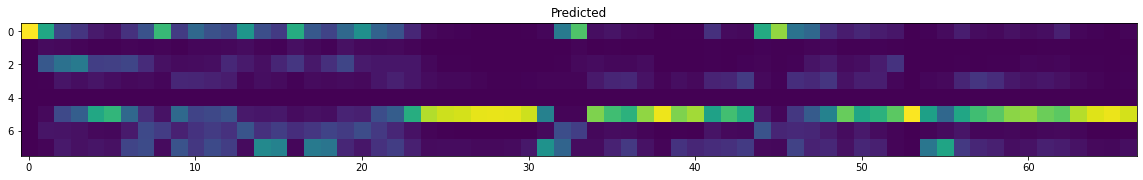

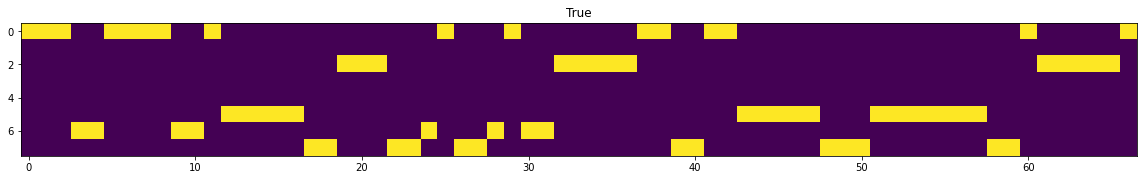

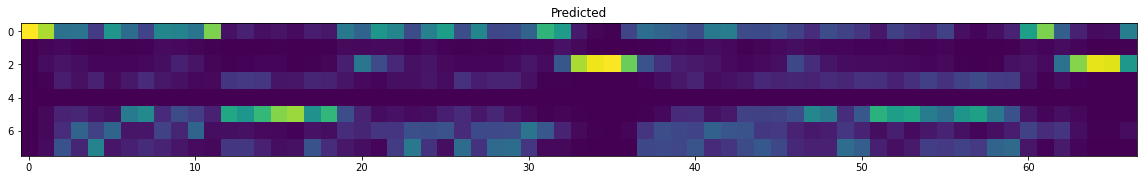

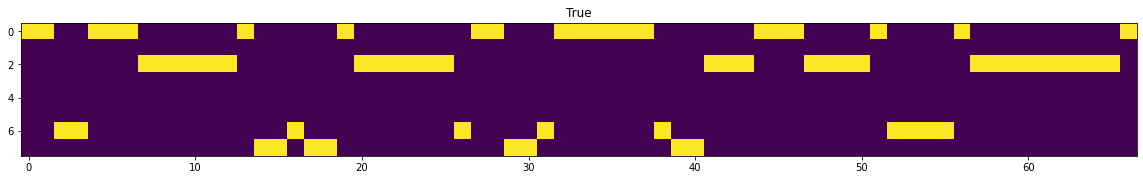

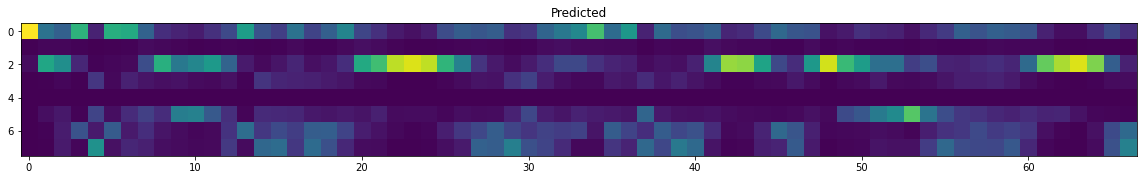

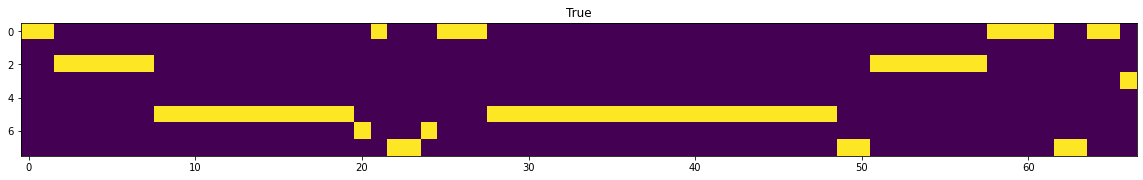

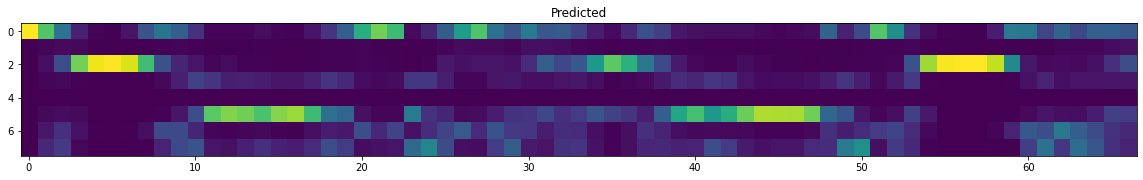

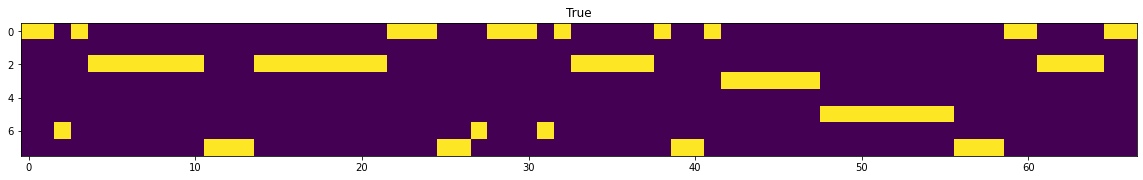

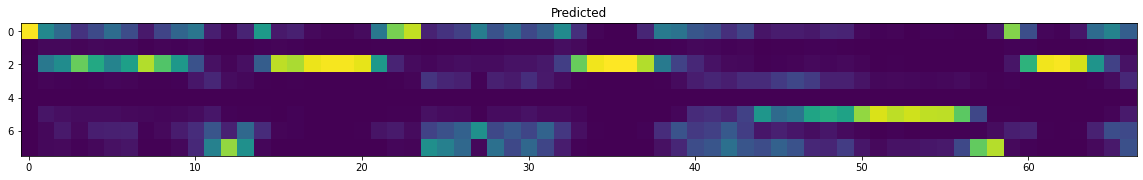

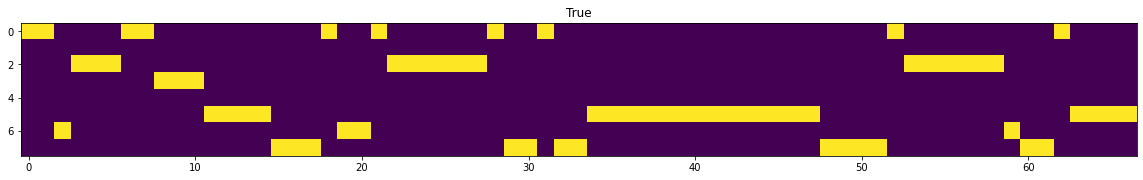

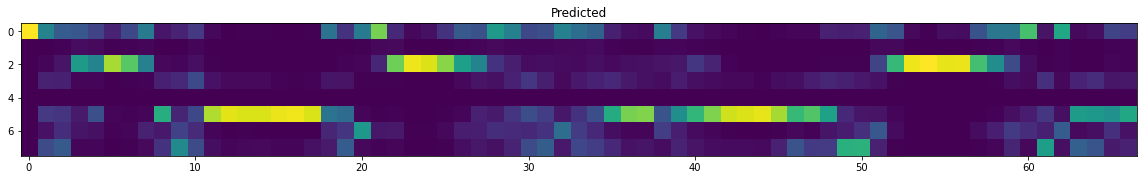

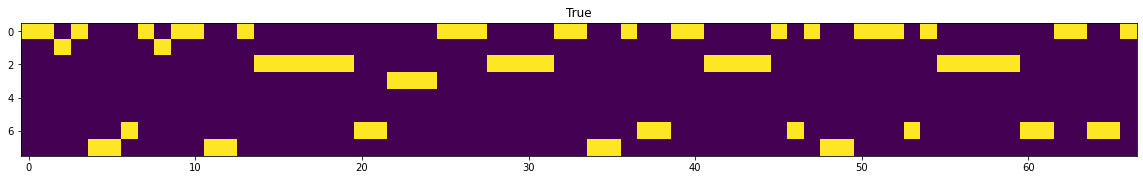

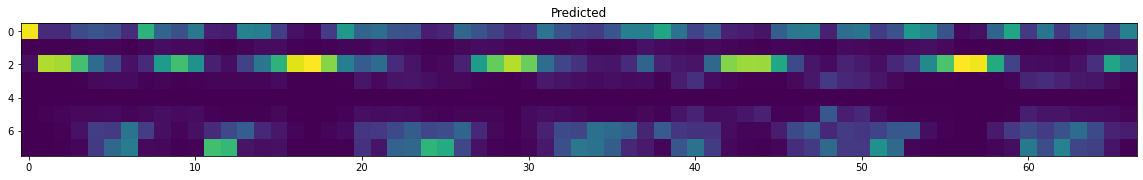

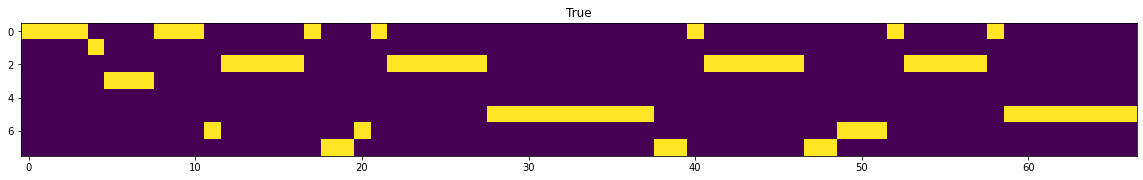

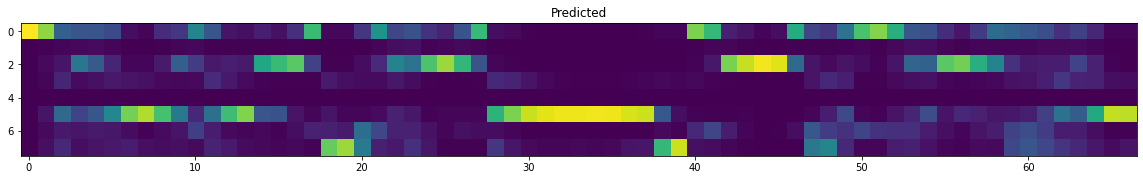

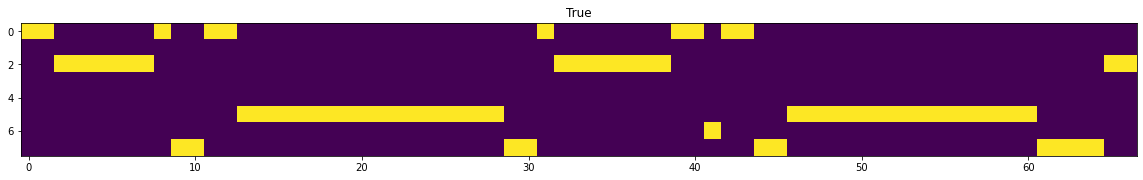

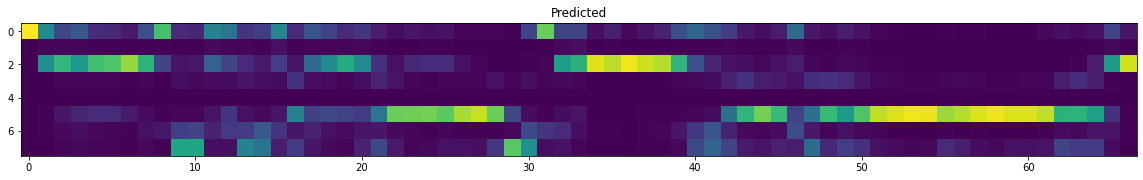

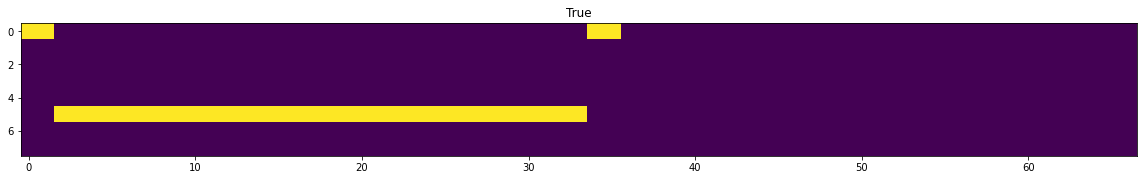

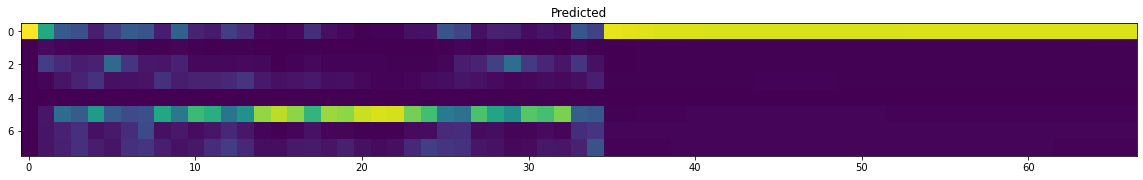

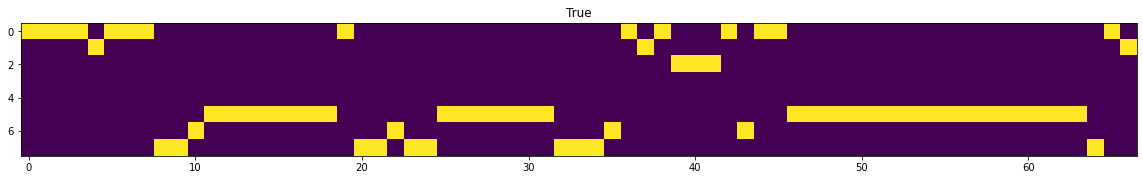

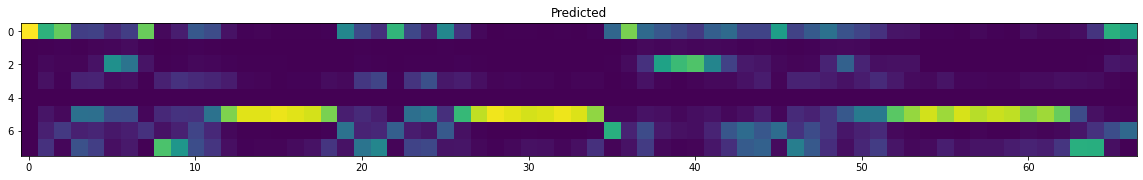

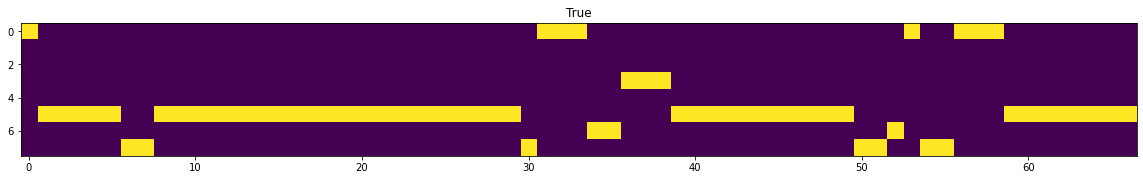

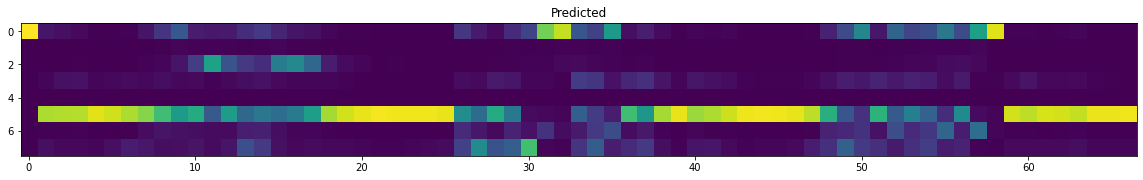

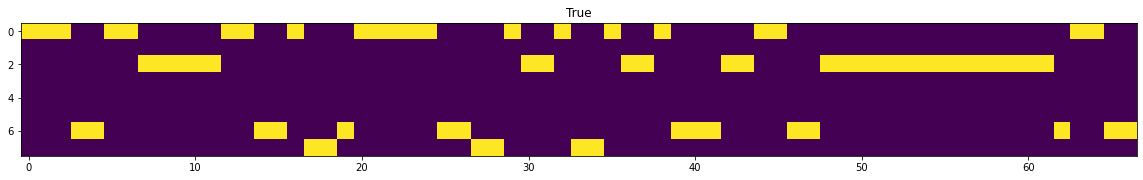

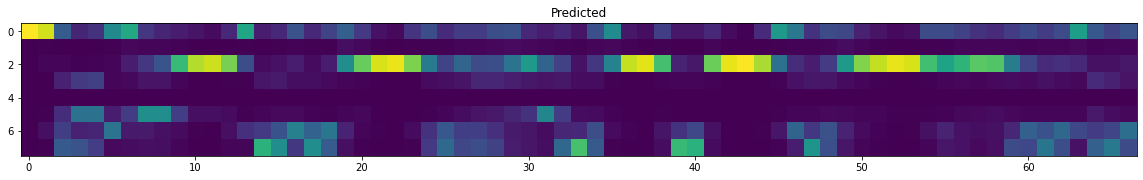

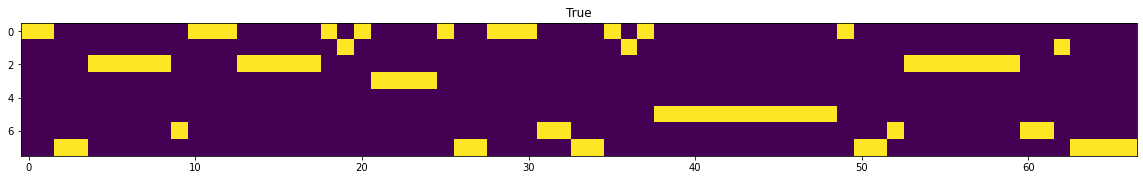

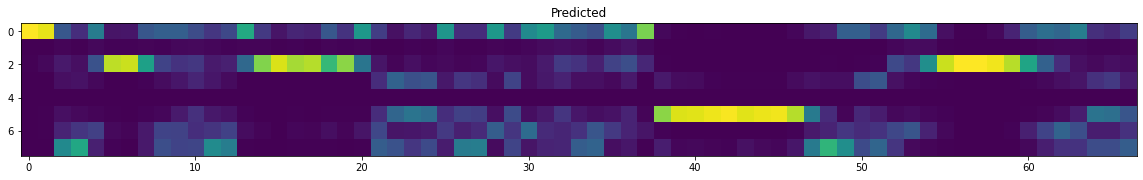

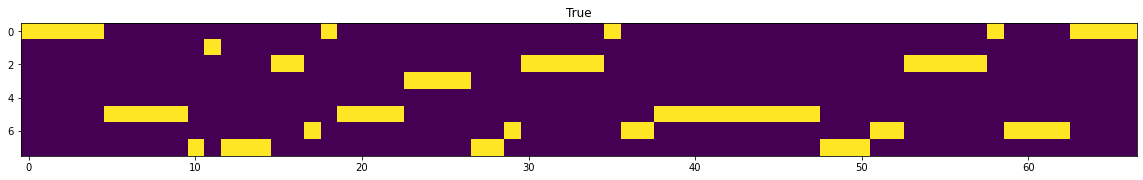

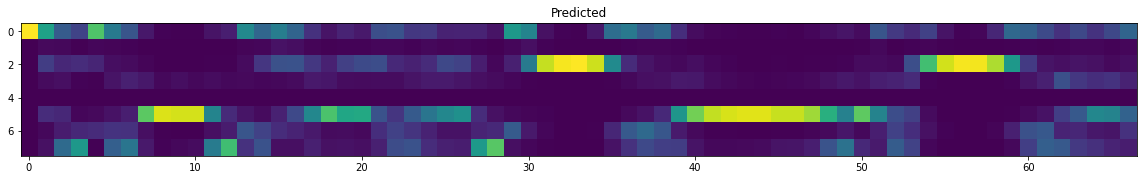

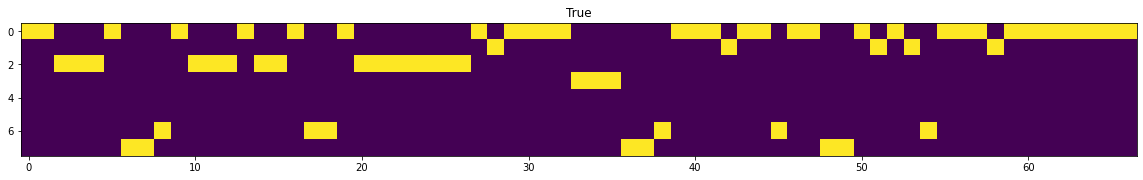

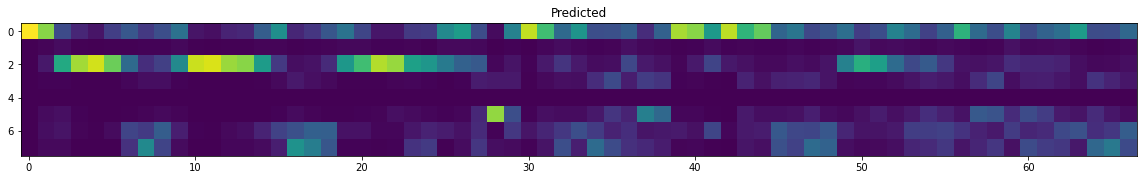

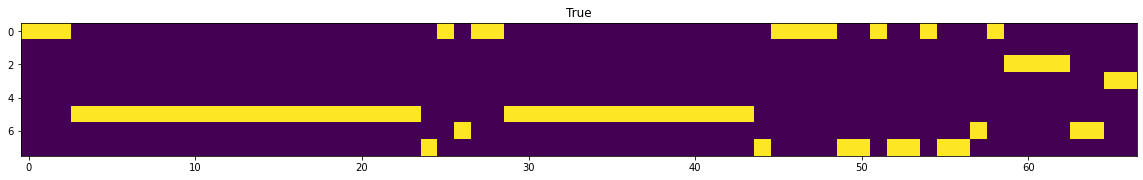

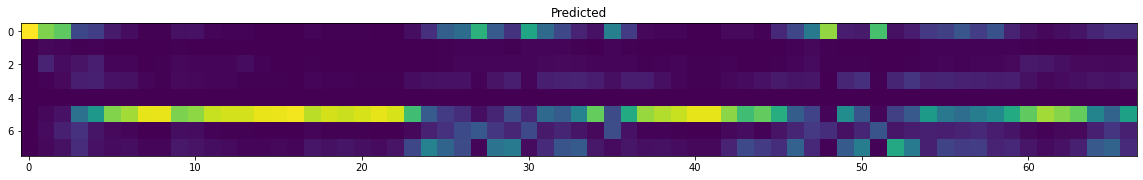

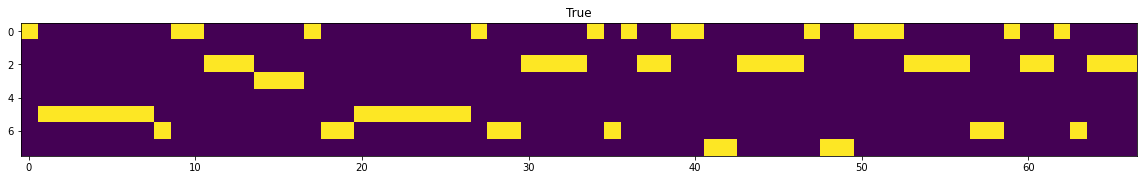

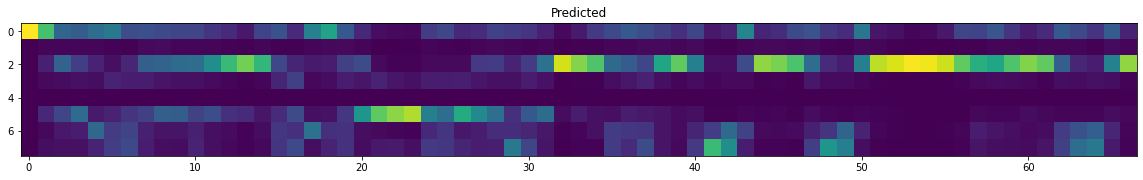

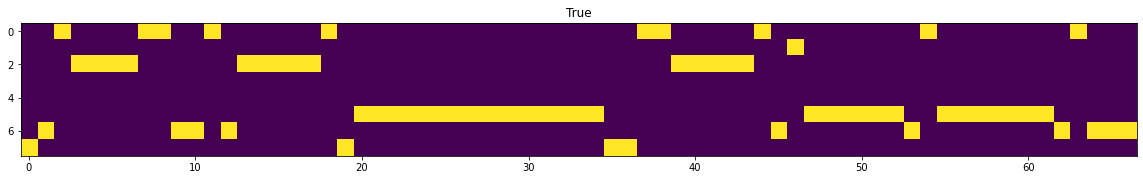

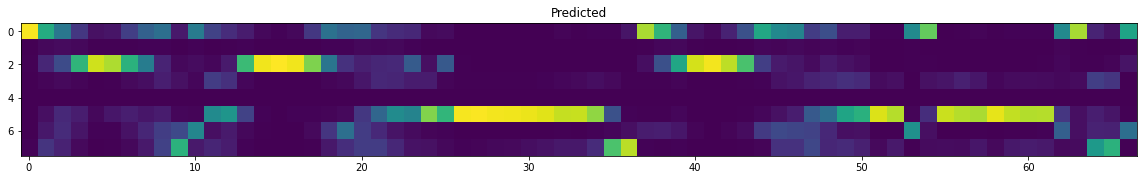

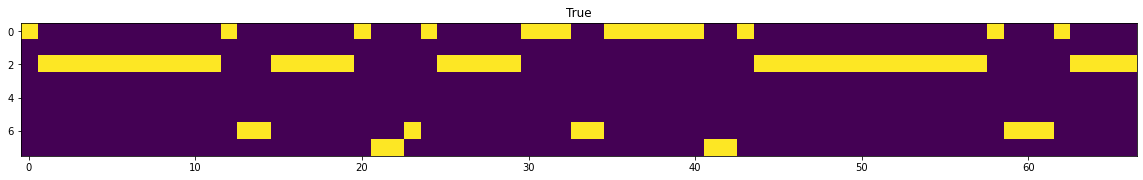

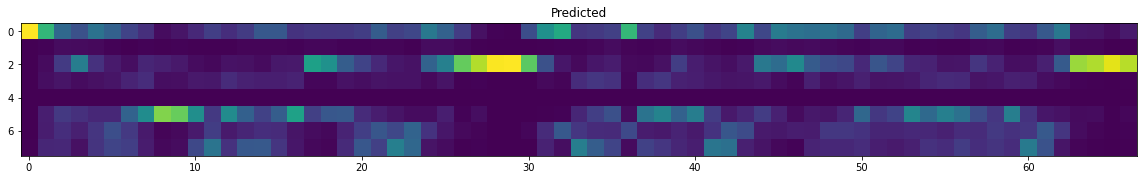

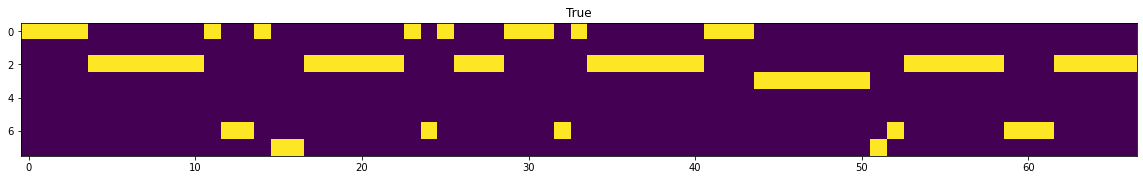

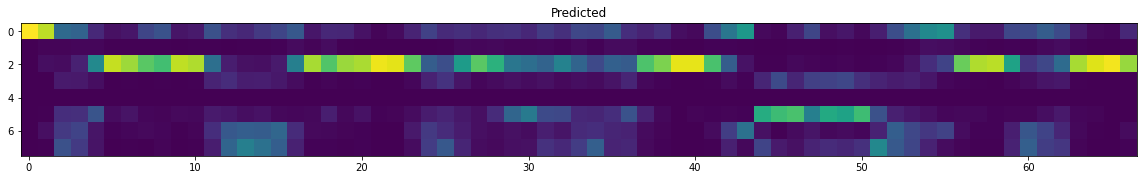

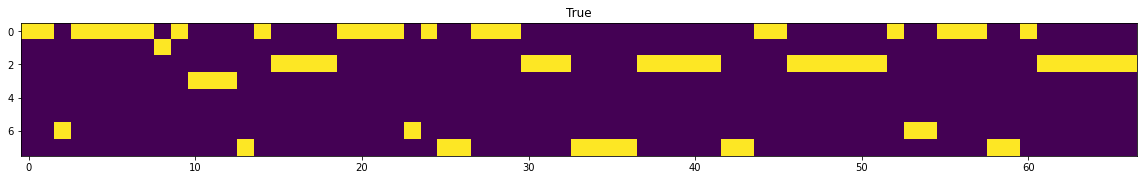

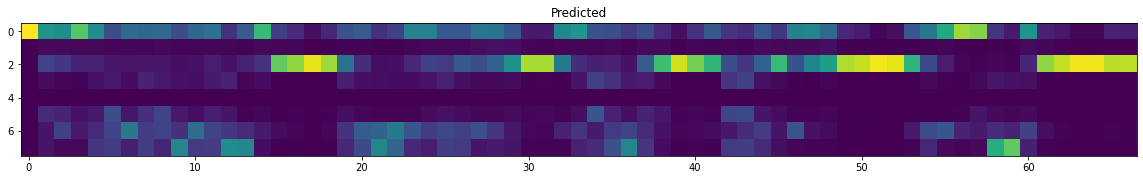

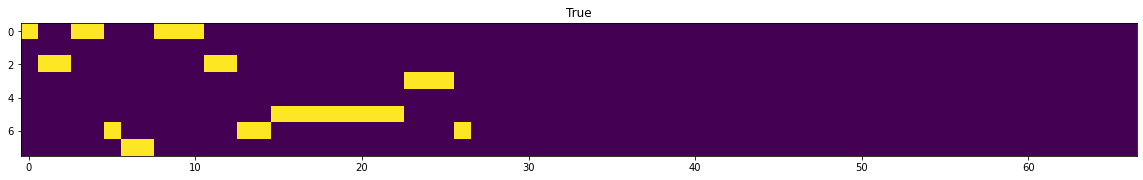

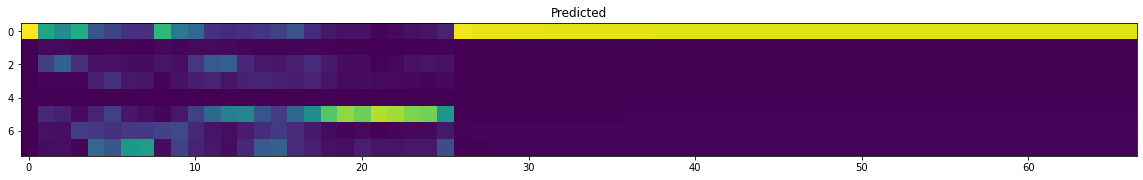

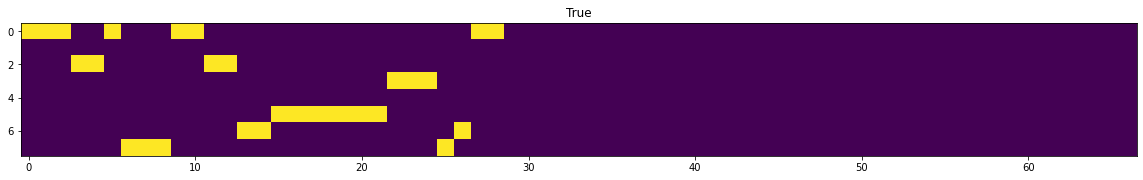

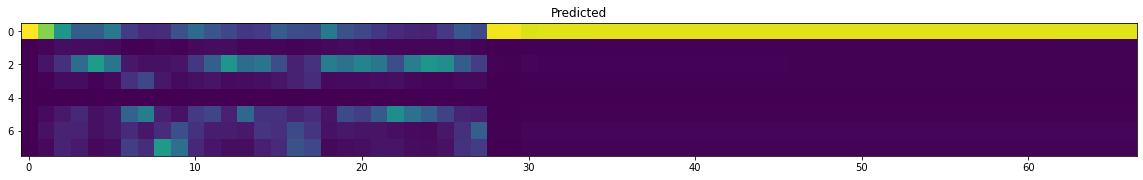

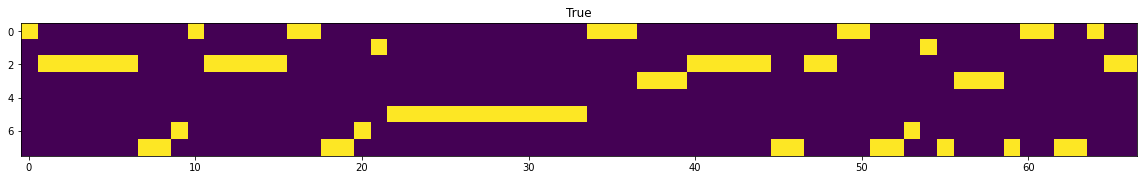

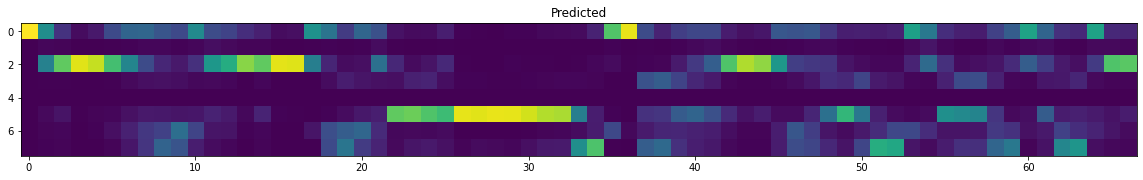

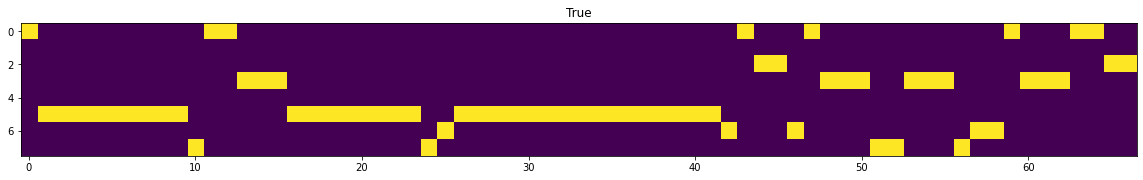

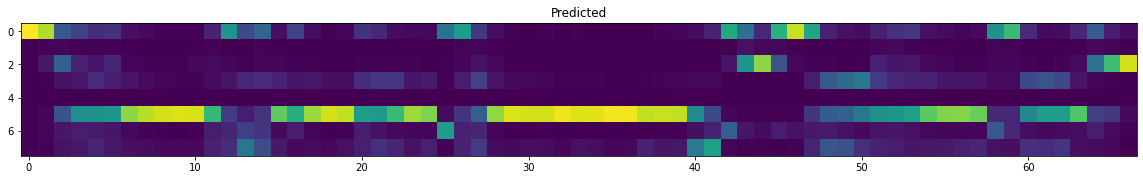

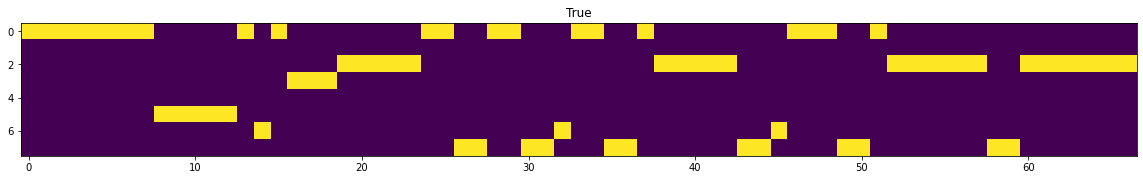

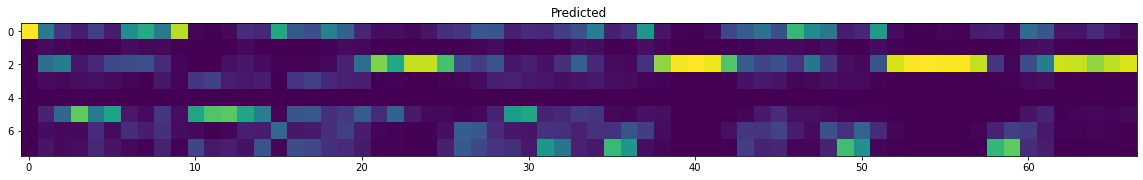

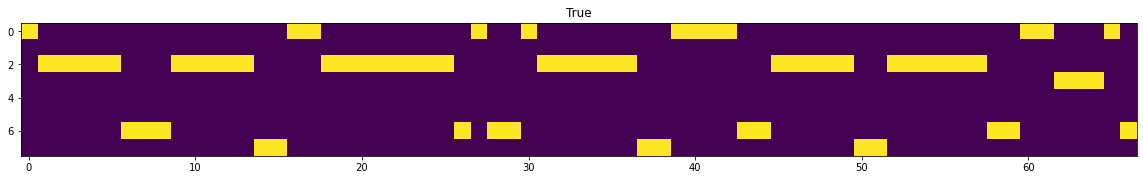

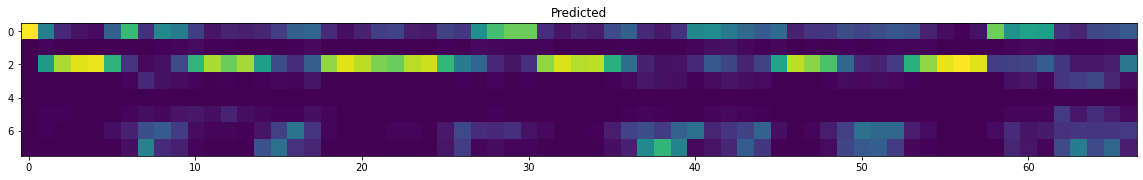

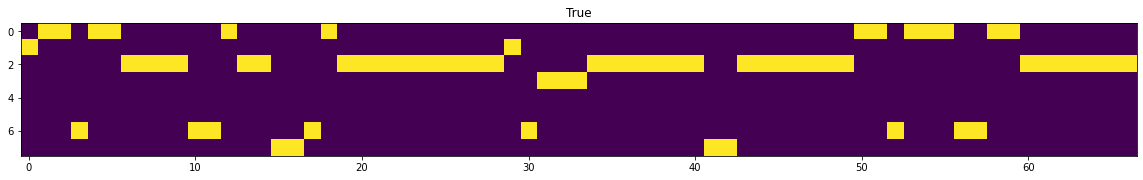

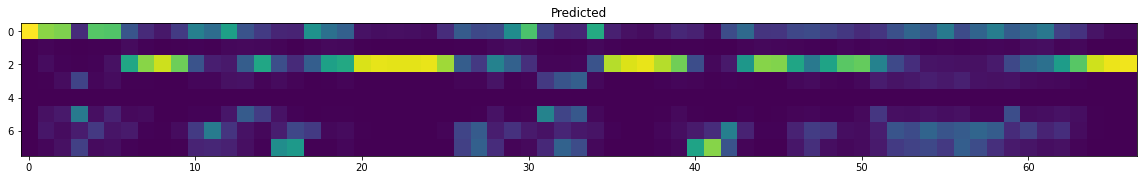

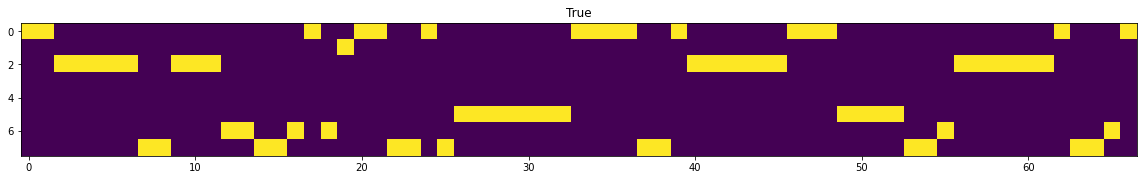

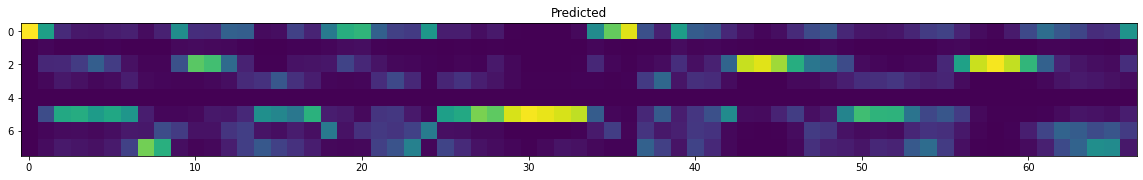

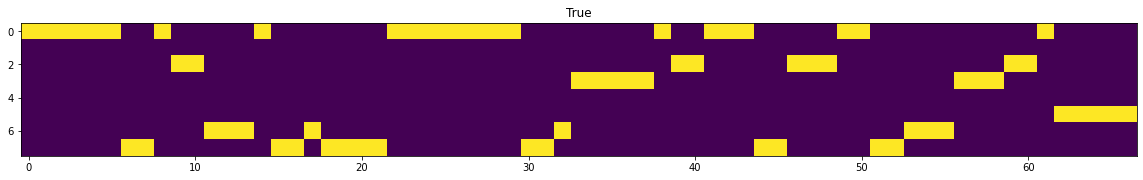

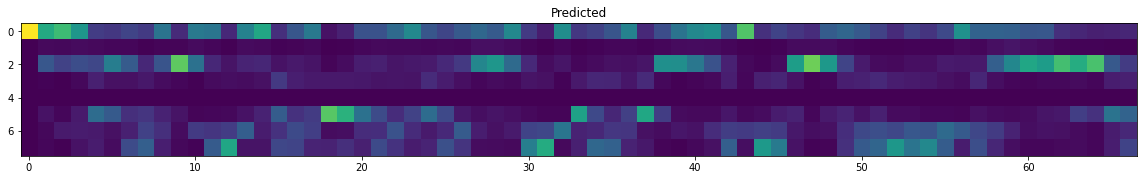

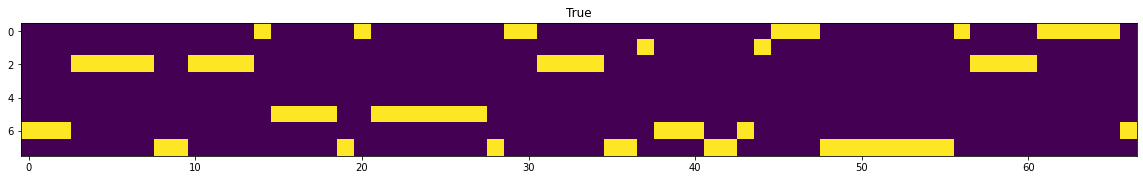

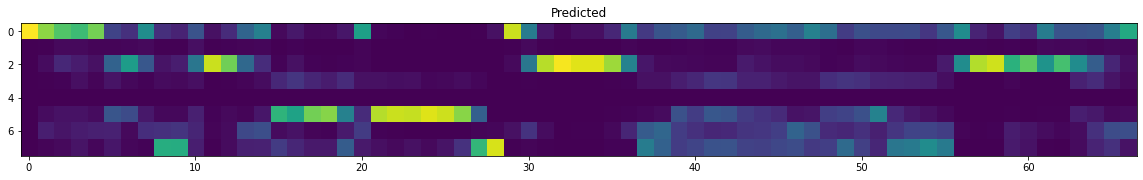

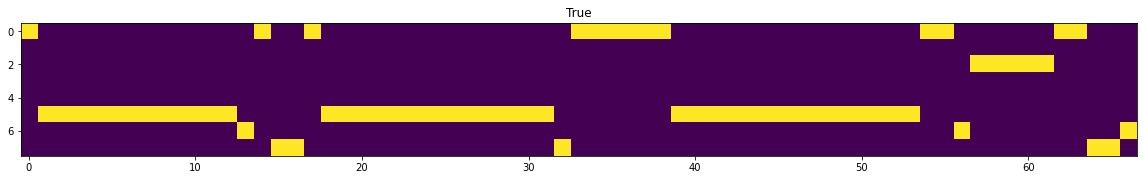

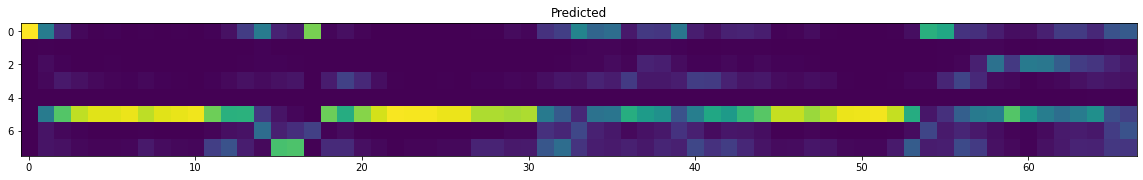

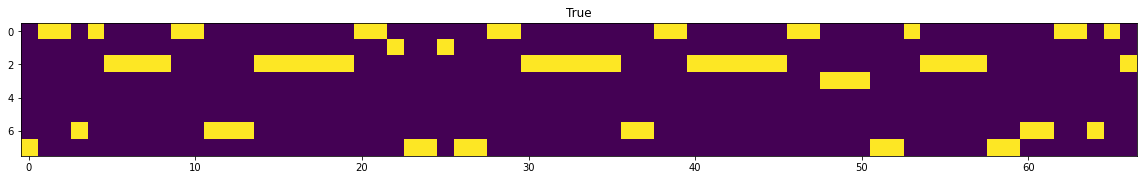

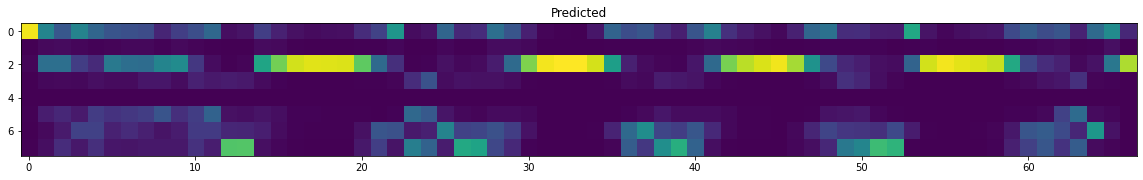

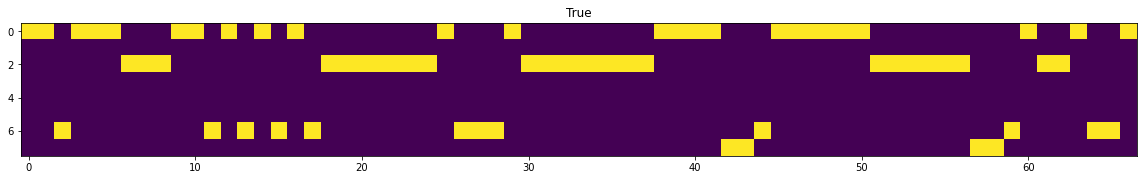

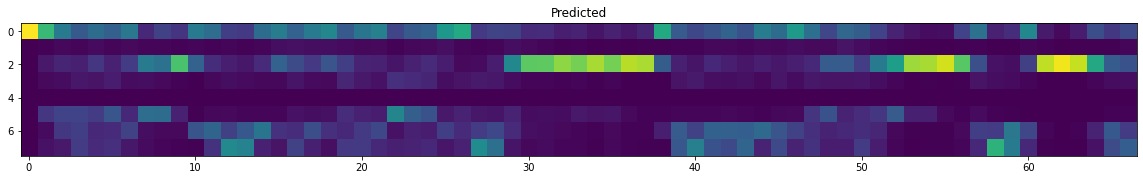

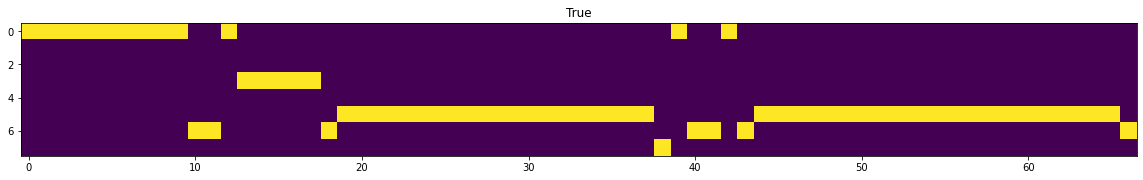

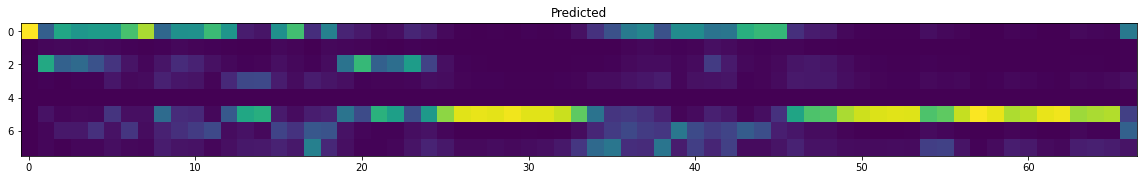

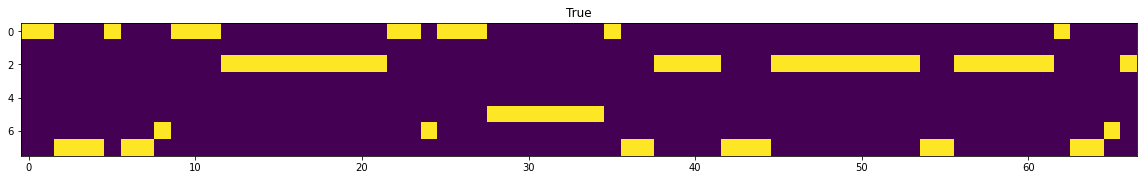

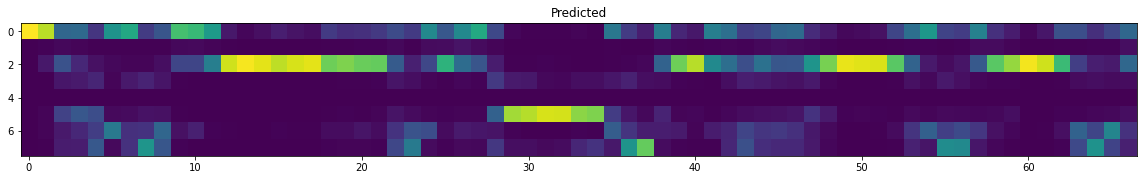

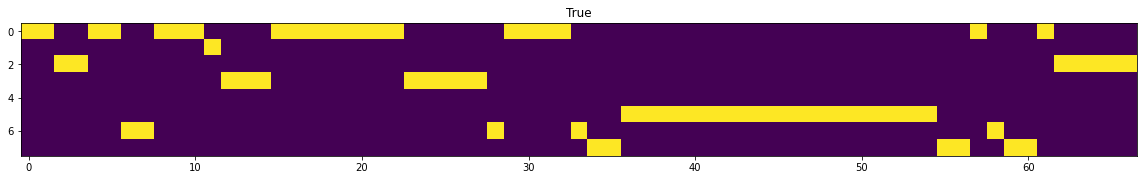

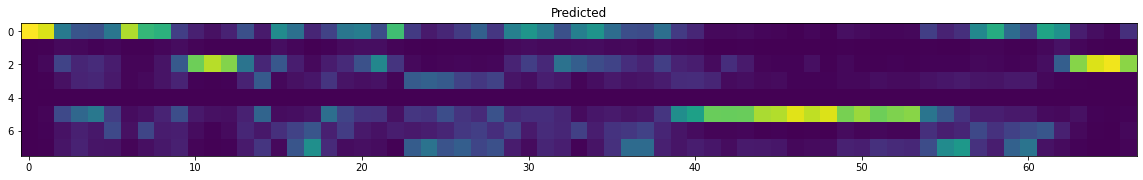

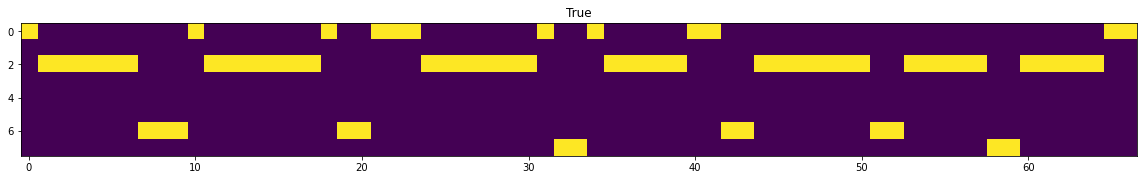

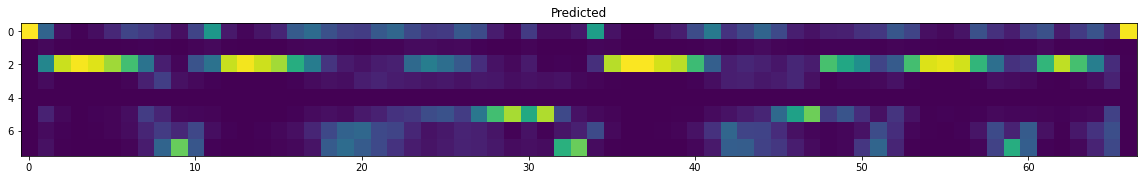

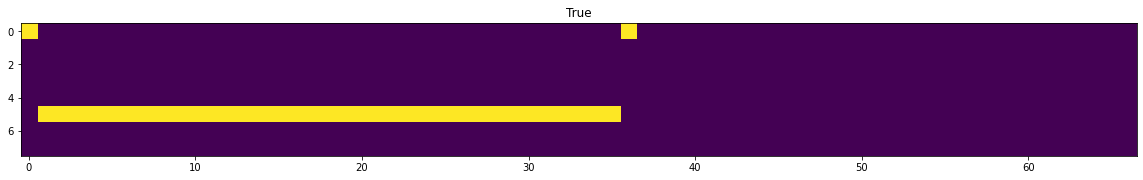

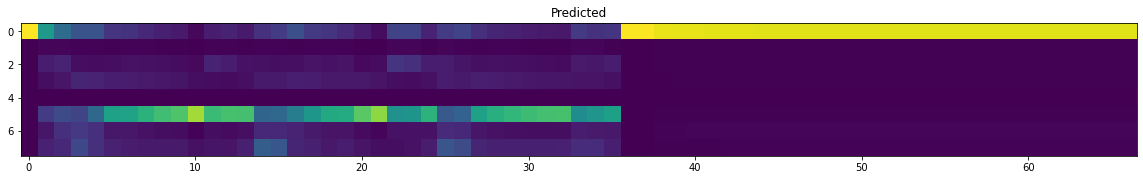

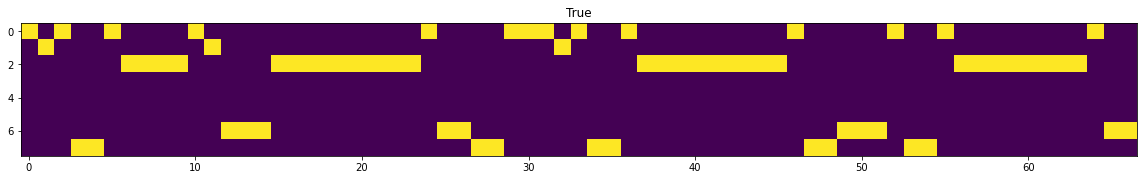

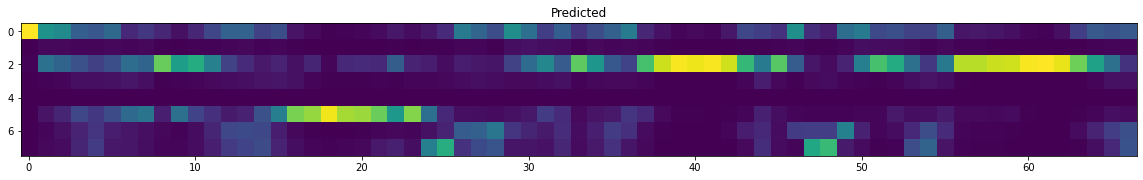

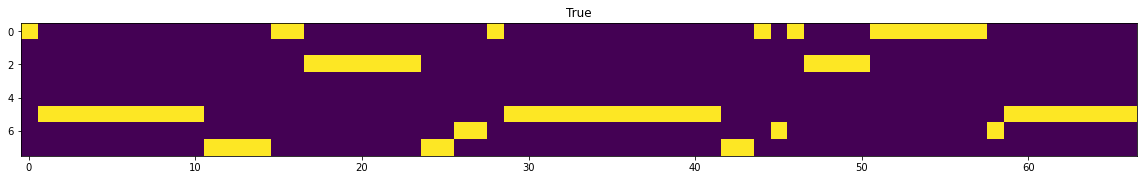

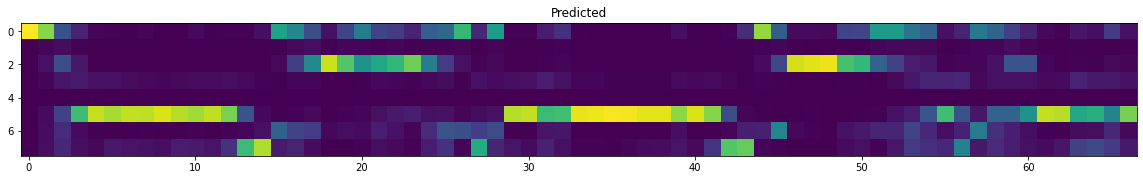

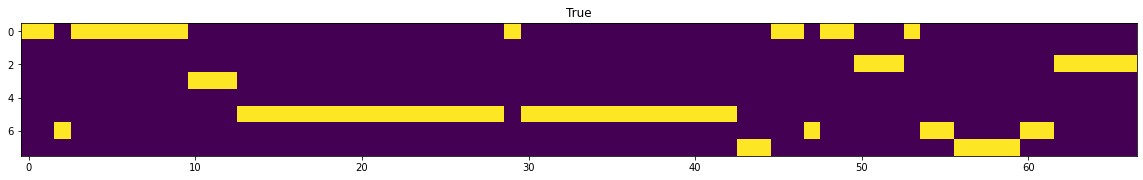

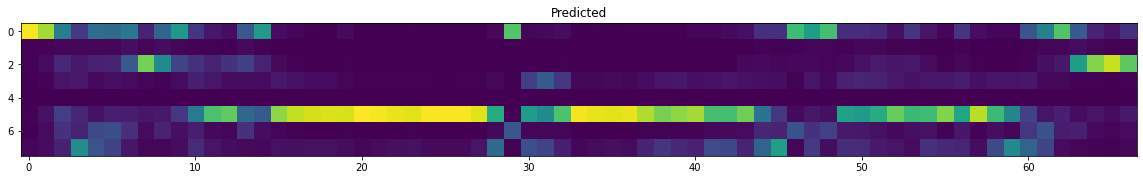

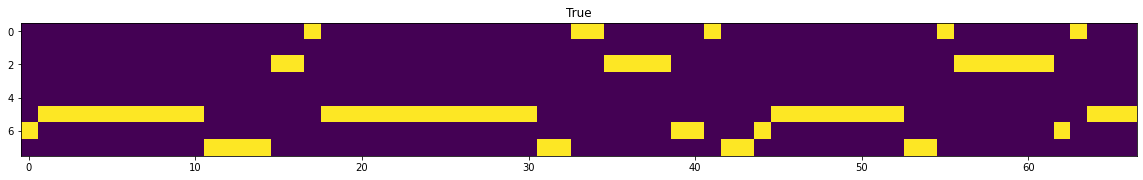

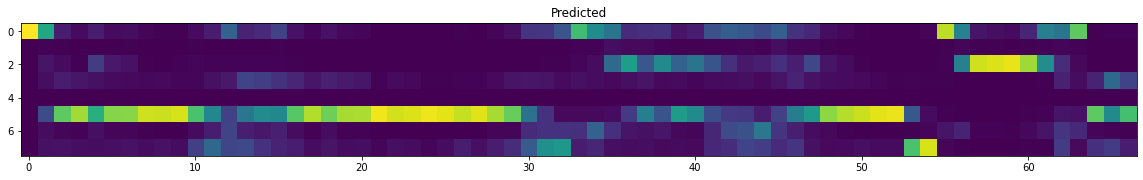

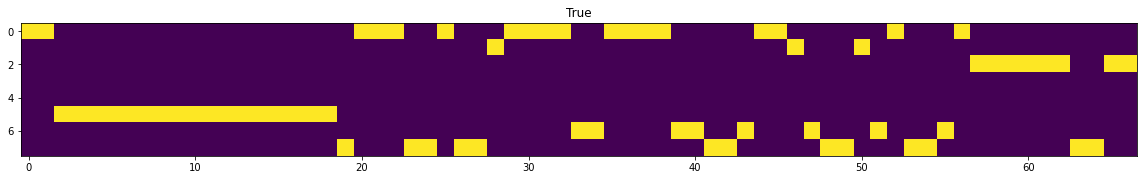

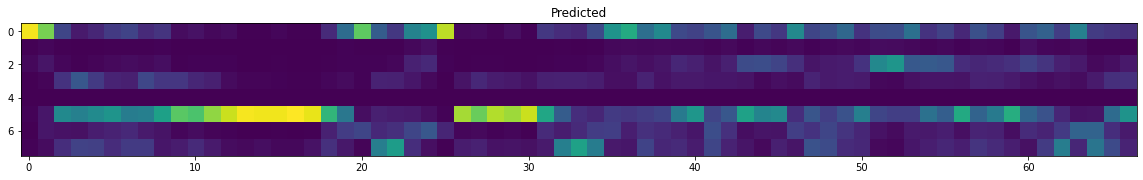

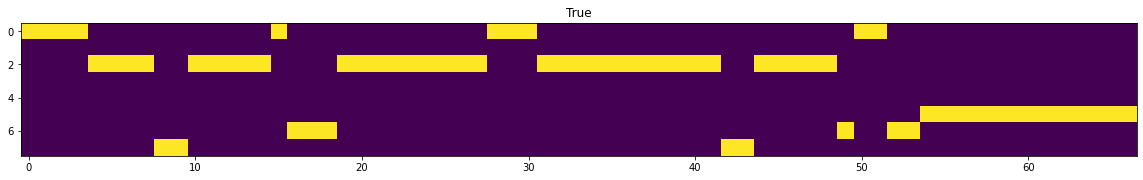

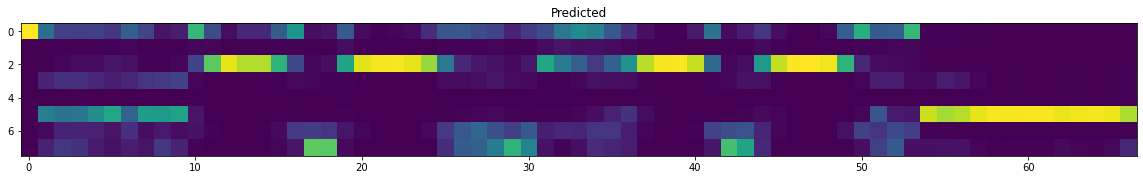

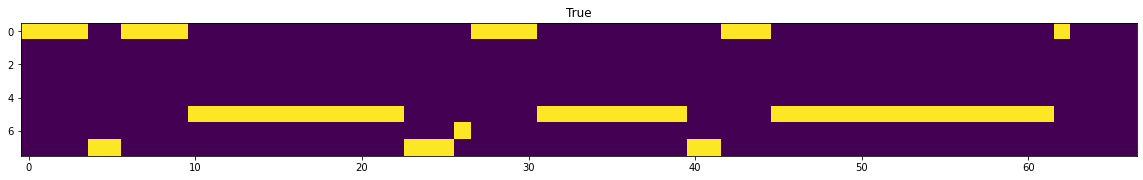

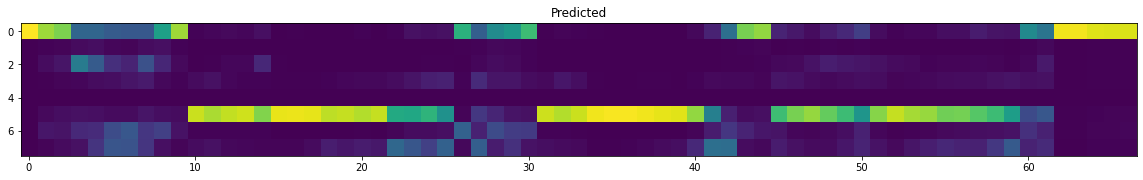

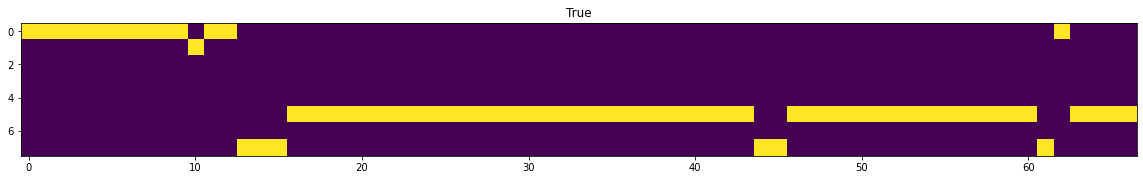

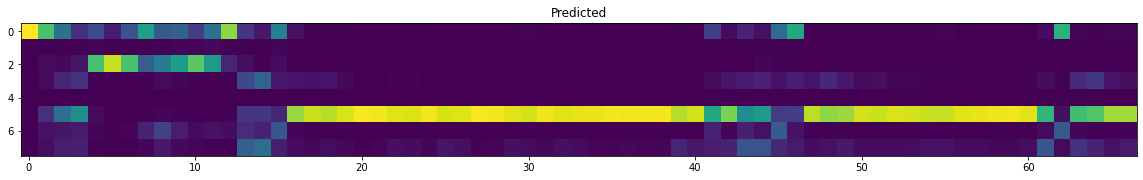

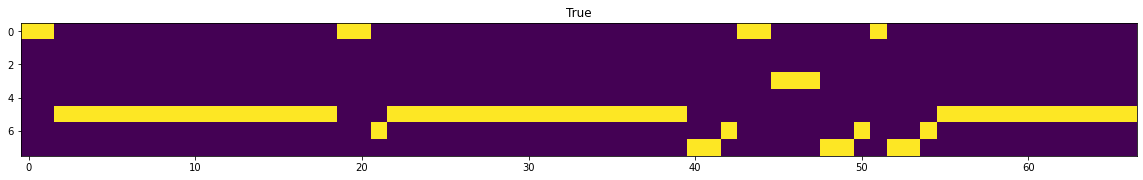

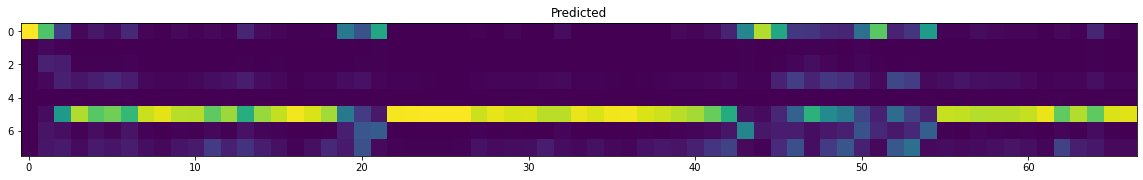

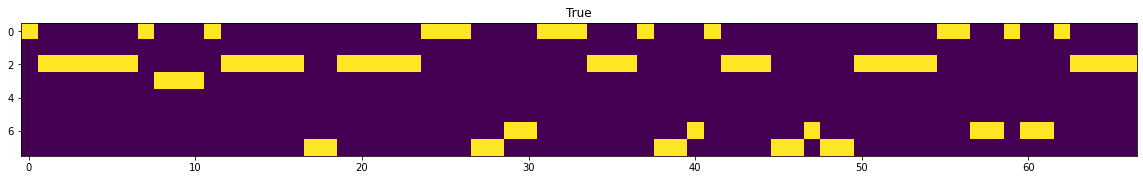

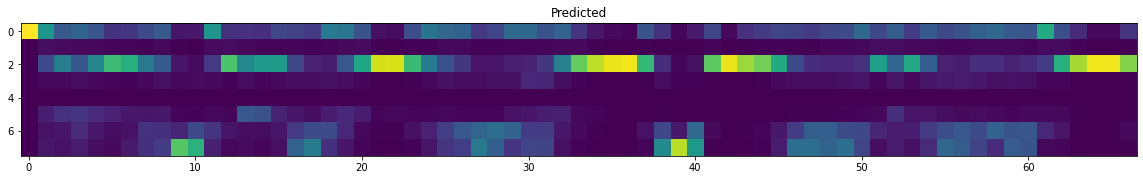

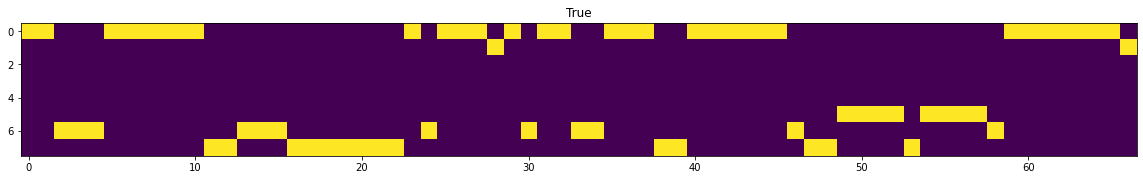

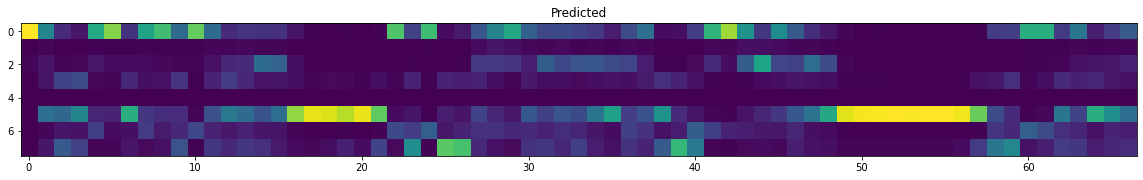

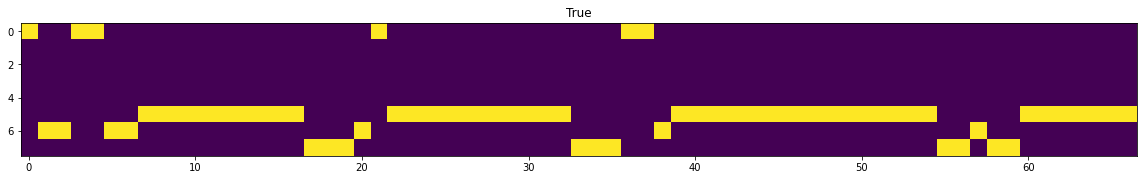

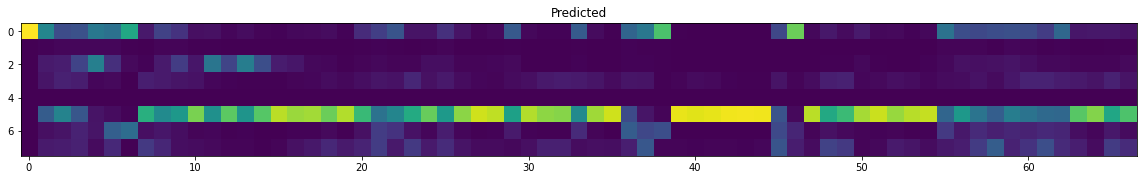

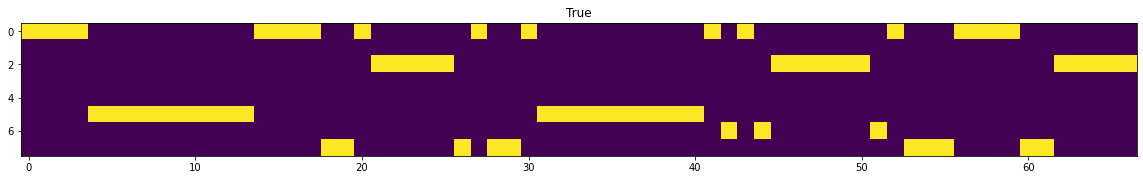

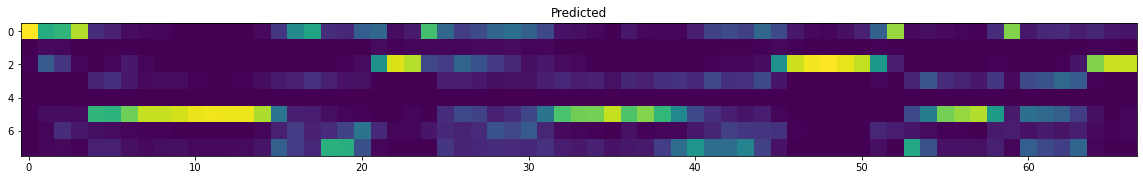

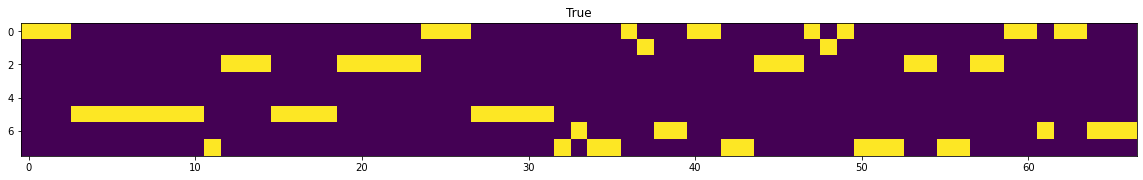

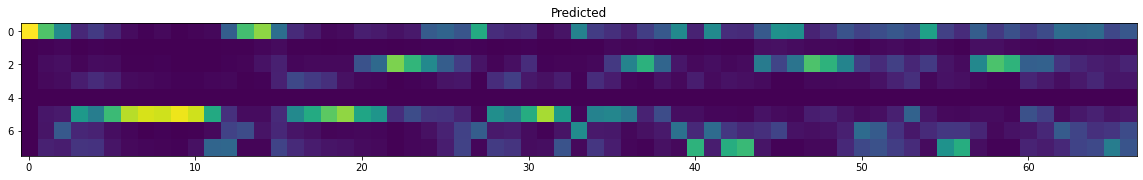

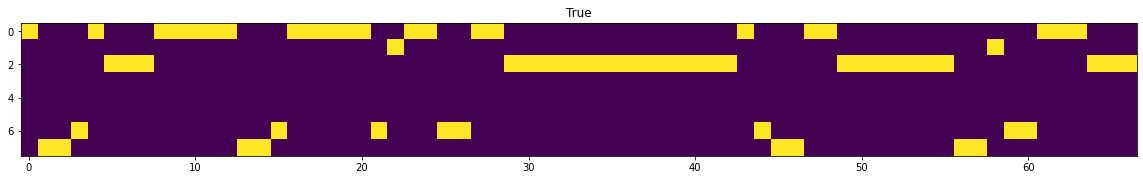

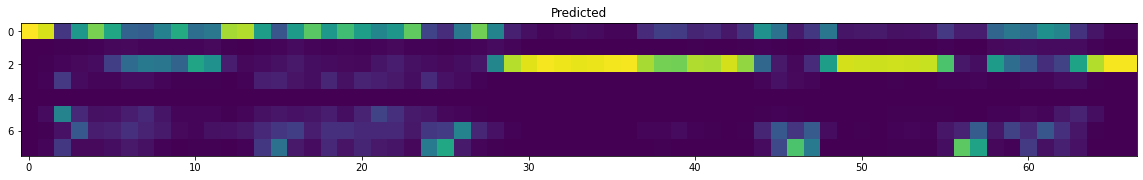

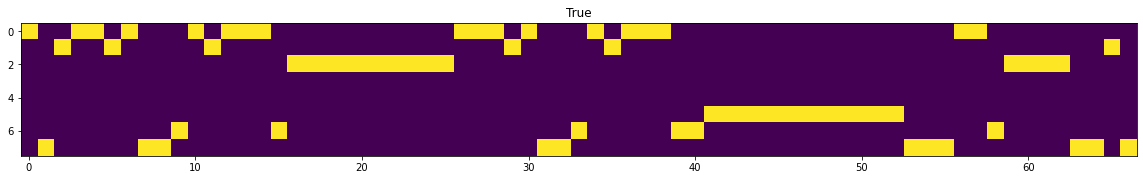

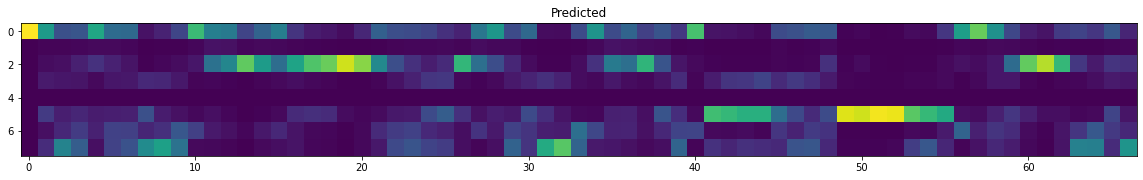

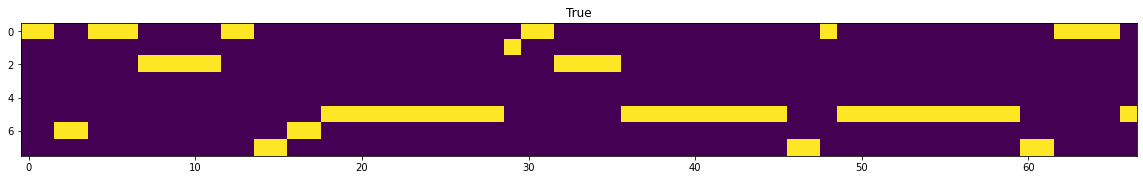

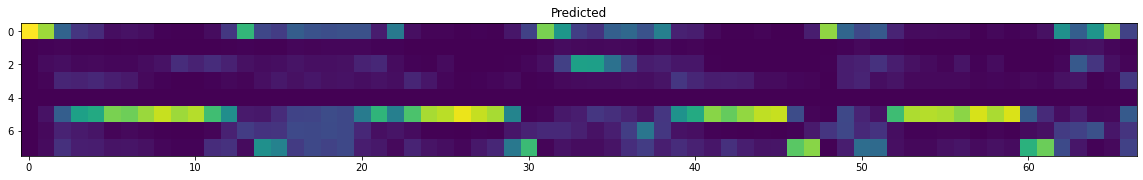

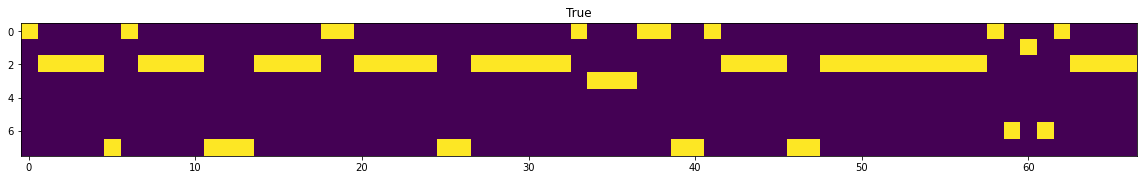

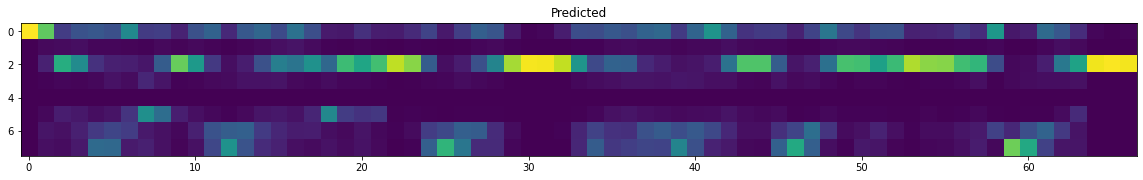

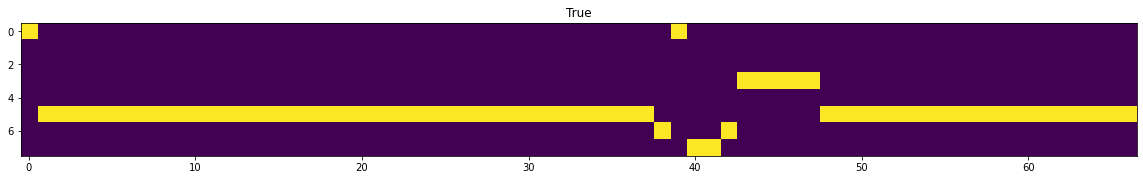

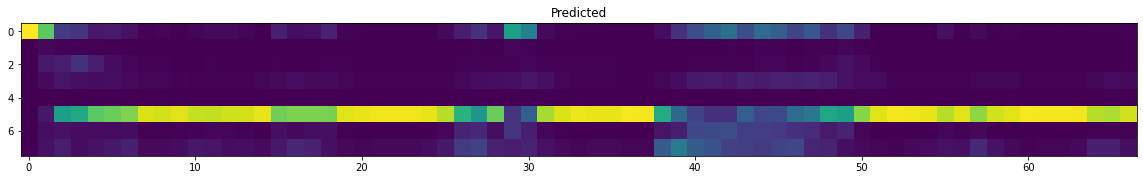

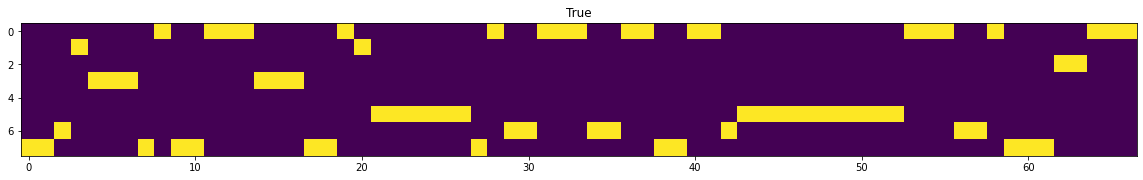

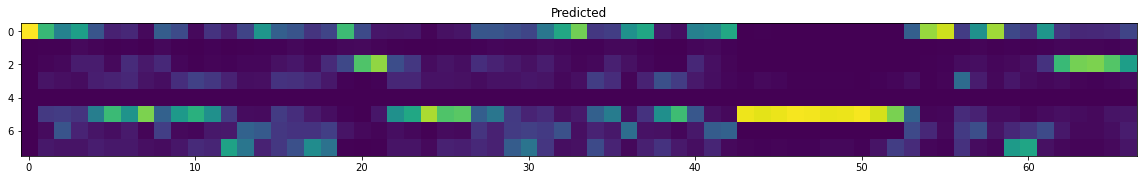

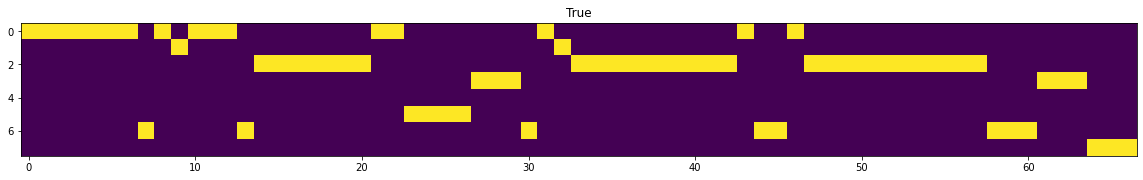

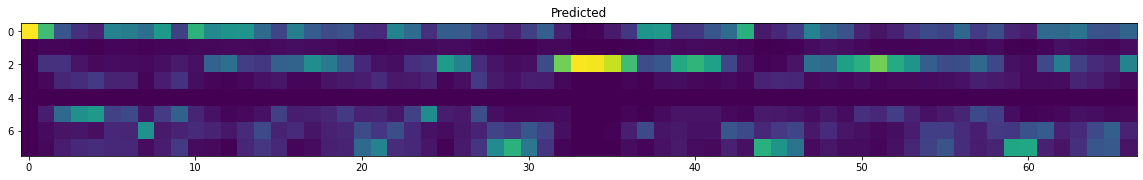

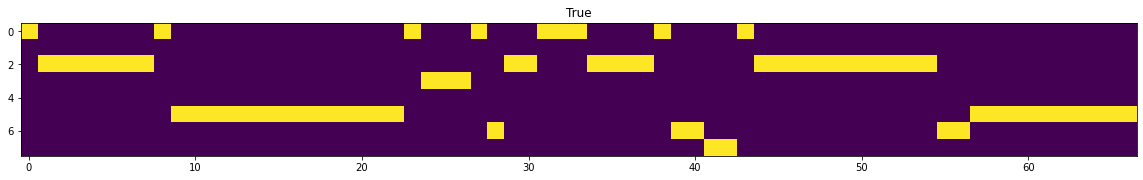

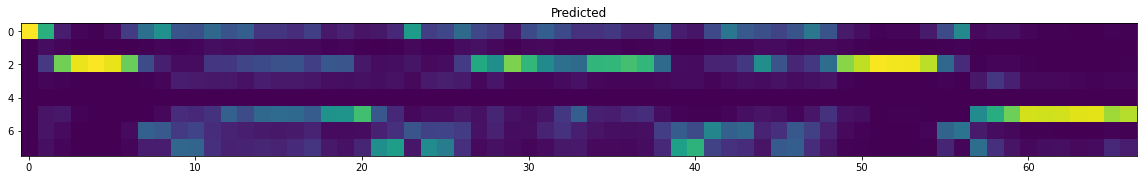

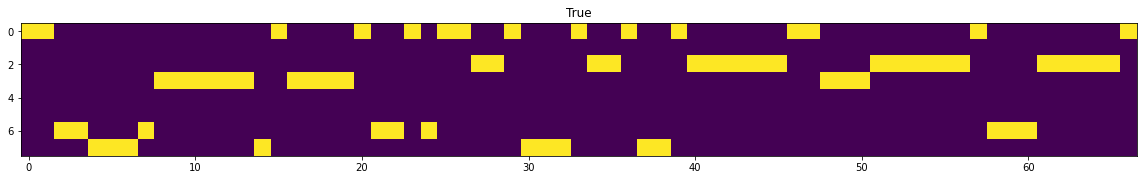

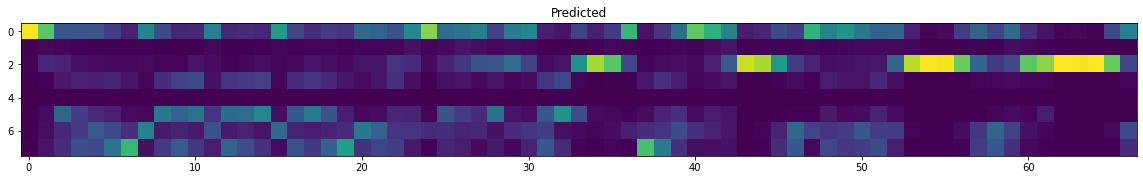

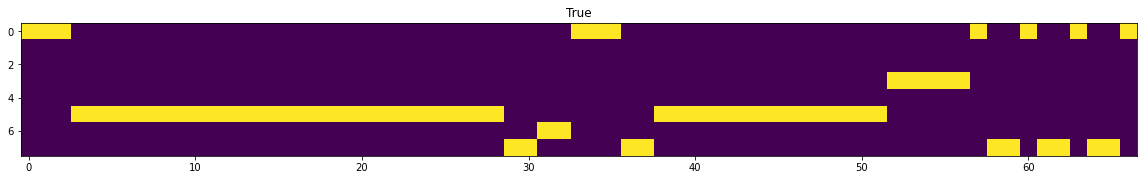

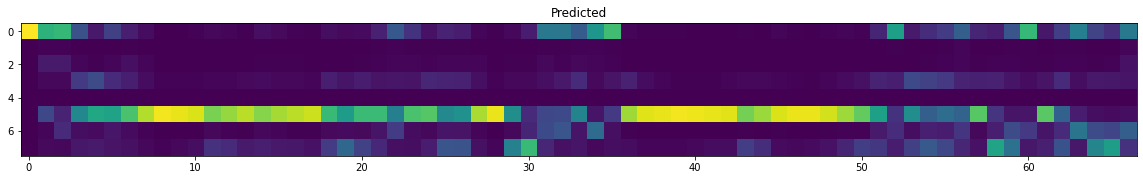

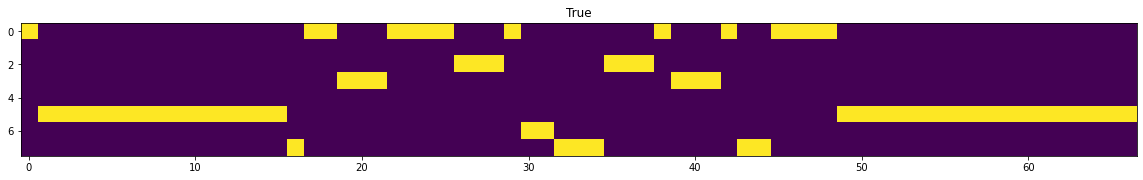

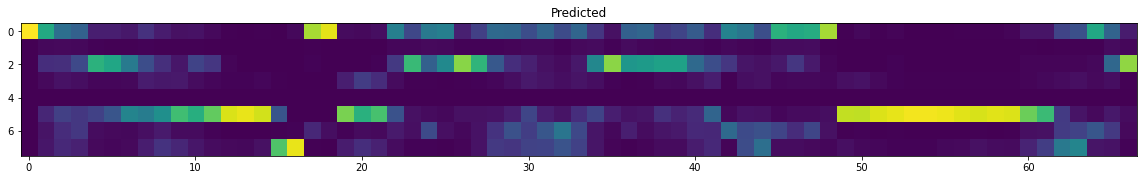

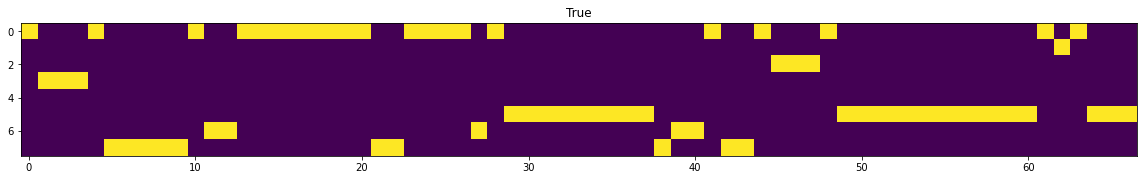

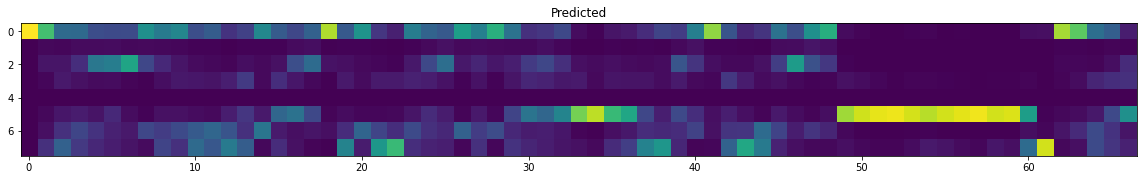

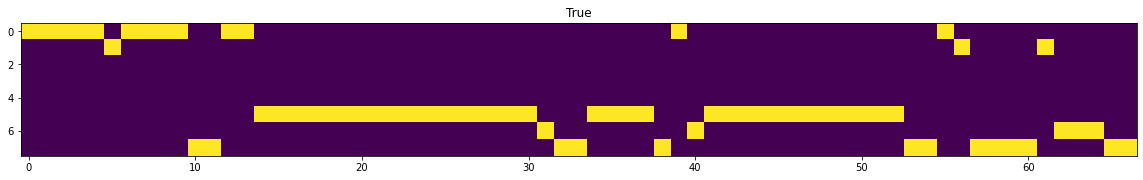

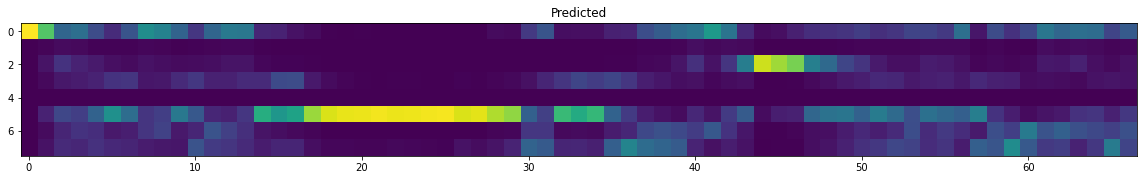

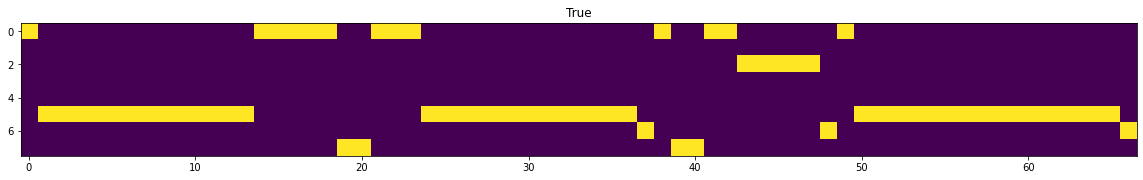

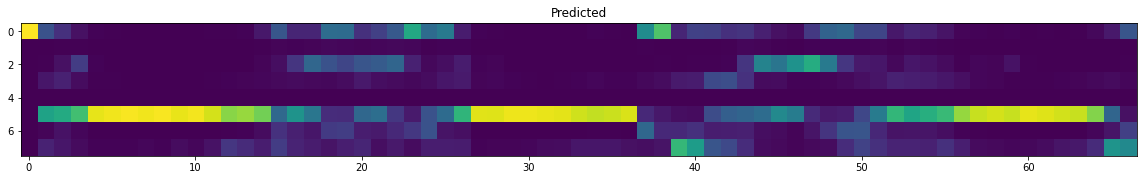

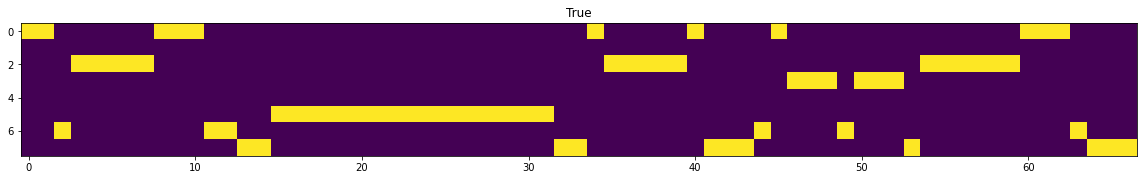

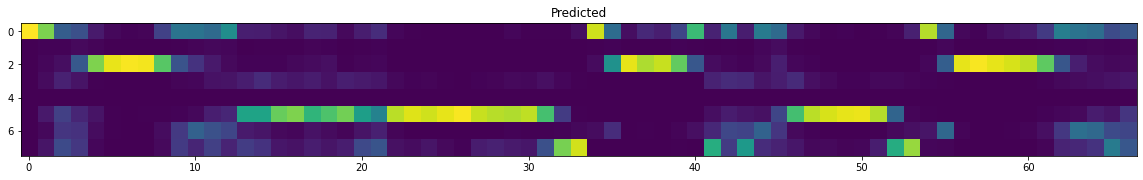

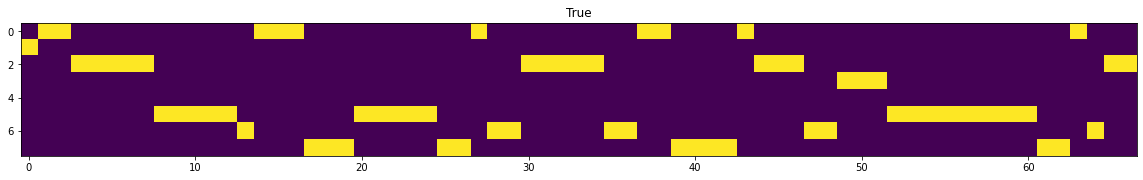

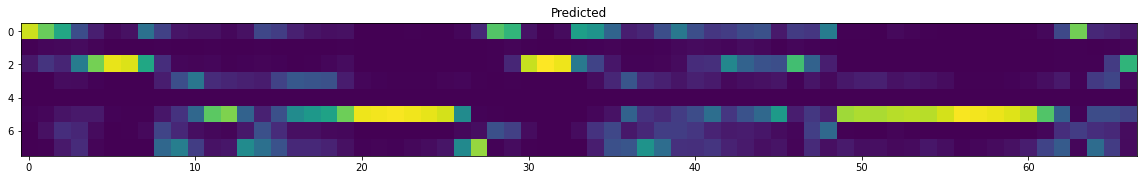

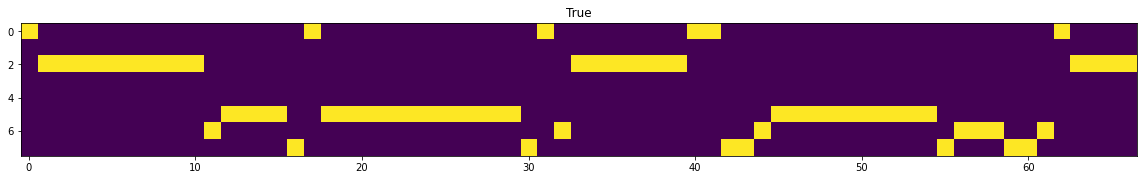

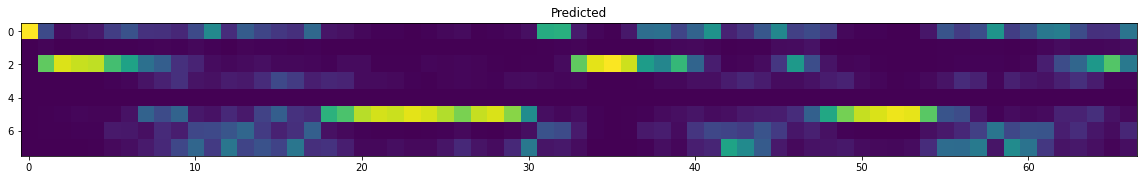

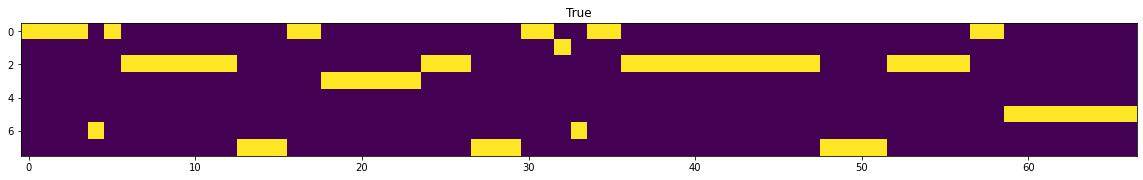

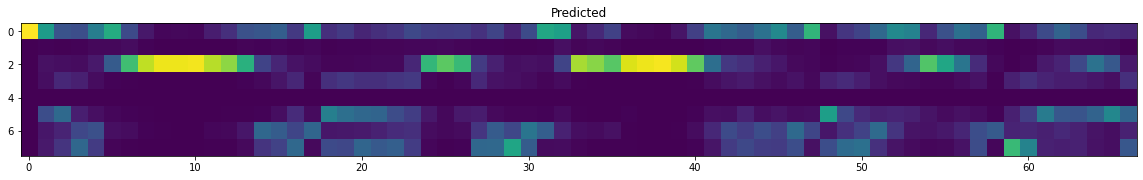

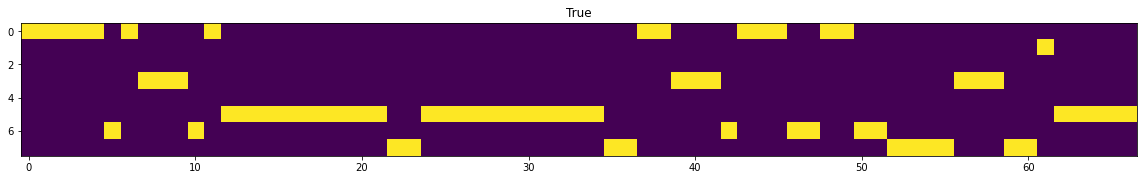

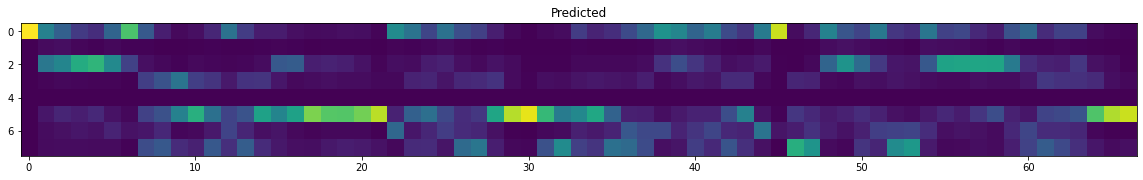

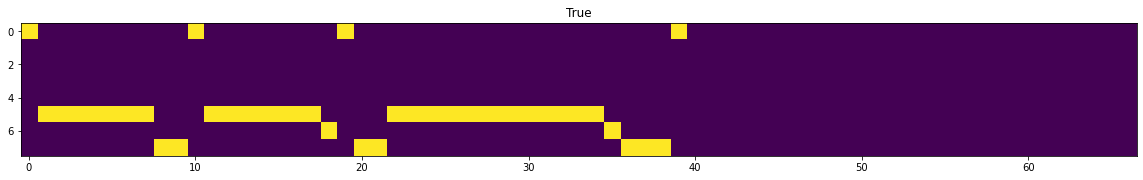

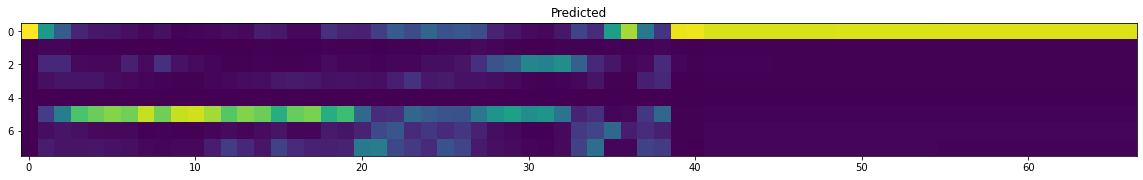

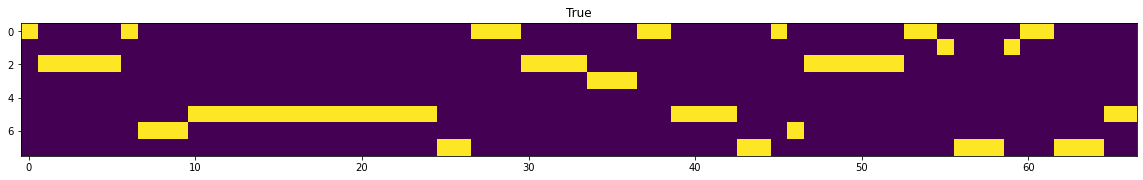

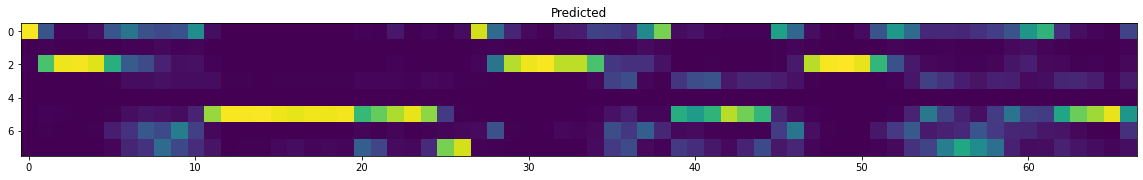

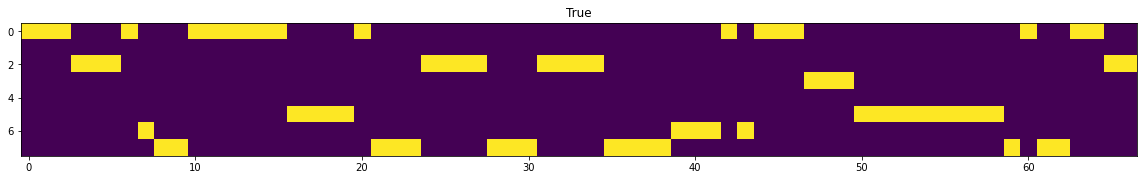

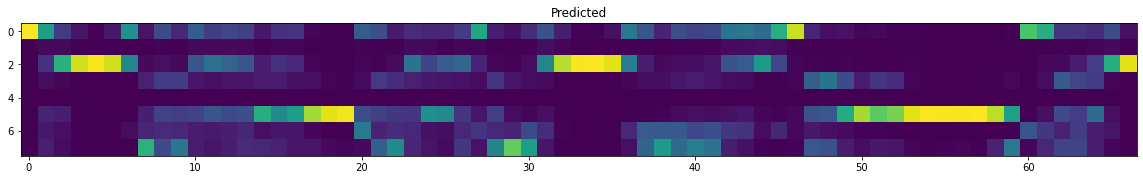

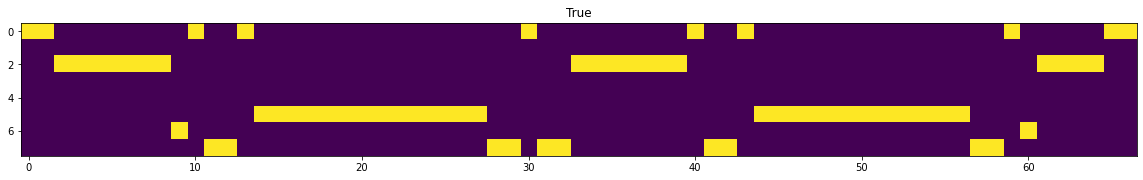

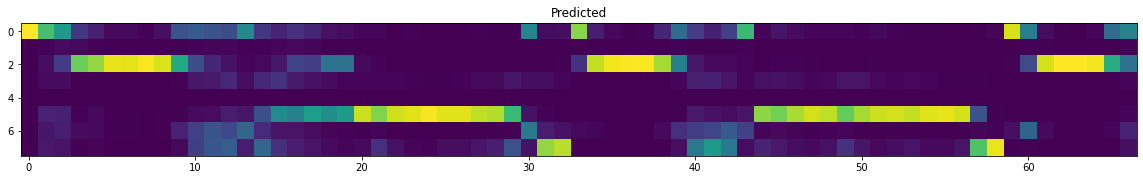

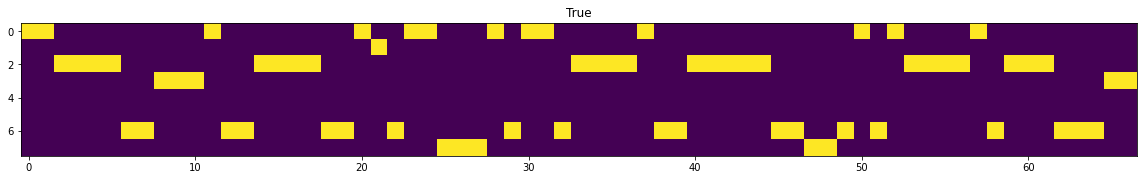

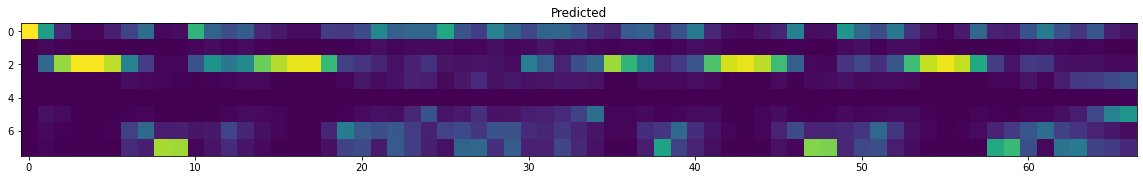

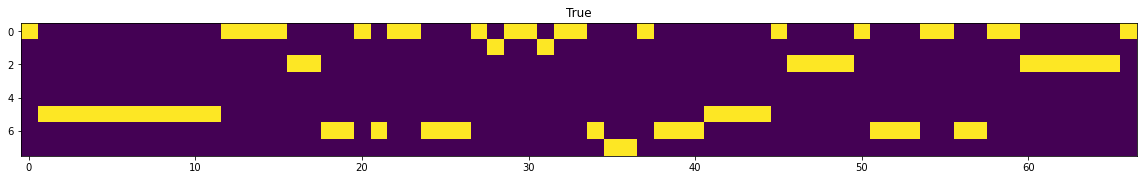

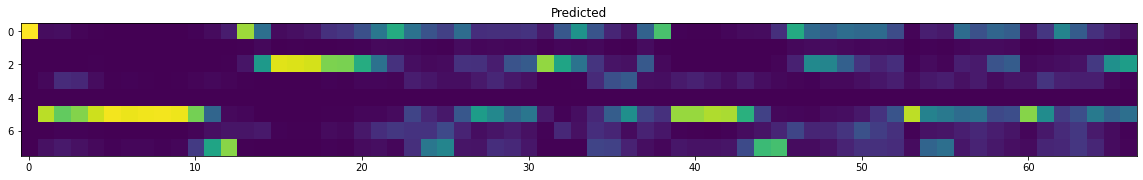

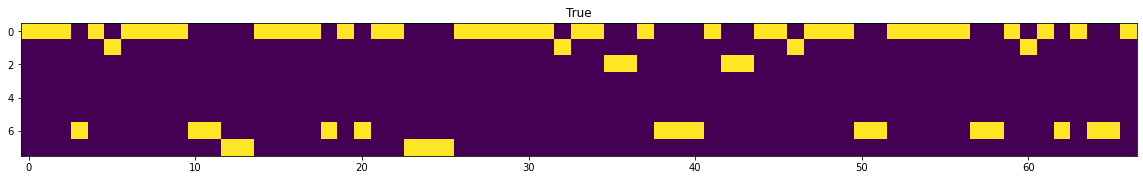

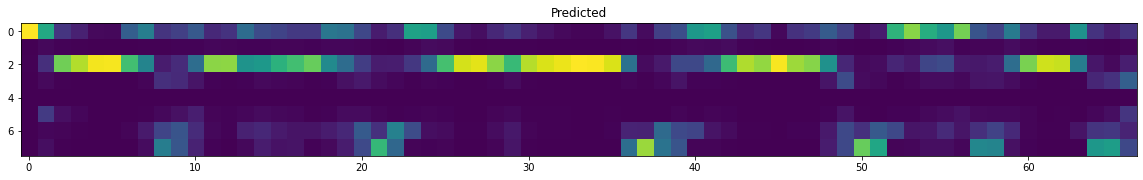

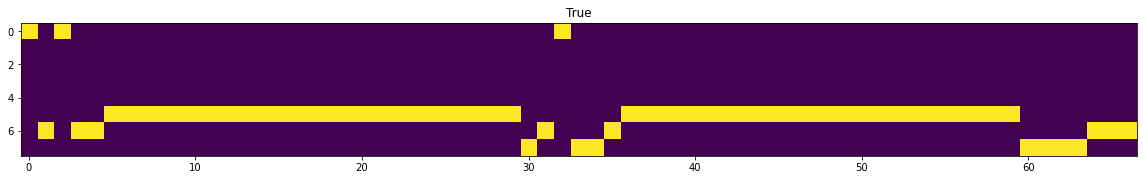

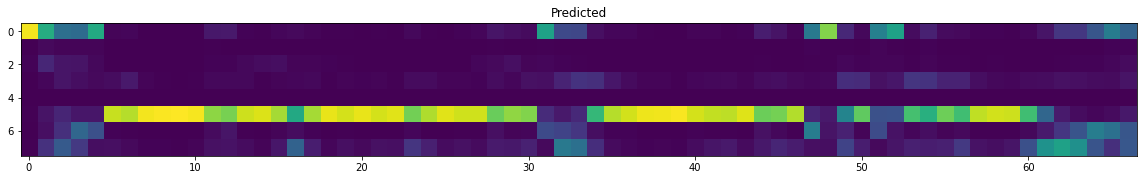

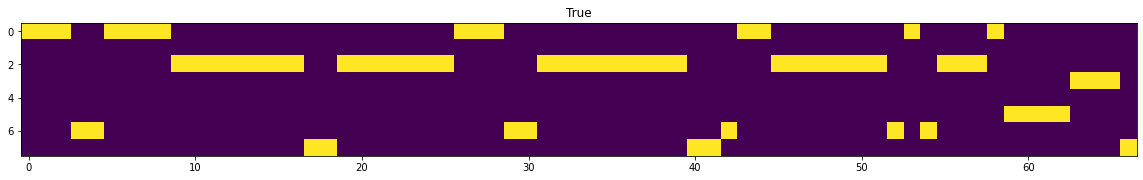

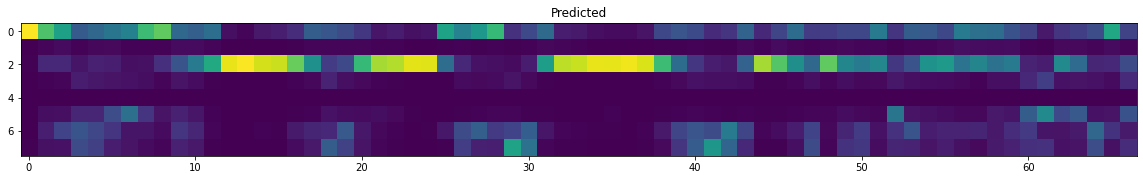

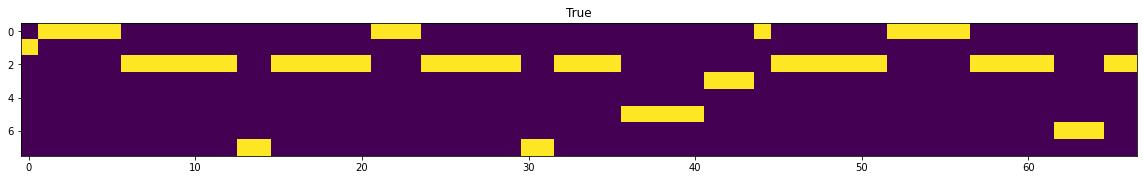

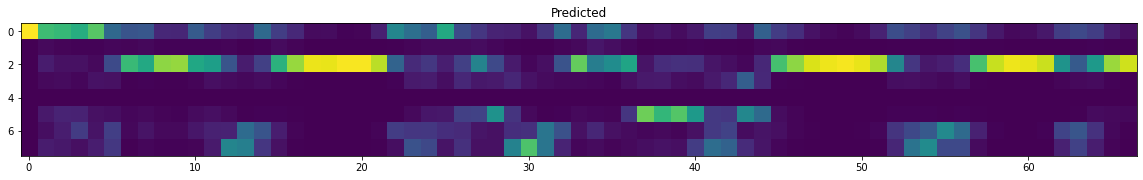

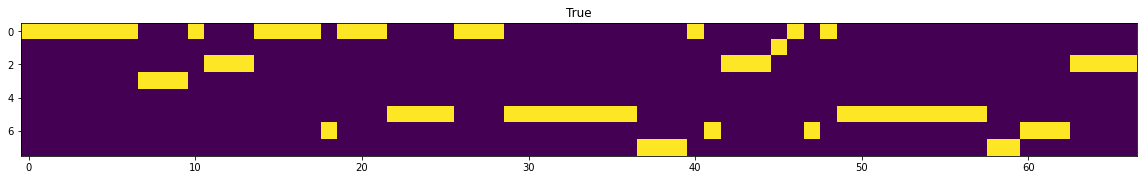

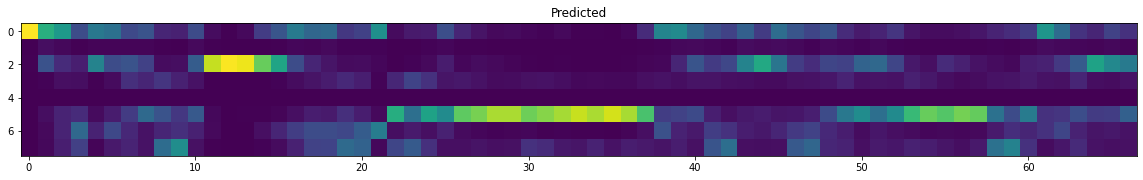

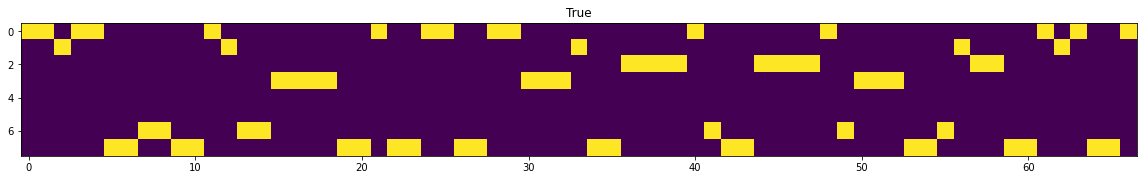

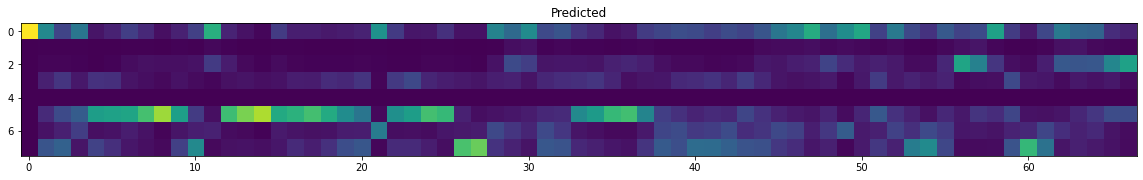

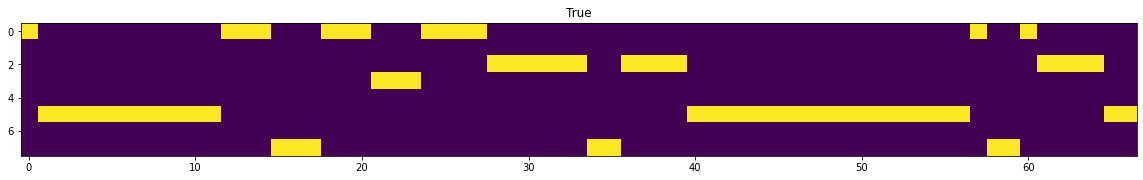

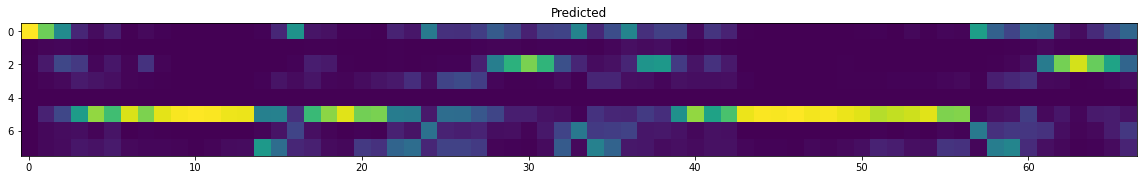

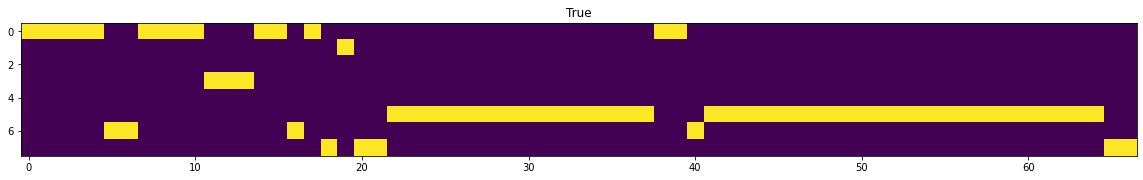

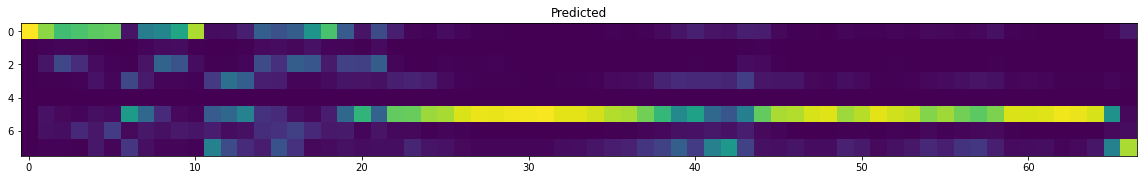

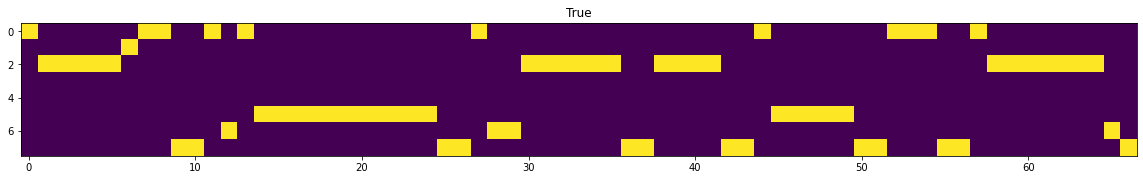

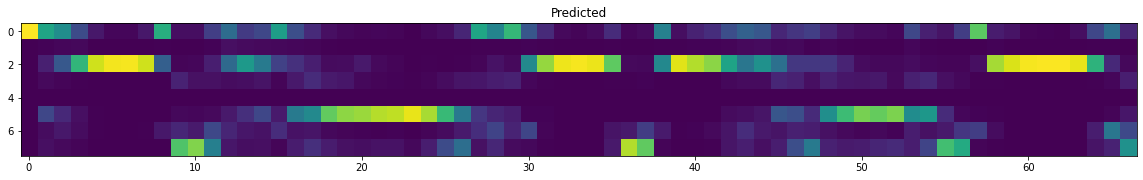

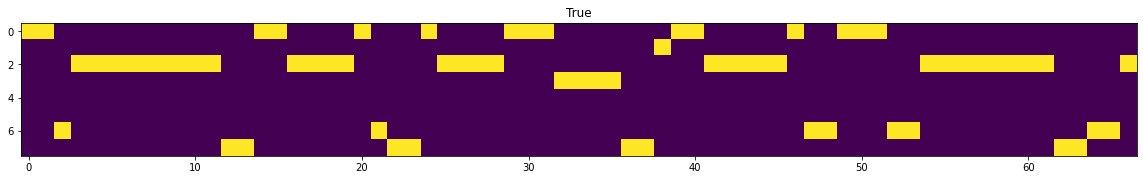

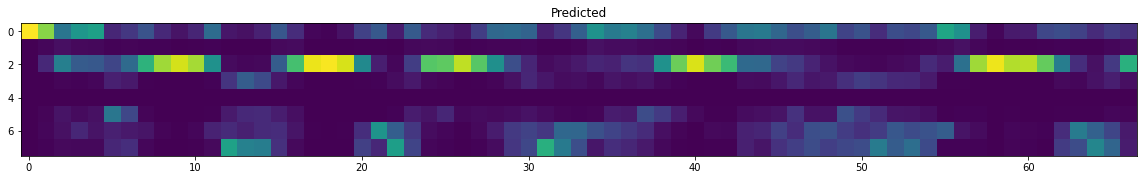

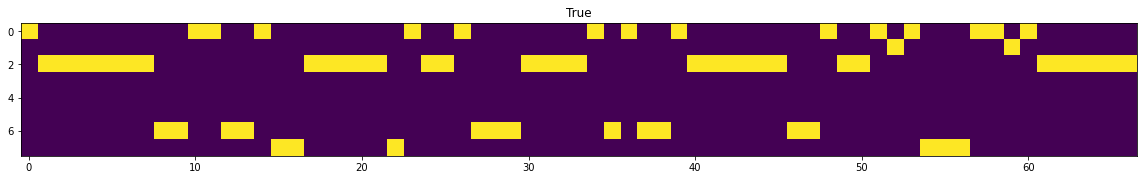

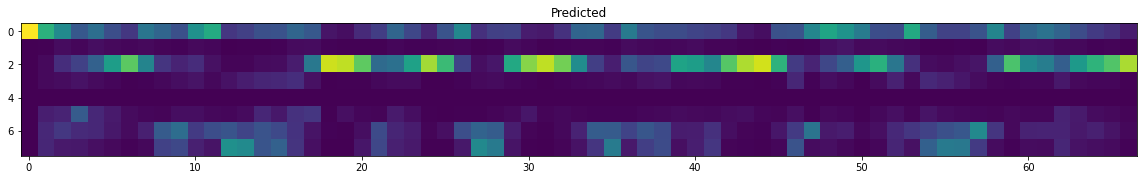

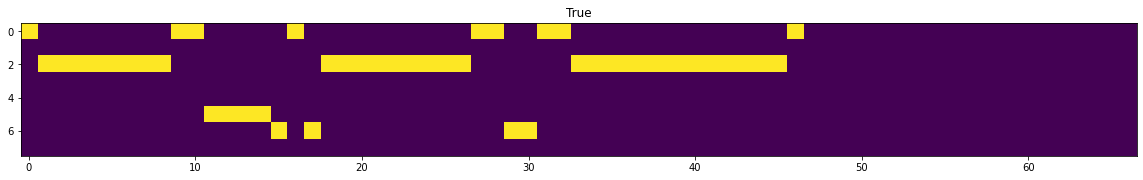

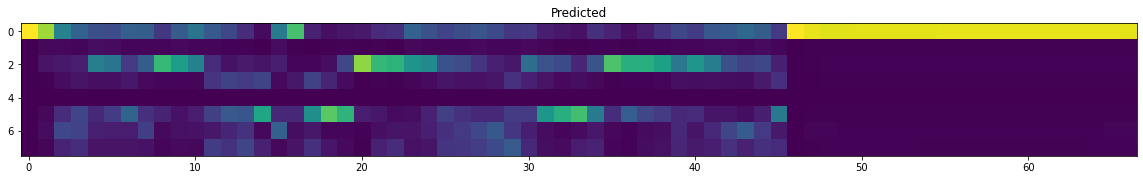

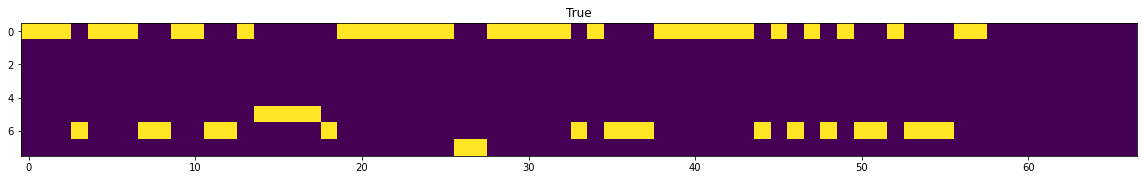

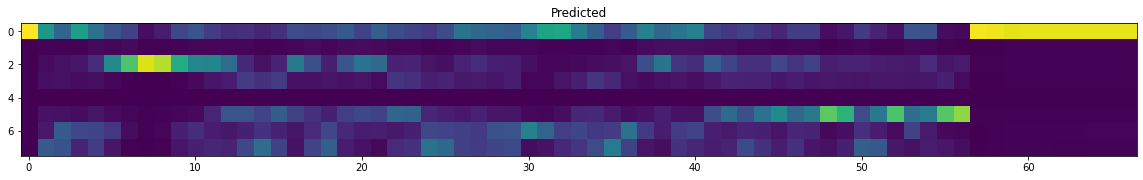

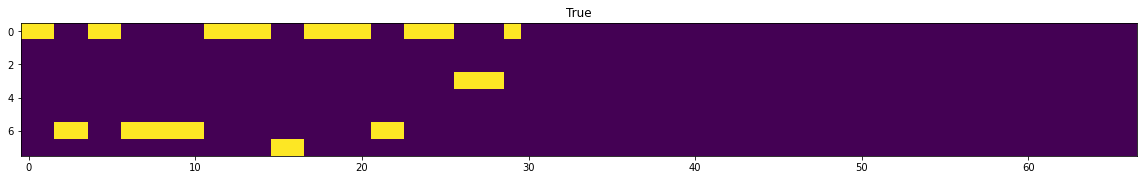

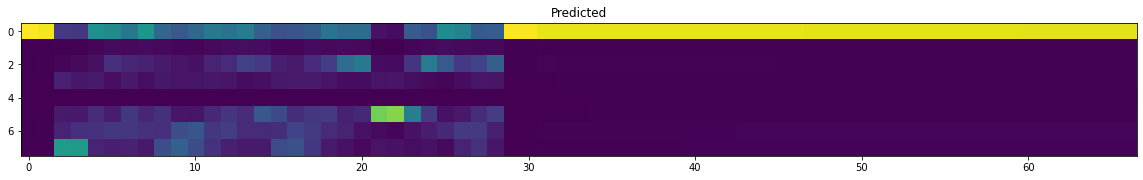

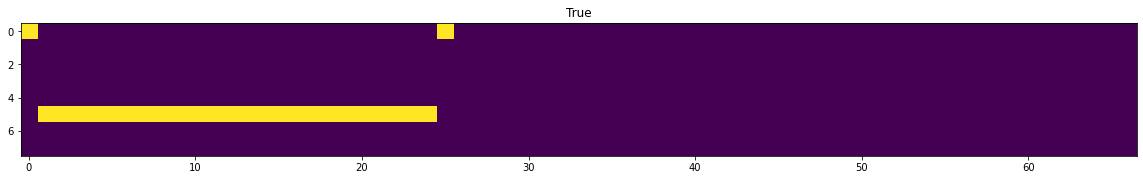

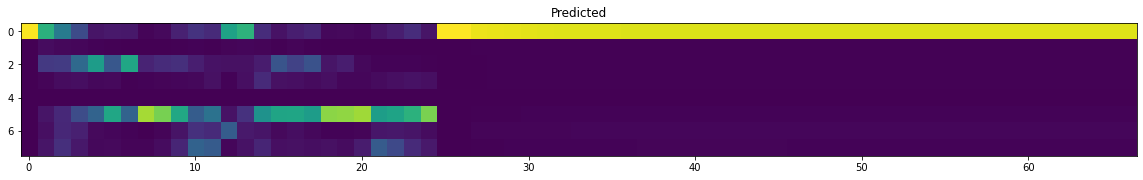

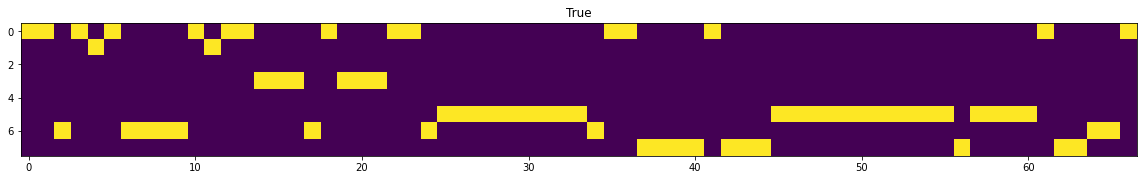

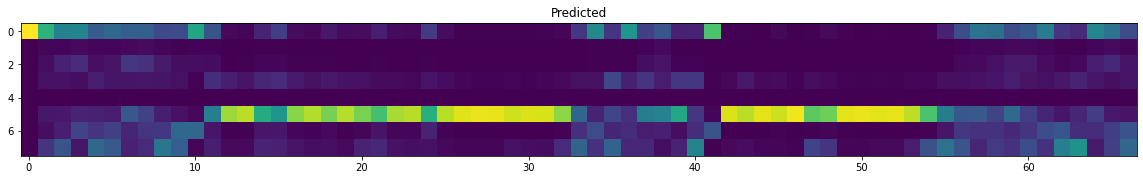

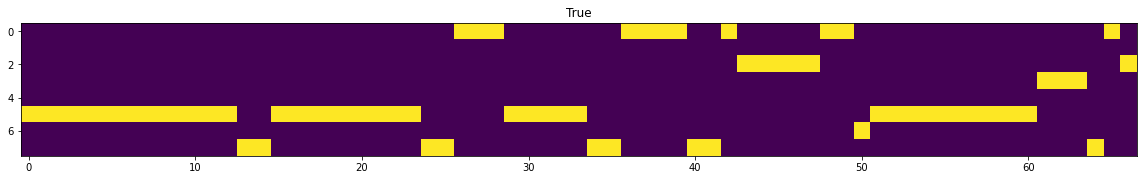

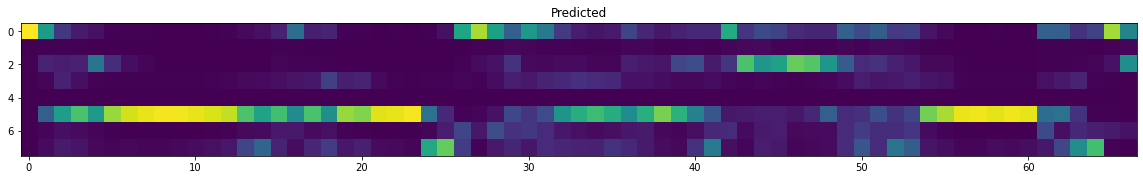

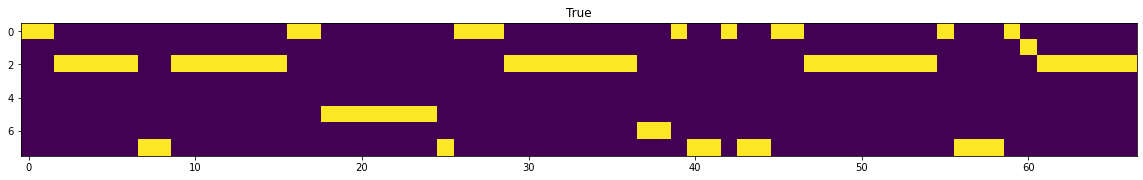

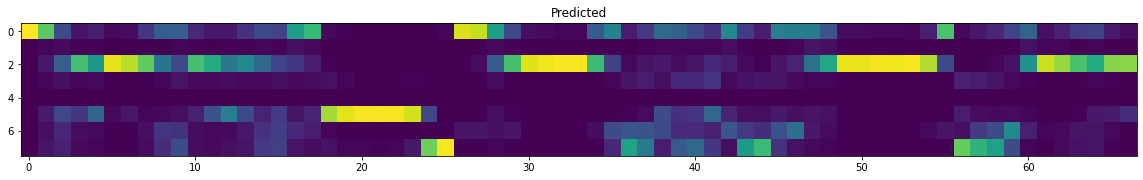

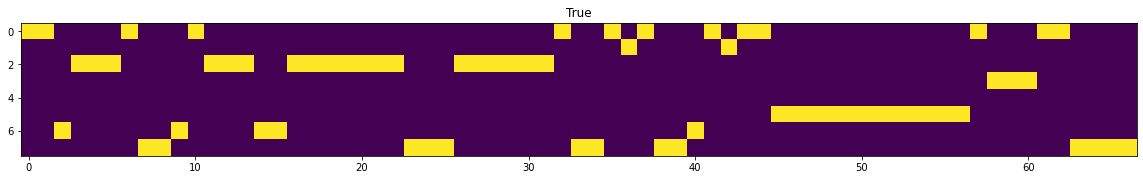

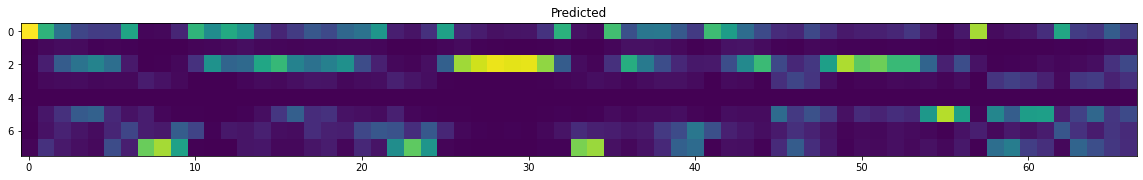

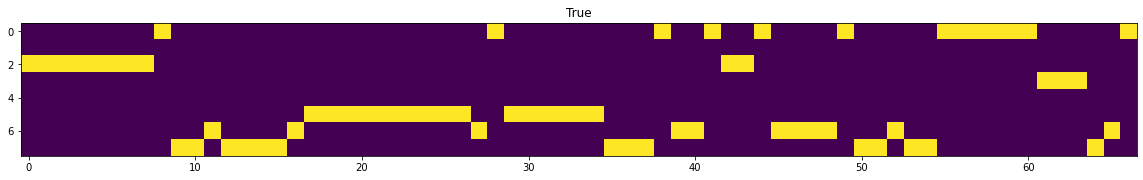

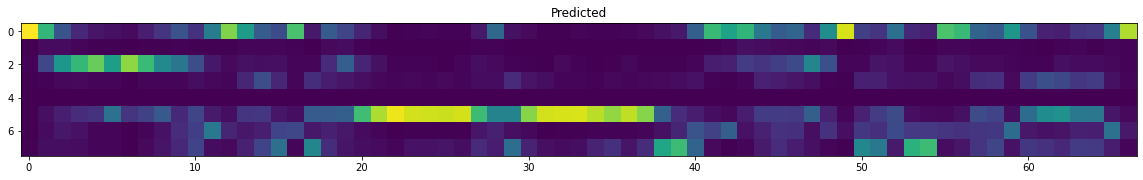

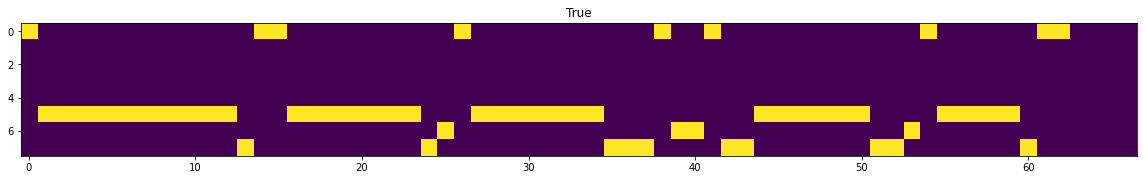

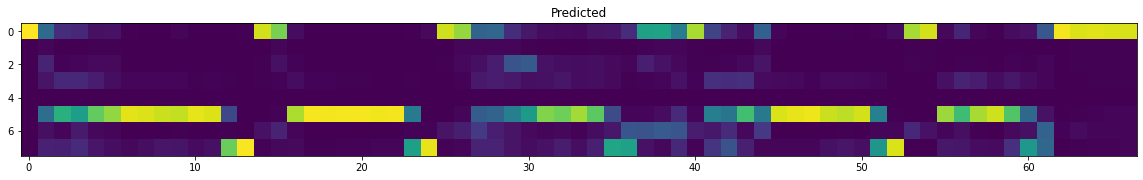

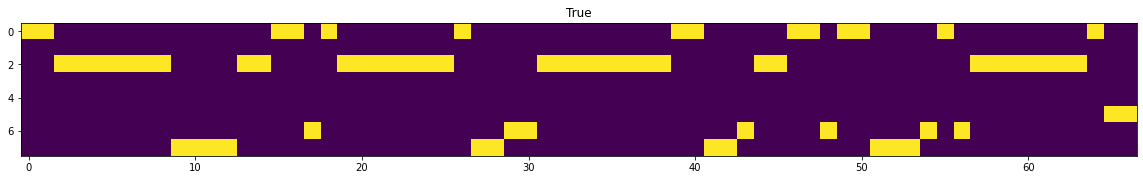

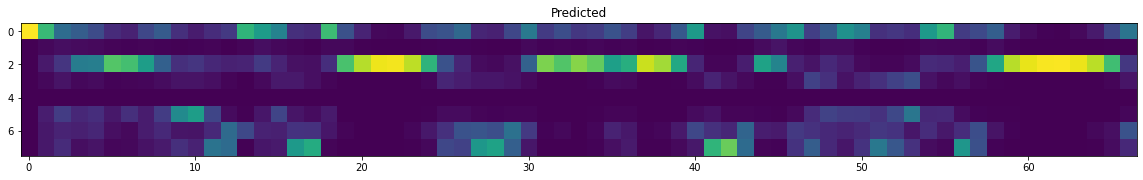

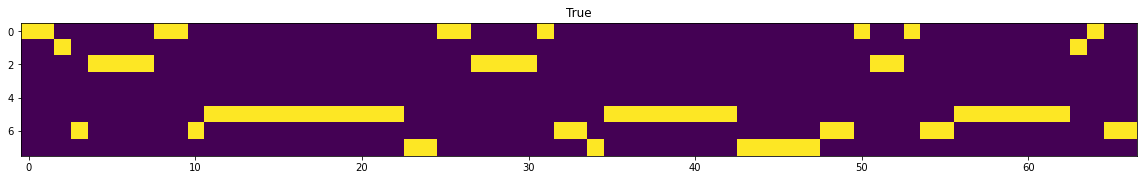

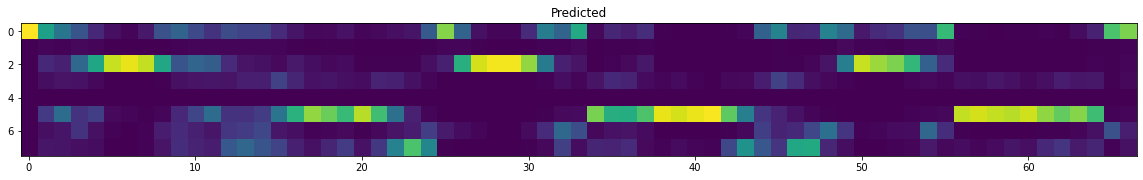

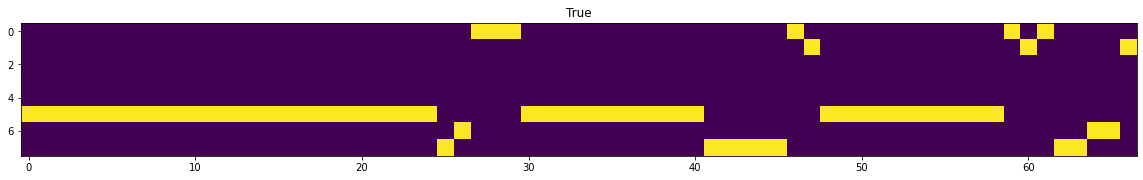

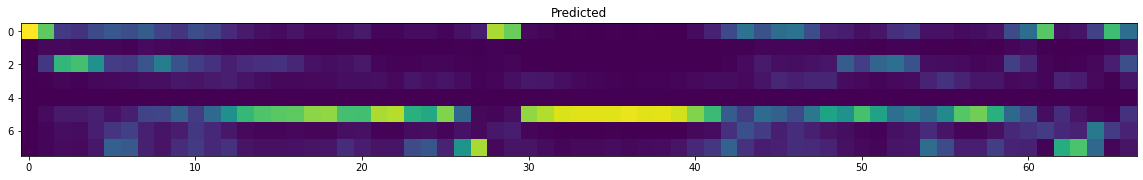

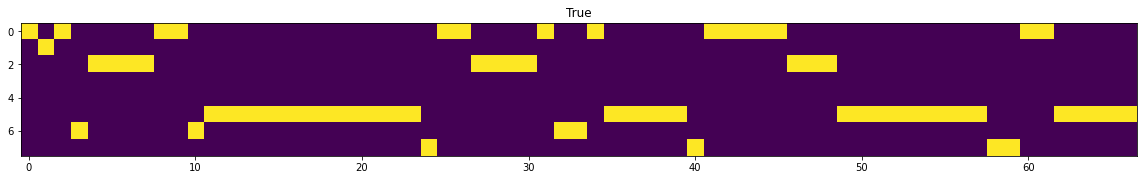

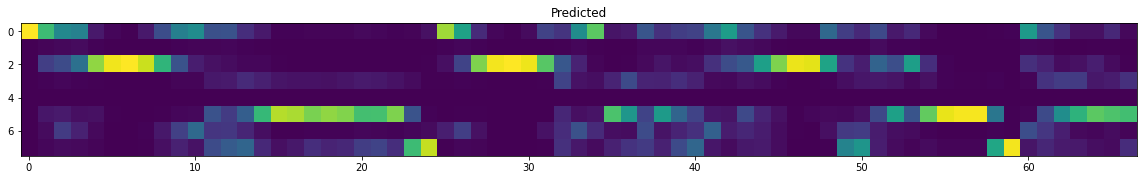

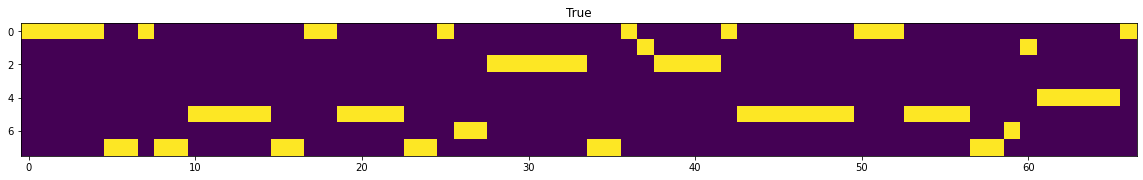

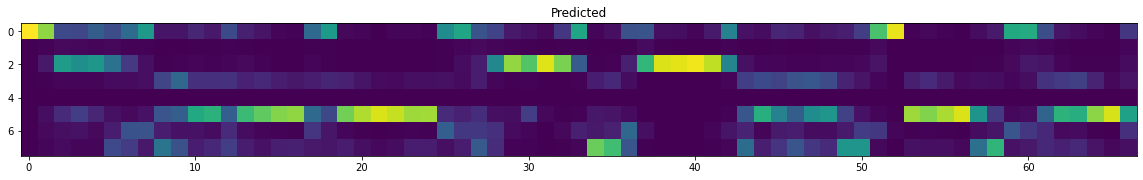

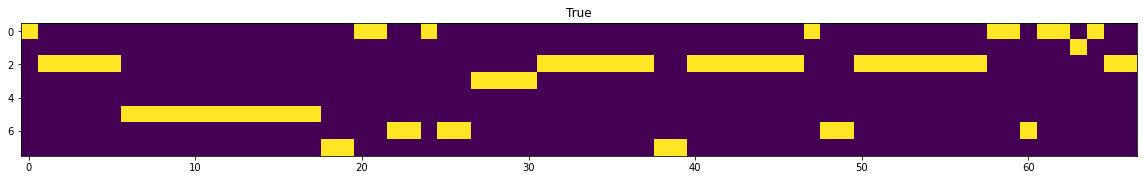

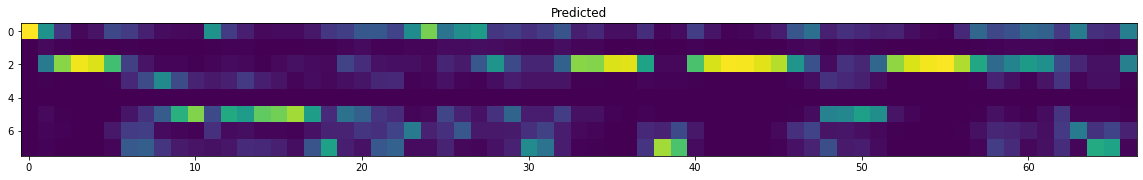

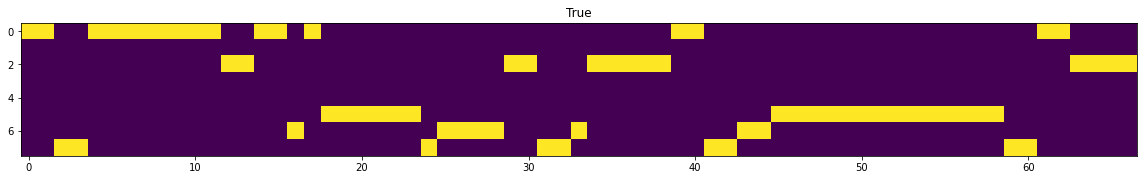

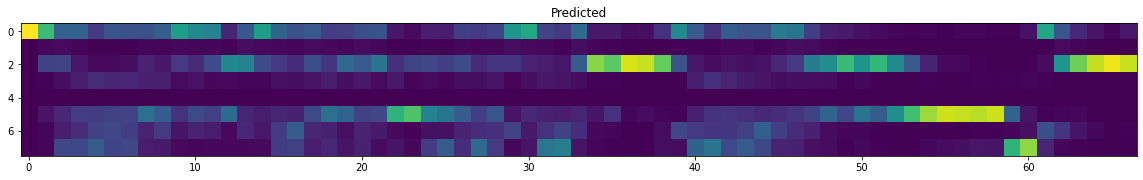

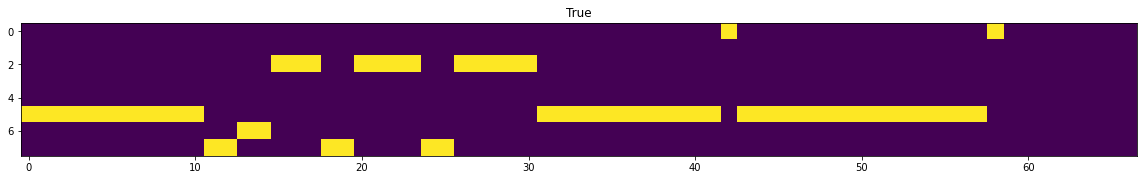

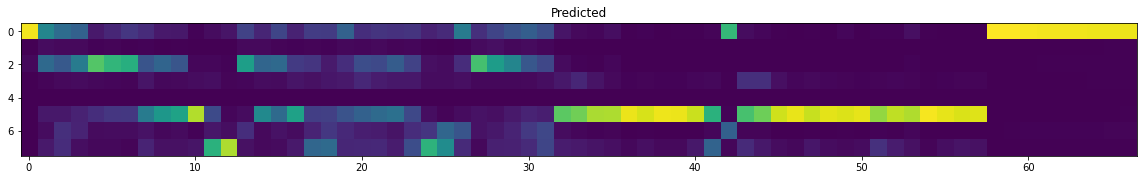

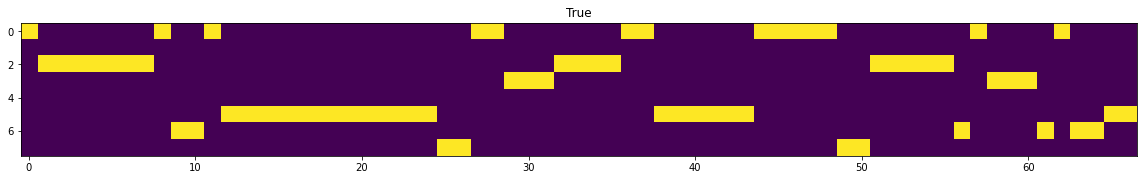

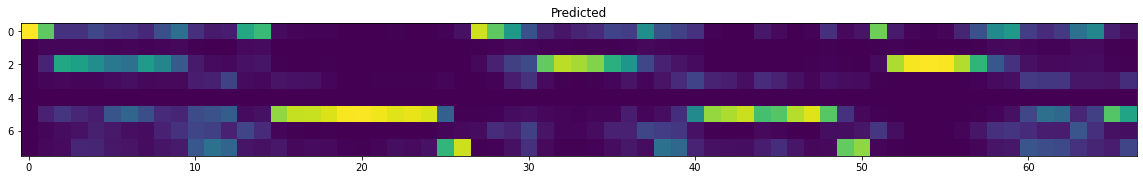

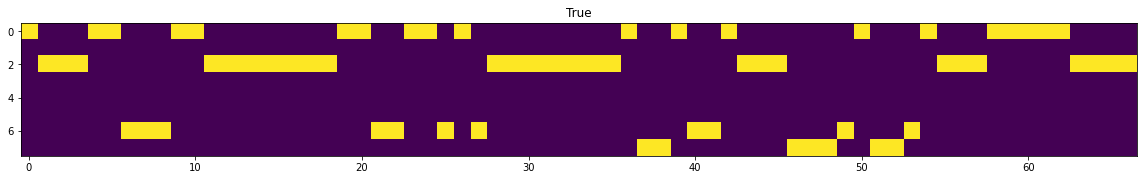

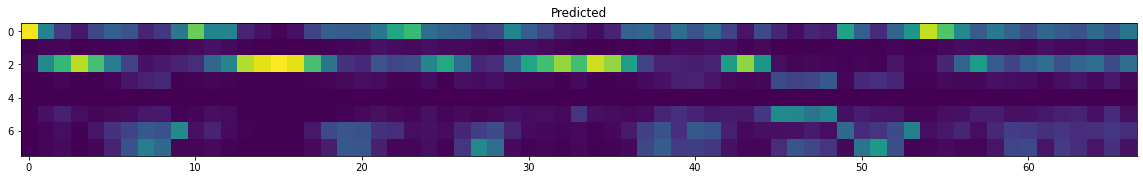

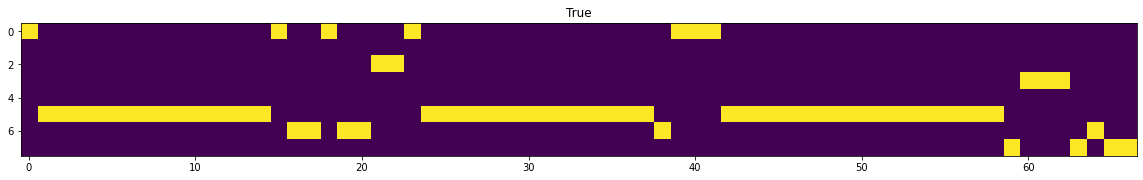

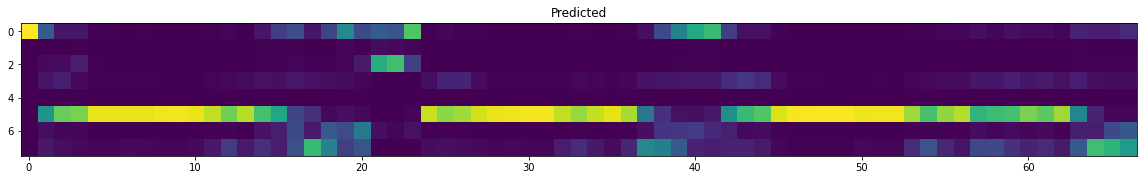

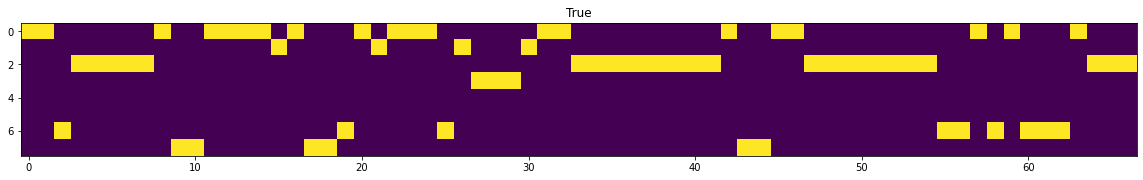

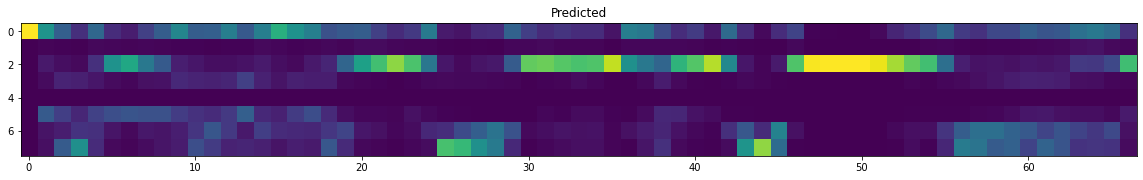

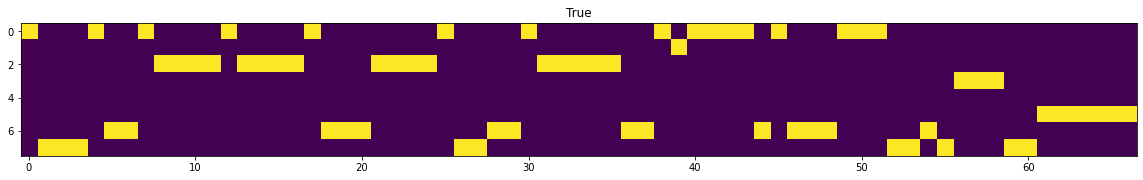

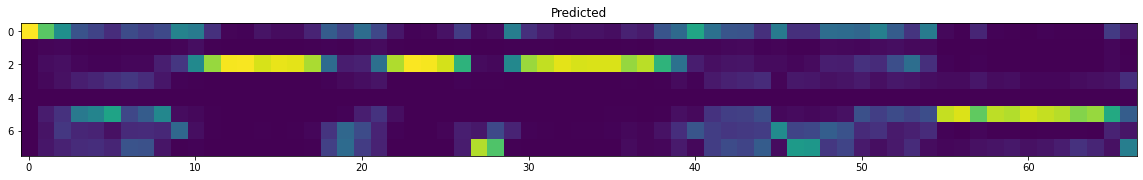

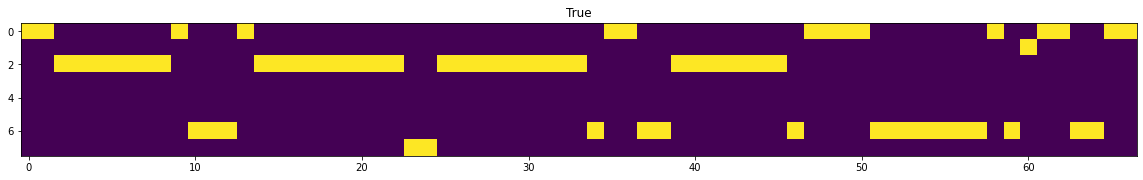

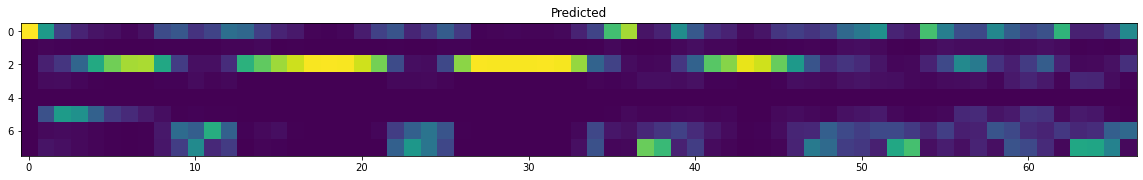

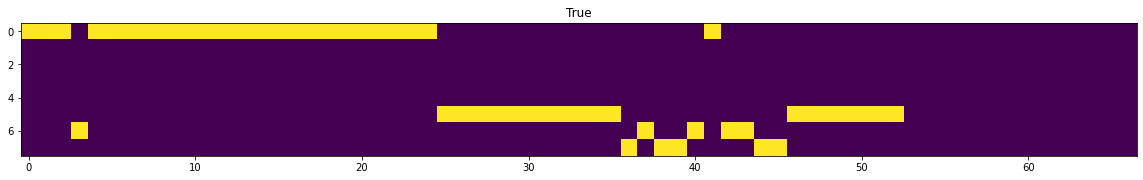

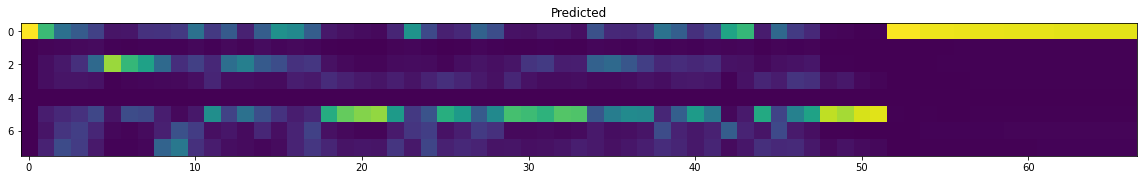

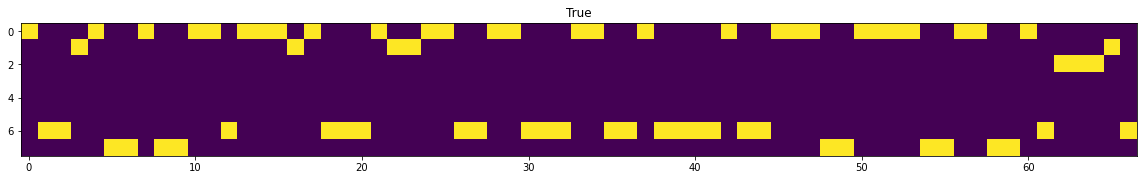

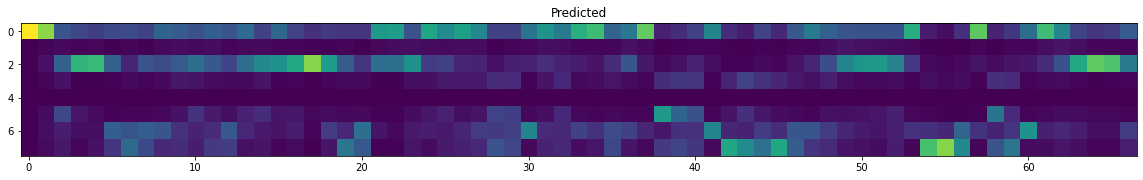

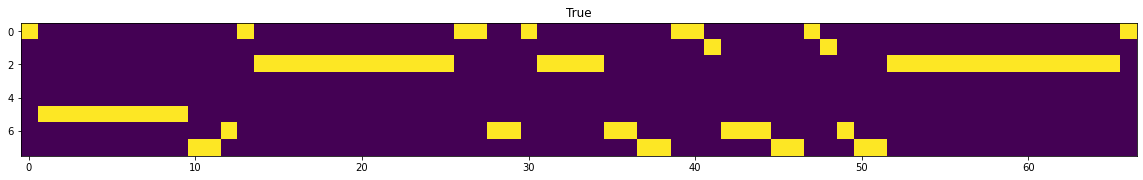

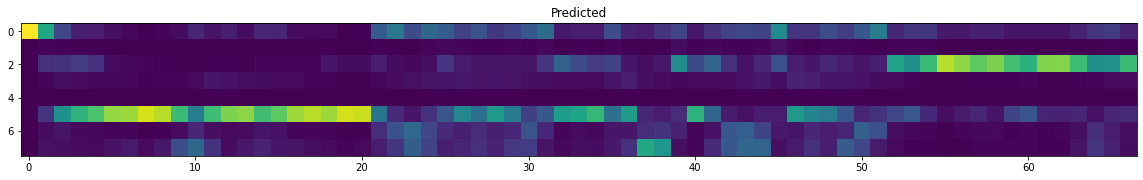

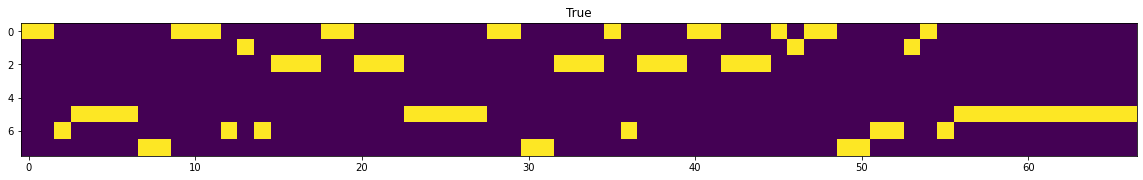

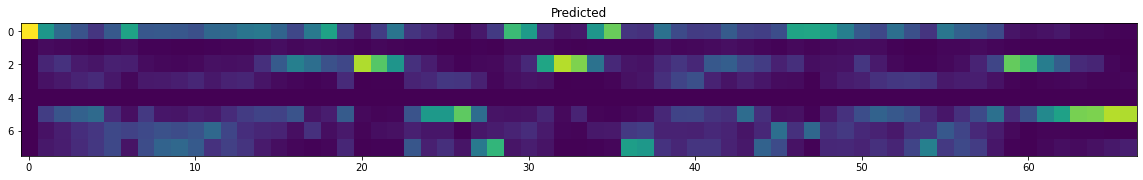

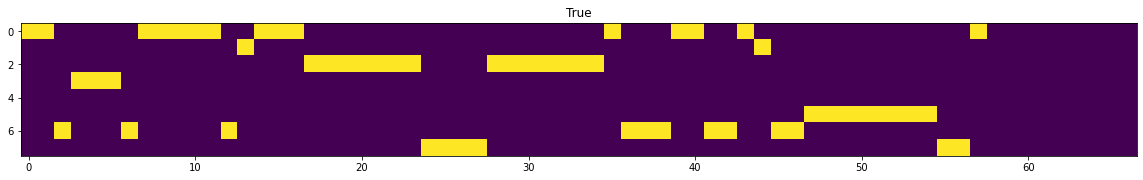

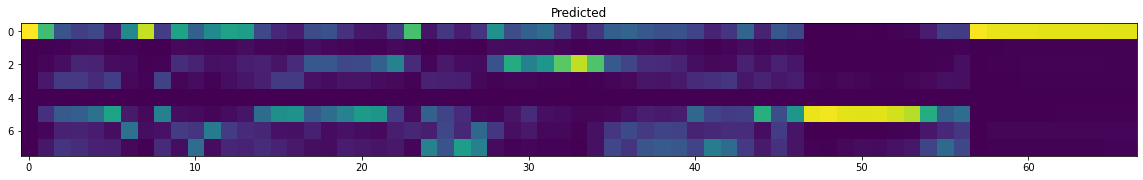

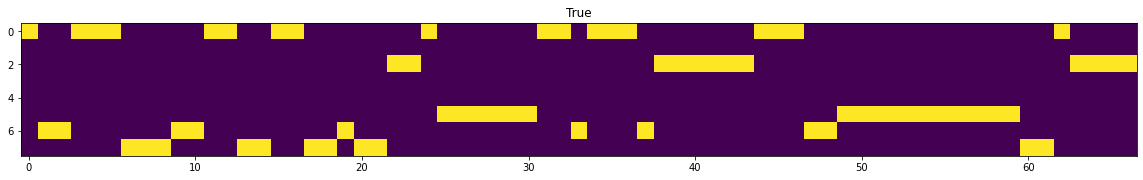

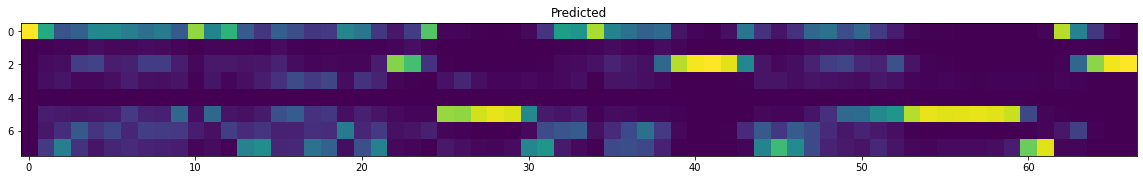

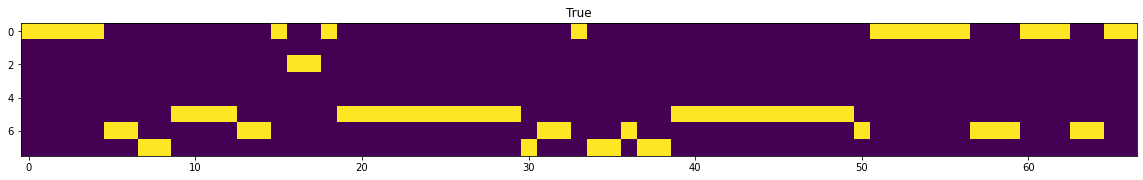

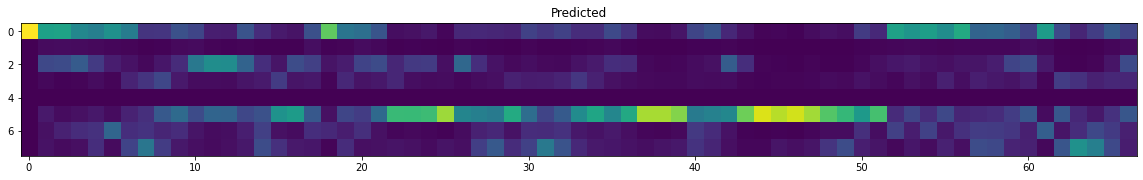

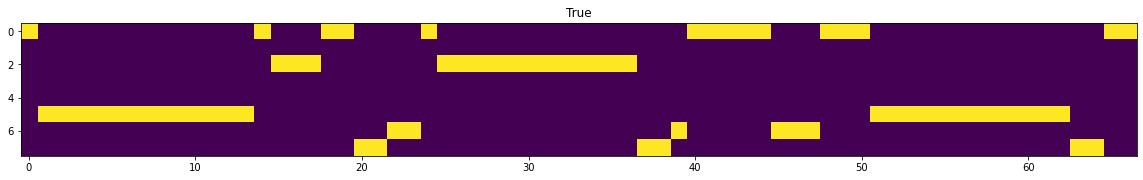

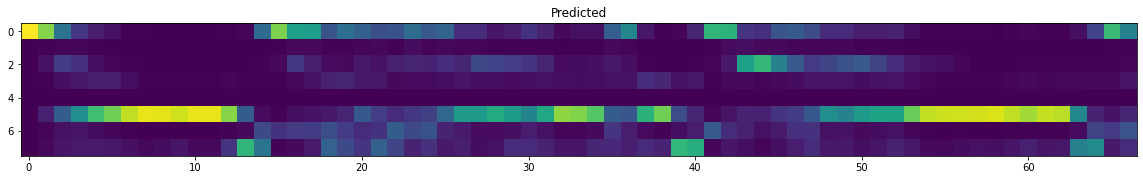

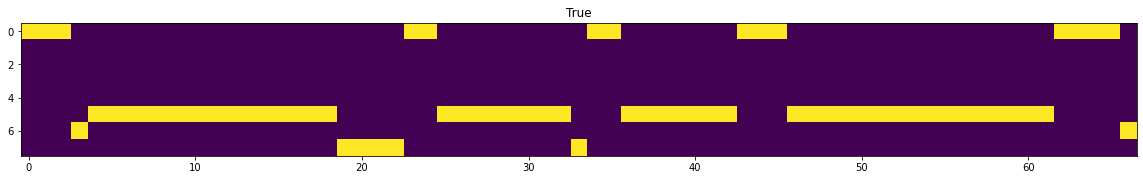

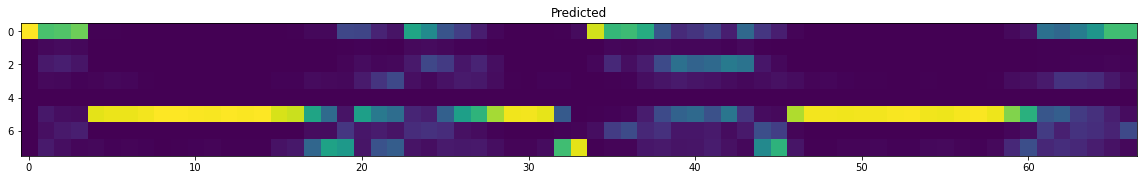

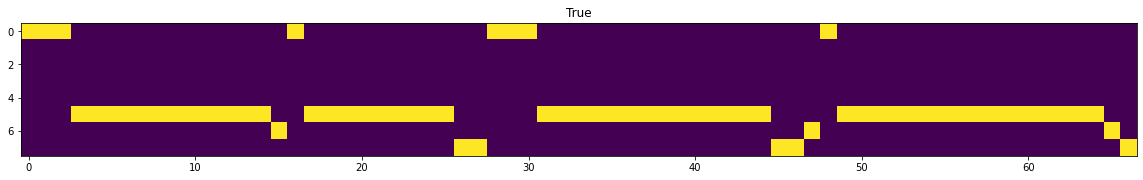

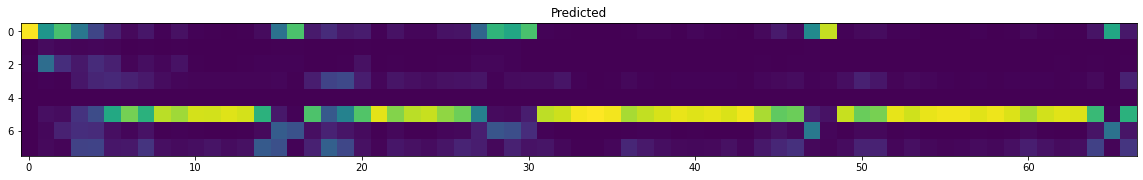

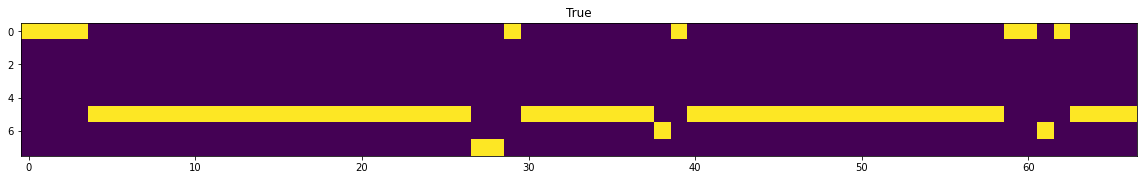

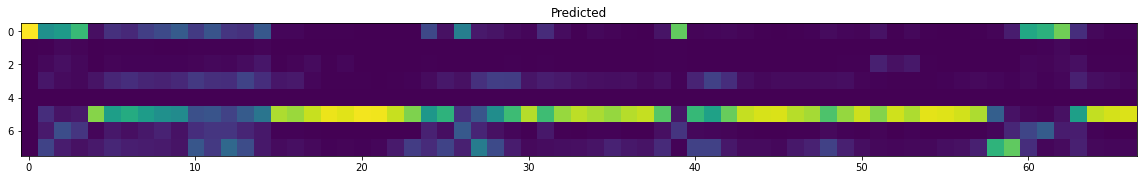

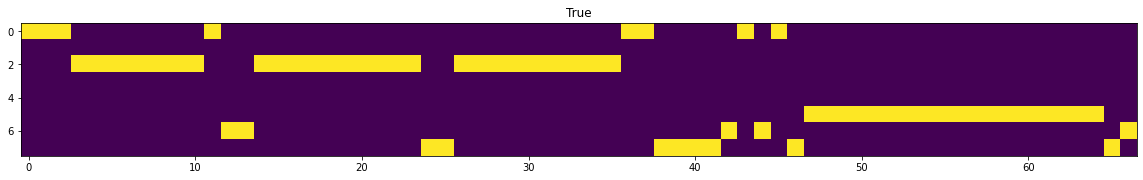

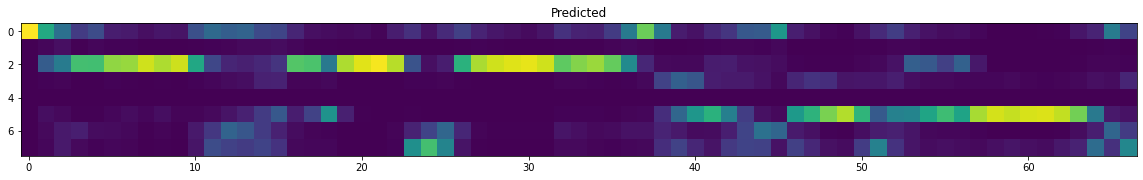

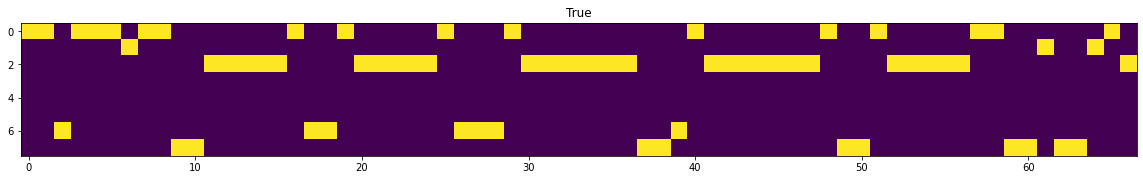

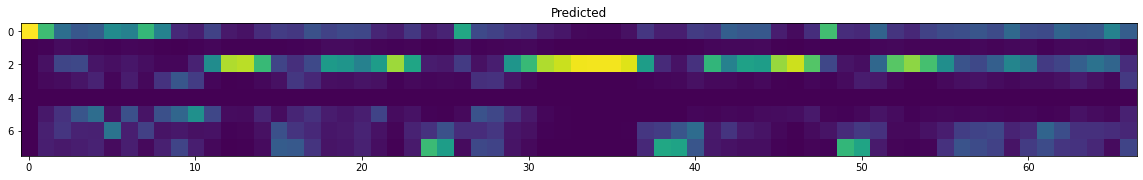

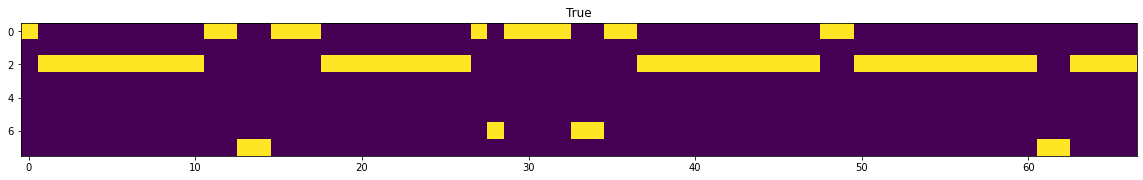

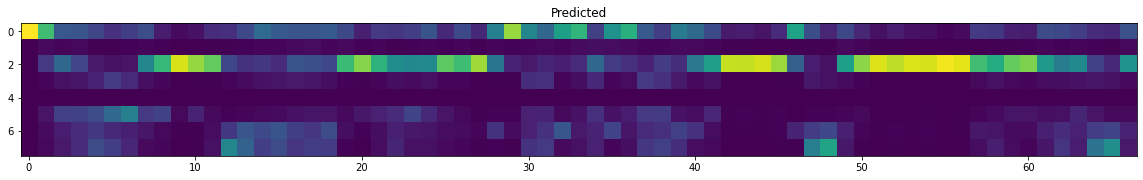

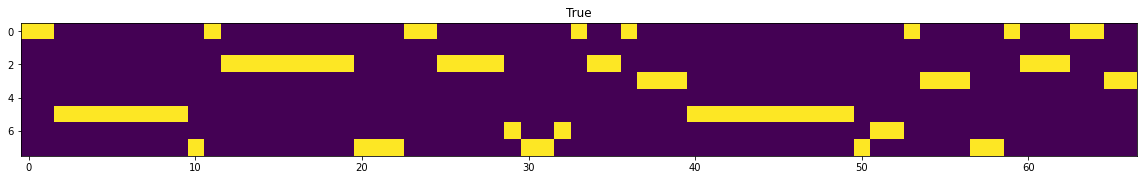

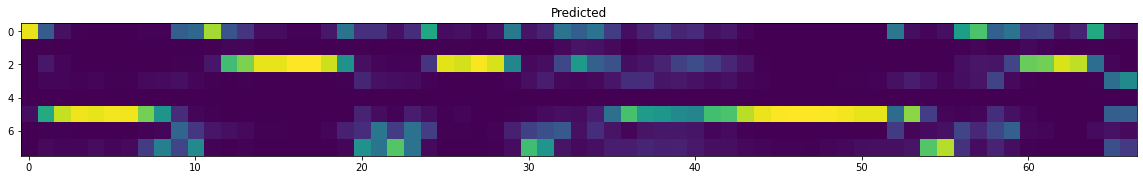

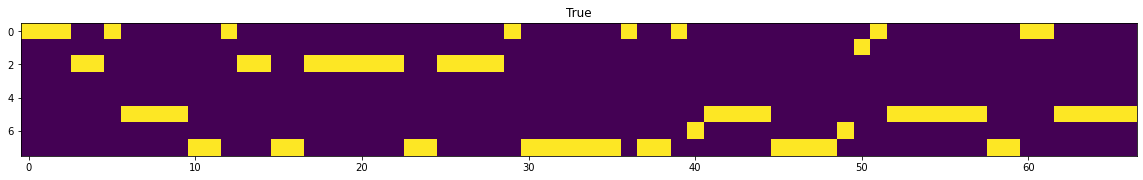

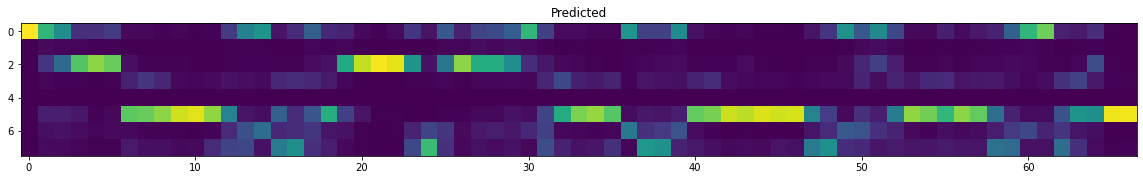

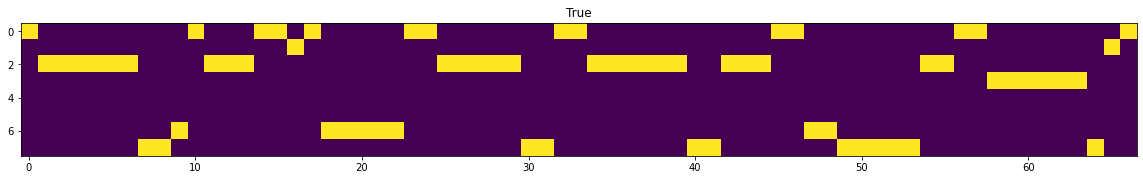

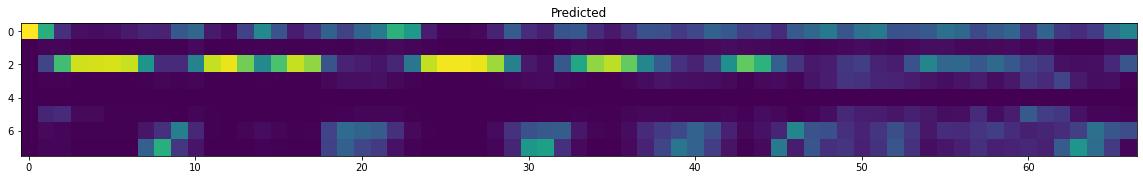

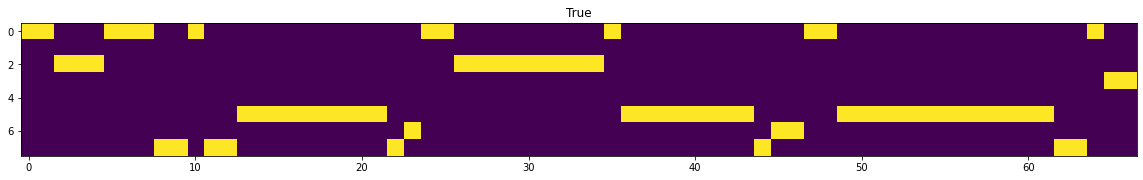

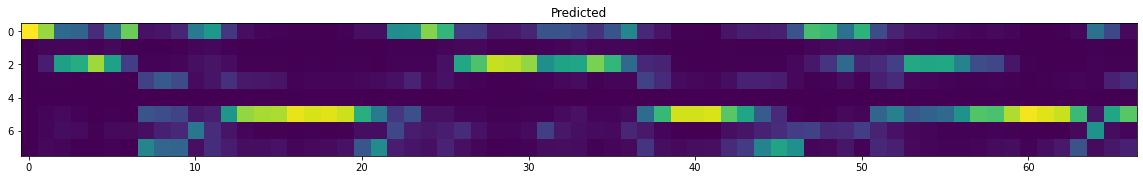

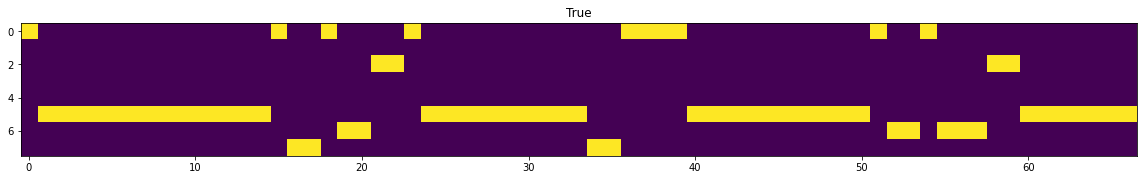

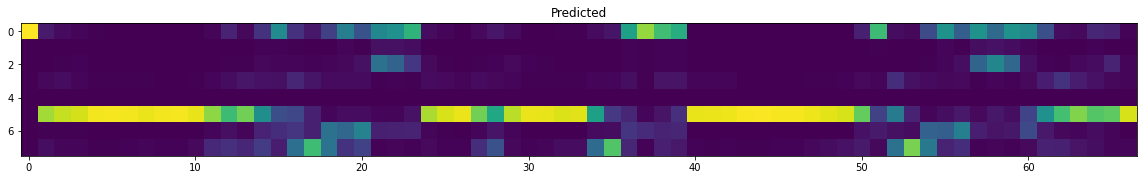

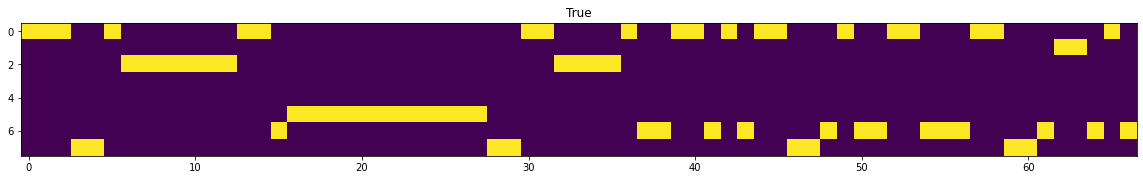

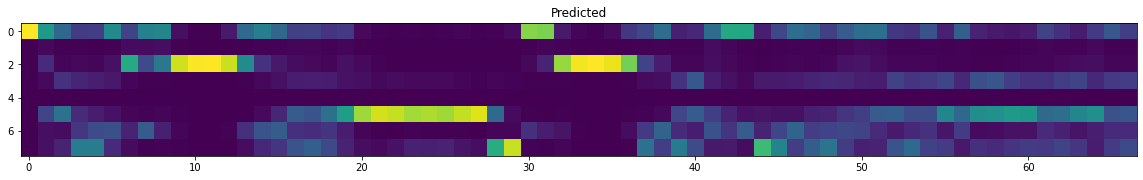

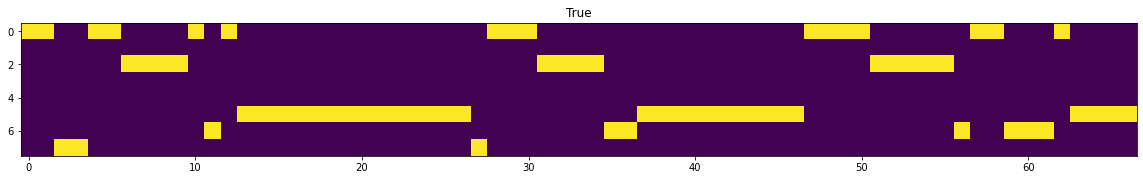

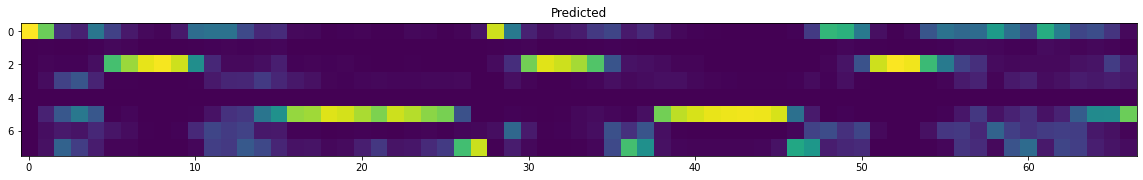

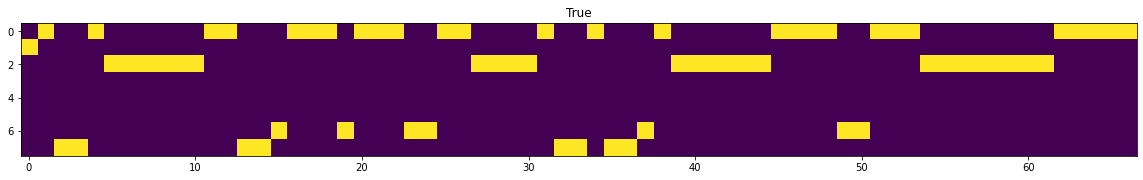

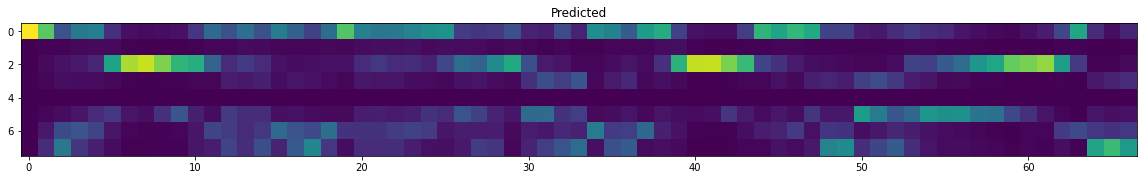

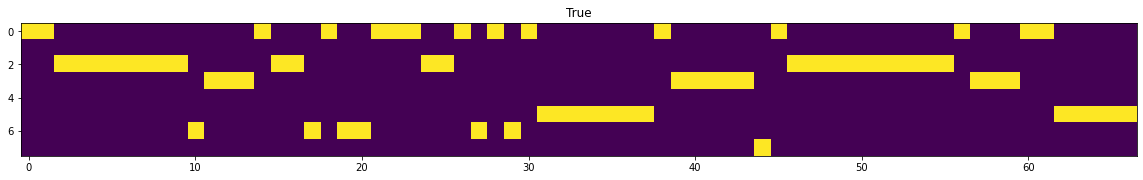

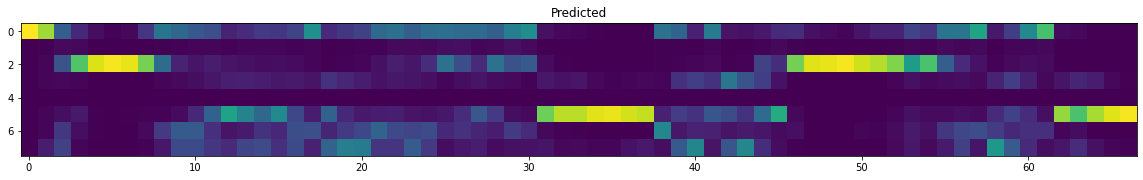

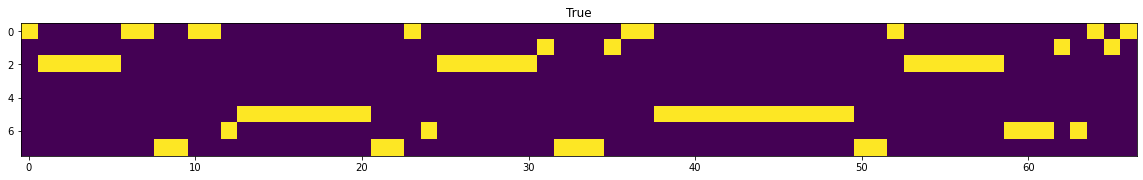

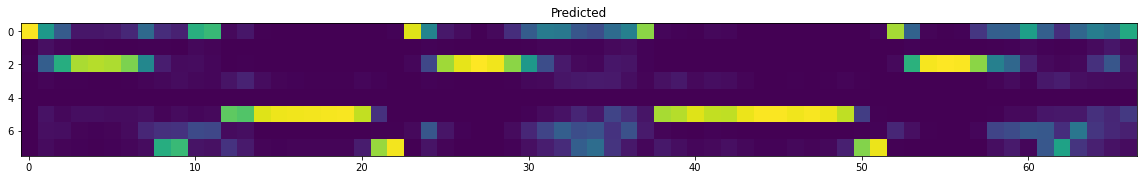

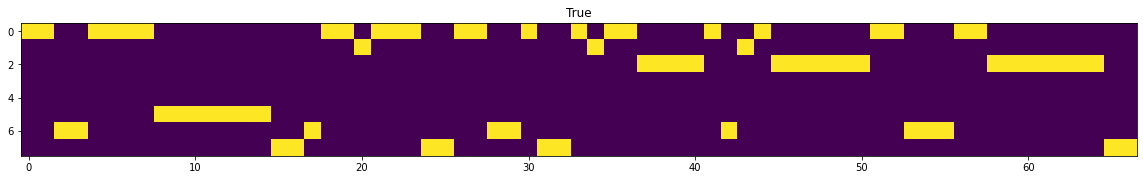

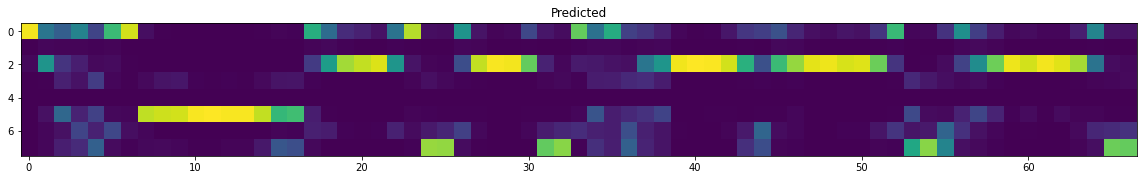

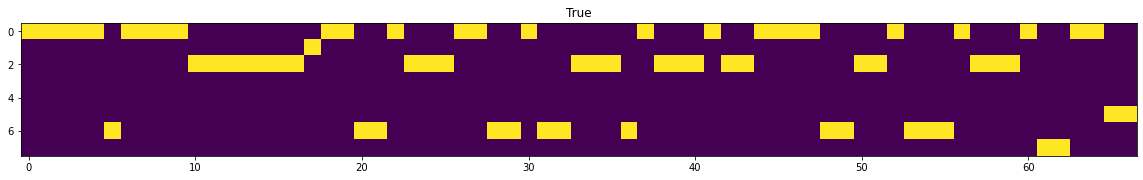

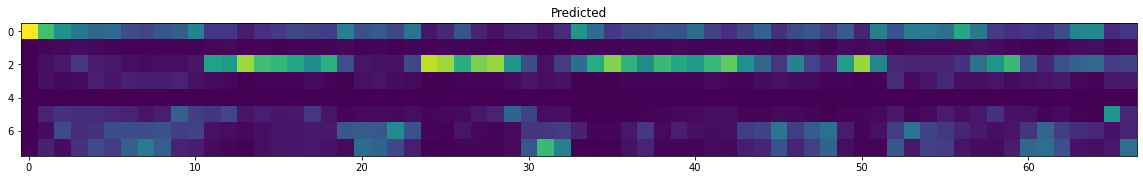

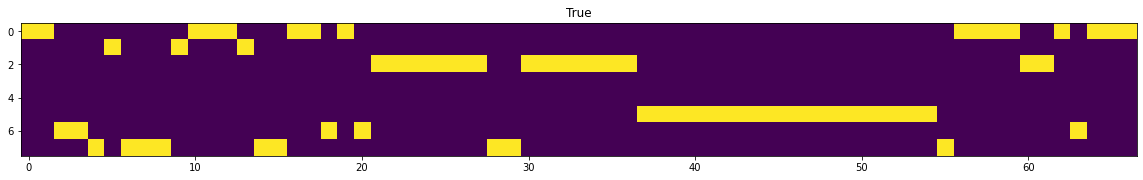

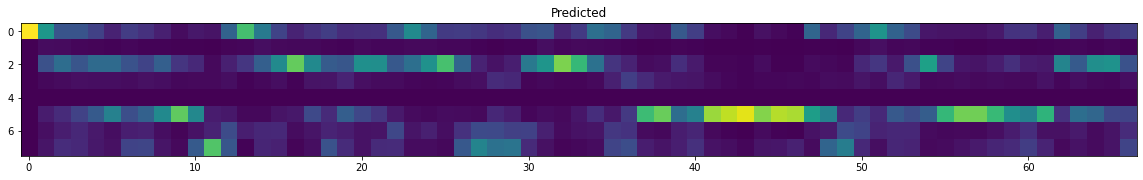

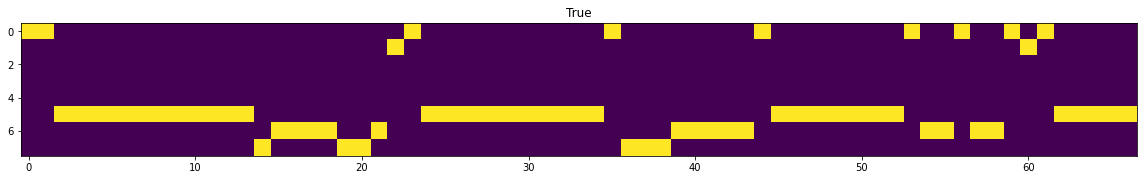

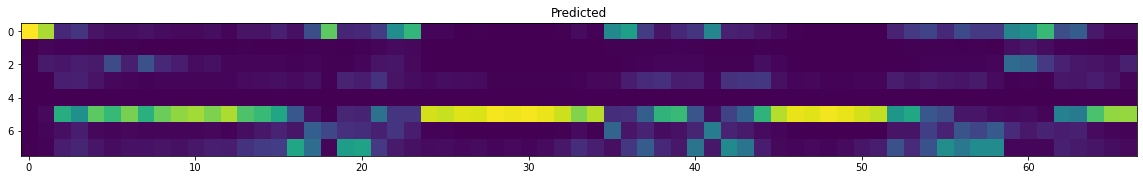

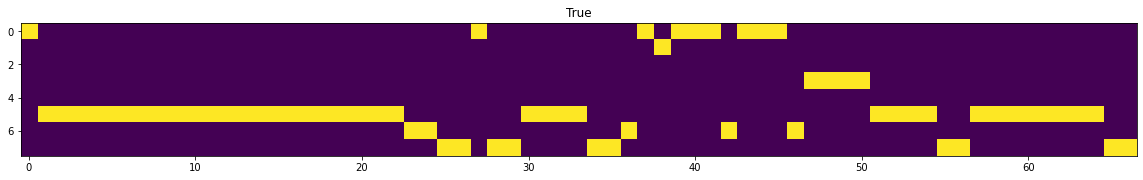

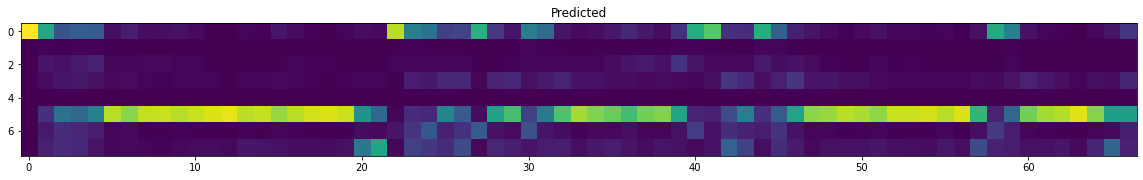

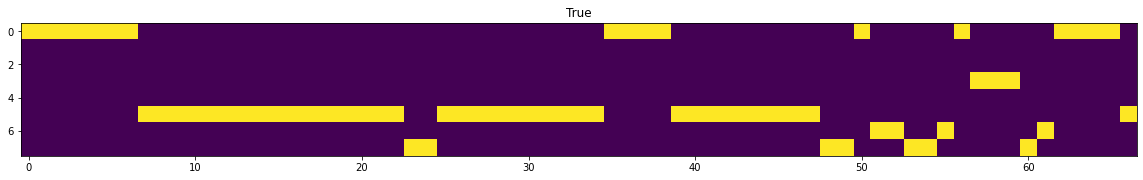

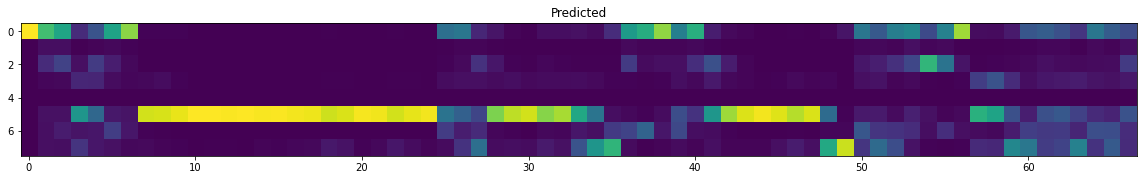

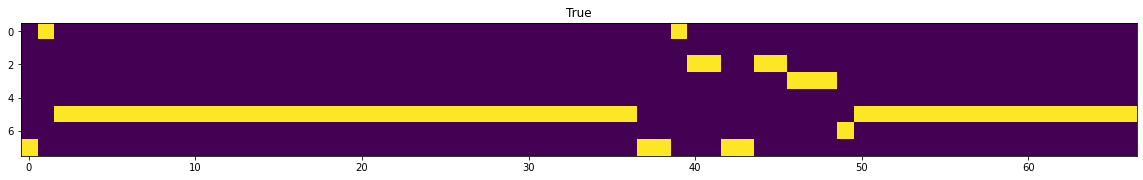

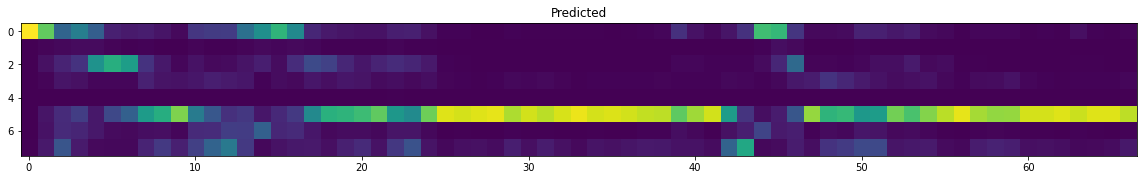

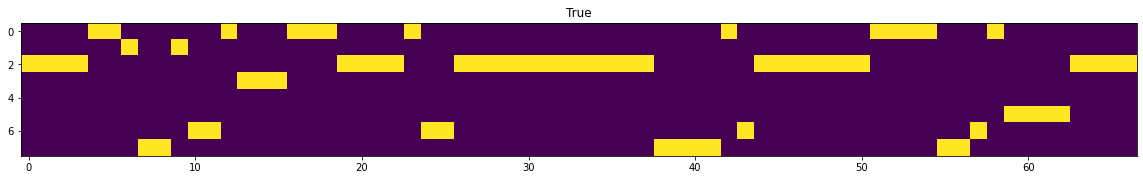

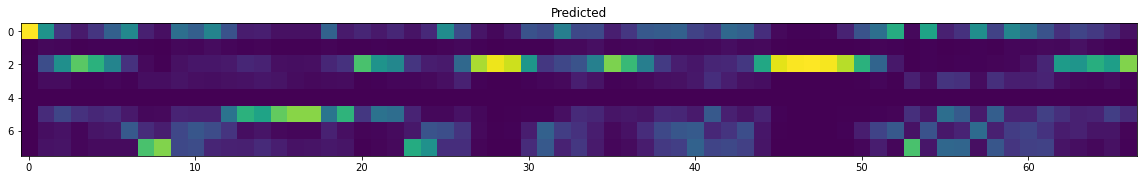

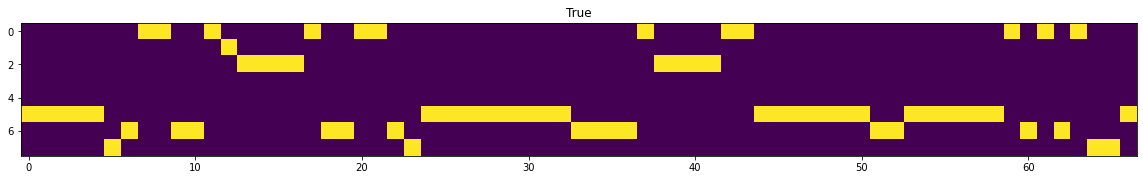

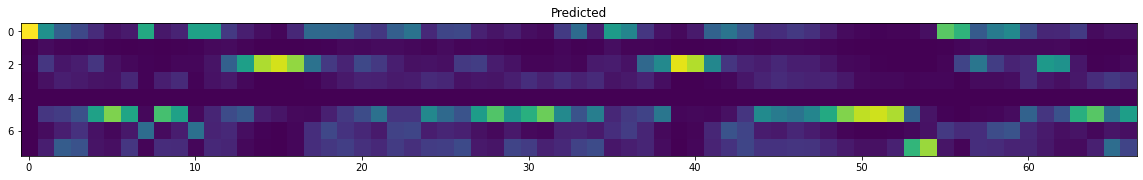

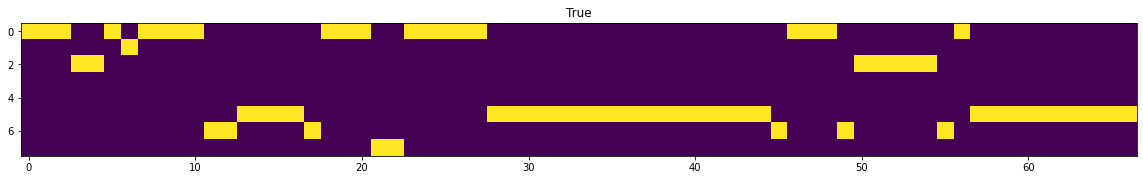

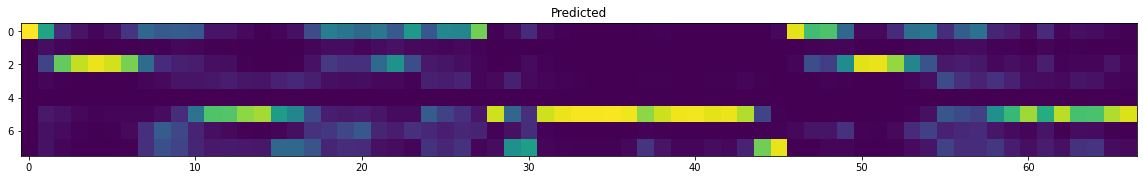

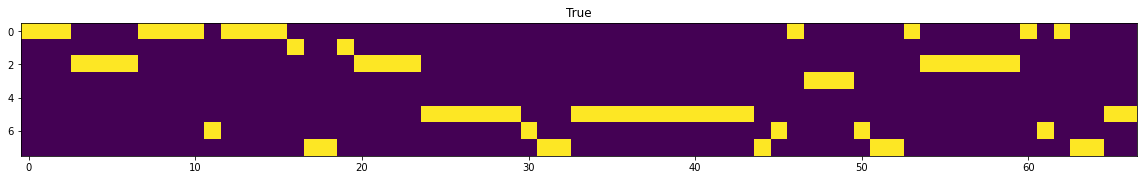

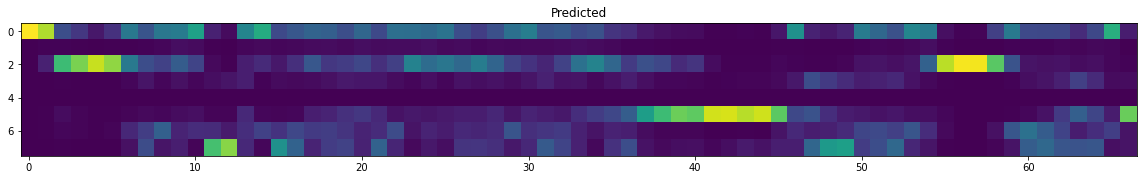

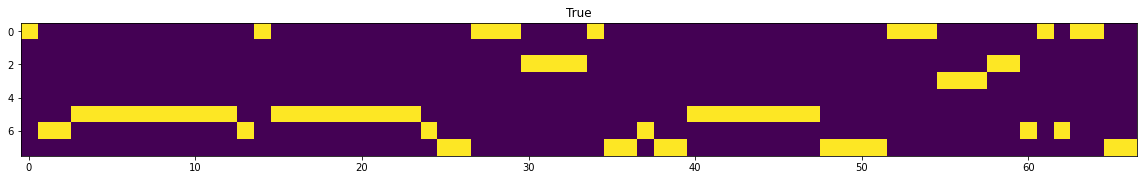

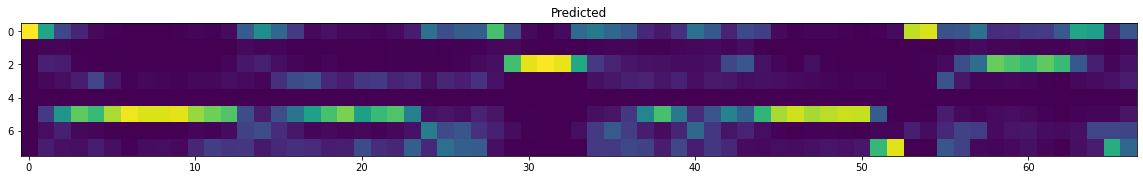

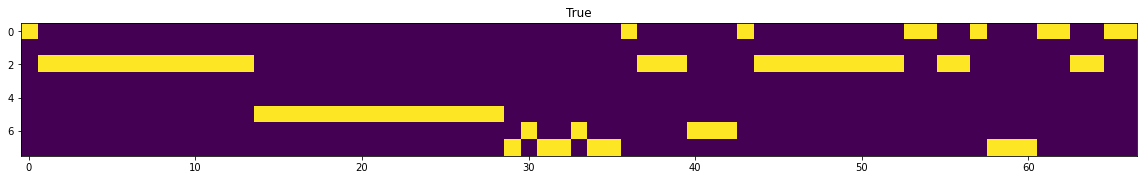

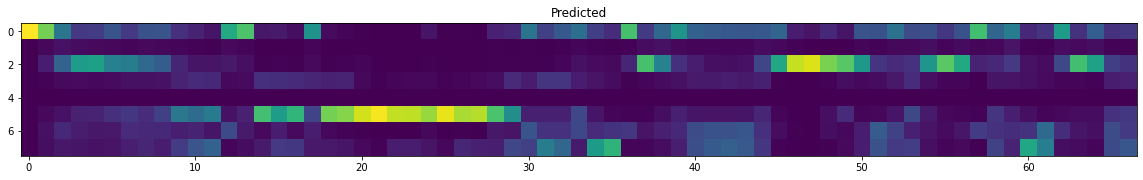

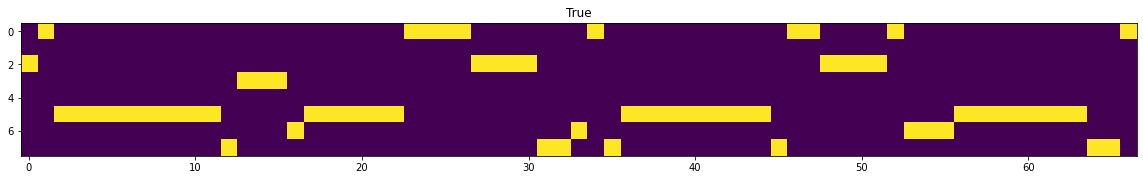

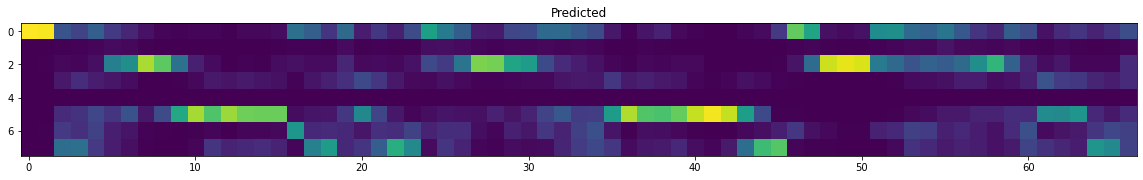

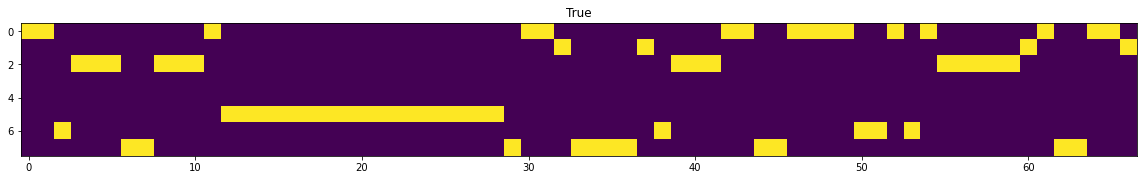

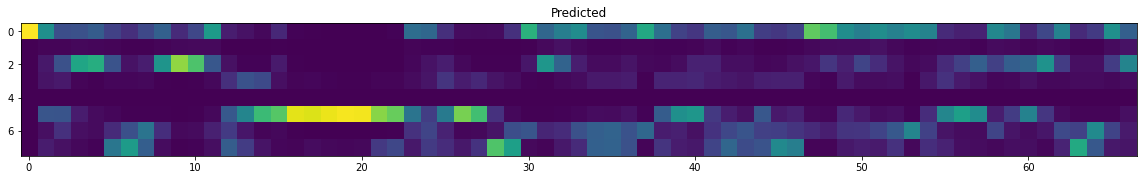

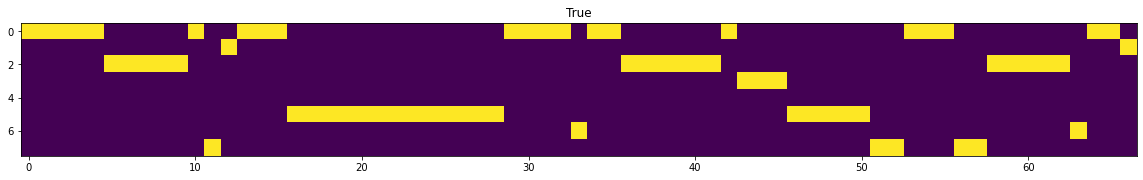

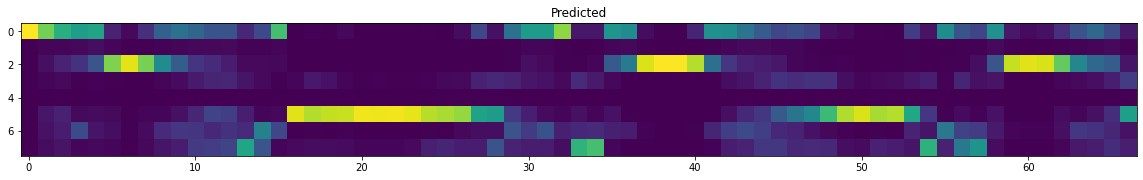

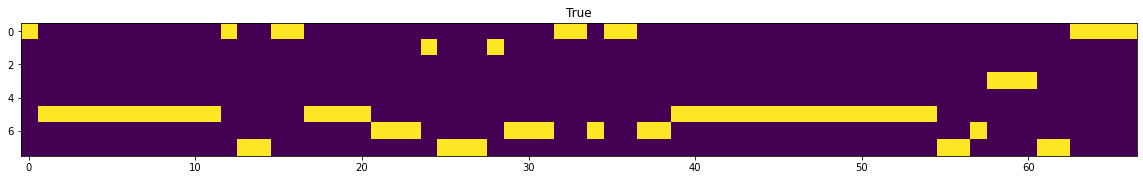

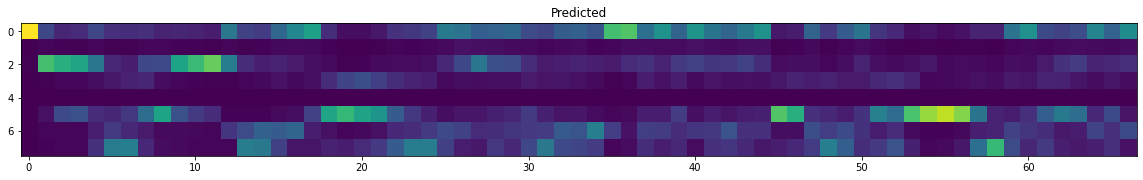

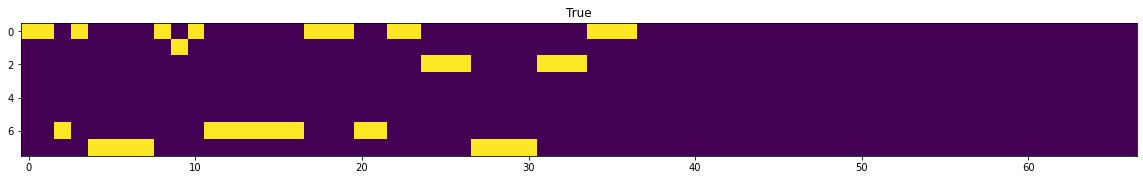

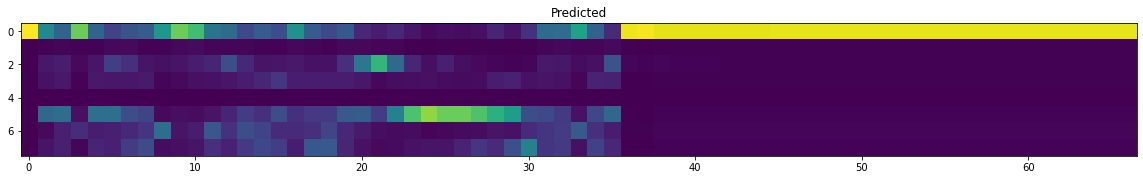

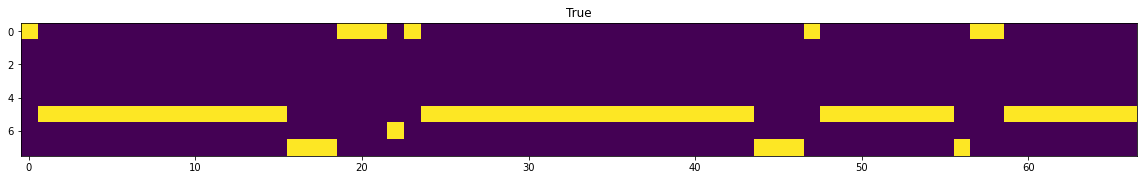

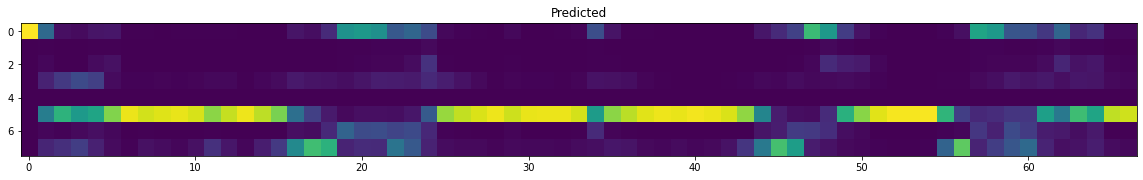

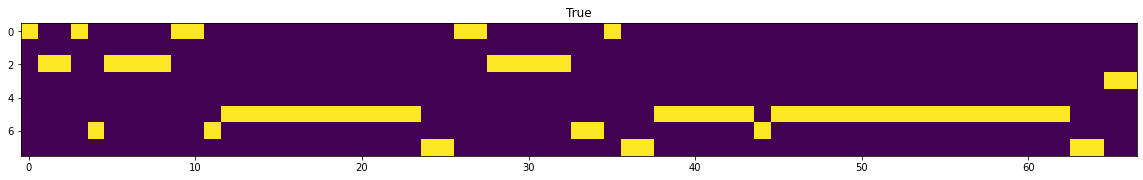

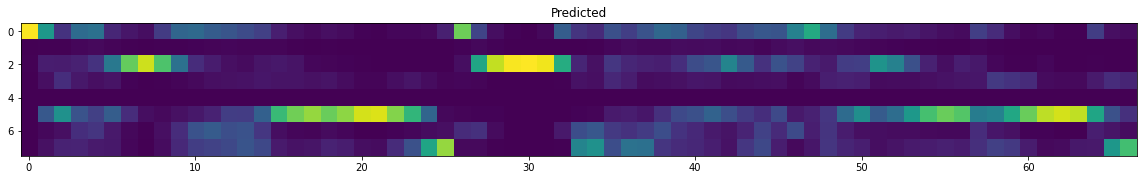

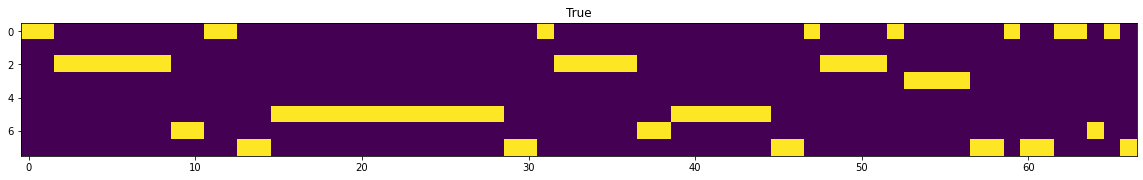

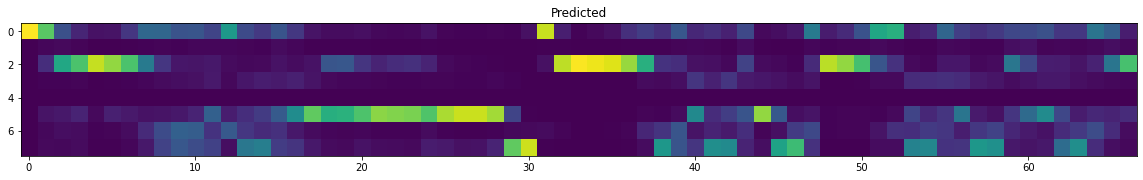

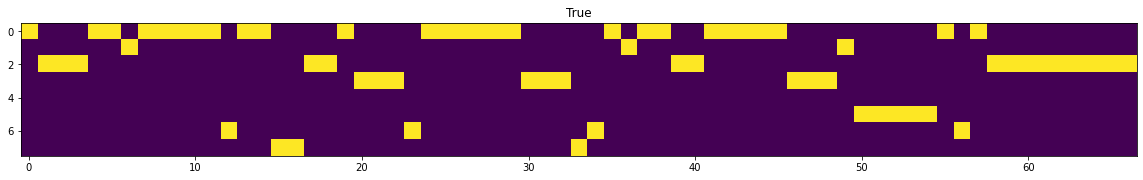

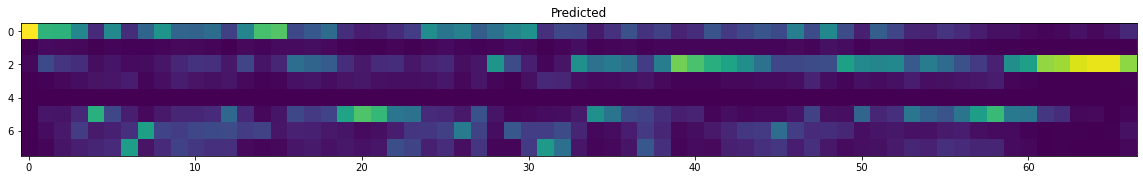

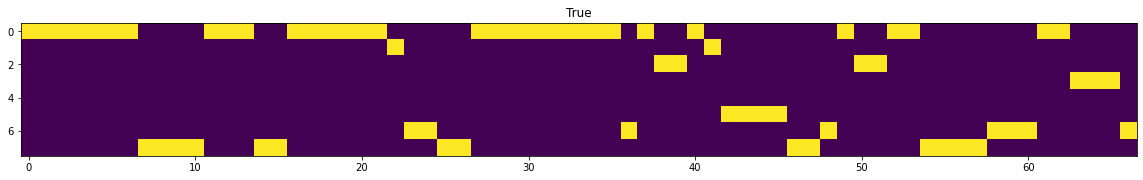

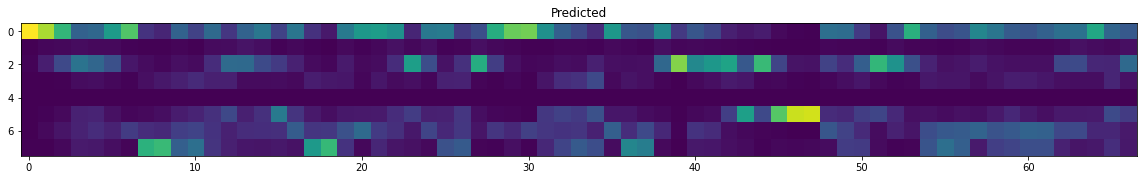

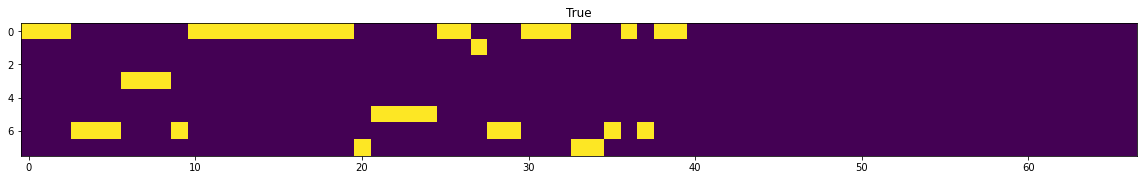

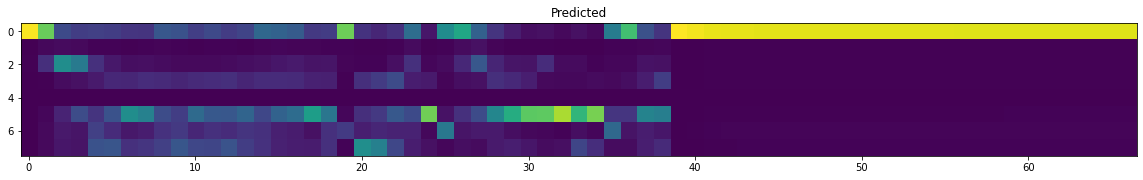

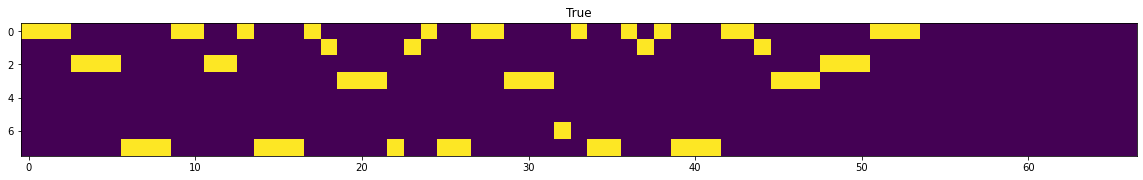

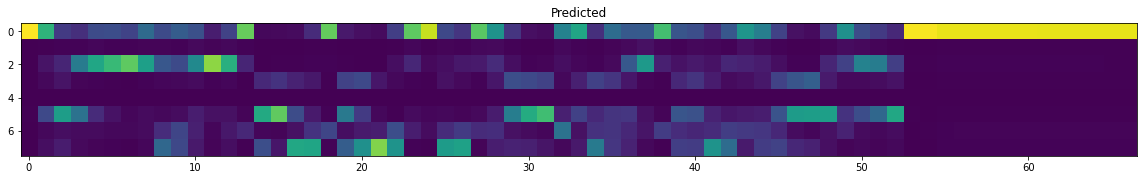

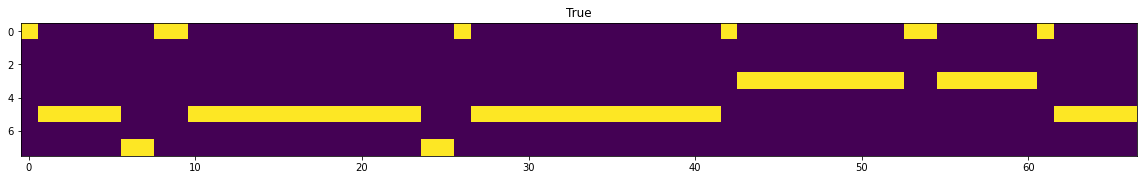

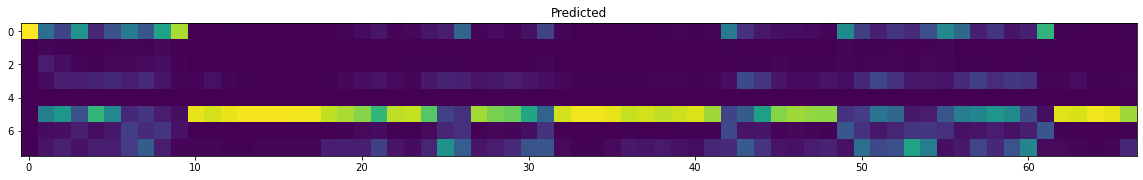

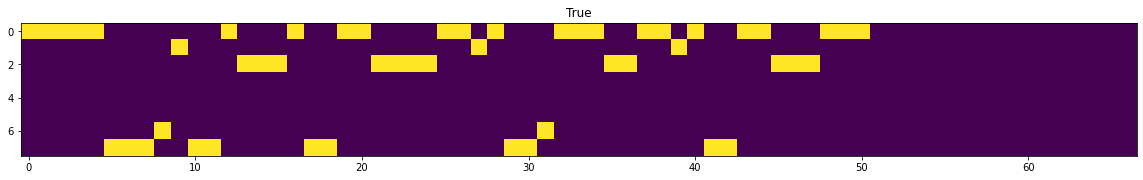

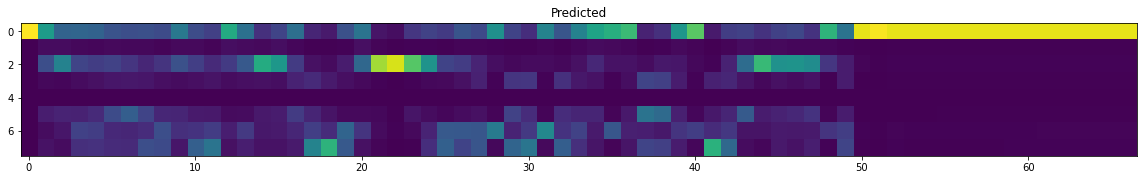

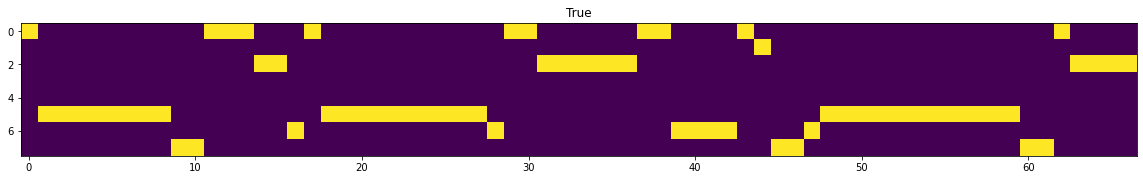

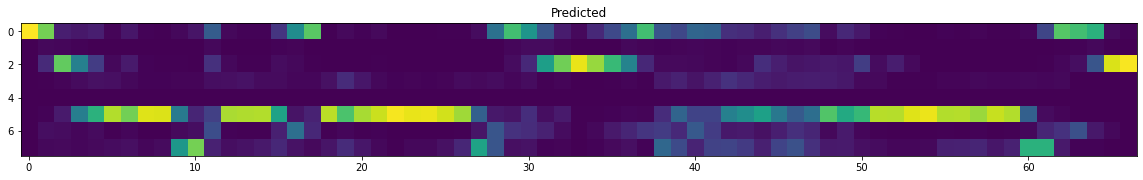

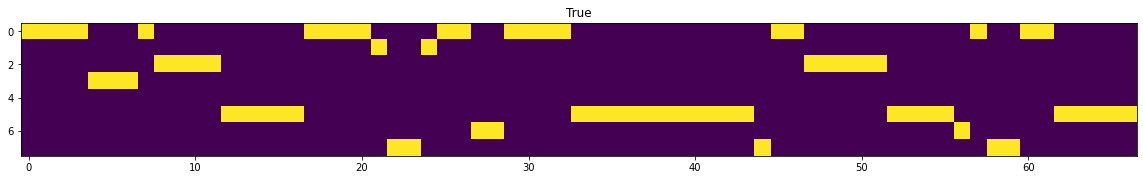

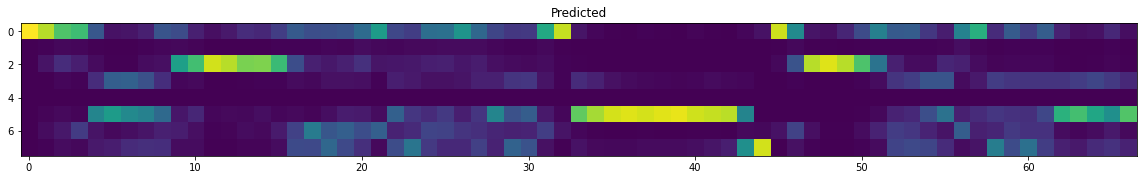

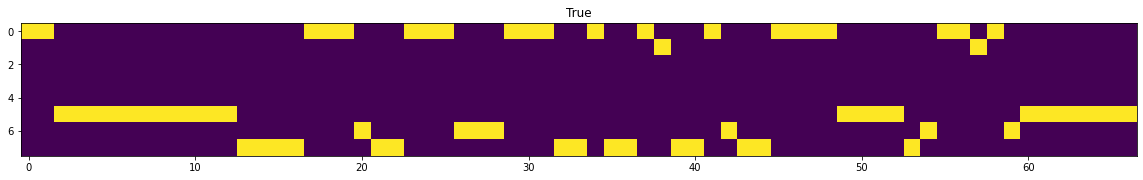

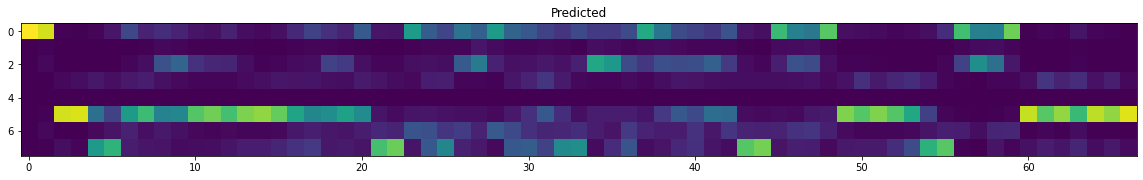

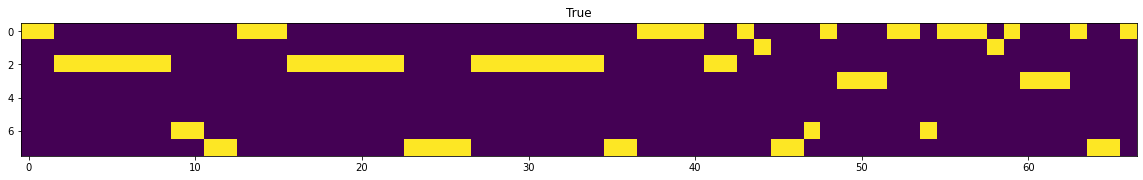

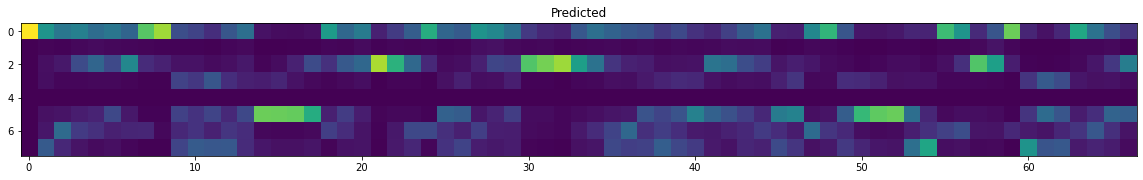

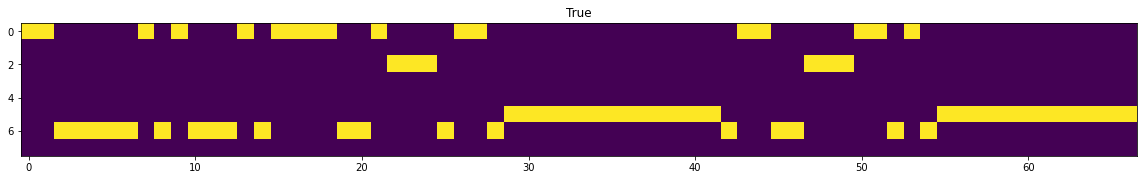

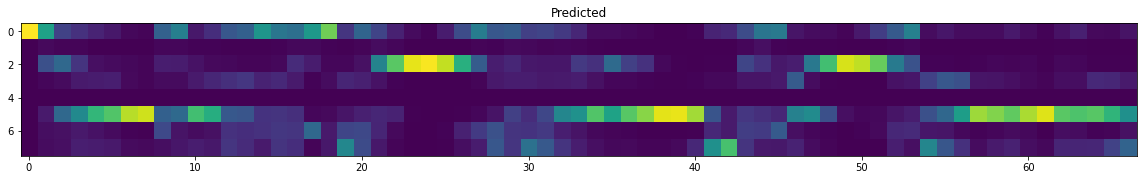

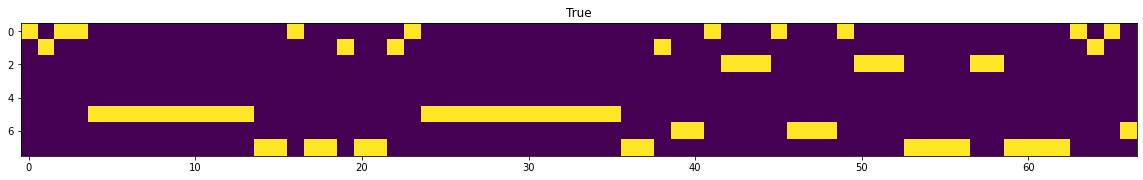

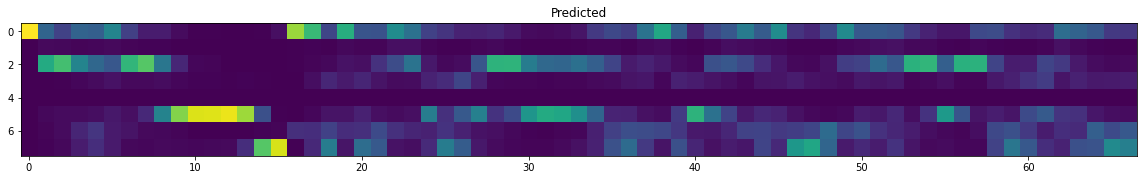

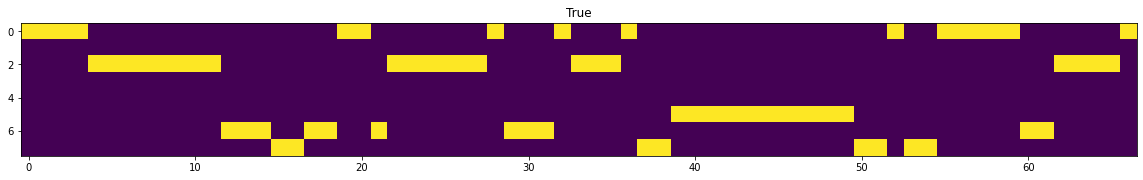

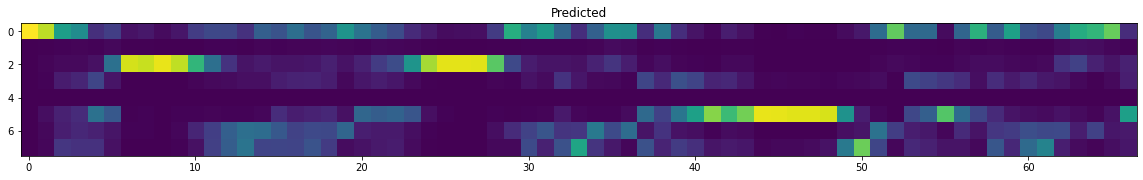

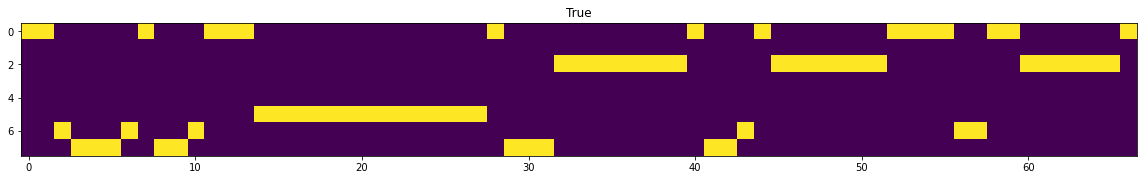

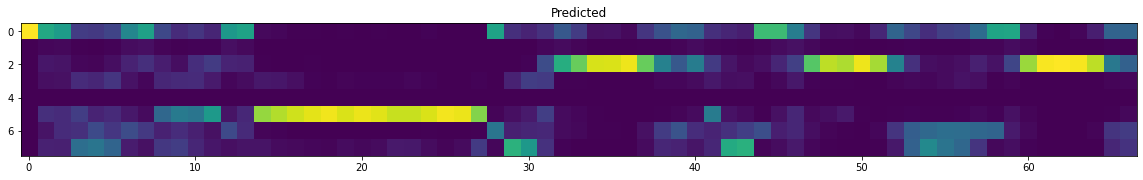

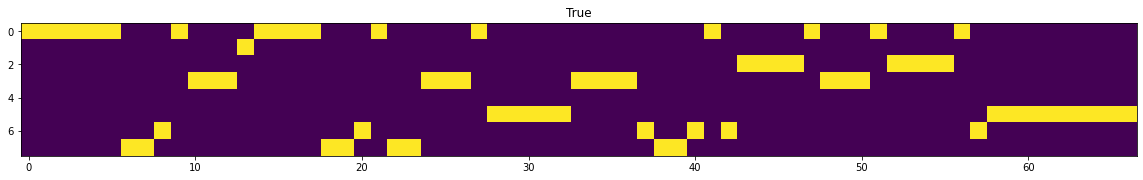

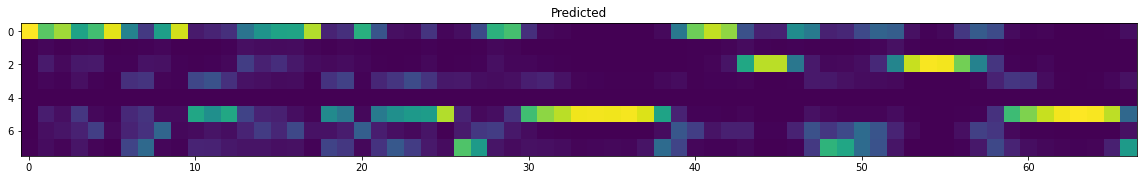

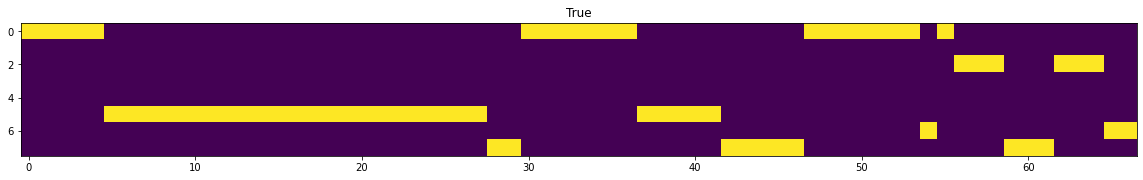

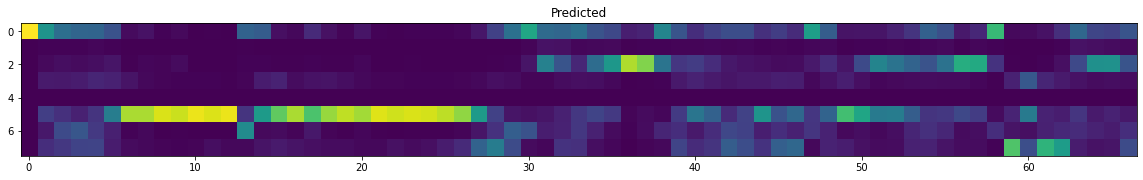

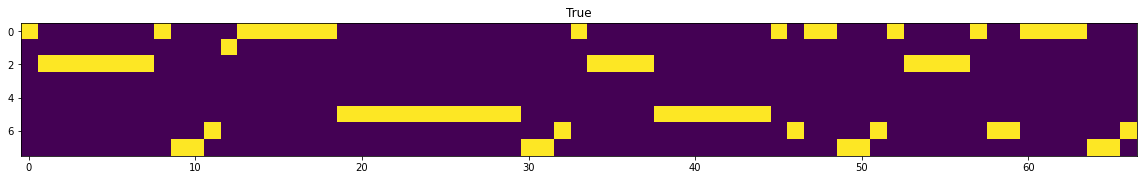

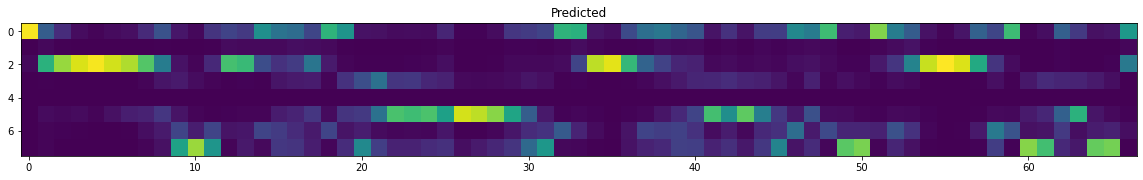

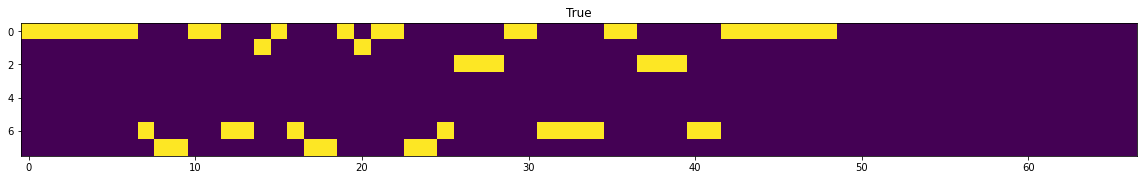

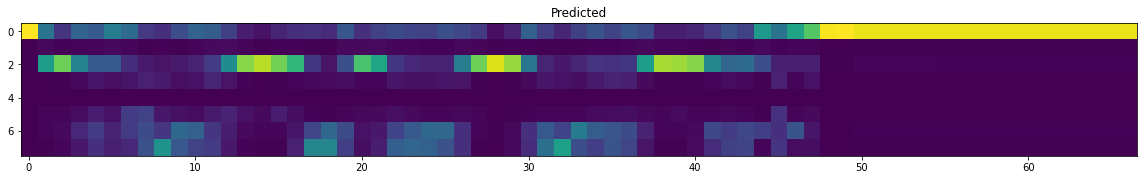

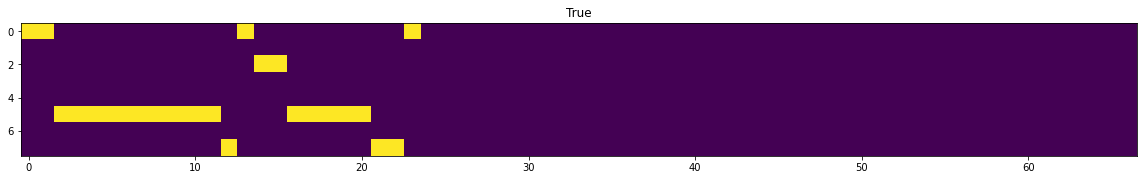

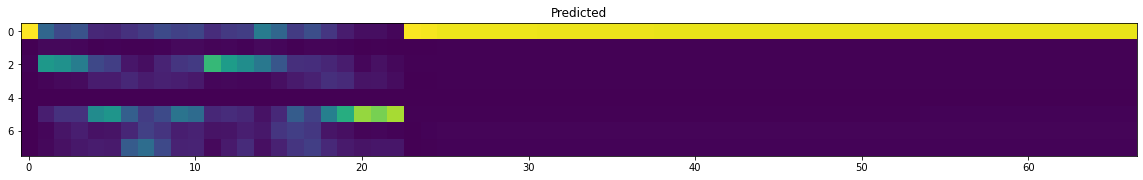

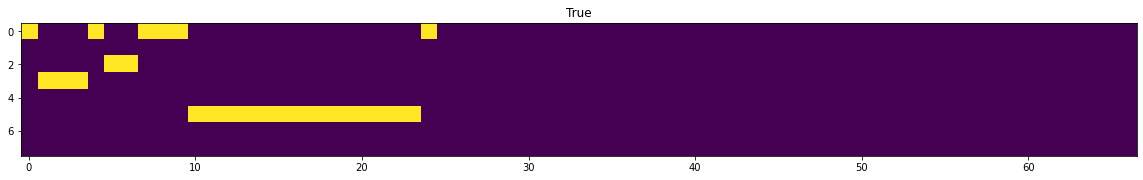

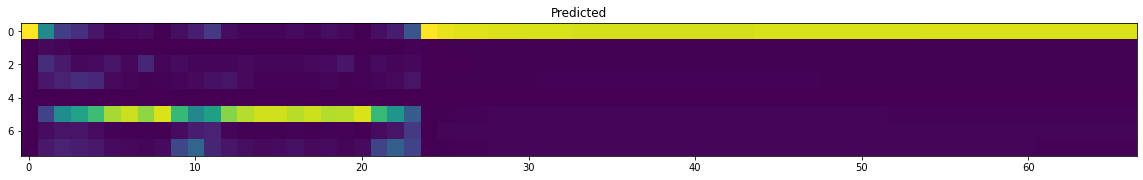

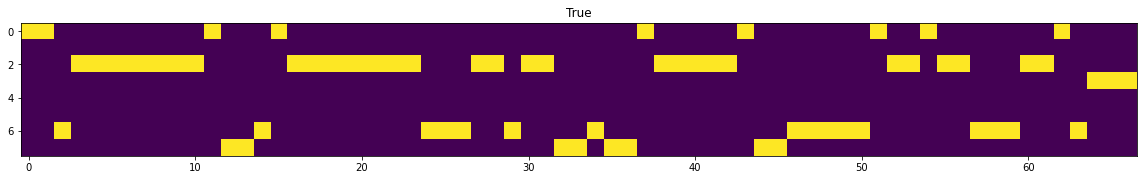

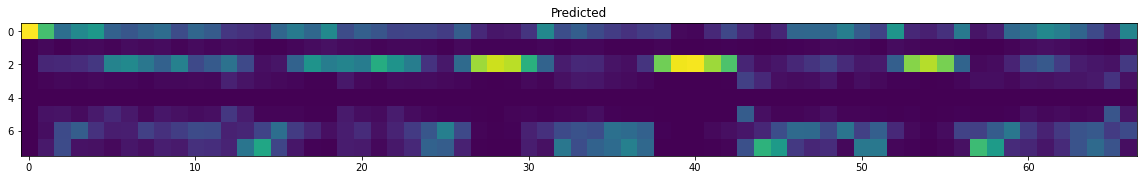

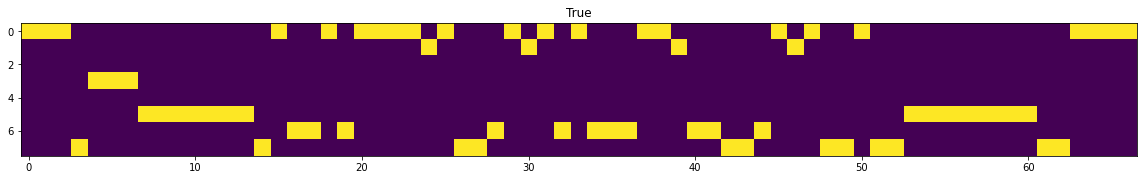

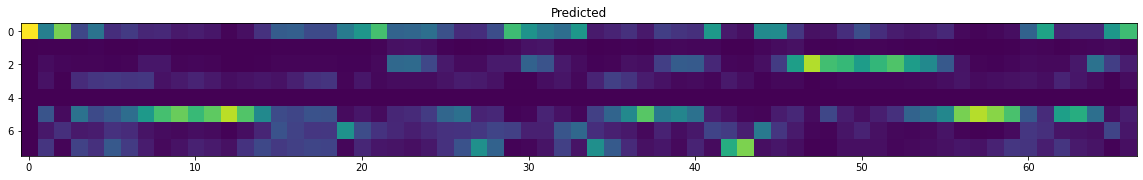

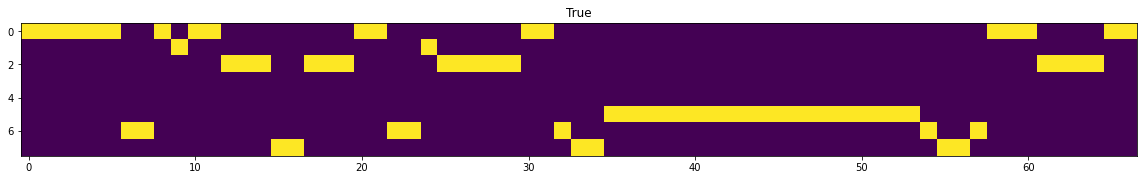

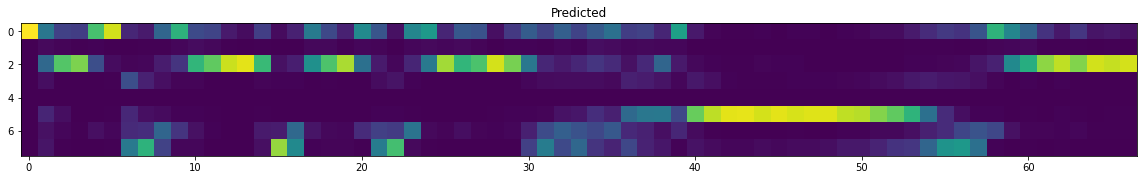

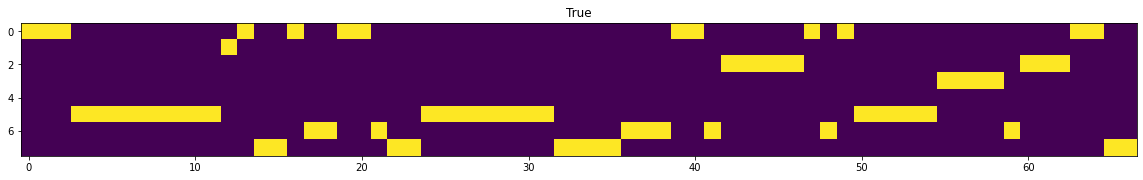

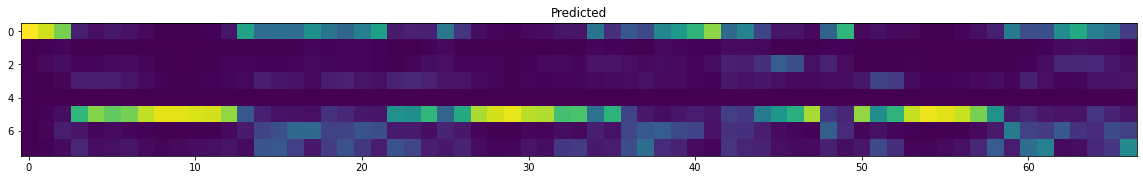

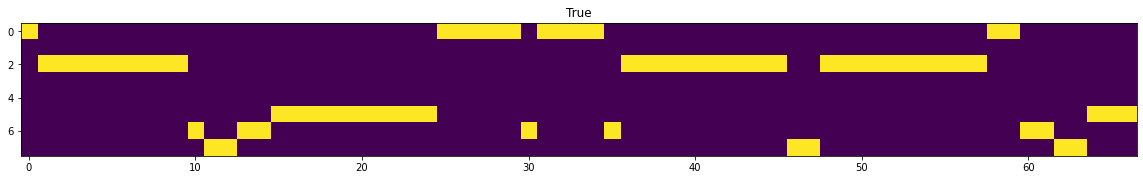

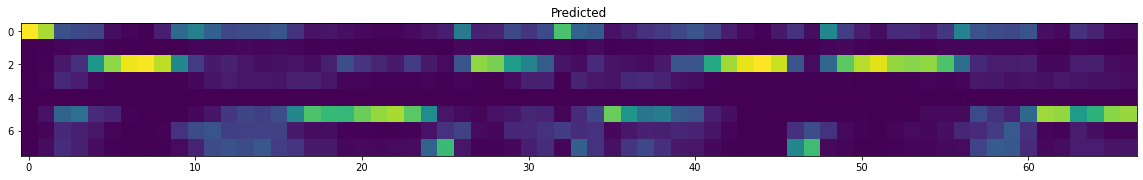

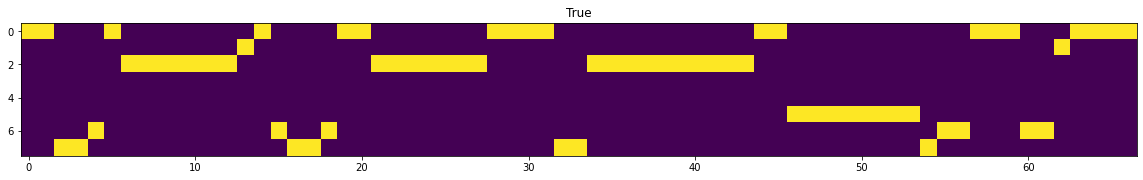

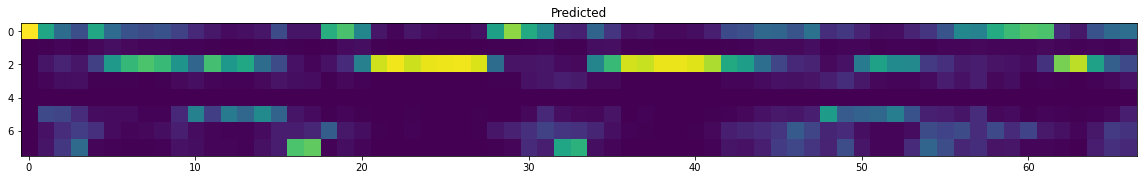

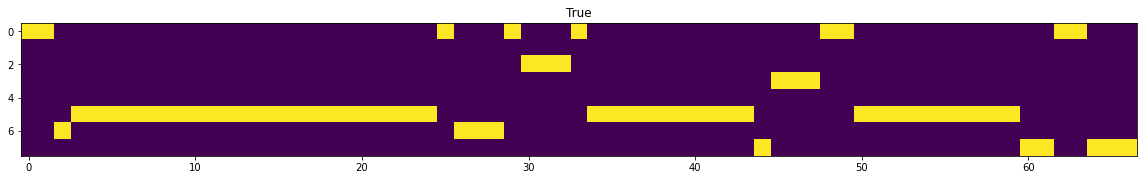

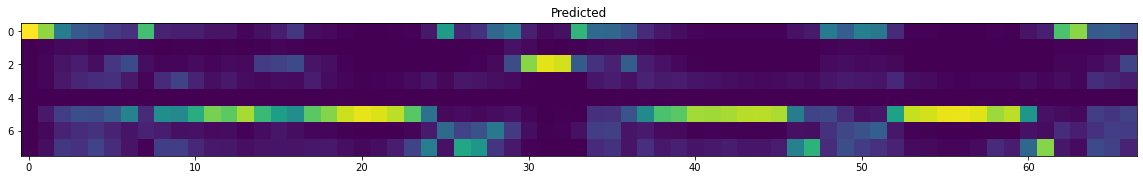

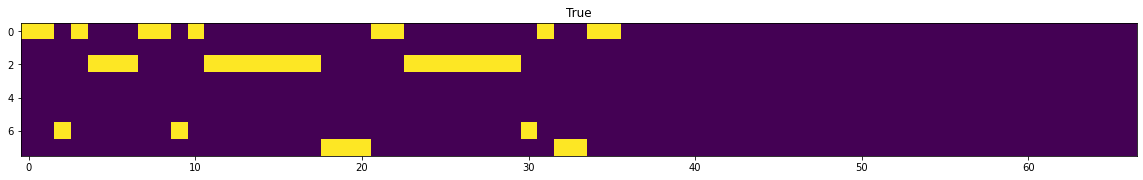

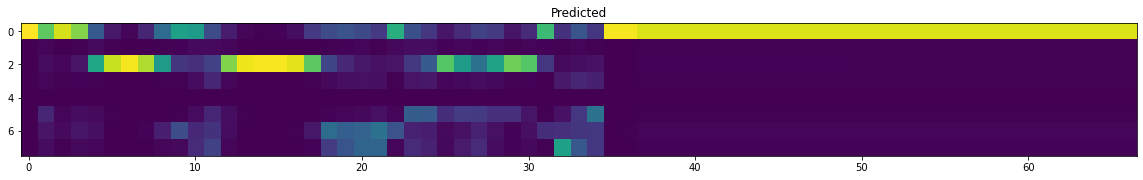

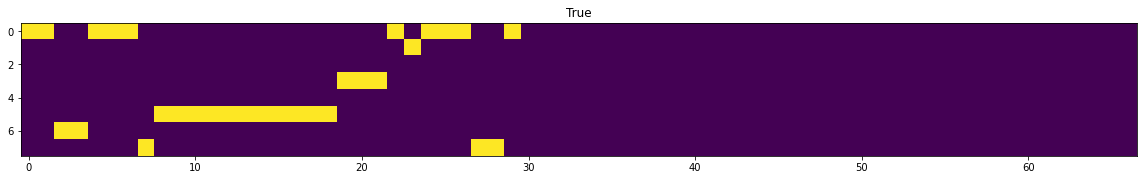

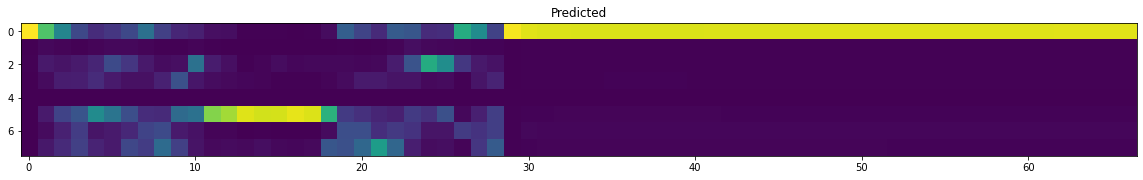

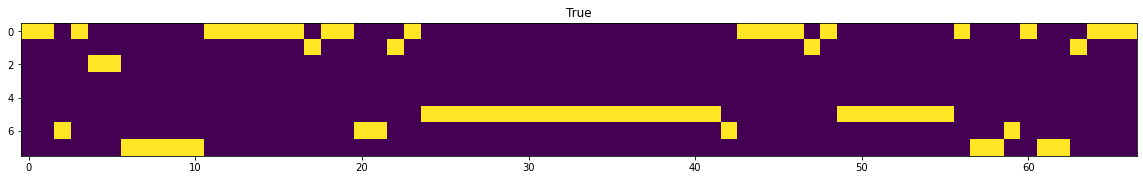

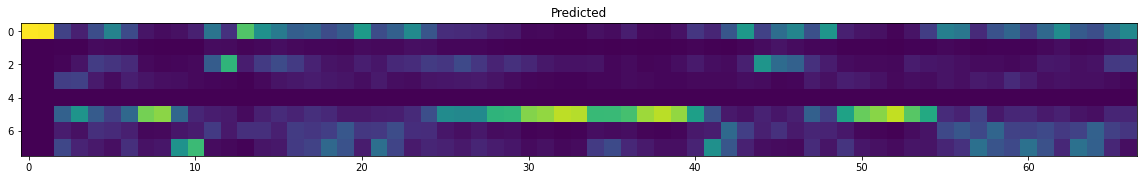

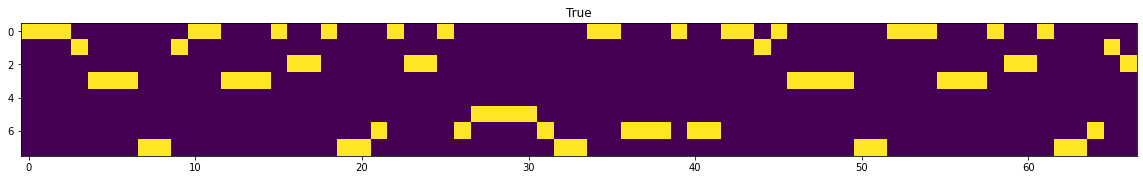

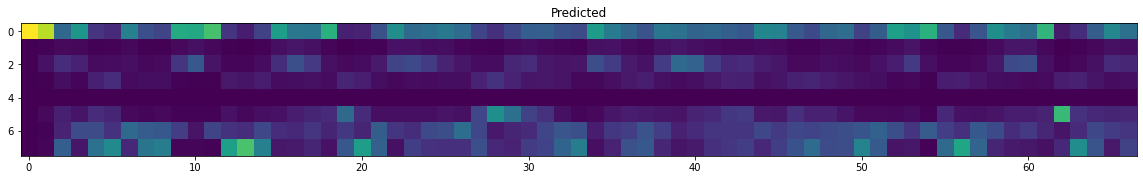

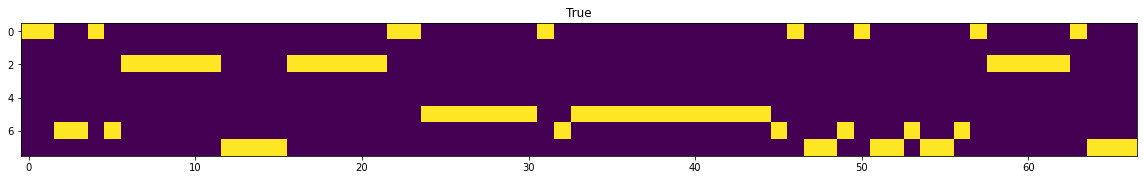

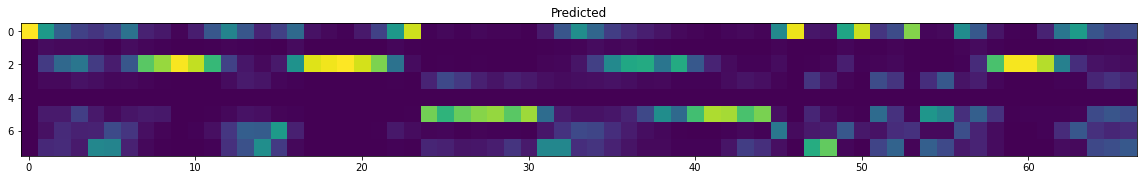

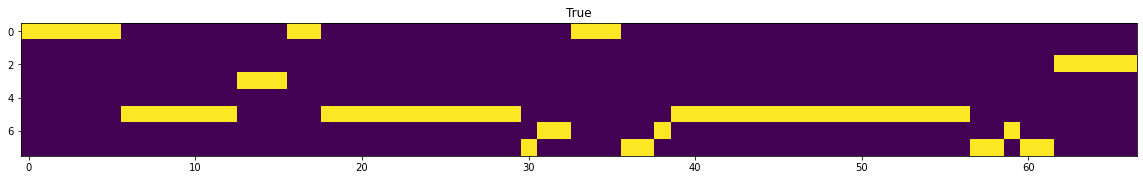

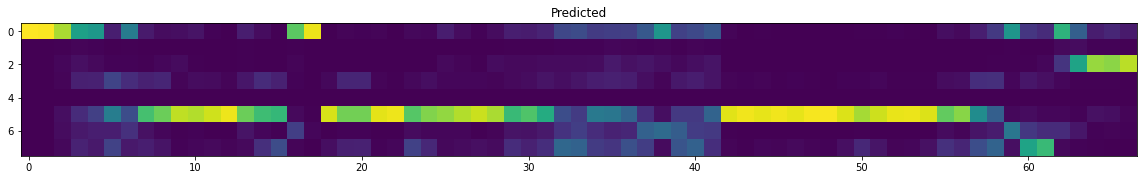

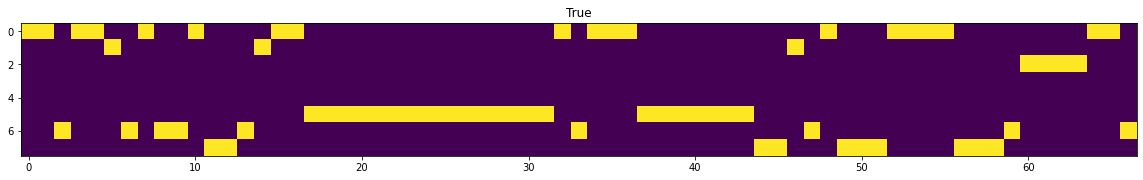

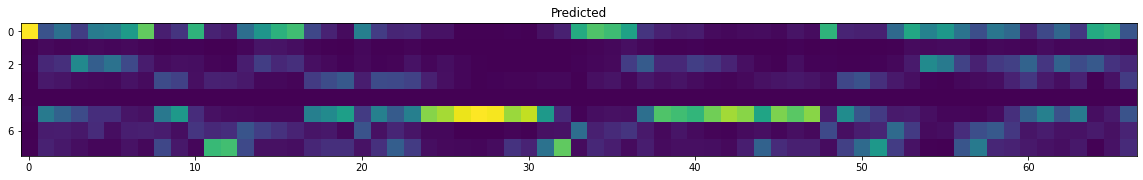

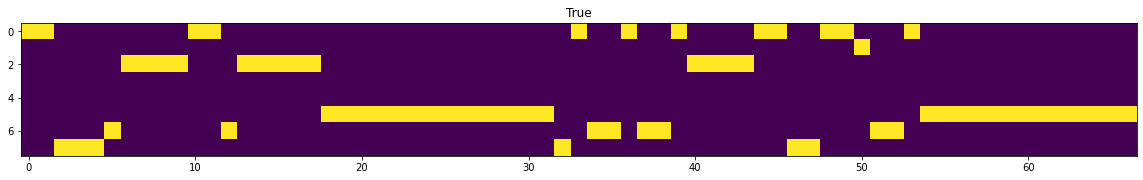

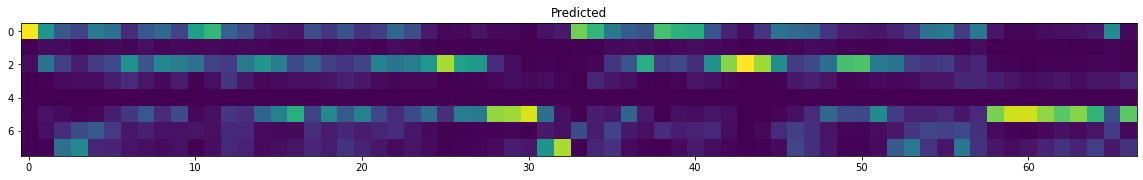

In [28]:
for i in range(514):
    plt.figure(figsize=(20,4))
    plt.title("True")
    plt.imshow(test_y_main[i][0:67].T)
    plt.figure(figsize=(20,4))
    plt.title("Predicted")
    plt.imshow(preRes[i][0:67].T)
    plt.show()